In [1]:
import csv
import matplotlib
import matplotlib.pyplot as plt
import math as m
import numpy as np
import os.path
import os
import scipy
from scipy import optimize
from scipy.optimize import curve_fit

In [6]:
## Normalization constant
def FindN(st, sigma_s, alpha, p0, s0):
    return ((p0/alpha)*np.exp(-alpha*st)+0.5*(scipy.special.erfc((s0-st)/(2**0.5*sigma_s))))**(-1)

## Find the quantity p0
def FindP0(st, sigma_s, alpha, s0):
    #return np.exp(0.5*(alpha-1)*alpha*sigma_s**2)/(sigma_s*np.sqrt(2*np.pi))
    return (st-s0)*np.exp(alpha*st-(st-s0)**2/(2*sigma_s**2))/(alpha*np.sqrt(2*np.pi)*sigma_s**3)


## Find the mean
def Finds0(sigma_s, alpha):
    numerator = (-1+alpha)*(np.sqrt(2) + alpha*np.exp(alpha**2*sigma_s**2/2)*np.sqrt(np.pi)*sigma_s*(1+scipy.special.erf(alpha*sigma_s/2)))
    denominator1 = np.sqrt(2)*alpha*np.exp(alpha*sigma_s**2)
    denominator2 = (-1+alpha)*alpha*np.exp((1+alpha**2)*sigma_s**2/2)*np.sqrt(np.pi)*sigma_s*(1+scipy.special.erf((-1+alpha)*sigma_s/2))
    denominator = denominator1+denominator2
    return np.log((numerator)/(denominator))

## The PDF function LN+PL. Only sigma and alpha are the free parameters
def LNPLfunction(s, sigma_s, alpha):  #, st, N, p0s0,
    s0 = Finds0(sigma_s, alpha)
    st = s0 + alpha*sigma_s**2
    
    ### A(n inefficient) way for splitting the x array into LN and PL part called s_low and s_high
    s_list = np.where(s<st)
    s_low = []
    for i in s_list[0]:
        s_low.append(s[i])
    s_low = np.array(s_low)

    s_list = np.where(s>=st)
    s_high = []
    for i in s_list[0]:
        s_high.append(s[i])
    s_high = np.array(s_high)
    
    
    p0 = FindP0(st, sigma_s, alpha, s0)
    N = FindN(st, sigma_s, alpha, p0, s0)
    
    y_out = np.concatenate((N*(1/(np.sqrt(2*np.pi)*sigma_s))*np.exp(-(s_low-s0)**2/(2*sigma_s**2)), N*p0*np.exp(-alpha*s_high))) 
    return y_out          
        
    
    
#### Function for the CDF instead of PDF. 
def LNPLfunctionCDF(s, sigma_s, alpha):  #, st, N, p0s0,
    #s0 = -0.5*sigma_s**2
    #st = 0.5*(2*np.absolute(alpha) - 1)*sigma_s**2
    #s0 = np.sqrt(2)*sigma_s*scipy.special.erfinv((alpha - 2*sigma_s*alpha - 2*np.exp(-alpha*st))/alpha) + st
    
    s0 = Finds0(sigma_s, alpha)
    st = s0 + alpha*sigma_s**2
    s_list = np.where(s<st)
    #print (s_list[0])
    s_low = []
    for i in s_list[0]:
        s_low.append(s[i])
    s_low = np.array(s_low)
    #print (s_low)
    s_list = np.where(s>=st)
    
    s_high = []
    for i in s_list[0]:
        s_high.append(s[i])
    
    s_high = np.array(s_high)
    p0 = FindP0(st, sigma_s, alpha, s0)
    N = FindN(st, sigma_s, alpha, p0, s0)
    a = N/2*scipy.special.erfc(-(s_low-s0)/(np.sqrt(2)*sigma_s))
    #print (N*np.sqrt(np.pi/2)*sigma_s*scipy.special.erfc((s0-st)/(np.sqrt(2)*sigma_s)))
    #print (N*(p0/alpha)*(np.exp(-alpha*st)))
    c = N*(p0/alpha)*(np.exp(-alpha*st)) + N/2*scipy.special.erfc((s0-st)/(np.sqrt(2)*sigma_s))
    b = N*(p0/alpha)*(-1*np.exp(-alpha*s_high)) + c
    #y_out = np.concatenate((N*(1/(np.sqrt(2*np.pi)*sigma_s))*np.exp(-(s_low-s0)**2/(2*sigma_s**2)), N*p0*np.exp(-alpha*s_high)))
    y_out = np.concatenate((a, b))
    #if (s<st):
    return y_out  


#### Function for y = log(CDF/(1-CDF)) -- since this is what we use to fit so that there's more weight to the tail
def LNPLfunctionCDFLog(s, sigma_s, alpha):  #, st, N, p0s0,
    #s0 = -0.5*sigma_s**2
    #st = 0.5*(2*np.absolute(alpha) - 1)*sigma_s**2
    #s0 = np.sqrt(2)*sigma_s*scipy.special.erfinv((alpha - 2*sigma_s*alpha - 2*np.exp(-alpha*st))/alpha) + st
    
    s0 = Finds0(sigma_s, alpha)
    st = s0 + alpha*sigma_s**2
    s_list = np.where(s<st)
    #print (s_list[0])
    s_low = []
    for i in s_list[0]:
        s_low.append(s[i])
    s_low = np.array(s_low)
    #print (s_low)
    s_list = np.where(s>=st)
    
    s_high = []
    for i in s_list[0]:
        s_high.append(s[i])
    
    s_high = np.array(s_high)
    p0 = FindP0(st, sigma_s, alpha, s0)
    N = FindN(st, sigma_s, alpha, p0, s0)
    a = N/2*scipy.special.erfc(-(s_low-s0)/(np.sqrt(2)*sigma_s))
    #print (N*np.sqrt(np.pi/2)*sigma_s*scipy.special.erfc((s0-st)/(np.sqrt(2)*sigma_s)))
    #print (N*(p0/alpha)*(np.exp(-alpha*st)))
    c = N*(p0/alpha)*(np.exp(-alpha*st)) + N/2*scipy.special.erfc((s0-st)/(np.sqrt(2)*sigma_s))
    b = N*(p0/alpha)*(-1*np.exp(-alpha*s_high)) + c
    #y_out = np.concatenate((N*(1/(np.sqrt(2*np.pi)*sigma_s))*np.exp(-(s_low-s0)**2/(2*sigma_s**2)), N*p0*np.exp(-alpha*s_high)))
    y_out = np.concatenate((a, b))
    for i in range (0, len(y_out)):
        y_out[i] = np.log(y_out[i]/(1-y_out[i]))
    #if (s<st):
    return y_out  


### Function for finding out errors in s0, so this gives \partial(s0)/\partial(sigma)
def FindDels0Delsigma(sigma, alpha):
    term1 = -1/sigma
    term2 = -sigma
    term3 = 1/(sigma + (-1+alpha)*np.exp(0.5*(-1+alpha)**2*sigma**2)*np.sqrt(np.pi/2)*sigma**2*\
              (1+scipy.special.erf((-1+alpha)*sigma/np.sqrt(2))))
    term4 = 1/(sigma + (np.sqrt(2/np.pi)*np.exp(-0.5*alpha**2*sigma**2))/(alpha+alpha*\
                                                                          scipy.special.erf(alpha*sigma/np.sqrt(2))))
    full = term1 + term2 + term3 + term4
    
    return full

### Function for finding out errors in s0, so this gives \partial(s0)/\partial(alpha)
def FindDels0Delalpha(sigma, alpha):
    numterm1 = 2*np.exp(alpha*sigma**2) 
    numterm2 = alpha**2*np.exp(alpha*(2+alpha)*sigma**2/2)*np.sqrt(2*np.pi)*sigma*\
    (1+scipy.special.erf(alpha*sigma/np.sqrt(2)))
    numterm3 = (-1+alpha)**2*np.exp((1+alpha)**2*sigma**2/2)*np.sqrt(2*np.pi)*sigma*\
    (-2+scipy.special.erfc((-1+alpha)*sigma/np.sqrt(2)))
    numerator = numterm1+numterm2+numterm3
    a = (-1+alpha)*alpha
    b = (np.sqrt(2)*np.exp(alpha*sigma**2) + (-1+alpha)*np.exp((1+alpha**2)*sigma**2/2)*np.sqrt(np.pi)*\
        sigma*(1+scipy.special.erf((-1+alpha)*sigma/np.sqrt(2))))
    c = np.sqrt(2)+alpha*np.exp(alpha**2*sigma**2/2)*np.sqrt(np.pi)*sigma*(1+scipy.special.erf(alpha*sigma/np.sqrt(2)))
    denominator = a*b*c
    full = numerator/denominator
    return full

### Finally find error in s0
def Finds0err(sigma, sigma_err, alpha, alpha_err):
    del_s0_by_del_sigma = FindDels0Delsigma(sigma, alpha)
    del_s0_by_del_alpha = FindDels0Delalpha(sigma, alpha)
    del_s0 = np.sqrt((del_s0_by_del_sigma*sigma_err)**2+(del_s0_by_del_alpha*alpha_err)**2)
    return del_s0

### Find p0
def FindPLPLP0(st, sigma, alpha, s0, alpha1, sb):
    num = -np.exp(alpha*st-(st-s0)**2/(2*sigma**2))*(s0-st)
    den = alpha*np.sqrt(2*np.pi)*sigma**3
    return num/den

### Find p1
def FindPLPLP1(st, sigma, alpha, s0, alpha1, sb):
    num = -np.exp((alpha1-alpha)*sb+alpha*st-(st-s0)**2/(2*sigma**2))*(s0-st)
    den = alpha*np.sqrt(2*np.pi)*sigma**3
    return num/den
    
### Find Normalization when using -inf to +inf
def FindPLPLN(st, sigma, alpha, p0, s0, alpha1, sb, p1):
    t1 = (-np.exp(-alpha*sb) + np.exp(-alpha*st))*p0/(alpha)
    t2 = np.exp(-alpha1*sb)*p1/(alpha1)
    t3 = 0.5*scipy.special.erfc((s0-st)/(np.sqrt(2)*sigma))
    return 1.0/(t1+t2+t3)

### Find Normalization when using -inf to scut -- a max density cutoff defined to be sink creation threshold
def FindPLPLNscut(st, sigma, alpha, p0, s0, alpha1, sb, p1, scut):
    t1 = (-np.exp(-alpha*sb) + np.exp(-alpha*st))*p0/(alpha)
    t2 = (np.exp(-alpha1*sb) - np.exp(-alpha1*scut))*p1/(alpha1)
    t3 = 0.5*scipy.special.erfc((s0-st)/(np.sqrt(2)*sigma))
    return 1.0/(t1+t2+t3)

### Function 
    
    
def LNPLPLfunction(s, sigma, alpha, alpha1, sb):#, s0):
    #s0 = Finds0(sigma_s, alpha)
    print (sigma, alpha, alpha1, sb)
    scut = sinkthresh
    upper=1
    s0 = FindTheFirstRootPlease(sigma, alpha, alpha1, sb, scut, upper, 1)
    print (s0)
    st = s0 + alpha*sigma**2
    if debug==True:
        print (sigma, alpha, alpha1, sb, st)
    if (st>sb):
        print ('Skipping this case, st>sb ...')
        return np.ones(len(s))
        
    s_list = np.where(s<st)[0]
    #print (s_list[0])
    s_low = np.take(s, s_list)
    #s_low = []
    #for i in s_list[0]:
     #   s_low.append(s[i])
    #s_low = np.array(s_low)
    #print (s_low)
    
    s_list = np.where((s>=st)&(s<sb))[0]
    s_high = np.take(s, s_list)
    #s_high = []
    #for i in s_list[0]:
    #    s_high.append(s[i])
    #s_high = np.array(s_high)
    
    s_list = np.where(s>=sb)[0]
    s_high2 = np.take(s, s_list)
    #s_high2 = []
    #for i in s_list[0]:
    #    s_high2.append(s[i])
    #s_high2 = np.array(s_high2)
    #print (s_high, s_high2)
    #print ('Lens - ', len(s_low), len(s_high), len(s_high2))
    #print (s_high, s_high2)
    
    p0 = FindPLPLP0(st, sigma, alpha, s0, alpha1, sb)
    p1 = FindPLPLP1(st, sigma, alpha, s0, alpha1, sb)
    #N = FindPLPLN(st, sigma, alpha, p0, s0, alpha1, sb, p1)
    N = FindPLPLNscut(st, sigma, alpha, p0, s0, alpha1, sb, p1, scut)
    
    a = N*(1/(np.sqrt(2*np.pi)*sigma))*np.exp(-(s_low-s0)**2/(2*sigma**2))
    b = N*p0*np.exp(-alpha*s_high)
    c = N*p1*np.exp(-alpha1*s_high2)

    #print (a, b)
    tmp = np.concatenate((a,b))
    y_out = np.concatenate((tmp,c))
    
    return y_out  

def LNPLPLfunctionLog(s, sigma, alpha, alpha1, sb):#, s0):
    #s0 = Finds0(sigma_s, alpha)
    print (sigma, alpha, alpha1, sb)
    scut = sinkthresh
    upper=1
    s0 = FindTheFirstRootPlease(sigma, alpha, alpha1, sb, scut, upper, 1)
    
    #s0 = optimize.bisect(lambda x: s0rootfuncnew(x, sigma, alpha, alpha1, sb, scut), -10, 1)
    print (s0)
    st = s0 + alpha*sigma**2
    if debug==True:
        print (sigma, alpha, alpha1, sb, st)
    
    if (st>sb):
        print ('Skipping this case, st>sb ...')
        return np.ones(len(s))
        
    s_list = np.where(s<st)[0]
    #print (s_list[0])
    s_low = np.take(s, s_list)
    #s_low = []
    #for i in s_list[0]:
     #   s_low.append(s[i])
    #s_low = np.array(s_low)
    print (s_low)
    
    s_list = np.where((s>=st)&(s<sb))[0]
    s_high = np.take(s, s_list)
    #s_high = []
    #for i in s_list[0]:
    #    s_high.append(s[i])
    #s_high = np.array(s_high)
    
    s_list = np.where(s>=sb)[0]
    s_high2 = np.take(s, s_list)
    #s_high2 = []
    #for i in s_list[0]:
    #    s_high2.append(s[i])
    #s_high2 = np.array(s_high2)
    print (s_high, s_high2)
    print ('Lens - ', len(s_low), len(s_high), len(s_high2))
    #print (s_high, s_high2)
    
    p0 = FindPLPLP0(st, sigma, alpha, s0, alpha1, sb)
    p1 = FindPLPLP1(st, sigma, alpha, s0, alpha1, sb)
    #N = FindPLPLN(st, sigma, alpha, p0, s0, alpha1, sb, p1)
    N = FindPLPLNscut(st, sigma, alpha, p0, s0, alpha1, sb, p1, scut)
    
    a = N*(1/(np.sqrt(2*np.pi)*sigma))*np.exp(-(s_low-s0)**2/(2*sigma**2))
    b = N*p0*np.exp(-alpha*s_high)
    c = N*p1*np.exp(-alpha1*s_high2)

    #print (a, b)
    tmp = np.concatenate((a,b))
    y_out = np.concatenate((tmp,c))
    
    return np.log(y_out) 


def LNPLPLfunctionCDF(s, sigma, alpha, alpha1, sb):#, s0):  #, st, N, p0s0,
    scut = sinkthresh
    
    upper=1
    s0 = FindTheFirstRootPlease(sigma, alpha, alpha1, sb, scut, upper, 1)
    
    #s0 = optimize.bisect(lambda x: s0rootfuncnew(x, sigma, alpha, alpha1, sb, scut), -10, 1)
    #print (s0)
    st = s0 + alpha*sigma**2
    if (st>sb):
        print ('Skipping this case, st>sb ...')
        return np.ones(len(s))
        
    s_list = np.where(s<st)[0]
    #print (s_list[0])
    s_low = np.take(s, s_list)
    #s_low = []
    #for i in s_list[0]:
    #    s_low.append(s[i])
    #s_low = np.array(s_low)
    #print (s_low)
    
    s_list = np.where((s>=st)&(s<sb))[0]
    s_high = np.take(s, s_list)
    #s_high = []
    #for i in s_list[0]:
     #   s_high.append(s[i])
    #s_high = np.array(s_high)
    
    s_list = np.where(s>=sb)[0]
    s_high2 = np.take(s, s_list)
    #s_high2 = []
    #for i in s_list[0]:
    #    s_high2.append(s[i])
    #s_high2 = np.array(s_high2)
    
    #print (s_high, s_high2)
    
    p0 = FindPLPLP0(st, sigma, alpha, s0, alpha1, sb)
    p1 = FindPLPLP1(st, sigma, alpha, s0, alpha1, sb)
    #N = FindPLPLN(st, sigma, alpha, p0, s0, alpha1, sb, p1)
    N = FindPLPLNscut(st, sigma, alpha, p0, s0, alpha1, sb, p1, scut)
    
    a = N/2*scipy.special.erfc((s0-s_low)/(np.sqrt(2)*sigma))
    
    b = N/2*scipy.special.erfc((s0-st)/(np.sqrt(2)*sigma)) +\
        N*(np.exp(-alpha*st)-np.exp(-alpha*s_high))*p0/alpha
    
    c = N/2*(2*(np.exp(-alpha*st)-np.exp(-alpha*sb))*p0/alpha +\
             2*(np.exp(-alpha1*sb)-np.exp(-alpha1*s_high2))*p1/alpha1 +\
            scipy.special.erfc((s0-st)/(np.sqrt(2)*sigma)))
    
    
    tmp = np.concatenate((a,b))
    y_out = np.concatenate((tmp,c))
    
    return y_out  

def FindTheFirstRootPlease(sigma, alpha, alpha1, sb, scut, upper,n):
    #lower = -10
    ## n is the tracker for number of recursions/tries
    if n<40:
        try:
            s0 = optimize.bisect(lambda x: s0rootfuncnew(x, sigma, alpha, alpha1, sb, scut), -15, upper)
            #print ('Root Found!', s0)
            return s0
        except ValueError:
            if n<20:
                print ('Try %d: Trying root finding in smaller range, upper lim='%(n), upper, sigma, alpha, alpha1, sb)
                s0 = FindTheFirstRootPlease(sigma, alpha, alpha1, sb, scut, upper-0.2, n+1)
            if n<=50 and n>=20:
                print ('Try %d: You sure?, upper lim='%(n), upper, sigma, alpha, alpha1, sb)
                s0 = FindTheFirstRootPlease(sigma, alpha, alpha1, sb, scut, upper-0.2, n+1)
    else:
        raise ValueError('Max iterations reached to find root')

    return s0
        
        
             
def LNPLPLfunctionCDFLog(s, sigma, alpha, alpha1, sb):#, s0):#, st, N, p0s0,
    scut = sinkthresh
    if debug==True:
        print (sigma, alpha, alpha1, sb)
    
    upper=1
    s0 = FindTheFirstRootPlease(sigma, alpha, alpha1, sb, scut, upper, 1)
    #print (s0)
    
    #try:
     #   s0 = optimize.bisect(lambda x: s0rootfuncnew(x, sigma, alpha, alpha1, sb, scut), -10, 1)
    #except ValueError:
     #   print ('Trying root finding in smaller range')
      #  try:
       #     s0 = optimize.bisect(lambda x: s0rootfuncnew(x, sigma, alpha, alpha1, sb, scut), -10, 0.5)
       # except ValueError:
        #    print ('Trying root finding in even smaller range')
         #   try:
          #      s0 = optimize.bisect(lambda x: s0rootfuncnew(x, sigma, alpha, alpha1, sb, scut), -10, 0.2)
            
        
    st = s0 + alpha*sigma**2
    if debug==True:
        print (sigma, alpha, alpha1, sb, st)
    if (st>sb):
        print ('Skipping this case, st>sb ...')
        return np.ones(len(s))
    
    if (alpha1>alpha):
        print ('Skipping this case, alpha1>alpha ...')
        return np.ones(len(s))
        
    s_list = np.where(s<st)[0]
    s_low = np.take(s, s_list)
    #print (s_list[0])
    #s_low = []
    #for i in s_list[0]:
     #   s_low.append(s[i])
    #s_low = np.array(s_low)
    #print (s_low)
    
    s_list = np.where((s>=st)&(s<sb))[0]
    s_high = np.take(s, s_list)
    #print (s_high)
    #s_high = []
    #for i in s_list[0]:
    #    s_high.append(s[i])
    #s_high = np.array(s_high)
    
    s_list = np.where(s>=sb)[0]
    s_high2 = np.take(s, s_list)
    #for i in s_list[0]:
     #   s_high2.append(s[i])
    #s_high2 = np.array(s_high2)
    
    #print (s_high, s_high2)
    #print ('Lens - ', len(s_low), len(s_high), len(s_high2))
    
    p0 = FindPLPLP0(st, sigma, alpha, s0, alpha1, sb)
    p1 = FindPLPLP1(st, sigma, alpha, s0, alpha1, sb)
    #N = FindPLPLN(st, sigma, alpha, p0, s0, alpha1, sb, p1)
    N = FindPLPLNscut(st, sigma, alpha, p0, s0, alpha1, sb, p1, scut)
    
    a = N/2*scipy.special.erfc((s0-s_low)/(np.sqrt(2)*sigma))
    
    b = N/2*scipy.special.erfc((s0-st)/(np.sqrt(2)*sigma)) +\
        N*(np.exp(-alpha*st)-np.exp(-alpha*s_high))*p0/alpha
    
    c = N/2*(2*(np.exp(-alpha*st)-np.exp(-alpha*sb))*p0/alpha +\
             2*(np.exp(-alpha1*sb)-np.exp(-alpha1*s_high2))*p1/alpha1 +\
            scipy.special.erfc((s0-st)/(np.sqrt(2)*sigma)))
    
    tmp = np.concatenate((a,b))
    y_out = np.concatenate((tmp,c))
    if len(np.where(y_out>1.0)[0]):
        return np.ones(len(y_out))
    #print (y_out)
    for i in range (0, len(y_out)):
        #print (y_out[i])
        #if y_out[i]>=1.0:
            #print ('Hi')
            #y_out[i]=1-(y_out[i]-1)
        
        y_out[i] = np.log(y_out[i]/(1-y_out[i]))
        #print (y_out[i])
             
    return y_out  

def s0rootfuncnew(s0, sigma, alpha, alpha1, sb, x):
    if alpha==1.0 or alpha1==1.0:
        if alpha==1.0:
            alpha=1.001
            print ('Function blows up at alpha=1, adding 0.001...')
        else:
            alpha1=1.001
            print ('Function blows up at alpha1=1, adding 0.001...')
    st = s0 + alpha*sigma**2
    scut = x
    assert x==sinkthresh
    
    p0 = FindPLPLP0(st, sigma, alpha, s0, alpha1, sb)
    p1 = FindPLPLP1(st, sigma, alpha, s0, alpha1, sb)
    N = FindPLPLNscut(st, sigma, alpha, p0, s0, alpha1, sb, p1, scut)
    #N = FindPLPLN(st, sigma, alpha, p0, s0, alpha1, sb, p1)
    
    #print (p0,p1,N,s0)
    a = -2*np.exp(sb-alpha*sb)*p0/(alpha-1)
    b = 2*np.exp(st-alpha*st)*p0/(alpha-1)
    c = 2*np.exp(sb-alpha1*sb)*p1/(alpha1-1)
    d = -2*np.exp(x-alpha1*x)*p1/(alpha1-1)
    e = np.exp(s0+sigma**2/2.0)*scipy.special.erfc((s0+sigma**2-st)/(np.sqrt(2)*sigma))
    
    y = (a+b+c+d+e)*N/2.0 - 1 ## -1 for root finding
    
    return y


def PLFit(xdata, ydata):
    index = np.where(ydata>0)
    new_datapts = np.take(ydata, index[0])
    new_datapts_x = np.take(xdata, index[0])
    ydata = new_datapts
    xdata = new_datapts_x

    index = np.where(xdata<sinkthresh)
    new_datapts = np.take(ydata, index[0])
    new_datapts_x = np.take(xdata, index[0])
    ydata = new_datapts
    xdata = new_datapts_x

    cdf = np.zeros(len(xdata))
    y = np.zeros(len(xdata))
    
    total = np.sum(ydata)
    for i in range(0, len(ydata)):
        cdf[i] = np.sum(ydata[0:i])/total
        y[i] = np.log(cdf[i]/(1-cdf[i]))  
    
    popt, pcov = curve_fit(LNPLfunctionCDFLog, xdata[4:-4], y[4:-4],\
                               p0 = [1.85, 1.57], bounds=[(1,1),(5,5)])
    perr = np.sqrt(np.diag(pcov))
        #print (popt, perr)
    return popt, perr

def PLPLFit(xdata, ydata, p0):
    index = np.where(ydata>0)
    new_datapts = np.take(ydata, index[0])
    new_datapts_x = np.take(xdata, index[0])
    ydata = new_datapts
    xdata = new_datapts_x

    index = np.where(xdata<sinkthresh)
    new_datapts = np.take(ydata, index[0])
    new_datapts_x = np.take(xdata, index[0])
    ydata = new_datapts
    xdata = new_datapts_x

    cdf = np.zeros(len(xdata))
    y = np.zeros(len(xdata))

    total = np.sum(ydata)
    for i in range(0, len(ydata)):
        cdf[i] = np.sum(ydata[0:i])/total
        y[i] = np.log(cdf[i]/(1-cdf[i]))  
    
    #p0 = [1.7, 1.2, 0.8, 7.2]
    popt, pcov = curve_fit(LNPLPLfunctionCDFLog, xdata[4:-4], y[4:-4],\
                               p0 = p0, bounds=[(0,1.01,0.3,3),(5,5,5,10)], maxfev=50000)

    perr = np.sqrt(np.diag(pcov))
    #sigma = popt[0]
    #alpha = popt[1]
    #sigma_err = perr[0]
    #alpha_err = perr[1]
    #alpha1 = popt[2]
    #alpha1_err = perr[2]
    #sb = popt[3]
    #sb_err = perr[3]

    #scut = sinkthresh
    #s0 = optimize.bisect(lambda x: s0rootfuncnew(x, sigma, alpha, alpha1, sb, scut), -10, 1)
    
    #st = s0+alpha*sigma**2
    #print (s0, st)
    

    return popt, perr

def WriteToFileDPLVW(real_sim_name, j, time, mass, sigma, sigma_err, alpha, alpha_err, alpha1, alpha1_err, sb, \
                     sb_err, st, s0):
    rows = [j, time, mass, sigma, alpha, alpha1, sb, st, s0, sigma_err, alpha_err, alpha1_err, sb_err]
    csvfile=open('./PDFs_data/NewCorrectFits/DPL_VW_{sim}.csv'.format(sim=real_sim_name),'a', newline='') #/{sim}
    obj=csv.writer(csvfile)
    obj.writerow(rows)
    csvfile.close()
    
def WriteToFileDPLVWBootStrap(real_sim_name, j, time, mass, sigma, sigma_err, alpha, alpha_err, alpha1, alpha1_err, sb, \
                     sb_err, st, s0, st_bts, s0_bts, st_bts_err, s0_bts_err):
    rows = [j, time, mass, sigma, alpha, alpha1, sb, st, s0, sigma_err, alpha_err, alpha1_err, sb_err,  st_bts, \
            s0_bts, st_bts_err, s0_bts_err]
    csvfile=open('./PDFs_data/NewCorrectFits/DPL_VW_{sim}_Bootstrap_newM5.csv'.format(sim=real_sim_name),'a', newline='') #/{sim}
    obj=csv.writer(csvfile)
    obj.writerow(rows)
    csvfile.close()
    
def WriteToFileDPLMW(real_sim_name, j, time, mass, sigma, sigma_err, alpha, alpha_err, alpha1, alpha1_err, sb, \
                     sb_err, st, s0):
    rows = [j, time, mass,sigma, alpha, alpha1, sb, st, s0, sigma_err, alpha_err, alpha1_err, sb_err]
    csvfile=open('./PDFs_data/NewCorrectFits/DPL_MW_{sim}.csv'.format(sim=real_sim_name),'a', newline='')
    obj=csv.writer(csvfile)
    obj.writerow(rows)
    csvfile.close()
    
def WriteToFileSPLVW(real_sim_name, j, time, mass, sigma, sigma_err, alpha, alpha_err, st, st_err, s0, s0_err):
    rows = [j, time, mass, sigma, alpha, st, s0, sigma_err, alpha_err, st_err, s0_err]
    csvfile=open('./PDFs_data/NewCorrectFits/SPL_VW_{sim}_newM5.csv'.format(sim=real_sim_name),'a', newline='') #/{sim}
    obj=csv.writer(csvfile)
    obj.writerow(rows)
    csvfile.close()
    
def WriteToFileSPLMW(real_sim_name, j, time, mass, sigma, sigma_err, alpha, alpha_err, st, st_err, s0, s0_err):
    rows = [j, time, mass, sigma, alpha, st, s0, sigma_err, alpha_err, st_err, s0_err]
    csvfile=open('./PDFs_data/NewCorrectFits/SPL_MW_{sim}.csv'.format(sim=real_sim_name),'a', newline='') #/{sim}
    obj=csv.writer(csvfile)
    obj.writerow(rows)
    csvfile.close()

In [7]:
real_sim_name = 'TGTPvir1M5res2048' ###### MODIFY #####
sim_name = 'TGTPvir1M5res2048'   ###### MODIFY #####

# define n and local arrays
n = int(1880)   #No. of plot files

#Tauto = 3.086e13/(24*3600*365*10**6)   ###### MODIFY #####
SinkDens = 8.2926192e-17 #1.3268191e-15 #2.0757061e-17   ###### MODIFY #####

dat_filename = './PDFs_data/{}/'.format(real_sim_name)+sim_name+'.dat'


datContent = [i.strip().split() for i in open(dat_filename).readlines()]
masses = []
times = []
for i in range(0, len(datContent)):
    if datContent[i][0][0]=='#':
        continue
    masses.append(float(datContent[i][1]))
    times.append(float(datContent[i][0]))
    
masses = np.array(masses)
times = np.array(times)/(24*3600*365.25*10**6) ## in Myr

TimeList = np.genfromtxt('./PDFs_data/{sim}/TimingMasses_{sim}.csv'.format(sim=real_sim_name), \
                            delimiter=',')

#Target_SFE = 5.0

plot_nums = np.zeros(len(TimeList))
plot_times = np.zeros(len(TimeList))
plot_masses = np.zeros(len(TimeList))
plot_rhos = np.zeros(len(TimeList))

for i in range (0, len(TimeList)):
        plot_nums[i] = TimeList[i][0]
        plot_times[i] = TimeList[i][1]
        plot_masses[i] = TimeList[i][2]
        plot_rhos[i] = TimeList[i][3]


In [4]:
plot_nums

array([ 10.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  24.,
        25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,  33.,  34.,  35.,
        36.,  37.,  39.,  40.,  41.,  42.,  43.,  44.,  45.,  46.,  47.,
        48.,  49.,  50.,  52.,  53.,  54.,  55.,  56.,  57.,  58.,  59.,
        60.,  61.,  62.,  63.,  64.,  66.,  67.,  68.,  69.,  70.,  71.,
        72.,  73.,  74.,  75.,  76.,  77.,  78.,  79.,  80.,  81.,  82.,
        83.,  84.,  85.,  86.,  87.,  88.,  89.,  90.,  91.,  92.,  93.,
        94.,  96.,  97.,  98.,  99., 100., 101., 103., 104., 105., 106.,
       107., 108., 109., 110., 111., 112., 113., 114., 115., 116., 117.,
       118., 119., 120., 122., 124., 125., 126., 127., 128., 129., 130.,
       131., 132., 133., 134., 135., 136., 137., 138., 139., 140., 141.,
       142., 143., 144., 146., 147., 148., 149., 150., 151., 152., 153.,
       156., 157., 158., 159., 160., 161., 162., 163., 164., 165., 166.,
       167., 168., 169., 170., 171., 172., 173., 17

I’m not sure what you mean by “resample” in step 2. Here is what I mean: the generic situation is that we have some parameter f that a is a function of one or more other parameters, let’s call them x_1, x_2, …. That is, we have f(x_1, x_2, x_3, …). The function f has to be evaluated numerically (for example by root-finding, though the argument would be the same for any other numerical computation, say numerical integration). So the question is, given that each of the input parameters has a central value a_i with some uncertainty sigma_i associated with it, what is the corresponding uncertainty on f? That is, if x_i = a_i + sigma_i, what is the standard deviation of f?

Here is the procedure to figure this 1:

1. Generate a set of trial x values by, for each one, picking from a Gaussian centred on x_i with dispersion sigma_i. Let’s call these trial values t_i.
2. Numerically evaluate f(t_1, t_2, t_3).
3. Repeat steps 1 and 2 N times; storing the set of values f_n produced in step 2, where n = 1, 2, 3, … N.
4. Your estimate for the central value of f is the average of the f_n’s, and your estimate for the dispersion of f is the dispersion of f_n values.



In [8]:
mu, sigma = 5, 3 # mean and standard deviation
s = np.random.normal(mu, sigma, 1000)

In [10]:
len(s)

1000

In [8]:
def FindstError(s0, alpha, sigma, s0_err, alpha_err, sigma_err):
    st = s0+alpha*sigma**2
    f = alpha*sigma**2
    df = abs(f)*np.sqrt((alpha_err/alpha)**2+(2*sigma_err/sigma))
    ds0 = s0_err
    dst = np.sqrt(ds0**2+df**2) 
    return dst

In [9]:
def BootStapper(poptPLPL, perrPLPL):
    print ('Bootstrapping starts now ...')
    
    sigma = poptPLPL[0]
    alpha = poptPLPL[1]
    sigma_err = perrPLPL[0]
    alpha_err = perrPLPL[1]
    alpha1 = poptPLPL[2]
    alpha1_err = perrPLPL[2]
    sb = poptPLPL[3]
    sb_err = perrPLPL[3]

    scut = sinkthresh
    s0 = optimize.bisect(lambda x: s0rootfuncnew(x, sigma, alpha, alpha1, sb, scut), -10, 1)


    st = s0+alpha*sigma**2
    N = 10000
    
    sigma_dist = np.random.normal(sigma, sigma_err, N)
    alpha_dist = np.random.normal(alpha, alpha_err, N)
    alpha1_dist = np.random.normal(alpha1, alpha1_err, N)
    sb_dist = np.random.normal(sb, sb_err, N)
    s0_list = []
    for i in range(0, N):
        try:
            val = optimize.bisect(lambda x: s0rootfuncnew(x, sigma_dist[i], \
                                            alpha_dist[i], alpha1_dist[i], sb_dist[i], scut), -10, 1)
            s0_list.append(val)
        except ValueError:
            continue
        
    s0_list = np.array(s0_list)
    s0bootmean = s0_list.mean()
    s0bootstd = np.std(s0_list)
    
    if debug==True:
        print ('First attempt values -', s0, s0bootmean, s0bootstd)
    
    ###################################
    ###################################
    ## if the difference between bootstrap and no bootstrap is more than 0.5, repeat with higher N
    if abs(s0-s0bootmean)>=0.5:
        if debug==True:
            print ('Second attempt...')
            
        s0bootmean_old = s0_list.mean()
        s0bootstd_old = np.std(s0_list)
        
        N = 50000
        sigma_dist = np.random.normal(sigma, sigma_err, N)
        alpha_dist = np.random.normal(alpha, alpha_err, N)
        alpha1_dist = np.random.normal(alpha1, alpha1_err, N)
        sb_dist = np.random.normal(sb, sb_err, N)
        s0_list = []
        for i in range(0, N):
            try:
                val = optimize.bisect(lambda x: s0rootfuncnew(x, sigma_dist[i], \
                                                alpha_dist[i], alpha1_dist[i], sb_dist[i], scut), -10, 1)
                s0_list.append(val)
            except ValueError:
                continue

        s0_list = np.array(s0_list)
        s0bootmean = s0_list.mean()
        s0bootstd = np.std(s0_list)
        
        if debug==True:
            print ('Second attempt values -', s0, s0bootmean, s0bootstd)
            
        #### Check if problem with bootstrap, check for convergence
        if abs(s0bootmean_old-s0bootmean)>=0.1:
            #if abs(s0bootmean_old-s0bootmean)>=0.5
            if debug==True:
                print ('Third attempt...Bootstrap not converged')
            N = 100000
            sigma_dist = np.random.normal(sigma, sigma_err, N)
            alpha_dist = np.random.normal(alpha, alpha_err, N)
            alpha1_dist = np.random.normal(alpha1, alpha1_err, N)
            sb_dist = np.random.normal(sb, sb_err, N)
            s0_list = []
            for i in range(0, N):
                try:
                    val = optimize.bisect(lambda x: s0rootfuncnew(x, sigma_dist[i], \
                                                    alpha_dist[i], alpha1_dist[i], sb_dist[i], scut), -10, 1)
                    s0_list.append(val)
                except ValueError:
                    continue

            s0_list = np.array(s0_list)
            s0bootmean = s0_list.mean()
            s0bootstd = np.std(s0_list)
    
    
    print ('Bootstrapping results - ',s0, s0bootmean, s0bootstd)
    
    ###################################
    ###################################
    #### Return the bootstrapped values
    s0_err = s0bootstd
    st_err = FindstError(s0bootmean, alpha, sigma, s0_err, alpha_err, sigma_err)
    st = s0bootmean+alpha*sigma**2
    if abs(s0-s0bootmean)>=0.5:
        print ('Bootstrapping not effective? Weird case...')
        return s0bootmean, s0_err, st, st_err
    
    
    return s0bootmean, s0_err, st, st_err

In [10]:
debug=False
debug_snap = 10

count = 0
for j in plot_nums:
        if debug==True:
                if j!=debug_snap:
                        count=count+1
                        continue
        if debug==False:
                if j<debug_snap:
                        #print ('Skipping first 40 files')
                        count=count+1
                        continue
        
        if j < 10:
                plot_filename = "%s_hdf5_plt_cnt_000%d" %(sim_name,j)
                part_filename = "%s_hdf5_part_000%d" %(sim_name,j)
        elif j >= 10 and j < 100:
                plot_filename = "%s_hdf5_plt_cnt_00%d" %(sim_name,j)
                part_filename = "%s_hdf5_part_00%d" %(sim_name,j)
        elif j >= 100 and j <1000:
                plot_filename = "%s_hdf5_plt_cnt_0%d" %(sim_name,j)
                part_filename = "%s_hdf5_part_0%d" %(sim_name,j)
        else:
                plot_filename = "%s_hdf5_plt_cnt_%d" %(sim_name,j)
                part_filename = "%s_hdf5_part_%d" %(sim_name,j)
                
        print ('--------x-------x----------\n')
        print ('--------x-------x----------\n')
        print (plot_filename, count)
        
        #ds = yt.load(plot_filename)
        current_time = plot_times[count]  #float(ds.current_time.in_units('Myr'))
        print (current_time)
        
        ind = np.where(times==current_time)[0]
        if len(ind)==0:
                print ('Not Found any times in .dat file..')
                continue
        time = np.take(times, ind)[-1]
        current_mass = np.take(masses, ind)[-1]
        
        print (time, current_mass)
        
        box_length = 6.172e18 #float(ds.domain_width.in_units('cm')[1])
        volume = box_length**3
        rho_0 = float(current_mass/volume)
        mean_rho = plot_rhos[count]
        print (rho_0, time, current_mass, mean_rho)
        
        outfile_vw = './PDFs_data/{}/'.format(real_sim_name)+plot_filename+'_pdf_vw.dat'
        outfile_mw = './PDFs_data/{}/'.format(real_sim_name)+plot_filename+'_pdf_mw.dat'
        
        print (outfile_vw)
        ##### Volume Weighted Part
        
        dat_filename = outfile_vw
        datContent = [i.strip().split() for i in open(dat_filename).readlines()]

        xdata=[]
        ydata=[]
        for i in range(11, len(datContent)):
            ydata.append(float(datContent[i][2]))
            xdata.append(float(datContent[i][0]))
        xdata = np.array(xdata)
        ydata = np.array(ydata)
        
        
        sinkthresh = np.log(SinkDens/rho_0)
        #sinkthresh = 10.88
        print ('Sink = ', sinkthresh)
        
        
        if debug==True:
            
            fig, ax = plt.subplots()
            fig.set_size_inches(10,10)
            ax.plot(xdata, ydata)
            ax.axvline(x=sinkthresh, c='k', linestyle='--', label='sink=%.3f'%(sinkthresh))
            ax.set_yscale('log')
            ax.minorticks_on()
            ax.set_xlim([-10, 15])
            ax.legend()
            #plt.savefig('./PDFs_data/{real_sim}/Debug_VW_{real_sim}_{file}.png'.format(real_sim = real_sim_name, file=plot_filename))
            plt.show()
            plt.close()
            
            try:
                p0 = [1.7, 1.6, 0.8, 7.1]
                print ('Fitting')
                poptPLPL, perrPLPL = PLPLFit(xdata, ydata, p0)
                print (poptPLPL)
                p0 = poptPLPL
                poptPLPL, perrPLPL = PLPLFit(xdata, ydata, p0)
                print (poptPLPL)
            except ValueError:
                print ('Tweaking initial guess for fitted parameters')
                p0 = [1.7, 1.6, 0.8, 6.1]
                print ('Fitting')
                poptPLPL, perrPLPL = PLPLFit(xdata, ydata, p0)
                print (poptPLPL)
                p0 = poptPLPL
                poptPLPL, perrPLPL = PLPLFit(xdata, ydata, p0)
                print (poptPLPL)
                

            sigma = poptPLPL[0]
            alpha = poptPLPL[1]
            sigma_err = perrPLPL[0]
            alpha_err = perrPLPL[1]
            alpha1 = poptPLPL[2]
            alpha1_err = perrPLPL[2]
            sb = poptPLPL[3]
            sb_err = perrPLPL[3]

            scut = sinkthresh
            s0 = optimize.bisect(lambda x: s0rootfuncnew(x, sigma, alpha, alpha1, sb, scut), -10, 1)
            

            st = s0+alpha*sigma**2
            
            s0bootmean, s0_err, stbootmean, st_err = BootStapper(poptPLPL, perrPLPL)
            #s0_err, st_err = Finds0stErrors(poptPLPL, perrPLPL)
            
            print ('s0, st = ',s0, st, s0bootmean, stbootmean)
            print ('s0_err, st_err = ',s0_err, st_err)
            
            fig, ax = plt.subplots()
            fig.set_size_inches(10,10)
            ax.plot(xdata, ydata)
            #s = np.linspace(-8, 15, 100)
            yfunc = LNPLPLfunction(xdata, sigma, alpha, alpha1, sb)
            ax.plot(xdata, yfunc, c='orange')

            ax.axvline(x=s0, c='purple', linestyle='--', label='s0=%.3f'%(s0))
            ax.axvline(x=st, c='r', linestyle='--', label='st=%.3f'%(st))
            ax.axvline(x=sb, c='g', linestyle='--', label='sb=%.3f'%(sb))
            ax.axvline(x=sinkthresh, c='k', linestyle='--', label='sink=%.3f'%(sinkthresh))

            ax.set_yscale('log')
        
            ax.minorticks_on()
            ax.set_xlim([-10, 15])
            ax.legend()
            #plt.savefig('./PDFs_data/{real_sim}/WTFDebug_VW_{real_sim}_{file}.png'.format(real_sim = real_sim_name, file=plot_filename))
            plt.show()
            plt.close()
            
            count=count+1
            
            continue
        
        fig = plt.figure(figsize=(12,12))

        ax1 = fig.add_axes([0.1, 0.1, 0.4, 0.4])

        ax2 = fig.add_axes([0.1, 0.5, 0.4, 0.4])
        ax3 = fig.add_axes([0.5, 0.1, 0.4, 0.4])
        ax4 = fig.add_axes([0.5, 0.5, 0.4, 0.4])
        
        
        try:
                p0 = [1.7, 1.6, 0.8, 7.1]
                print ('Fitting')
                poptPLPL, perrPLPL = PLPLFit(xdata, ydata, p0)
                print (poptPLPL)
                p0 = poptPLPL
                poptPLPL, perrPLPL = PLPLFit(xdata, ydata, p0)
                print (poptPLPL)
        except ValueError:
                print ('Tweaking initial guess for fitted parameters')
                p0 = [1.7, 1.6, 0.8, 6.1]
                print ('Fitting')
                poptPLPL, perrPLPL = PLPLFit(xdata, ydata, p0)
                print (poptPLPL)
                p0 = poptPLPL
                poptPLPL, perrPLPL = PLPLFit(xdata, ydata, p0)
                print (poptPLPL)
        
        
        
        
        #p0 = [1.7, 1.6, 0.8, 7.1]
        #print ('Fitting')
        #poptPLPL, perrPLPL = PLPLFit(xdata, ydata, p0)
        #print (poptPLPL)
        #p0 = poptPLPL
        #poptPLPL, perrPLPL = PLPLFit(xdata, ydata, p0)
        #print (poptPLPL)

        sigma = poptPLPL[0]
        alpha = poptPLPL[1]
        sigma_err = perrPLPL[0]
        alpha_err = perrPLPL[1]
        alpha1 = poptPLPL[2]
        alpha1_err = perrPLPL[2]
        sb = poptPLPL[3]
        sb_err = perrPLPL[3]

        scut = sinkthresh
        s0 = optimize.bisect(lambda x: s0rootfuncnew(x, sigma, alpha, alpha1, sb, scut), -10, 1)

        st = s0+alpha*sigma**2
        print ('s0, st = ',s0, st)
        print ('Errors = ', sigma_err, alpha_err, alpha1_err, sb_err)
        
        WriteToFileDPLVW(real_sim_name, j, time, current_mass, sigma, sigma_err, alpha, alpha_err, alpha1, alpha1_err, sb,\
                     sb_err, st, s0)
        
        s0bootmean, s0_err, stbootmean, st_err = BootStapper(poptPLPL, perrPLPL)
        #s0_err, st_err = Finds0stErrors(poptPLPL, perrPLPL)

        print ('s0, st = ', s0, st, s0bootmean, stbootmean)
        print ('s0_err, st_err = ',s0_err, st_err)
        WriteToFileDPLVWBootStrap(real_sim_name, j, time, current_mass, sigma, sigma_err, alpha, alpha_err, alpha1, alpha1_err, sb, \
                     sb_err, st, s0, stbootmean, s0bootmean, st_err, s0_err)
            
            
        scut1dpl = st
        scut2dpl = sb
        
        ax3.plot(xdata, ydata)
        #s = np.linspace(-8, 15, 100)
        yfunc = LNPLPLfunction(xdata, sigma, alpha, alpha1, sb)
        ax3.plot(xdata, yfunc, c='orange')

        ax3.axvline(x=s0, c='purple', linestyle='--', label='s0=%.3f'%(s0))
        ax3.axvline(x=st, c='r', linestyle='--', label='st=%.3f'%(st))
        ax3.axvline(x=sb, c='g', linestyle='--', label='sb=%.3f'%(sb))
        ax3.axvline(x=sinkthresh, c='k', linestyle='--', label='sink=%.3f'%(sinkthresh))

        ax3.set_yscale('log')
        
        index = np.where(ydata>0)
        new_datapts = np.take(ydata, index[0])
        new_datapts_x = np.take(xdata, index[0])
        ydata = new_datapts
        xdata = new_datapts_x

        index = np.where(xdata<sinkthresh)
        new_datapts = np.take(ydata, index[0])
        new_datapts_x = np.take(xdata, index[0])
        ydata = new_datapts
        xdata = new_datapts_x

        cdf = np.zeros(len(xdata))
        y = np.zeros(len(xdata))
        
        s = xdata[4:-4]
        ys = LNPLPLfunctionCDFLog(s, sigma, alpha, alpha1, sb)
        ax4.plot(s, ys, label= "$\\alpha$ = %.3f $\pm$ %.3f" %(alpha, perrPLPL[1])+\
                 "\n $\\alpha_1$ = %.3f $\pm$ %.3f" %(alpha1, perrPLPL[2])+\
             ",\n $\\sigma$ = %.3f $\pm$ %.4f" %(sigma, perrPLPL[0])+\
                 ",\n s$_b$=%.3f $\pm$ %.4f" %(sb, perrPLPL[3])+\
             ",\n s$_0$ = %.3f$\pm$ %.3f, s$_t$ = %.3f$\pm$ %.3f"%(s0bootmean, s0_err, stbootmean, st_err))
        
        
        plt.savefig('./PDFs_data/{real_sim}/VW_{real_sim}_{file}.png'.format(real_sim = real_sim_name, file=plot_filename))
        
        #plt.close()
        
        print ('Single PL part now')
        
        dat_filename = outfile_vw
        datContent = [i.strip().split() for i in open(dat_filename).readlines()]

        xdata=[]
        ydata=[]
        for i in range(11, len(datContent)):
            ydata.append(float(datContent[i][2]))
            xdata.append(float(datContent[i][0]))
        xdata = np.array(xdata)
        ydata = np.array(ydata)
        
        try:
            poptPL, perrPL = PLFit(xdata, ydata)
            sigma_s = poptPL[0]
            alpha = poptPL[1]
            sigma_s_err = perrPL[0]
            alpha_err = perrPL[1]
            s0 = Finds0(sigma_s, alpha)
            st = s0 + alpha*sigma_s**2
        except RuntimeError:
            print ('Cannot fit the single PL properly, assigning double PL values..')
            sigma_s = sigma
            s0 = Finds0(sigma_s, alpha)
            st = s0 + alpha*sigma_s**2
            alpha_err = 100
            sigma_s_err = 100
            #pass
            
        
        scutspl = st
        #print (s0, st)
        s0_err = Finds0err(sigma_s, sigma_s_err, alpha, alpha_err)
        st_err = FindstError(s0, alpha, sigma, s0_err, alpha_err, sigma_err)
        #np.sqrt(s0_err**2 + (sigma_s**2*alpha_err)**2 + (2*alpha*sigma_s*sigma_s_err)**2)
        
        WriteToFileSPLVW(real_sim_name, j, time, current_mass, sigma, sigma_s_err, alpha, alpha_err, st, st_err, s0, s0_err)
        
        yout = LNPLfunction(xdata, sigma_s, alpha)
        

        ax1.plot(xdata, ydata)
        ax1.plot(xdata, yout, 'r')

        ax1.axvline(x=st, c='r', linestyle='--', label='st=%.3f'%(st))
        ax1.axvline(x=sinkthresh, c='k', linestyle='--', label='sink=%.3f'%(sinkthresh))
        ax1.legend()
        ax1.set_yscale('log')
        
        index = np.where(ydata>0)
        new_datapts = np.take(ydata, index[0])
        new_datapts_x = np.take(xdata, index[0])
        ydata = new_datapts
        xdata = new_datapts_x

        index = np.where(xdata<sinkthresh)
        new_datapts = np.take(ydata, index[0])
        new_datapts_x = np.take(xdata, index[0])
        ydata = new_datapts
        xdata = new_datapts_x

        cdf = np.zeros(len(xdata))
        y = np.zeros(len(xdata))

        total = np.sum(ydata)
        for i in range(0, len(ydata)):
            cdf[i] = np.sum(ydata[0:i])/total
            y[i] = np.log(cdf[i]/(1-cdf[i])) 
    
        ax2.plot(xdata[4:-4], y[4:-4])
        ax4.plot(xdata[4:-4], y[4:-4])
        
        
        s = xdata[4:-4]
        ys = LNPLfunctionCDFLog(s, sigma, alpha)
        #plt.plot(sd, yd)
        ax2.plot(s, ys, c = 'r', label = "$\\alpha$ = %.3f $\pm$ %.3f" %(alpha, perrPL[1])+\
             ",\n $\\sigma$ = %.3f $\pm$ %.4f" %(sigma_s, perrPL[0])+\
             ",\n s$_0$ = %.3f $\pm$ %.3f,\n s$_t$ = %.3f $\pm$ %.3f"%(s0, s0_err, st, st_err))
        
        
        
        ax2.minorticks_on()
        ax2.set_xlim([-10, 15])
        ax4.minorticks_on()
        ax4.set_xlim([-10, 15])

        ax1.minorticks_on()
        #ax1.set_xlabel('s', fontsize = 24)
        #ax1.set_ylabel('P(s)', fontsize = 24)
        ax1.set_yscale('log')
        ax1.set_ylim([10**(-10), 10**0])
        ax1.set_xlim([-10, 15])
        ax3.set_ylim([10**(-10), 10**0])
        ax3.set_xlim([-10, 15])

        #ax3.xaxis.set_tick_params(labelsize=0, length=0, width=0)
        #ax3.yaxis.set_tick_params(labelsize=0, length=0, width=0)
        font_size=22
        ax2.legend(loc=4, prop={'size': 14})
        ax2.set_xlabel('s', fontsize=font_size)
        ax2.set_ylabel('y = ln(CDF/(1-CDF))',fontsize=font_size)
        ax2.xaxis.set_label_position('top') 
        ax2.tick_params(which = 'both',right = False, top=True, bottom=False, left=True, labelsize=18)#labelright=True,
        ax2.tick_params(which='major', length=10, width=1.5)
        ax2.tick_params(which='minor', length=3, width=1.5)
        ax2.tick_params(labeltop=True, labelbottom=False, labelright=False, labelleft=True)
        
        #font_size=22
        ax4.legend(loc=4, prop={'size': 14})
        ax4.set_xlabel('s', fontsize=font_size)
        #ax4.set_ylabel('y = ln(CDF/(1-CDF))',fontsize=font_size)
        ax4.xaxis.set_label_position('top') 
        ax4.tick_params(which = 'both',right = True, top=True, bottom=False, left=False, labelsize=18)#labelright=True,
        ax4.tick_params(which='major', length=10, width=1.5)
        ax4.tick_params(which='minor', length=3, width=1.5)
        ax4.tick_params(labeltop=True, labelbottom=False, labelright=True, labelleft=False)

        
        ax1.legend(loc=3, prop={'size': 14})
        ax1.set_xlabel('s', fontsize=font_size)
        ax1.set_ylabel('P$_V$(s)',fontsize=font_size)
        ax1.xaxis.set_label_position('bottom') 
        ax1.tick_params(which = 'both',right = False, left=True, top=False, bottom=True, labelsize=18)#labelright=True,
        ax1.tick_params(which='major', length=10, width=1.5)
        ax1.tick_params(which='minor', length=3, width=1.5)
        ax1.tick_params(labeltop=False, labelbottom=True, labelright=False, labelleft=True)

        ax3.legend(loc=3, prop={'size': 14})
        ax3.set_xlabel('s', fontsize=font_size)
        #ax3.set_ylabel('P$_V$(s)',fontsize=font_size)
        ax3.xaxis.set_label_position('bottom') 
        ax3.tick_params(which = 'both',right = True, left=False, top=False, bottom=True, labelsize=18)#labelright=True,
        ax3.tick_params(which='major', length=10, width=1.5)
        ax3.tick_params(which='minor', length=3, width=1.5)
        ax3.tick_params(labeltop=False, labelbottom=True, labelright=True, labelleft=False)

        
        plt.savefig('./PDFs_data/{real_sim}/VW_{real_sim}_{file}.png'.format(real_sim = real_sim_name, file=plot_filename))
        
        plt.close()
        
        
        
        
        
       
        
        
        count = count+1
        ###

--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0010 0
0.491887663455328
0.491887663455328 7.711726094694406e+35
3.280000000000003e-21 0.491887663455328 7.711726094694406e+35 3.280000000000003e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0010_pdf_vw.dat
Sink =  10.13786281575062
Fitting


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[0.51418794 3.03577196 0.82199287 8.02988051]
[0.51418615 3.03577254 0.82199287 8.02988051]
s0, st =  -0.18623890842297897 0.6163810917237971
Errors =  0.02297323713350337 0.07719584547412228 0.0 0.0
Bootstrapping starts now ...
Bootstrapping results -  -0.18623890842297897 -0.1870521374845054 0.008477435566523221
s0, st =  -0.18623890842297897 0.6163810917237971 -0.1870521374845054 0.6155678626622707
s0_err, st_err =  0.008477435566523221 0.2409409180380744
0.5141861504955431 3.0357725374086995 0.8219928700863295 8.029880509935978
-0.1862389084217284
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0012 1
0.5883487981000874
0.5883487981000874 7.711726094694402e+35
3.280000000000001e-21 0.5883487981000874 7.711726094694402e+35 3.280000000000001e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0012_pdf_vw.dat
Sink =  10.13786281575062
Fitting
Skipping this case, alpha1>alpha ...
Skipping this case, alpha1>alpha ...
Skipping this case, alpha1>alpha ...
Skipping this case, alpha1>alpha ...
Skipping this case, alpha1>alpha ...
Skipping this case, alpha1>alpha ...
Skipping this case, alpha1>alpha ...
Skipping this case, alpha1>alpha ...
Skipping this case, alpha1>alpha ...
Skipping this case, alpha1>alpha ...
Skipping this case, alpha1>alpha ...
Skipping this case, alpha1>alpha ...
Skipping this case, alpha1>alpha ...

<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))



Skipping this case, alpha1>alpha ...
Skipping this case, alpha1>alpha ...
Skipping this case, alpha1>alpha ...
Skipping this case, alpha1>alpha ...
[0.58928479 1.9647239  1.96472027 7.63794239]
Skipping this case, alpha1>alpha ...
Skipping this case, alpha1>alpha ...
Skipping this case, alpha1>alpha ...
Skipping this case, alpha1>alpha ...
Skipping this case, alpha1>alpha ...
Skipping this case, alpha1>alpha ...
Skipping this case, alpha1>alpha ...
Skipping this case, alpha1>alpha ...
Skipping this case, alpha1>alpha ...
Skipping this case, alpha1>alpha ...
[0.58928475 1.96472409 1.96472312 7.63794239]
s0, st =  -0.3938335375363522 0.28842971830522046
Errors =  0.023578540397116134 0.04154926391399747 103.24139763619257 0.0
Bootstrapping starts now ...


<ipython-input-6-7f095ddb35f4>:161: RuntimeWarning: overflow encountered in exp
  num = -np.exp((alpha1-alpha)*sb+alpha*st-(st-s0)**2/(2*sigma**2))*(s0-st)
<ipython-input-6-7f095ddb35f4>:175: RuntimeWarning: invalid value encountered in double_scalars
  t2 = (np.exp(-alpha1*sb) - np.exp(-alpha1*scut))*p1/(alpha1)
<ipython-input-6-7f095ddb35f4>:484: RuntimeWarning: invalid value encountered in double_scalars
  c = 2*np.exp(sb-alpha1*sb)*p1/(alpha1-1)
<ipython-input-6-7f095ddb35f4>:485: RuntimeWarning: invalid value encountered in double_scalars
  d = -2*np.exp(x-alpha1*x)*p1/(alpha1-1)
<ipython-input-6-7f095ddb35f4>:175: RuntimeWarning: overflow encountered in exp
  t2 = (np.exp(-alpha1*sb) - np.exp(-alpha1*scut))*p1/(alpha1)
<ipython-input-6-7f095ddb35f4>:484: RuntimeWarning: overflow encountered in exp
  c = 2*np.exp(sb-alpha1*sb)*p1/(alpha1-1)
<ipython-input-6-7f095ddb35f4>:485: RuntimeWarning: overflow encountered in exp
  d = -2*np.exp(x-alpha1*x)*p1/(alpha1-1)
<ipython-input-6-7f0

Bootstrapping results -  -0.3938335375363522 -5.67840261437353 4.695449708572287
Bootstrapping not effective? Weird case...
s0, st =  -0.3938335375363522 0.28842971830522046 -5.67840261437353 -4.996139358531957
s0_err, st_err =  4.695449708572287 4.6994367841586735
0.5892847547672992 1.9647240936380646 1.9647231193312626 7.6379423918179805
-0.39383353753692063
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0013 2
0.6370142924009331
0.6370142924009331 7.711726094694399e+35
3.2799999999999996e-21 0.6370142924009331 7.711726094694399e+35 3.2799999999999996e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0013_pdf_vw.dat
Sink =  10.13786281575062
Fitting
Skipping this case, alpha1>alpha ...
Skipping this case, alpha1>alpha ...
Skipping this case, alpha1>alpha ...
Skipping this case, alpha1>alpha ...
Skipping this case, alpha1>alpha ...
Skipping this case, alpha1>alpha ...
Skipping this case, alpha1>alpha ...
Skipping this case, alpha1>alpha ...
Skipping this case, alpha1>alpha ...
Skipping this case, alpha1>alpha ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


Skipping this case, alpha1>alpha ...
Skipping this case, alpha1>alpha ...
Skipping this case, alpha1>alpha ...
Skipping this case, alpha1>alpha ...
Skipping this case, alpha1>alpha ...
Skipping this case, alpha1>alpha ...
[0.6744544  1.81272542 1.81272412 7.59835648]
Skipping this case, alpha1>alpha ...
Skipping this case, alpha1>alpha ...
Skipping this case, alpha1>alpha ...
Skipping this case, alpha1>alpha ...
Skipping this case, alpha1>alpha ...
Skipping this case, alpha1>alpha ...
Skipping this case, alpha1>alpha ...
Skipping this case, alpha1>alpha ...
Skipping this case, alpha1>alpha ...
Skipping this case, alpha1>alpha ...
Skipping this case, alpha1>alpha ...
[0.67445423 1.81272515 1.81272447 7.59835648]
s0, st =  -0.4729558049076559 0.35163202524953197
Errors =  0.02762304449329083 0.04197076473341012 32.93952229615003 0.0
Bootstrapping starts now ...


<ipython-input-6-7f095ddb35f4>:161: RuntimeWarning: overflow encountered in exp
  num = -np.exp((alpha1-alpha)*sb+alpha*st-(st-s0)**2/(2*sigma**2))*(s0-st)
<ipython-input-6-7f095ddb35f4>:175: RuntimeWarning: invalid value encountered in double_scalars
  t2 = (np.exp(-alpha1*sb) - np.exp(-alpha1*scut))*p1/(alpha1)
<ipython-input-6-7f095ddb35f4>:484: RuntimeWarning: invalid value encountered in double_scalars
  c = 2*np.exp(sb-alpha1*sb)*p1/(alpha1-1)
<ipython-input-6-7f095ddb35f4>:485: RuntimeWarning: invalid value encountered in double_scalars
  d = -2*np.exp(x-alpha1*x)*p1/(alpha1-1)
<ipython-input-6-7f095ddb35f4>:175: RuntimeWarning: overflow encountered in exp
  t2 = (np.exp(-alpha1*sb) - np.exp(-alpha1*scut))*p1/(alpha1)
<ipython-input-6-7f095ddb35f4>:485: RuntimeWarning: overflow encountered in exp
  d = -2*np.exp(x-alpha1*x)*p1/(alpha1-1)
<ipython-input-6-7f095ddb35f4>:488: RuntimeWarning: invalid value encountered in double_scalars
  y = (a+b+c+d+e)*N/2.0 - 1 ## -1 for root find

Bootstrapping results -  -0.4729558049076559 -1.3476378240222058 2.3382500109461626
Bootstrapping not effective? Weird case...
s0, st =  -0.4729558049076559 0.35163202524953197 -1.3476378240222058 -0.5230499938650179
s0_err, st_err =  2.3382500109461626 2.3502071136618943
0.6744542252436466 1.812725154898778 1.8127244659490271 7.598356481432757
-0.4729558049057232
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0014 3
0.6847668827723363
0.6847668827723363 7.711726094694402e+35
3.280000000000001e-21 0.6847668827723363 7.711726094694402e+35 3.280000000000001e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0014_pdf_vw.dat
Sink =  10.13786281575062
Fitting
Skipping this case, alpha1>alpha ...
Skipping this case, alpha1>alpha ...
[1.20398159 4.94355175 2.53195912 9.12996204]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.20397978 4.94355175 2.53195912 9.12996204]
s0, st =  -0.7247836939540093 6.441227281514587
Errors =  0.016195931021790778 0.0 0.0 0.0
Bootstrapping starts now ...
Bootstrapping results -  -0.7247836939540093 -0.7245973618932823 0.019471825876488887
s0, st =  -0.7247836939540093 6.441227281514587 -0.7245973618932823 6.441413613575314
s0_err, st_err =  0.019471825876488887 1.175561663779244
1.2039797770264173 4.943551746940354 2.5319591192369733 9.12996204343283
-0.7247836939550325
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0015 4
0.7338366623010585
0.7338366623010585 7.711726094694408e+35
3.2800000000000033e-21 0.7338366623010585 7.711726094694408e+35 3.2800000000000033e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0015_pdf_vw.dat
Sink =  10.13786281575062
Fitting


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.25833529 4.59449506 0.79648772 9.23143349]
[1.25833529 4.59449506 0.79648772 9.23143349]
s0, st =  -0.7917039858463113 6.483254858911381
Errors =  0.01209837879258215 0.0 0.0 0.0
Bootstrapping starts now ...
Bootstrapping results -  -0.7917039858463113 -0.7917546612065451 0.01526256795641562
s0, st =  -0.7917039858463113 6.483254858911381 -0.7917546612065451 6.4832041835511465
s0_err, st_err =  0.01526256795641562 1.0089290749207123
1.2583352879701275 4.594495061989994 0.7964877189354865 9.231433493388156
-0.7917039858457429
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0016 5
0.7828160550646487
0.7828160550646487 7.711726094694402e+35
3.280000000000001e-21 0.7828160550646487 7.711726094694402e+35 3.280000000000001e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0016_pdf_vw.dat
Sink =  10.13786281575062
Fitting
Skipping this case, alpha1>alpha ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.30708717 4.3101908  0.48790517 9.93219287]
[1.30711175 4.94655742 0.48790517 9.93219287]
s0, st =  -0.8542705679438996 7.597126229283868
Errors =  0.011124370829846714 0.0 0.0 0.0
Bootstrapping starts now ...
Bootstrapping results -  -0.8542705679438996 -0.8541855371265982 0.014460904087906516
s0, st =  -0.8542705679438996 7.597126229283868 -0.8541855371265982 7.597211260101169
s0_err, st_err =  0.014460904087906516 1.102712269934806
1.3071117500595832 4.94655742431907 0.48790516759951097 9.932192871284885
-0.8542705679446954
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0017 6
0.8320580841826345
0.8320580841826345 7.711726094694396e+35
3.2799999999999984e-21 0.8320580841826345 7.711726094694396e+35 3.2799999999999984e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0017_pdf_vw.dat
Sink =  10.137862815750621
Fitting


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.31883146 4.39647212 0.89098108 9.965     ]
[1.31882888 4.39647212 0.89098108 9.965     ]
s0, st =  -0.8696549808922782 6.7771712698043025
Errors =  0.009779097452855124 0.0 0.0 0.0
Bootstrapping starts now ...
Bootstrapping results -  -0.8696549808922782 -0.8697219633914126 0.012786913214496256
s0, st =  -0.8696549808922782 6.7771712698043025 -0.8697219633914126 6.777104287305168
s0_err, st_err =  0.012786913214496256 0.9313058307084365
1.3188288817009062 4.396472121034179 0.8909810756559248 9.965
-0.8696549808937561
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0018 7
0.8812053571164449
0.8812053571164449 7.711726094694396e+35
3.2799999999999984e-21 0.8812053571164449 7.711726094694396e+35 3.2799999999999984e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0018_pdf_vw.dat
Sink =  10.137862815750621
Fitting
Skipping this case, st>sb ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.30602288 4.89698881 1.68464435 9.43531629]
[1.30602288 4.89698881 1.68464435 9.43531629]
s0, st =  -0.8528478893155125 7.49992519224309
Errors =  0.00889144723551454 0.0 0.0 0.0
Bootstrapping starts now ...
Bootstrapping results -  -0.8528478893155125 -0.8527664744505068 0.011611851812647709
s0, st =  -0.8528478893155125 7.49992519224309 -0.8527664744505068 7.500006607108096
s0_err, st_err =  0.011611851812647709 0.9747367370951093
1.3060228809086087 4.896988812844681 1.6846443542185843 9.435316288940783
-0.852847889314944
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0019 8
0.9301583625329803
0.9301583625329803 7.711726094694384e+35
3.2799999999999936e-21 0.9301583625329803 7.711726094694384e+35 3.2799999999999936e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0019_pdf_vw.dat
Sink =  10.137862815750621
Fitting


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.31530414 4.36025876 3.03083823 8.75449506]
[1.31530396 4.36025876 3.03083823 8.75449506]
s0, st =  -0.8650124869396905 6.678342011116137
Errors =  0.00873335065808001 0.0 0.0 0.0
Bootstrapping starts now ...
Bootstrapping results -  -0.8650124869396905 -0.864794232916597 0.011547748939062252
s0, st =  -0.8650124869396905 6.678342011116137 -0.864794232916597 6.678560265139231
s0_err, st_err =  0.011547748939062252 0.869351120947726
1.3153039591484326 4.360258757298423 3.0308382312629085 8.754495058767036
-0.8650124869400315
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0020 9
0.9786481228495612
0.9786481228495612 7.711726094694404e+35
3.2800000000000015e-21 0.9786481228495612 7.711726094694404e+35 3.2800000000000015e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0020_pdf_vw.dat
Sink =  10.13786281575062
Fitting
Skipping this case, st>sb ...
Skipping this case, alpha1>alpha ...
[1.30955717 4.96552807 2.58758657 9.46499399]
Skipping this case, alpha1>alpha ...
[1.30955717 4.96552807 2.58758657 9.46499399]
s0, st =  -0.8574700001710198 7.65811268164131
Errors =  0.008275145543244782 37.686230465929846 0.0 0.0
Bootstrapping starts now ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-6-7f095ddb35f4>:155: RuntimeWarning: overflow encountered in exp
  num = -np.exp(alpha*st-(st-s0)**2/(2*sigma**2))*(s0-st)
<ipython-input-6-7f095ddb35f4>:161: RuntimeWarning: overflow encountered in exp
  num = -np.exp((alpha1-alpha)*sb+alpha*st-(st-s0)**2/(2*sigma**2))*(s0-st)
<ipython-input-6-7f095ddb35f4>:177: RuntimeWarning: invalid value encountered in double_scalars
  return 1.0/(t1+t2+t3)
<ipython-input-6-7f095ddb35f4>:483: RuntimeWarning: invalid value encountered in double_scalars
  b = 2*np.exp(st-alpha*st)*p0/(alpha-1)
<ipython-input-6-7f095ddb35f4>:174: RuntimeWarning: overflow encountered in exp
  t1 = (-np.exp(-alpha*sb) + np.exp(-alpha*st))*p0/(alpha)
<ipython-input-6-7f095ddb35f4>:482: RuntimeWarning: overflow encountered in exp
  a = -2*np.exp(sb-alpha*sb)*p0/(alpha-1)
<ipython-input-6-7f095ddb35f4>:174: RuntimeWarning: overflow encoun

Bootstrapping results -  -0.8574700001710198 -7.54773772047827 3.6701692946314415
Bootstrapping not effective? Weird case...
s0, st =  -0.8574700001710198 7.65811268164131 -7.54773772047827 0.9678449613340598
s0_err, st_err =  3.6701692946314415 64.74082845718048
1.309557174412066 4.96552807462787 2.5875865740548623 9.46499398608745
-0.8574700001718156
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0024 10
1.1736160125878552
1.1736160125878552 7.711726094694405e+35
3.2800000000000022e-21 1.1736160125878552 7.711726094694405e+35 3.2800000000000022e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0024_pdf_vw.dat
Sink =  10.13786281575062
Fitting


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.3429852  4.32124309 2.7058148  8.68960031]
[1.34298305 4.32124309 2.7058148  8.68960031]
s0, st =  -0.9018019371191031 6.892007144634638
Errors =  0.003933840460327492 0.0 0.0 0.0
Bootstrapping starts now ...
Bootstrapping results -  -0.9018019371191031 -0.9017598955502836 0.005264131424579451
s0, st =  -0.9018019371191031 6.892007144634638 -0.9017598955502836 6.892049186203457
s0_err, st_err =  0.005264131424579451 0.5965608859496805
1.3429830526461646 4.321243094448087 2.7058148049918618 8.689600310970638
-0.9018019371196715
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0025 11
1.2234459735087775
1.2234459735087775 7.711726094694398e+35
3.2799999999999992e-21 1.2234459735087775 7.711726094694398e+35 3.2799999999999992e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0025_pdf_vw.dat
Sink =  10.13786281575062
Fitting
[1.32769811 4.99588329 3.10291958 8.4466732 ]
[1.32769811 4.99588329 3.10291958 8.4466732 ]
s0, st =  -0.8813911375920043 7.925263300895756
Errors =  0.008214089598335464 0.0 0.0 0.0


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


Bootstrapping starts now ...
Bootstrapping results -  -0.8813911375920043 -0.8812278839541218 0.01101668921769011
s0, st =  -0.8813911375920043 7.925263300895756 -0.8812278839541218 7.925426554533638
s0_err, st_err =  0.01101668921769011 0.9796782459791792
1.3276981054411636 4.995883293336613 3.10291957781875 8.446673204406723
-0.8813911375928001
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0026 12
1.2723198353693193
1.2723198353693193 7.711726094694393e+35
3.2799999999999973e-21 1.2723198353693193 7.711726094694393e+35 3.2799999999999973e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0026_pdf_vw.dat
Sink =  10.137862815750621
Fitting
Skipping this case, st>sb ...
[1.28037666 4.65196047 1.55935083 7.90955031]
[1.28037666 4.65196047 1.55935083 7.90955031]
s0, st =  -0.8196823562487907 6.806575982916875
Errors =  0.011605795488751142 0.0 0.0 0.0


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


Bootstrapping starts now ...
Bootstrapping results -  -0.8196823562487907 -0.8198966913799123 0.014875463819862534
s0, st =  -0.8196823562487907 6.806575982916875 -0.8198966913799123 6.806361647785753
s0_err, st_err =  0.014875463819862534 1.0269295740002502
1.2803766595998851 4.651960469313868 1.5593508256880209 7.90955031178084
-0.8196823562484497
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0027 13
1.3210001467567678
1.3210001467567678 7.711726094694404e+35
3.2800000000000015e-21 1.3210001467567678 7.711726094694404e+35 3.2800000000000015e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0027_pdf_vw.dat
Sink =  10.13786281575062
Fitting
[1.23613022 4.62096972 3.68816494 9.1094005 ]
[1.23613022 4.62096972 3.68816494 9.1094005 ]
s0, st =  -0.764009132498245 6.296915388388535
Errors =  0.015259915927971414 0.0 0.0 0.0
Bootstrapping starts now ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


Bootstrapping results -  -0.764009132498245 -0.7640761838062499 0.019048499050826468
s0, st =  -0.764009132498245 6.296915388388535 -0.7640761838062499 6.29684833708053
s0_err, st_err =  0.019048499050826468 1.1096461849951598
1.2361302182464224 4.620969718232107 3.688164940786332 9.109400498369242
-0.7640091324992682
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0028 14
1.3691924836875884
1.3691924836875884 7.711726094694396e+35
3.2799999999999984e-21 1.3691924836875884 7.711726094694396e+35 3.2799999999999984e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0028_pdf_vw.dat
Sink =  10.137862815750621
Fitting
[1.28386908 4.99662478 2.0118853  8.03884057]
Skipping this case, alpha1>alpha ...
[1.28386895 4.99662472 2.0118853  8.03884057]
s0, st =  -0.8241597783786574 7.411874116267404
Errors =  0.015507944740631722 937.9031813849653 0.0 0.0


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-6-7f095ddb35f4>:155: RuntimeWarning: overflow encountered in exp
  num = -np.exp(alpha*st-(st-s0)**2/(2*sigma**2))*(s0-st)
<ipython-input-6-7f095ddb35f4>:161: RuntimeWarning: overflow encountered in exp
  num = -np.exp((alpha1-alpha)*sb+alpha*st-(st-s0)**2/(2*sigma**2))*(s0-st)
<ipython-input-6-7f095ddb35f4>:174: RuntimeWarning: invalid value encountered in double_scalars
  t1 = (-np.exp(-alpha*sb) + np.exp(-alpha*st))*p0/(alpha)
<ipython-input-6-7f095ddb35f4>:482: RuntimeWarning: invalid value encountered in double_scalars
  a = -2*np.exp(sb-alpha*sb)*p0/(alpha-1)
<ipython-input-6-7f095ddb35f4>:483: RuntimeWarning: invalid value encountered in double_scalars
  b = 2*np.exp(st-alpha*st)*p0/(alpha-1)
<ipython-input-6-7f095ddb35f4>:174: RuntimeWarning: overflow encountered in exp
  t1 = (-np.exp(-alpha*sb) + np.exp(-alpha*st))*p0/(alpha)
<ipython-input-6

Bootstrapping starts now ...


<ipython-input-6-7f095ddb35f4>:488: RuntimeWarning: invalid value encountered in double_scalars
  y = (a+b+c+d+e)*N/2.0 - 1 ## -1 for root finding
<ipython-input-6-7f095ddb35f4>:161: RuntimeWarning: overflow encountered in double_scalars
  num = -np.exp((alpha1-alpha)*sb+alpha*st-(st-s0)**2/(2*sigma**2))*(s0-st)
<ipython-input-6-7f095ddb35f4>:174: RuntimeWarning: overflow encountered in double_scalars
  t1 = (-np.exp(-alpha*sb) + np.exp(-alpha*st))*p0/(alpha)
<ipython-input-6-7f095ddb35f4>:482: RuntimeWarning: overflow encountered in double_scalars
  a = -2*np.exp(sb-alpha*sb)*p0/(alpha-1)


Bootstrapping results -  -0.8241597783786574 -9.926692642088724 0.7506135398547308
Bootstrapping not effective? Weird case...
s0, st =  -0.8241597783786574 7.411874116267404 -9.926692642088724 -1.6906587474426633
s0_err, st_err =  0.7506135398547308 1545.964802297076
1.2838689521276472 4.9966247219746505 2.0118852963002833 8.03884057333235
-0.824159778379908
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0029 15
1.41835450606046
1.41835450606046 7.711726094694398e+35
3.2799999999999992e-21 1.41835450606046 7.711726094694398e+35 3.2799999999999992e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0029_pdf_vw.dat
Sink =  10.13786281575062
Fitting
[1.25830284 4.98764294 2.16656988 9.965     ]
[1.25830443 4.99992079 2.16656988 9.965     ]
s0, st =  -0.7916650274422636 7.124859740148848
Errors =  0.00833581037799649 0.0 0.0 0.0
Bootstrapping starts now ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


Bootstrapping results -  -0.7916650274422636 -0.7917746173328436 0.010490102234342635
s0, st =  -0.7916650274422636 7.124859740148848 -0.7917746173328436 7.124750150258268
s0_err, st_err =  0.010490102234342635 0.9112958634382705
1.258304429426711 4.999920788477227 2.1665698804692224 9.965
-0.7916650274401036
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0030 16
1.4670554186765257
1.4670554186765257 7.711726094694398e+35
3.2799999999999992e-21 1.4670554186765257 7.711726094694398e+35 3.2799999999999992e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0030_pdf_vw.dat
Sink =  10.13786281575062
Fitting
Skipping this case, alpha1>alpha ...
[1.23917563 4.73126202 3.54278616 8.6123152 ]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.23917525 4.73126202 3.54278616 8.6123152 ]
s0, st =  -0.7677777320988071 6.497336735332842
Errors =  0.006909666045037233 0.0 0.0 0.0
Bootstrapping starts now ...
Bootstrapping results -  -0.7677777320988071 -0.7679560162442429 0.008628375363926504
s0, st =  -0.7677777320988071 6.497336735332842 -0.7679560162442429 6.497158451187406
s0_err, st_err =  0.008628375363926504 0.7672679996177327
1.2391752502872595 4.731262015153498 3.542786155070846 8.61231519754769
-0.7677777320986934
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0031 17
1.5167018140183441
1.5167018140183441 7.711726094694396e+35
3.2799999999999984e-21 1.5167018140183441 7.711726094694396e+35 3.2799999999999984e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0031_pdf_vw.dat
Sink =  10.137862815750621
Fitting
Skipping this case, st>sb ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.21954394 4.7969474  2.87675733 8.01645198]
[1.2195438  4.7969474  2.87675733 8.01645198]
s0, st =  -0.7436436224335239 6.3907942755829845
Errors =  0.008749643040676476 0.0 0.0 0.0
Bootstrapping starts now ...
Bootstrapping results -  -0.7436436224335239 -0.7437984771679257 0.010636140183670558
s0, st =  -0.7436436224335239 6.3907942755829845 -0.7437984771679257 6.390639420848583
s0_err, st_err =  0.010636140183670558 0.8546825906115415
1.2195438000178374 4.796947403886315 2.876757333653629 8.016451977464625
-0.7436436224325007
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0032 18
1.5658545984631698
1.5658545984631698 7.711726094694402e+35
3.280000000000001e-21 1.5658545984631698 7.711726094694402e+35 3.280000000000001e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0032_pdf_vw.dat
Sink =  10.13786281575062
Fitting
Skipping this case, st>sb ...
[1.23595451 4.99011829 1.90889364 8.03579368]
[1.23595394 4.99995059 1.90889364 8.03579368]
s0, st =  -0.7637910969009454 6.874044145740932
Errors =  0.008749803177747179 0.0 0.0 0.0


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


Bootstrapping starts now ...
Bootstrapping results -  -0.7637910969009454 -0.7637770049986051 0.010737235752287718
s0, st =  -0.7637910969009454 6.874044145740932 -0.7637770049986051 6.874058237643272
s0_err, st_err =  0.010737235752287718 0.9088947385009392
1.2359539407461808 4.999950591469987 1.9088936374290721 8.035793680475274
-0.7637910969006043
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0033 19
1.6146724883863672
1.6146724883863672 7.71172609469441e+35
3.280000000000004e-21 1.6146724883863672 7.71172609469441e+35 3.280000000000004e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0033_pdf_vw.dat
Sink =  10.13786281575062
Fitting
Skipping this case, alpha1>alpha ...
[1.23328784 4.99876566 2.26305512 8.58056452]
[1.23328775 4.99876566 2.26305512 8.58056452]
s0, st =  -0.7604993543778846 6.842616593904765
Errors =  0.007715742588866163 0.0 0.0 0.0
Bootstrapping starts now ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


Bootstrapping results -  -0.7604993543778846 -0.7606038273205923 0.009537937383045104
s0, st =  -0.7604993543778846 6.842616593904765 -0.7606038273205923 6.842512120962057
s0_err, st_err =  0.009537937383045104 0.8505318410934418
1.2332877507538185 4.998765658022034 2.263055122467194 8.580564521022456
-0.7604993543773162
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0034 20
1.6630819192586497
1.6630819192586497 7.711726094694393e+35
3.2799999999999973e-21 1.6630819192586497 7.711726094694393e+35 3.2799999999999973e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0034_pdf_vw.dat
Sink =  10.137862815750621
Fitting
Skipping this case, alpha1>alpha ...
Try 1: Trying root finding in smaller range, upper lim= 1 3.9640224657700522 4.998606064580277 0.4701522678693837 8.268479104211844
Try 2: Trying root finding in smaller range, upper lim= 0.8 3.9640224657700522 4.998606064580277 0.4701522678693837 8.268479104211844
Try 3: Trying root finding in smaller range, upper lim= 0.6000000000000001 3.9640224657700522 4.998606064580277 0.4701522678693837 8.268479104211844
Try 4: Trying root finding in smaller range, upper lim= 0.4000000000000001 3.9640224657700522 4.998606064580277 0.4701522678693837 8.268479104211844
Try 5: Trying root finding in smaller range

<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.22831081 4.58049168 2.16488508 7.69072082]
[1.22830534 4.99834255 2.16488508 7.69072082]
s0, st =  -0.7543670537237404 6.786802375356336
Errors =  0.008375729810378672 80.90911968324424 0.0 52.58434263902621
Bootstrapping starts now ...


<ipython-input-6-7f095ddb35f4>:161: RuntimeWarning: overflow encountered in exp
  num = -np.exp((alpha1-alpha)*sb+alpha*st-(st-s0)**2/(2*sigma**2))*(s0-st)
<ipython-input-6-7f095ddb35f4>:174: RuntimeWarning: overflow encountered in exp
  t1 = (-np.exp(-alpha*sb) + np.exp(-alpha*st))*p0/(alpha)
<ipython-input-6-7f095ddb35f4>:177: RuntimeWarning: invalid value encountered in double_scalars
  return 1.0/(t1+t2+t3)
<ipython-input-6-7f095ddb35f4>:482: RuntimeWarning: overflow encountered in exp
  a = -2*np.exp(sb-alpha*sb)*p0/(alpha-1)
<ipython-input-6-7f095ddb35f4>:488: RuntimeWarning: invalid value encountered in double_scalars
  y = (a+b+c+d+e)*N/2.0 - 1 ## -1 for root finding
<ipython-input-6-7f095ddb35f4>:155: RuntimeWarning: overflow encountered in exp
  num = -np.exp(alpha*st-(st-s0)**2/(2*sigma**2))*(s0-st)
<ipython-input-6-7f095ddb35f4>:483: RuntimeWarning: invalid value encountered in double_scalars
  b = 2*np.exp(st-alpha*st)*p0/(alpha-1)
<ipython-input-6-7f095ddb35f4>:174: Runti

Bootstrapping results -  -0.7543670537237404 -9.089770133520718 2.6554679607740375
Bootstrapping not effective? Weird case...
s0, st =  -0.7543670537237404 6.786802375356336 -9.089770133520718 -1.5486007044406414
s0_err, st_err =  2.6554679607740375 122.10239659219692
1.2283053431354272 4.998342550264895 2.1648850773316957 7.690720823293445
-0.7543670537215803
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0035 21
1.7114579222427575
1.7114579222427575 7.711726094694396e+35
3.2799999999999984e-21 1.7114579222427575 7.711726094694396e+35 3.2799999999999984e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0035_pdf_vw.dat
Sink =  10.137862815750621
Fitting
[1.22620944 4.99708032 3.1090783  8.66715826]
[1.22621309 4.99708032 3.1090783  8.66715826]
s0, st =  -0.7517992854869817 6.76180334911434
Errors =  0.010031616990155243 0.0 0.0 0.0
Bootstrapping starts now ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


Bootstrapping results -  -0.7517992854869817 -0.7518041924983907 0.012526728782136
s0, st =  -0.7517992854869817 6.76180334911434 -0.7518041924983907 6.761798442102931
s0_err, st_err =  0.012526728782136 0.961175306344853
1.2262130865934635 4.9970803150139265 3.109078298048039 8.667158262237349
-0.7517992854864133
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0036 22
1.7617866881447655
1.7617866881447655 7.711726094694392e+35
3.2799999999999966e-21 1.7617866881447655 7.711726094694392e+35 3.2799999999999966e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0036_pdf_vw.dat
Sink =  10.137862815750621
Fitting
[1.23045153 4.85243467 4.1988605  9.39101668]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.23044986 4.85243467 4.1988605  9.39101668]
s0, st =  -0.7570034710039408 6.589615884434512
Errors =  0.01308687887255355 0.0 0.0 0.0
Bootstrapping starts now ...
Bootstrapping results -  -0.7570034710039408 -0.757215647477584 0.016162626488777126
s0, st =  -0.7570034710039408 6.589615884434512 -0.757215647477584 6.5894037079608685
s0_err, st_err =  0.016162626488777126 1.0716131156338269
1.230449858416285 4.852434674028553 4.198860502954421 9.39101667542988
-0.7570034710024629
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0037 23
1.8097464964226708
1.8097464964226708 7.711726094694399e+35
3.2799999999999996e-21 1.8097464964226708 7.711726094694399e+35 3.2799999999999996e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0037_pdf_vw.dat
Sink =  10.13786281575062
Fitting
[1.26778722 4.74209753 3.5003286  8.54569487]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-6-7f095ddb35f4>:161: RuntimeWarning: overflow encountered in exp
  num = -np.exp((alpha1-alpha)*sb+alpha*st-(st-s0)**2/(2*sigma**2))*(s0-st)
<ipython-input-6-7f095ddb35f4>:174: RuntimeWarning: overflow encountered in double_scalars
  t1 = (-np.exp(-alpha*sb) + np.exp(-alpha*st))*p0/(alpha)
<ipython-input-6-7f095ddb35f4>:482: RuntimeWarning: overflow encountered in double_scalars
  a = -2*np.exp(sb-alpha*sb)*p0/(alpha-1)
<ipython-input-6-7f095ddb35f4>:488: RuntimeWarning: invalid value encountered in double_scalars
  y = (a+b+c+d+e)*N/2.0 - 1 ## -1 for root finding
<ipython-input-6-7f095ddb35f4>:155: RuntimeWarning: overflow encountered in exp
  num = -np.exp(alpha*st-(st-s0)**2/(2*sigma**2))*(s0-st)
<ipython-input-6-7f095ddb35f4>:483: RuntimeWarning: invalid value encountered in double_scalars
  b = 2*np.exp(st-alpha*st)*p0/(alpha-1)
<ipython-input-6-7

Skipping this case, alpha1>alpha ...
[1.26778722 4.74209753 3.5003286  8.54569487]
s0, st =  -0.8036422590181473 6.818257273631615
Errors =  0.011718308374607486 16.44781870157073 0.0 0.0
Bootstrapping starts now ...


<ipython-input-6-7f095ddb35f4>:161: RuntimeWarning: overflow encountered in double_scalars
  num = -np.exp((alpha1-alpha)*sb+alpha*st-(st-s0)**2/(2*sigma**2))*(s0-st)


Bootstrapping results -  -0.8036422590181473 -4.0677505719814135 3.6306491069456506
Bootstrapping not effective? Weird case...
s0, st =  -0.8036422590181473 6.818257273631615 -4.0677505719814135 3.554148960668349
s0_err, st_err =  3.6306491069456506 26.70458218380475
1.2677872180843224 4.7420975334446585 3.5003285969904923 8.54569487260381
-0.8036422590175789
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0039 24
1.9070932005417307
1.9070932005417307 7.711726094694395e+35
3.2799999999999977e-21 1.9070932005417307 7.711726094694395e+35 3.2799999999999977e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0039_pdf_vw.dat
Sink =  10.137862815750621
Fitting
Skipping this case, alpha1>alpha ...
[1.32446139 4.41100291 2.03555014 9.15103941]
[1.32446139 4.41100291 2.03555014 9.15103941]
s0, st =  -0.8770991332279436 6.860673262828986
Errors =  0.011923526657158238 0.0 0.0 0.0
Bootstrapping starts now ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


Bootstrapping results -  -0.8770991332279436 -0.8770671234265668 0.015734813376193424
s0, st =  -0.8770991332279436 6.860673262828986 -0.8770671234265668 6.860705272630363
s0_err, st_err =  0.015734813376193424 1.0383972421441974
1.3244613931502152 4.411002905997946 2.035550138939894 9.151039409952535
-0.8770991332294216
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0040 25
1.956697273773526
1.956697273773526 7.711726094694393e+35
3.2799999999999973e-21 1.956697273773526 7.711726094694393e+35 3.2799999999999973e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0040_pdf_vw.dat
Sink =  10.137862815750621
Fitting
Skipping this case, alpha1>alpha ...
[1.34942537 4.56131604 3.68412263 8.98636934]
[1.34942537 4.56131604 3.68412263 8.98636934]
s0, st =  -0.9104744417646771 7.395448624323114
Errors =  0.01215219019258407 0.0 0.0 0.0
Bootstrapping starts now ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


Bootstrapping results -  -0.9104744417646771 -0.9107455764223538 0.01637090293255444
s0, st =  -0.9104744417646771 7.395448624323114 -0.9107455764223538 7.395177489665437
s0_err, st_err =  0.01637090293255444 1.114814420690305
1.3494253666380118 4.561316042651029 3.6841226282067603 8.986369339488716
-0.9104744417654729
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0041 26
1.9662739727084715
1.9662739727084715 7.711726094694393e+35
3.2799999999999973e-21 1.9662739727084715 7.711726094694393e+35 3.2799999999999973e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0041_pdf_vw.dat
Sink =  10.137862815750621
Fitting
Skipping this case, alpha1>alpha ...
[1.34976197 4.61259356 1.42766207 9.80345814]
[1.34976579 4.61259356 1.42766207 9.80345814]
s0, st =  -0.9109338674880973 7.49260131368265
Errors =  0.013591656350421782 120.44912029181808 0.0 0.0
Bootstrapping starts now ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-6-7f095ddb35f4>:155: RuntimeWarning: overflow encountered in exp
  num = -np.exp(alpha*st-(st-s0)**2/(2*sigma**2))*(s0-st)
<ipython-input-6-7f095ddb35f4>:161: RuntimeWarning: overflow encountered in double_scalars
  num = -np.exp((alpha1-alpha)*sb+alpha*st-(st-s0)**2/(2*sigma**2))*(s0-st)
<ipython-input-6-7f095ddb35f4>:177: RuntimeWarning: invalid value encountered in double_scalars
  return 1.0/(t1+t2+t3)
<ipython-input-6-7f095ddb35f4>:483: RuntimeWarning: invalid value encountered in double_scalars
  b = 2*np.exp(st-alpha*st)*p0/(alpha-1)
<ipython-input-6-7f095ddb35f4>:155: RuntimeWarning: overflow encountered in double_scalars
  num = -np.exp(alpha*st-(st-s0)**2/(2*sigma**2))*(s0-st)
<ipython-input-6-7f095ddb35f4>:161: RuntimeWarning: overflow encountered in exp
  num = -np.exp((alpha1-alpha)*sb+alpha*st-(st-s0)**2/(2*sigma**2))*(s0-st)
<ipython-inp

Bootstrapping results -  -0.9109338674880973 -9.361772298527802 2.142727106756905
Bootstrapping not effective? Weird case...
s0, st =  -0.9109338674880973 7.49260131368265 -9.361772298527802 -0.9582371173570543
s0_err, st_err =  2.142727106756905 219.45606222536478
1.3497657917818553 4.612593557153702 1.4276620717209387 9.803458138423863
-0.9109338674879837
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0042 27
1.976915587103074
1.976915587103074 7.711726094694405e+35
3.2800000000000022e-21 1.976915587103074 7.711726094694405e+35 3.2800000000000022e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0042_pdf_vw.dat
Sink =  10.13786281575062
Fitting
Skipping this case, alpha1>alpha ...
Skipping this case, alpha1>alpha ...
[1.34312882 4.40814134 2.76071406 8.66955154]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.34312335 4.99704071 2.76071406 8.66955154]
s0, st =  -0.9019901749894643 8.11257300770619
Errors =  0.011981338241300581 0.0 0.0 0.0
Bootstrapping starts now ...
Bootstrapping results -  -0.9019901749894643 -0.9019671211377829 0.016096141066348064
s0, st =  -0.9019901749894643 8.11257300770619 -0.9019671211377829 8.112596061557872
s0_err, st_err =  0.016096141066348064 1.2041849664192639
1.3431233516194196 4.997040707418037 2.760714059431256 8.669551536846107
-0.9019901749870769
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0043 28
1.9878859335233172
1.9878859335233172 7.711726094694402e+35
3.280000000000001e-21 1.9878859335233172 7.711726094694402e+35 3.280000000000001e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0043_pdf_vw.dat
Sink =  10.13786281575062
Fitting
Skipping this case, alpha1>alpha ...
[1.35455189 4.99816193 1.28223147 9.87172866]
[1.35455196 4.99816193 1.28223147 9.87172866]
s0, st =  -0.9174055017427918 8.253276996985946
Errors =  0.01229549035967039 0.0 0.0 0.0
Bootstrapping starts now ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


Bootstrapping results -  -0.9174055017427918 -0.9174213665699775 0.016630636915158443
s0, st =  -0.9174055017427918 8.253276996985946 -0.9174213665699775 8.25326113215876
s0_err, st_err =  0.016630636915158443 1.235751313969182
1.3545519560079864 4.998161931177779 1.2822314665370373 9.871728657296886
-0.9174055017447245
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0044 29
1.9989287852547628
1.9989287852547628 7.711726094694408e+35
3.2800000000000033e-21 1.9989287852547628 7.711726094694408e+35 3.2800000000000033e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0044_pdf_vw.dat
Sink =  10.13786281575062
Fitting
Skipping this case, alpha1>alpha ...
[1.35064824 4.99640996 1.32770098 9.55103112]
[1.35065173 4.99640996 1.32770098 9.55103112]
s0, st =  -0.9121300450957506 8.202621224704568
Errors =  0.012875448050740318 0.0 0.0 0.0
Bootstrapping starts now ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


Bootstrapping results -  -0.9121300450957506 -0.9123579993853662 0.01743793531616899
s0, st =  -0.9121300450957506 8.202621224704568 -0.9123579993853662 8.202393270414953
s0_err, st_err =  0.01743793531616899 1.2586674160422775
1.3506517270008778 4.996409959031454 1.3277009768402461 9.5510311169211
-0.9121300450951821
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0045 30
2.0100923402069837
2.0100923402069837 7.711726094694399e+35
3.2799999999999996e-21 2.0100923402069837 7.711726094694399e+35 3.2799999999999996e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0045_pdf_vw.dat
Sink =  10.13786281575062
Fitting
[1.34042655 4.99104456 3.73039687 8.53676085]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.34043131 4.99104456 3.73039687 8.53676085]
s0, st =  -0.8983780583608905 8.069311740692337
Errors =  0.013468197338471696 0.0 0.0 0.0
Bootstrapping starts now ...
Bootstrapping results -  -0.8983780583608905 -0.8987243925884888 0.017961451282008944
s0, st =  -0.8983780583608905 8.069311740692337 -0.8987243925884888 8.068965406464738
s0_err, st_err =  0.017961451282008944 1.2713682835312803
1.3404313140128 4.991044561468725 3.730396872639575 8.536760854267499
-0.898378058360322
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0046 31
2.0207511973940626
2.0207511973940626 7.711726094694399e+35
3.2799999999999996e-21 2.0207511973940626 7.711726094694399e+35 3.2799999999999996e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0046_pdf_vw.dat
Sink =  10.13786281575062
Fitting
[1.34262668 4.99057222 3.70958776 8.46654317]
[1.34262783 4.99057222 3.70958776 8.46654317]
s0, st =  -0.9013247501476371 8.094927703785933
Errors =  0.013420528276050864 0.0 0.0 0.0
Bootstrapping starts now ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


Bootstrapping results -  -0.9013247501476371 -0.9015606218482605 0.01800190468252761
s0, st =  -0.9013247501476371 8.094927703785933 -0.9015606218482605 8.09469183208531
s0_err, st_err =  0.01800190468252761 1.2721171406635394
1.3426278294889575 4.990572216747724 3.7095877559882346 8.466543171259723
-0.9013247501479782
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0047 32
2.0322239312932053
2.0322239312932053 7.711726094694404e+35
3.2800000000000015e-21 2.0322239312932053 7.711726094694404e+35 3.2800000000000015e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0047_pdf_vw.dat
Sink =  10.13786281575062
Fitting
[1.33685983 4.99422274 3.82828367 8.59456882]
[1.33685983 4.99422274 3.82828367 8.59456882]
s0, st =  -0.8935971112135803 8.03204887340653
Errors =  0.01418912248603051 0.0 0.0 0.0
Bootstrapping starts now ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


Bootstrapping results -  -0.8935971112135803 -0.8936054693453424 0.018879879195961364
s0, st =  -0.8935971112135803 8.03204887340653 -0.8936054693453424 8.032040515274769
s0_err, st_err =  0.018879879195961364 1.300574549345304
1.3368598338460098 4.9942227363735245 3.8282836747216806 8.5945688201436
-0.8935971112132393
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0048 33
2.0444741967421773
2.0444741967421773 7.711726094694399e+35
3.2799999999999996e-21 2.0444741967421773 7.711726094694399e+35 3.2799999999999996e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0048_pdf_vw.dat
Sink =  10.13786281575062
Fitting
Skipping this case, st>sb ...
[1.34547789 4.30888086 3.18573496 7.44891712]
[1.34547166 4.30888202 3.18573496 7.44891712]
s0, st =  -0.9051475484135381 6.895195614984267
Errors =  0.014552208247572078 0.0 0.0 0.0
Bootstrapping starts now ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


Bootstrapping results -  -0.9051475484135381 -0.9053327951215117 0.019620807668840726
s0, st =  -0.9051475484135381 6.895195614984267 -0.9053327951215117 6.895010368276294
s0_err, st_err =  0.019620807668840726 1.1474119974993557
1.3454716560263622 4.308882016826105 3.185734956908864 7.448917120311088
-0.9051475484138791
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0049 34
2.056091857211023
2.056091857211023 7.711726094694402e+35
3.280000000000001e-21 2.056091857211023 7.711726094694402e+35 3.280000000000001e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0049_pdf_vw.dat
Sink =  10.13786281575062
Fitting
[1.34799602 4.99652814 3.70810891 8.49081826]
[1.34799602 4.99652814 3.70810891 8.49081826]
s0, st =  -0.908546641877706 8.170611029194882
Errors =  0.01346317118082747 0.0 0.0 0.0
Bootstrapping starts now ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


Bootstrapping results -  -0.908546641877706 -0.9086493970026626 0.01787282556580193
s0, st =  -0.908546641877706 8.170611029194882 -0.9086493970026626 8.170508274069926
s0_err, st_err =  0.01787282556580193 1.2833114164726065
1.3479960207718409 4.996528142441474 3.708108905138367 8.490818264873456
-0.9085466418782744
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0050 35
2.0676145564601485
2.0676145564601485 7.711726094694399e+35
3.2799999999999996e-21 2.0676145564601485 7.711726094694399e+35 3.2799999999999996e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0050_pdf_vw.dat
Sink =  10.13786281575062
Fitting
[1.35930801 4.99449739 3.73407726 8.36154313]
[1.35930783 4.99449739 3.73407726 8.36154313]
s0, st =  -0.923858898205367 8.30456269113996
Errors =  0.013516353273751228 0.0 0.0 0.0
Bootstrapping starts now ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


Bootstrapping results -  -0.923858898205367 -0.9241402911846673 0.018536058596847697
s0, st =  -0.923858898205367 8.30456269113996 -0.9241402911846673 8.30428129816066
s0_err, st_err =  0.018536058596847697 1.3015394301979684
1.3593078289174196 4.994497385055214 3.7340772617691456 8.361543129824069
-0.9238588982061628
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0052 36
2.091604766257536
2.091604766257536 7.711726094694399e+35
3.2799999999999996e-21 2.091604766257536 7.711726094694399e+35 3.2799999999999996e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0052_pdf_vw.dat
Sink =  10.13786281575062
Fitting
[1.34390975 4.97018338 3.81494851 8.858408  ]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.34390619 4.97018338 3.81494851 8.858408  ]
s0, st =  -0.9030419198426216 8.073525944630582
Errors =  0.012910579397944008 0.0 0.0 0.0
Bootstrapping starts now ...
Bootstrapping results -  -0.9030419198426216 -0.9028920878174133 0.01731533367536874
s0, st =  -0.9030419198426216 8.073525944630582 -0.9028920878174133 8.07367577665579
s0_err, st_err =  0.01731533367536874 1.244387828509162
1.3439061853113772 4.9701833829213555 3.8149485144717263 8.858408001711119
-0.9030419198406889
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0053 37
2.1032317104681355
2.1032317104681355 7.711726094694405e+35
3.2800000000000022e-21 2.1032317104681355 7.711726094694405e+35 3.2800000000000022e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0053_pdf_vw.dat
Sink =  10.13786281575062
Fitting
Skipping this case, alpha1>alpha ...
[1.36078366 4.51247714 2.96298707 8.792304  ]
[1.36078536 4.51247714 2.96298707 8.792304  ]
s0, st =  -0.925868438265411 7.43005152336182
Errors =  0.013169421045628234 0.0 0.0 0.0
Bootstrapping starts now ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


Bootstrapping results -  -0.925868438265411 -0.9259531425365758 0.018064170487825756
s0, st =  -0.925868438265411 7.43005152336182 -0.9259531425365758 7.429966819090655
s0_err, st_err =  0.018064170487825756 1.1626532824023712
1.360785359715661 4.512477142114772 2.9629870715464923 8.792304002245476
-0.925868438267571
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0054 38
2.1162864650858766
2.1162864650858766 7.711726094694405e+35
3.2800000000000022e-21 2.1162864650858766 7.711726094694405e+35 3.2800000000000022e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0054_pdf_vw.dat
Sink =  10.13786281575062
Fitting
Skipping this case, alpha1>alpha ...
Skipping this case, alpha1>alpha ...
[1.36758674 4.41561921 1.21599895 9.72772882]
[1.36758674 4.41561921 1.21599895 9.72772882]
s0, st =  -0.9351468088051433 7.323357059480683
Errors =  0.01325384074689024 0.0 0.0 0.0
Bootstrapping starts now ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


Bootstrapping results -  -0.9351468088051433 -0.9353206578001866 0.018005677150262994
s0, st =  -0.9351468088051433 7.323357059480683 -0.9353206578001866 7.32318321048564
s0_err, st_err =  0.018005677150262994 1.1499078941416268
1.3675867396579848 4.415619211789818 1.2159989464282661 9.727728821490988
-0.9351468088043475
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0055 39
2.1293684137704783
2.1293684137704783 7.71172609469441e+35
3.280000000000004e-21 2.1293684137704783 7.71172609469441e+35 3.280000000000004e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0055_pdf_vw.dat
Sink =  10.13786281575062
Fitting
Skipping this case, alpha1>alpha ...
[1.36721736 4.99498879 3.82027747 8.65677652]
Skipping this case, alpha1>alpha ...
[1.36721736 4.99498879 3.82027747 8.65677652]
s0, st =  -0.9346416625904794 8.40240754537468
Errors =  0.015305623524225417 252.7724584052478 0.0 0.0
Bootstrapping starts now ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-6-7f095ddb35f4>:155: RuntimeWarning: overflow encountered in exp
  num = -np.exp(alpha*st-(st-s0)**2/(2*sigma**2))*(s0-st)
<ipython-input-6-7f095ddb35f4>:161: RuntimeWarning: overflow encountered in exp
  num = -np.exp((alpha1-alpha)*sb+alpha*st-(st-s0)**2/(2*sigma**2))*(s0-st)
<ipython-input-6-7f095ddb35f4>:174: RuntimeWarning: overflow encountered in exp
  t1 = (-np.exp(-alpha*sb) + np.exp(-alpha*st))*p0/(alpha)
<ipython-input-6-7f095ddb35f4>:482: RuntimeWarning: overflow encountered in exp
  a = -2*np.exp(sb-alpha*sb)*p0/(alpha-1)
<ipython-input-6-7f095ddb35f4>:483: RuntimeWarning: invalid value encountered in double_scalars
  b = 2*np.exp(st-alpha*st)*p0/(alpha-1)
<ipython-input-6-7f095ddb35f4>:174: RuntimeWarning: overflow encountered in double_scalars
  t1 = (-np.exp(-alpha*sb) + np.exp(-alpha*st))*p0/(alpha)
<ipython-input-6-7f095ddb35f4>:482: R

Bootstrapping results -  -0.9346416625904794 -9.742636564694735 1.3912380595548577
Bootstrapping not effective? Weird case...
s0, st =  -0.9346416625904794 8.40240754537468 -9.742636564694735 -0.40558735672957447
s0_err, st_err =  1.3912380595548577 472.50745310692207
1.3672173626592656 4.994988787555286 3.8202774698049993 8.65677652238561
-0.9346416625903657
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0056 40
2.1413347923435144
2.1413347923435144 7.711726094694402e+35
3.280000000000001e-21 2.1413347923435144 7.711726094694402e+35 3.280000000000001e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0056_pdf_vw.dat
Sink =  10.13786281575062
Fitting
Skipping this case, alpha1>alpha ...
Try 1: Trying root finding in smaller range, upper lim= 1 4.18151483032609 4.193953749114719 1.0689237057367962 7.8976203788427
Try 2: Trying root finding in smaller range, upper lim= 0.8 4.18151483032609 4.193953749114719 1.0689237057367962 7.8976203788427
Try 3: Trying root finding in smaller range, upper lim= 0.6000000000000001 4.18151483032609 4.193953749114719 1.0689237057367962 7.8976203788427
Try 4: Trying root finding in smaller range, upper lim= 0.4000000000000001 4.18151483032609 4.193953749114719 1.0689237057367962 7.8976203788427
Try 5: Trying root finding in smaller range, upper lim= 0.2000

<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.38837543 4.09409241 1.45286361 8.09022574]
[1.38836657 4.09409241 1.45286361 8.09022574]
s0, st =  -0.9637820805002093 6.927833785956662
Errors =  0.012508429019091436 0.0 0.0 0.0
Bootstrapping starts now ...
Bootstrapping results -  -0.9637820805002093 -0.9635971116777784 0.017478333333146273
s0, st =  -0.9637820805002093 6.927833785956662 -0.9635971116777784 6.928018754779093
s0_err, st_err =  0.017478333333146273 1.0594716787450296
1.3883665698443057 4.09409241446142 1.4528636145140439 8.09022573775062
-0.9637820805019146
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0057 41
2.151596208683705
2.151596208683705 7.711726094694393e+35
3.2799999999999973e-21 2.151596208683705 7.711726094694393e+35 3.2799999999999973e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0057_pdf_vw.dat
Sink =  10.137862815750621
Fitting
Skipping this case, alpha1>alpha ...
[1.37148156 4.58293195 1.07691432 9.36657928]
[1.37148156 4.58293195 1.07691432 9.36657928]
s0, st =  -0.9404808561374693 7.679838497310856
Errors =  0.012398048019297645 0.0 0.0 0.0
Bootstrapping starts now ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


Bootstrapping results -  -0.9404808561374693 -0.9404147016819854 0.016944083536762605
s0, st =  -0.9404808561374693 7.679838497310856 -0.9404147016819854 7.67990465176634
s0_err, st_err =  0.016944083536762605 1.1592214856554892
1.371481561735315 4.582931950065707 1.0769143173331135 9.36657927519286
-0.940480856139402
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0058 42
2.1618093427520564
2.1618093427520564 7.711726094694411e+35
3.280000000000005e-21 2.1618093427520564 7.711726094694411e+35 3.280000000000005e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0058_pdf_vw.dat
Sink =  10.137862815750617
Fitting
Skipping this case, alpha1>alpha ...
[1.37017301 4.48684445 2.77408148 8.64007795]
[1.37017301 4.48684445 2.77408148 8.64007795]
s0, st =  -0.9386870935996967 7.4847984197994055
Errors =  0.011801218402543666 0.0 0.0 0.0
Bootstrapping starts now ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


Bootstrapping results -  -0.9386870935996967 -0.9386607908904921 0.01596571786042327
s0, st =  -0.9386870935996967 7.4847984197994055 -0.9386607908904921 7.48482472250861
s0_err, st_err =  0.01596571786042327 1.105675869917953
1.370173013876611 4.48684445334573 2.774081481188365 8.640077947770152
-0.938687093601402
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0059 43
2.1728901575136046
2.1728901575136046 7.711726094694402e+35
3.280000000000001e-21 2.1728901575136046 7.711726094694402e+35 3.280000000000001e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0059_pdf_vw.dat
Sink =  10.13786281575062
Fitting
Skipping this case, alpha1>alpha ...
Skipping this case, st>sb ...
[1.37472465 4.46204974 1.94353467 8.34335435]
Skipping this case, st>sb ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.3747236  4.59586487 1.94353467 8.34335435]
s0, st =  -0.9449325967378854 7.740631427602109
Errors =  0.010831086580389207 0.0 0.0 0.0
Bootstrapping starts now ...
Bootstrapping results -  -0.9449325967378854 -0.9449315036591497 0.01499624847212717
s0, st =  -0.9449325967378854 7.740631427602109 -0.9449315036591497 7.740632520680845
s0_err, st_err =  0.01499624847212717 1.0903914071753549
1.3747235982666244 4.595864865860505 1.9435346748443312 8.343354347632477
-0.9449325967379991
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0060 44
2.1849492685057204
2.1849492685057204 7.711726094694396e+35
3.2799999999999984e-21 2.1849492685057204 7.711726094694396e+35 3.2799999999999984e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0060_pdf_vw.dat
Sink =  10.137862815750621
Fitting
Skipping this case, alpha1>alpha ...
Skipping this case, st>sb ...
[1.36790712 4.24265879 1.74550781 8.12554942]
[1.36790712 4.24265879 1.74550781 8.12554942]
s0, st =  -0.9355854542201314 7.003149889611351
Errors =  0.00992708489308498 0.0 0.0 0.0
Bootstrapping starts now ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


Bootstrapping results -  -0.9355854542201314 -0.9355786859089665 0.013755245601717786
s0, st =  -0.9355854542201314 7.003149889611351 -0.9355786859089665 7.003156657922516
s0_err, st_err =  0.013755245601717786 0.9565194285783831
1.3679071168397285 4.242658791918658 1.7455078097248506 8.125549424205625
-0.9355854542209272
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0061 45
2.195418221163384
2.195418221163384 7.711726094694398e+35
3.2799999999999992e-21 2.195418221163384 7.711726094694398e+35 3.2799999999999992e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0061_pdf_vw.dat
Sink =  10.13786281575062
Fitting
[1.35659886 4.96481169 3.3996089  8.60541183]
[1.35659886 4.96481169 3.3996089  8.60541183]
s0, st =  -0.920180238868511 8.216862908824835
Errors =  0.009728451489094778 0.0 0.0 0.0
Bootstrapping starts now ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


Bootstrapping results -  -0.920180238868511 -0.9201641266611581 0.013272373583328383
s0, st =  -0.920180238868511 8.216862908824835 -0.9201641266611581 8.216879021032188
s0_err, st_err =  0.013272373583328383 1.0943311269700031
1.3565988593395635 4.964811688068947 3.3996089012483584 8.605411831274786
-0.920180238868852
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0062 46
2.2047638600643897
2.2047638600643897 7.711726094694399e+35
3.2799999999999996e-21 2.2047638600643897 7.711726094694399e+35 3.2799999999999996e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0062_pdf_vw.dat
Sink =  10.13786281575062
Fitting
[1.33920588 4.92006362 3.07299225 8.66289469]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.33920971 4.92006362 3.07299225 8.66289469]
s0, st =  -0.8967413337164771 7.927307436236395
Errors =  0.009453074070425775 0.0 0.0 0.0
Bootstrapping starts now ...
Bootstrapping results -  -0.8967413337164771 -0.8970264126416742 0.012562858390246944
s0, st =  -0.8967413337164771 7.927307436236395 -0.8970264126416742 7.927022357311198
s0_err, st_err =  0.012562858390246944 1.0485190081704612
1.3392097129222522 4.920063622829505 3.072992249947025 8.66289469451442
-0.8967413337140897
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0063 47
2.214017343149856
2.214017343149856 7.7117260946944e+35
3.2800000000000003e-21 2.214017343149856 7.7117260946944e+35 3.2800000000000003e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0063_pdf_vw.dat
Sink =  10.13786281575062
Fitting
[1.32627413 4.39647783 2.38319565 8.75504376]
[1.32627413 4.39647783 2.38319565 8.75504376]
s0, st =  -0.8795016841999086 6.853916245117465
Errors =  0.00885960688871722 0.0 0.0 0.0
Bootstrapping starts now ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


Bootstrapping results -  -0.8795016841999086 -0.8794284385122523 0.01178956196729847
s0, st =  -0.8795016841999086 6.853916245117465 -0.8794284385122523 6.853989490805121
s0_err, st_err =  0.01178956196729847 0.8939532906113704
1.326274125273058 4.396477826296831 2.3831956502474636 8.75504375551509
-0.8795016841995675
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0064 48
2.2237525028364753
2.2237525028364753 7.71172609469439e+35
3.279999999999996e-21 2.2237525028364753 7.71172609469439e+35 3.279999999999996e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0064_pdf_vw.dat
Sink =  10.137862815750621
Fitting
Skipping this case, alpha1>alpha ...
[1.30038747 4.855428   2.96551104 8.95557339]
Skipping this case, alpha1>alpha ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.30038747 4.855428   2.96551104 8.95557339]
s0, st =  -0.8455038002704214 7.365061746618803
Errors =  0.01038436668978797 3.7639175313863777 0.0 0.0
Bootstrapping starts now ...
Bootstrapping results -  -0.8455038002704214 -1.1059287287805153 0.9544193338503218
s0, st =  -0.8455038002704214 7.365061746618803 -1.1059287287805153 7.104636818108709
s0_err, st_err =  0.9544193338503218 6.519082270459752
1.3003874729439238 4.855427997496835 2.965511042776344 8.955573391216245
-0.8455038002703077
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0066 49
2.2464613266948716
2.2464613266948716 7.711726094694404e+35
3.2800000000000015e-21 2.2464613266948716 7.711726094694404e+35 3.2800000000000015e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0066_pdf_vw.dat
Sink =  10.13786281575062
Fitting
[1.33768787 4.94592832 3.26243702 8.24403009]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.33768792 4.94592832 3.26243702 8.24403009]
s0, st =  -0.8947045007565748 7.955583978806953
Errors =  0.008126866653026091 0.0 0.0 0.0
Bootstrapping starts now ...
Bootstrapping results -  -0.8947045007565748 -0.894647485153294 0.010898517595352054
s0, st =  -0.8947045007565748 7.955583978806953 -0.894647485153294 7.955640994410233
s0_err, st_err =  0.010898517595352054 0.9756267247646636
1.3376879180348458 4.945928319040609 3.262437018153178 8.244030087409927
-0.8947045007571433
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0067 50
2.2575902176429614
2.2575902176429614 7.711726094694393e+35
3.2799999999999973e-21 2.2575902176429614 7.711726094694393e+35 3.2799999999999973e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0067_pdf_vw.dat
Sink =  10.137862815750621
Fitting
[1.3224756  4.84787324 3.1861641  8.36107078]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.32248981 4.84787324 3.1861641  8.36107078]
s0, st =  -0.8744896575441317 7.604340226970981
Errors =  0.007771331622732717 0.0 0.0 0.0
Bootstrapping starts now ...
Bootstrapping results -  -0.8744896575441317 -0.8745362912217505 0.010208249719623922
s0, st =  -0.8744896575441317 7.604340226970981 -0.8745362912217505 7.604293593293362
s0_err, st_err =  0.010208249719623922 0.919240721465404
1.322489806156265 4.847873239929252 3.1861641026925795 8.361070781185415
-0.8744896575426537
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0068 51
2.269224409235262
2.269224409235262 7.711726094694399e+35
3.2799999999999996e-21 2.269224409235262 7.711726094694399e+35 3.2799999999999996e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0068_pdf_vw.dat
Sink =  10.13786281575062
Fitting
[1.30324459 4.99999634 3.0258635  8.60087298]
[1.30324459 4.99999634 3.0258635  8.60087298]
s0, st =  -0.8492232328445652 7.64300283162329
Errors =  0.008077123347745428 0.0 0.0 0.0
Bootstrapping starts now ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


Bootstrapping results -  -0.8492232328445652 -0.8491688547117883 0.010522191404219531
s0, st =  -0.8492232328445652 7.64300283162329 -0.8491688547117883 7.643057209756067
s0_err, st_err =  0.010522191404219531 0.9455376571754304
1.3032445877835606 4.999996341675749 3.0258635010386543 8.600872975550148
-0.8492232328444516
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0069 52
2.2797343193085675
2.2797343193085675 7.711726094694406e+35
3.280000000000003e-21 2.2797343193085675 7.711726094694406e+35 3.280000000000003e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0069_pdf_vw.dat
Sink =  10.13786281575062
Fitting
[1.31128088 4.6594918  2.80918531 8.20609566]
[1.31128088 4.6594918  2.80918531 8.20609566]
s0, st =  -0.8597288260076539 7.152069540433866
Errors =  0.007612704932481789 0.0 0.0 0.0
Bootstrapping starts now ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


Bootstrapping results -  -0.8597288260076539 -0.8597502958537492 0.009965805549023505
s0, st =  -0.8597288260076539 7.152069540433866 -0.8597502958537492 7.15204807058777
s0_err, st_err =  0.009965805549023505 0.8633672624058508
1.311280882926619 4.659491796197729 2.809185308411653 8.206095656206381
-0.8597288260079949
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0070 53
2.291472217247006
2.291472217247006 7.711726094694406e+35
3.280000000000003e-21 2.291472217247006 7.711726094694406e+35 3.280000000000003e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0070_pdf_vw.dat
Sink =  10.13786281575062
Fitting
[1.30493545 4.66782336 3.22565031 8.40240016]
[1.30493545 4.66782336 3.22565031 8.40240016]
s0, st =  -0.8514283012942769 7.097205160434391
Errors =  0.008667869418779877 0.0 0.0 0.0
Bootstrapping starts now ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


Bootstrapping results -  -0.8514283012942769 -0.8514511003631178 0.011348524257284198
s0, st =  -0.8514283012942769 7.097205160434391 -0.8514511003631178 7.09718236136555
s0_err, st_err =  0.011348524257284198 0.9162256604249667
1.3049354485193627 4.667823357960758 3.225650309849854 8.402400161300193
-0.8514283012937085
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0071 54
2.3033048809983834
2.3033048809983834 7.711726094694402e+35
3.280000000000001e-21 2.3033048809983834 7.711726094694402e+35 3.280000000000001e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0071_pdf_vw.dat
Sink =  10.13786281575062
Fitting
Skipping this case, alpha1>alpha ...
Skipping this case, alpha1>alpha ...
[1.30377589 4.97893467 2.07230809 8.32730063]
Skipping this case, alpha1>alpha ...
[1.30376827 4.97892762 2.07230809 8.32730063]
s0, st =  

<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-6-7f095ddb35f4>:155: RuntimeWarning: overflow encountered in exp
  num = -np.exp(alpha*st-(st-s0)**2/(2*sigma**2))*(s0-st)
<ipython-input-6-7f095ddb35f4>:483: RuntimeWarning: invalid value encountered in double_scalars
  b = 2*np.exp(st-alpha*st)*p0/(alpha-1)
<ipython-input-6-7f095ddb35f4>:161: RuntimeWarning: overflow encountered in exp
  num = -np.exp((alpha1-alpha)*sb+alpha*st-(st-s0)**2/(2*sigma**2))*(s0-st)
<ipython-input-6-7f095ddb35f4>:177: RuntimeWarning: invalid value encountered in double_scalars
  return 1.0/(t1+t2+t3)
<ipython-input-6-7f095ddb35f4>:174: RuntimeWarning: overflow encountered in double_scalars
  t1 = (-np.exp(-alpha*sb) + np.exp(-alpha*st))*p0/(alpha)
<ipython-input-6-7f095ddb35f4>:482: RuntimeWarning: overflow encountered in double_scalars
  a = -2*np.exp(sb-alpha*sb)*p0/(alpha-1)
<ipython-input-6-7f095ddb35f4>:488: RuntimeWa

-0.8499058624348663 7.613333503237611
Errors =  0.010907960584309347 59.69720317966838 0.0 0.0
Bootstrapping starts now ...


<ipython-input-6-7f095ddb35f4>:174: RuntimeWarning: invalid value encountered in double_scalars
  t1 = (-np.exp(-alpha*sb) + np.exp(-alpha*st))*p0/(alpha)
<ipython-input-6-7f095ddb35f4>:482: RuntimeWarning: invalid value encountered in double_scalars
  a = -2*np.exp(sb-alpha*sb)*p0/(alpha-1)
<ipython-input-6-7f095ddb35f4>:161: RuntimeWarning: overflow encountered in double_scalars
  num = -np.exp((alpha1-alpha)*sb+alpha*st-(st-s0)**2/(2*sigma**2))*(s0-st)


Bootstrapping results -  -0.8499058624348663 -8.635608238388901 2.96064970453321
Bootstrapping not effective? Weird case...
s0, st =  -0.8499058624348663 7.613333503237611 -8.635608238388901 -0.1723688727164241
s0_err, st_err =  2.96064970453321 101.5230880891421
1.3037682652341596 4.978927617859865 2.0723080918102963 8.327300634870454
-0.8499058624347526
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0072 55
2.315213500359279
2.315213500359279 7.71172609469439e+35
3.279999999999996e-21 2.315213500359279 7.71172609469439e+35 3.279999999999996e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0072_pdf_vw.dat
Sink =  10.137862815750621
Fitting
Skipping this case, alpha1>alpha ...
[1.34427364 4.99947683 1.1966694  8.58902062]
[1.34427364 4.99947683 1.1966694  8.58902062]
s0, st =  -0.9035358426493758 8.130876890890347
Errors =  0.009102187281497014 0.0 0.0 0.0
Bootstrapping starts now ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


Bootstrapping results -  -0.9035358426493758 -0.9035024253750431 0.012133343535104067
s0, st =  -0.9035358426493758 8.130876890890347 -0.9035024253750431 8.13091030816468
s0_err, st_err =  0.012133343535104067 1.0514118967882424
1.3442736433963383 4.99947682864598 1.1966693976607494 8.589020620720643
-0.9035358426499442
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0073 56
2.326734087961677
2.326734087961677 7.711726094694398e+35
3.2799999999999992e-21 2.326734087961677 7.711726094694398e+35 3.2799999999999992e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0073_pdf_vw.dat
Sink =  10.13786281575062
Fitting
Skipping this case, alpha1>alpha ...
[1.32212916 4.99732071 3.27905075 8.80792602]
[1.32212916 4.99732071 3.27905075 8.80792602]
s0, st = 

<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


 -0.8740127579302452 7.861431330077098
Errors =  0.010285621415947816 0.0 0.0 0.0
Bootstrapping starts now ...
Bootstrapping results -  -0.8740127579302452 -0.8741716424931263 0.013557327308265036
s0, st =  -0.8740127579302452 7.861431330077098 -0.8741716424931263 7.861272445514217
s0_err, st_err =  0.013557327308265036 1.0897124821470572
1.3221291577066778 4.997320713995518 3.2790507481675224 8.807926023497437
-0.8740127579312684
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0074 57
2.3381736104267103
2.3381736104267103 7.711726094694402e+35
3.280000000000001e-21 2.3381736104267103 7.711726094694402e+35 3.280000000000001e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0074_pdf_vw.dat
Sink =  10.13786281575062
Fitting
Skipping this case, alpha1>alpha ...
[1.34067961 4.9967695  3.06758588 8.75061299]
[1.34067961 4.9967695  3.06758588 8.75061299]
s0, st =  -0.898710916481491 8.082591633942572
Errors =  0.009121208658745446 0.0 0.0 0.0
Bootstrapping starts now ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


Bootstrapping results -  -0.898710916481491 -0.8986443076429187 0.012202479741179738
s0, st =  -0.898710916481491 8.082591633942572 -0.8986443076429187 8.082658242781145
s0_err, st_err =  0.012202479741179738 1.0477254030431964
1.340679613208399 4.99676949736706 3.067585878626865 8.750612990977386
-0.8987109164827416
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0075 58
2.348966490155712
2.348966490155712 7.711726094694393e+35
3.2799999999999973e-21 2.348966490155712 7.711726094694393e+35 3.2799999999999973e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0075_pdf_vw.dat
Sink =  10.137862815750621
Fitting
Skipping this case, st>sb ...
[1.33200318 4.7082837  2.37273901 8.67929386]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.33199964 4.7082837  2.37273901 8.67929386]
s0, st =  -0.887111541211766 7.466433883117292
Errors =  0.007986043125294592 0.0 0.0 0.0
Bootstrapping starts now ...
Bootstrapping results -  -0.887111541211766 -0.887132322726967 0.010720043525593977
s0, st =  -0.887111541211766 7.466433883117292 -0.887132322726967 7.4664131016020905
s0_err, st_err =  0.010720043525593977 0.9148068943148518
1.3319996397986906 4.708283701655397 2.372739008194233 8.679293861281247
-0.8871115412093786
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0076 59
2.356879291151686
2.356879291151686 7.711726094694395e+35
3.2799999999999977e-21 2.356879291151686 7.711726094694395e+35 3.2799999999999977e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0076_pdf_vw.dat
Sink =  10.137862815750621
Fitting
[1.31090684 4.46714079 3.13056977 8.92004471]
Skipping this case, alpha1>alpha ...
[1.31090684 4.46714079 3.13056977 8.92004471]
s0, st =  -0.859238492802092 6.817439049509515
Errors =  0.008757129727567627 0.9263757581467291 0.0 0.0
Bootstrapping starts now ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


Bootstrapping results -  -0.859238492802092 -0.860102480983191 0.02570031010435257
s0, st =  -0.859238492802092 6.817439049509515 -0.860102480983191 6.816575061328416
s0_err, st_err =  0.02570031010435257 1.822725846080587
1.3109068384185443 4.467140792794725 3.1305697701004247 8.920044710511437
-0.8592384927997045
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0077 60
2.364991562313206
2.364991562313206 7.71172609469439e+35
3.279999999999996e-21 2.364991562313206 7.71172609469439e+35 3.279999999999996e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0077_pdf_vw.dat
Sink =  10.137862815750621
Fitting


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.31279066 4.8643492  0.64182816 9.02932685]
[1.31278278 4.86434918 0.64182816 9.02932685]
s0, st =  -0.8616993278207019 7.521513416345231
Errors =  0.010878334149348814 4.346051040718827 0.0 0.0
Bootstrapping starts now ...
Bootstrapping results -  -0.8616993278207019 -1.2322476650130103 1.1070398060748785
s0, st =  -0.8616993278207019 7.521513416345231 -1.2322476650130103 7.150965079152923
s0_err, st_err =  1.1070398060748785 7.647877570340601
1.312782783380728 4.864349180387719 0.6418281591974899 9.029326848598425
-0.861699327821043
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0078 61
2.3733209212863597
2.3733209212863597 7.711726094694396e+35
3.2799999999999984e-21 2.3733209212863597 7.711726094694396e+35 3.2799999999999984e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0078_pdf_vw.dat
Sink =  10.137862815750621
Fitting
[1.35213677 4.81011164 3.47723045 8.62975131]
[1.35213677 4.81011164 3.47723045 8.62975131]
s0, st =  -0.9141369313700807 7.880064381822832
Errors =  0.009301156195070779 0.0 0.0 0.0
Bootstrapping starts now ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


Bootstrapping results -  -0.9141369313700807 -0.914154053696109 0.012711749267228291
s0, st =  -0.9141369313700807 7.880064381822832 -0.914154053696109 7.880047259496804
s0_err, st_err =  0.012711749267228291 1.0315790976525798
1.3521367704296103 4.810111643113184 3.4772304491480757 8.629751307499479
-0.9141369313711039
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0079 62
2.383404926984533
2.383404926984533 7.711726094694411e+35
3.280000000000005e-21 2.383404926984533 7.711726094694411e+35 3.280000000000005e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0079_pdf_vw.dat
Sink =  10.137862815750617
Fitting
[1.33362265 4.83351551 2.4308948  9.06572649]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.3335234  4.99871207 2.4308948  9.06572649]
s0, st =  -0.889142329750598 7.999990636444833
Errors =  0.009412029756906644 0.0 0.0 0.0
Bootstrapping starts now ...
Bootstrapping results -  -0.889142329750598 -0.8890940395842265 0.012480125195994346
s0, st =  -0.889142329750598 7.999990636444833 -0.8890940395842265 8.000038926611206
s0_err, st_err =  0.012480125195994346 1.0561997151829836
1.3335233986016515 4.9987120695839575 2.430894800837698 9.06572649396179
-0.8891423297518486
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0080 63
2.3936376620498456
2.3936376620498456 7.711726094694387e+35
3.2799999999999947e-21 2.3936376620498456 7.711726094694387e+35 3.2799999999999947e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0080_pdf_vw.dat
Sink =  10.137862815750621
Fitting
Skipping this case, alpha1>alpha ...
[1.33507609 4.83994267 2.53892745 8.87328736]
[1.33507609 4.83994267 2.53892745 8.87328736]
s0, st =  -0.8912140899923315 7.735636042215884
Errors =  0.009823187833411186 0.0 0.0 0.0
Bootstrapping starts now ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


Bootstrapping results -  -0.8912140899923315 -0.8914097912502604 0.013051892852192217
s0, st =  -0.8912140899923315 7.735636042215884 -0.8914097912502604 7.735440340957955
s0_err, st_err =  0.013051892852192217 1.0465843609058916
1.335076089622696 4.839942669897292 2.53892745050237 8.873287357019269
-0.8912140899938095
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0081 64
2.401272197853306
2.401272197853306 7.711726094694395e+35
3.2799999999999977e-21 2.401272197853306 7.711726094694395e+35 3.2799999999999977e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0081_pdf_vw.dat
Sink =  10.137862815750621
Fitting
[1.318143   4.77552411 0.87783977 8.95590585]
[1.318143   4.77552411 0.87783977 8.95590585]
s0, st =  -0.8687504984499128 7.428727242353757
Errors =  0.009879565203534047 0.0 0.0 0.0


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


Bootstrapping starts now ...
Bootstrapping results -  -0.8687504984499128 -0.8688783740153396 0.01306851924461225
s0, st =  -0.8687504984499128 7.428727242353757 -0.8688783740153396 7.42859936678833
s0_err, st_err =  0.01306851924461225 1.0159788742673104
1.3181429985307278 4.775524106158126 0.8778397743360248 8.955905848271911
-0.8687504984500265
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0082 65
2.408925011047751
2.408925011047751 7.711726094694396e+35
3.2799999999999984e-21 2.408925011047751 7.711726094694396e+35 3.2799999999999984e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0082_pdf_vw.dat
Sink =  10.137862815750621
Fitting
[1.34210651 4.42388604 2.48754113 8.85076482]
[1.34210651 4.42388604 2.48754113 8.85076482]
s0, st =  -0.9006250425626376 7.067899193019214
Errors =  0.010534389509305792 0.0 0.0 0.0
Bootstrapping starts now ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


Bootstrapping results -  -0.9006250425626376 -0.9007834374838467 0.014084753959492059
s0, st =  -0.9006250425626376 7.067899193019214 -0.9007834374838467 7.067740798098004
s0_err, st_err =  0.014084753959492059 0.9984982359672838
1.3421065109417036 4.423886043999752 2.4875411349010506 8.850764822109479
-0.9006250425609323
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0083 66
2.419131406533516
2.419131406533516 7.711726094694412e+35
3.2800000000000052e-21 2.419131406533516 7.711726094694412e+35 3.2800000000000052e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0083_pdf_vw.dat
Sink =  10.137862815750617
Fitting
[1.37183922 4.91440373 3.07357014 8.65297846]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.37183764 4.91440373 3.07357014 8.65297846]
s0, st =  -0.9409692685952677 8.307636396103504
Errors =  0.010408493483706795 0.0 0.0 0.0
Bootstrapping starts now ...
Bootstrapping results -  -0.9409692685952677 -0.941124435980668 0.014325670836265968
s0, st =  -0.9409692685952677 8.307636396103504 -0.941124435980668 8.307481228718103
s0_err, st_err =  0.014325670836265968 1.1393788953003907
1.3718376426415524 4.914403726465034 3.0735701392761996 8.652978463792456
-0.9409692685967457
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0084 67
2.4272621863911343
2.4272621863911343 7.711726094694395e+35
3.2799999999999977e-21 2.4272621863911343 7.711726094694395e+35 3.2799999999999977e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0084_pdf_vw.dat
Sink =  10.137862815750621
Fitting
[1.35728693 4.83298915 2.48331985 8.8546097 ]
[1.35728693 4.83298915 2.48331985 8.8546097 ]
s0, st =  -0.9211139064983627 7.9823530487591405
Errors =  0.010486485062375959 0.0 0.0 0.0
Bootstrapping starts now ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


Bootstrapping results -  -0.9211139064983627 -0.9211953535775111 0.01412626144448731
s0, st =  -0.9211139064983627 7.9823530487591405 -0.9211953535775111 7.982271601679992
s0_err, st_err =  0.01412626144448731 1.1068497214088446
1.3572869252946616 4.832989148775988 2.4833198538344177 8.854609702892125
-0.9211139064991585
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0085 68
2.434082941172648
2.434082941172648 7.711726094694404e+35
3.2800000000000015e-21 2.434082941172648 7.711726094694404e+35 3.2800000000000015e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0085_pdf_vw.dat
Sink =  10.13786281575062
Fitting
[1.35589253 4.82535621 2.92423319 8.84315194]
[1.35587059 4.82535621 2.92423319 8.84315194]
s0, st =  -0.9191925382343697 7.951670234604636
Errors =  0.009550770907964424 0.0 0.0 0.0
Bootstrapping starts now ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


Bootstrapping results -  -0.9191925382343697 -0.919100133916227 0.012994713389717633
s0, st =  -0.9191925382343697 7.951670234604636 -0.919100133916227 7.951762638922779
s0_err, st_err =  0.012994713389717633 1.0529894623021328
1.3558705922739693 4.825356206057808 2.924233190857665 8.843151941805246
-0.9191925382347108
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0086 69
2.440969677767423
2.440969677767423 7.711726094694393e+35
3.2799999999999973e-21 2.440969677767423 7.711726094694393e+35 3.2799999999999973e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0086_pdf_vw.dat
Sink =  10.137862815750621
Fitting
Skipping this case, st>sb ...
[1.35682234 4.70985751 1.52012194 9.17098284]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.35682234 4.70985751 1.52012194 9.17098284]
s0, st =  -0.9204834432986218 7.750208173155775
Errors =  0.00925901796036978 0.0 0.0 0.0
Bootstrapping starts now ...
Bootstrapping results -  -0.9204834432986218 -0.9204246041878359 0.012401307467524261
s0, st =  -0.9204834432986218 7.750208173155775 -0.9204246041878359 7.75026701226656
s0_err, st_err =  0.012401307467524261 1.0130298743947408
1.3568223406940854 4.70985751293862 1.520121938653489 9.170982836722462
-0.9204834432985081
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0087 70
2.4478766209109697
2.4478766209109697 7.711726094694398e+35
3.2799999999999992e-21 2.4478766209109697 7.711726094694398e+35 3.2799999999999992e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0087_pdf_vw.dat
Sink =  10.13786281575062
Fitting
[1.36576703 4.8428646  2.84194945 8.89057596]
[1.36576713 4.8428646  2.84194945 8.89057596]
s0, st =  -0.9326599271875011 8.100831497552123
Errors =  0.01190713687393884 10.379765912690294 0.0 0.0
Bootstrapping starts now ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-6-7f095ddb35f4>:161: RuntimeWarning: overflow encountered in exp
  num = -np.exp((alpha1-alpha)*sb+alpha*st-(st-s0)**2/(2*sigma**2))*(s0-st)
<ipython-input-6-7f095ddb35f4>:482: RuntimeWarning: overflow encountered in double_scalars
  a = -2*np.exp(sb-alpha*sb)*p0/(alpha-1)
<ipython-input-6-7f095ddb35f4>:488: RuntimeWarning: invalid value encountered in double_scalars
  y = (a+b+c+d+e)*N/2.0 - 1 ## -1 for root finding
<ipython-input-6-7f095ddb35f4>:155: RuntimeWarning: overflow encountered in exp
  num = -np.exp(alpha*st-(st-s0)**2/(2*sigma**2))*(s0-st)
<ipython-input-6-7f095ddb35f4>:483: RuntimeWarning: invalid value encountered in double_scalars
  b = 2*np.exp(st-alpha*st)*p0/(alpha-1)
<ipython-input-6-7f095ddb35f4>:177: RuntimeWarning: invalid value encountered in double_scalars
  return 1.0/(t1+t2+t3)
<ipython-input-6-7f095ddb35f4>:155: RuntimeWarni

Bootstrapping results -  -0.9326599271875011 -2.824706167154638 2.721719712811566
Bootstrapping not effective? Weird case...
s0, st =  -0.9326599271875011 8.100831497552123 -2.824706167154638 6.208785257584987
s0_err, st_err =  2.721719712811566 19.588301580653038
1.3657671260032633 4.842864595688786 2.841949453690716 8.89057595956191
-0.9326599271898885
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0088 71
2.454808977537132
2.454808977537132 7.711726094694393e+35
3.2799999999999973e-21 2.454808977537132 7.711726094694393e+35 3.2799999999999973e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0088_pdf_vw.dat
Sink =  10.137862815750621
Fitting
[1.3704497  4.95139099 2.67219492 8.93457319]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.37043258 4.95139099 2.67219492 8.93457319]
s0, st =  -0.9390427306560696 8.36009265243904
Errors =  0.011442055679665598 0.0 0.0 0.0
Bootstrapping starts now ...
Bootstrapping results -  -0.9390427306560696 -0.9388673583711723 0.015728921980425383
s0, st =  -0.9390427306560696 8.36009265243904 -0.9388673583711723 8.360268024723936
s0_err, st_err =  0.015728921980425383 1.2017605972749752
1.3704325786082336 4.951390987381908 2.6721949180578832 8.934573190405194
-0.9390427306552738
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0089 72
2.461655439921925
2.461655439921925 7.711726094694392e+35
3.2799999999999966e-21 2.461655439921925 7.711726094694392e+35 3.2799999999999966e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0089_pdf_vw.dat
Sink =  10.137862815750621
Fitting
[1.37169566 4.84376292 2.68297225 8.95054131]
[1.37169566 4.84376292 2.68297225 8.95054131]
s0, st =  -0.9407744965914162 8.173002691940077
Errors =  0.011871923062790384 0.0 0.0 0.0
Bootstrapping starts now ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


Bootstrapping results -  -0.9407744965914162 -0.9410009597769482 0.016375474134070644
s0, st =  -0.9407744965914162 8.173002691940077 -0.9410009597769482 8.172776228754545
s0_err, st_err =  0.016375474134070644 1.199183254009918
1.3716956593267033 4.843762919069255 2.682972251117457 8.950541310439593
-0.9407744965919846
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0090 73
2.46838845010419
2.46838845010419 7.711726094694393e+35
3.2799999999999973e-21 2.46838845010419 7.711726094694393e+35 3.2799999999999973e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0090_pdf_vw.dat
Sink =  10.137862815750621
Fitting
[1.37462064 4.82988385 2.73973443 8.94837233]
[1.37462281 4.99868044 2.73973443 8.94837233]
s0, st =  -0.9447939412983715 8.500652014981409
Errors =  0.012160852445629908 0.0 0.0 0.0
Bootstrapping starts now ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


Bootstrapping results -  -0.9447939412983715 -0.944439496620341 0.01675583385250067
s0, st =  -0.9447939412983715 8.500652014981409 -0.944439496620341 8.50100645965944
s0_err, st_err =  0.01675583385250067 1.2565110715493535
1.3746228117825456 4.998680443964316 2.73973442812788 8.948372330319112
-0.9447939412984852
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0091 74
2.4751323593056034
2.4751323593056034 7.711726094694396e+35
3.2799999999999984e-21 2.4751323593056034 7.711726094694396e+35 3.2799999999999984e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0091_pdf_vw.dat
Sink =  10.137862815750621
Fitting
[1.38440099 4.98710309 2.58332523 8.91036341]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-6-7f095ddb35f4>:155: RuntimeWarning: overflow encountered in exp
  num = -np.exp(alpha*st-(st-s0)**2/(2*sigma**2))*(s0-st)
<ipython-input-6-7f095ddb35f4>:161: RuntimeWarning: overflow encountered in exp
  num = -np.exp((alpha1-alpha)*sb+alpha*st-(st-s0)**2/(2*sigma**2))*(s0-st)
<ipython-input-6-7f095ddb35f4>:483: RuntimeWarning: invalid value encountered in double_scalars
  b = 2*np.exp(st-alpha*st)*p0/(alpha-1)
<ipython-input-6-7f095ddb35f4>:482: RuntimeWarning: overflow encountered in double_scalars
  a = -2*np.exp(sb-alpha*sb)*p0/(alpha-1)
<ipython-input-6-7f095ddb35f4>:488: RuntimeWarning: invalid value encountered in double_scalars
  y = (a+b+c+d+e)*N/2.0 - 1 ## -1 for root finding
<ipython-input-6-7f095ddb35f4>:161: RuntimeWarning: overflow encountered in double_scalars
  num = -np.exp((alpha1-alpha)*sb+alpha*st-(st-s0)**2/(2*sigma**2))*(s0-st)
<

[1.38440325 4.98710309 2.58332523 8.91036341]
s0, st =  -0.9582861800917044 8.599857696004227
Errors =  0.014212144024799006 33.66126800404028 0.0 0.0
Bootstrapping starts now ...


<ipython-input-6-7f095ddb35f4>:174: RuntimeWarning: overflow encountered in exp
  t1 = (-np.exp(-alpha*sb) + np.exp(-alpha*st))*p0/(alpha)
<ipython-input-6-7f095ddb35f4>:482: RuntimeWarning: overflow encountered in exp
  a = -2*np.exp(sb-alpha*sb)*p0/(alpha-1)


Bootstrapping results -  -0.9582861800917044 -7.544952862101596 3.62334936383736
Bootstrapping not effective? Weird case...
s0, st =  -0.9582861800917044 8.599857696004227 -7.544952862101596 2.0131910139943354
s0_err, st_err =  3.62334936383736 64.63043834951162
1.3844032459464215 4.987103090121952 2.5833252326007257 8.910363407141107
-0.9582861800936371
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0092 75
2.4841210910650053
2.4841210910650053 7.711726094694389e+35
3.2799999999999954e-21 2.4841210910650053 7.711726094694389e+35 3.2799999999999954e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0092_pdf_vw.dat
Sink =  10.137862815750621
Fitting


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.37828417 4.91972605 2.95545384 8.90852316]
[1.37828417 4.91972605 2.95545384 8.90852316]
s0, st =  -0.9498336264738327 8.396008806104211
Errors =  0.01198347414469901 0.0 0.0 0.0
Bootstrapping starts now ...
Bootstrapping results -  -0.9498336264738327 -0.9500263612615912 0.01629194489566182
s0, st =  -0.9498336264738327 8.396008806104211 -0.9500263612615912 8.395816071316453
s0_err, st_err =  0.01629194489566182 1.2325183257747994
1.3782841663955054 4.919726054844803 2.9554538388274416 8.908523159233056
-0.9498336264750833
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0093 76
2.4938947179025552
2.4938947179025552 7.711726094694399e+35
3.2799999999999996e-21 2.4938947179025552 7.711726094694399e+35 3.2799999999999996e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0093_pdf_vw.dat
Sink =  10.13786281575062
Fitting
Skipping this case, alpha1>alpha ...
[1.43631787 4.34124786 2.31618672 8.78906573]
[1.43631761 4.34124786 2.31618672 8.78906573]
s0, st =  -1.0315042232865608 7.924526049803372
Errors =  0.013294472297197152 0.0 0.0 0.0
Bootstrapping starts now ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


Bootstrapping results -  -1.0315042232865608 -1.0318420380776898 0.018915876584811444
s0, st =  -1.0315042232865608 7.924526049803372 -1.0318420380776898 7.9241882350122435
s0_err, st_err =  0.018915876584811444 1.2186898114203837
1.436317611154815 4.341247856066439 2.3161867199147324 8.789065733163717
-1.0315042232850828
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0094 77
2.504408112782083
2.504408112782083 7.711726094694408e+35
3.2800000000000033e-21 2.504408112782083 7.711726094694408e+35 3.2800000000000033e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0094_pdf_vw.dat
Sink =  10.13786281575062
Fitting
Skipping this case, st>sb ...
[1.43343083 4.18281155 3.40658393 8.93565238]
[1.43342884 4.18281155 3.40658393 8.93565238]
s0, st =  -1.0273592432901069 7.567139975498511
Errors =  0.013507008268535141 0.0 0.0 0.0
Bootstrapping starts now ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


Bootstrapping results -  -1.0273592432901069 -1.027398117929004 0.019468874457171537
s0, st =  -1.0273592432901069 7.567139975498511 -1.027398117929004 7.567101100859614
s0_err, st_err =  0.019468874457171537 1.1800114085987619
1.4334288422636694 4.1828115539524084 3.406583926247622 8.935652381149781
-1.0273592432877194
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0096 78
2.5229994299921428
2.5229994299921428 7.711726094694402e+35
3.280000000000001e-21 2.5229994299921428 7.711726094694402e+35 3.280000000000001e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0096_pdf_vw.dat
Sink =  10.13786281575062
Fitting
[1.40159226 4.93591641 3.16646156 9.00060779]
[1.40159226 4.93591641 3.16646156 9.00060779]
s0, st =  -0.9822304295888671 8.71418411656089
Errors =  0.012905746191019722 0.0 0.0 0.0
Bootstrapping starts now ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


Bootstrapping results -  -0.9822304295888671 -0.9821555602389992 0.017834466830066308
s0, st =  -0.9822304295888671 8.71418411656089 -0.9821555602389992 8.714258985910758
s0_err, st_err =  0.017834466830066308 1.3159723780981627
1.4015922554229843 4.935916408754546 3.1664615628391513 9.000607789141021
-0.982230429586707
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0097 79
2.529663468175605
2.529663468175605 7.71172609469439e+35
3.279999999999996e-21 2.529663468175605 7.71172609469439e+35 3.279999999999996e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0097_pdf_vw.dat
Sink =  10.137862815750621
Fitting
Skipping this case, st>sb ...
[1.42032478 4.18498048 2.74504836 8.94071947]
[1.42032478 4.18498048 2.74504836 8.94071947]
s0, st =  -1.0086613981214896 7.433793861518437
Errors =  0.013512379003997517 0.0 0.0 0.0
Bootstrapping starts now ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


Bootstrapping results -  -1.0086613981214896 -1.008548447159579 0.019271054698547185
s0, st =  -1.0086613981214896 7.433793861518437 -1.008548447159579 7.433906812480347
s0_err, st_err =  0.019271054698547185 1.1647032780913231
1.4203247839015734 4.184980484827303 2.74504836108325 8.9407194658578
-1.008661398120239
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0098 80
2.536288498464044
2.536288498464044 7.711726094694393e+35
3.2799999999999973e-21 2.536288498464044 7.711726094694393e+35 3.2799999999999973e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0098_pdf_vw.dat
Sink =  10.137862815750621
Fitting
[1.41284472 4.98785726 3.16930086 9.04869548]
[1.41284472 4.98785726 3.16930086 9.04869548]
s0, st =  -0.9980650999601721 8.958347373016915
Errors =  0.013823141916909707 0.0 0.0 0.0


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


Bootstrapping starts now ...
Bootstrapping results -  -0.9980650999601721 -0.9982652359897478 0.019521568734031963
s0, st =  -0.9980650999601721 8.958347373016915 -0.9982652359897478 8.958147236987339
s0_err, st_err =  0.019521568734031963 1.3928896228502956
1.4128447158110478 4.987857263965919 3.169300856525947 9.048695476676828
-0.9980650999586942
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0099 81
2.5430885062651565
2.5430885062651565 7.711726094694399e+35
3.2799999999999996e-21 2.5430885062651565 7.711726094694399e+35 3.2799999999999996e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0099_pdf_vw.dat
Sink =  10.13786281575062
Fitting
[1.40645919 4.91830159 3.27993111 9.05215631]
[1.40646091 4.91830159 3.27993111 9.05215631]
s0, st =  -0.9890661500661508 8.739985047577436
Errors =  0.01328310981725379 0.0 0.0 0.0
Bootstrapping starts now ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


Bootstrapping results -  -0.9890661500661508 -0.988697764449352 0.018596443593595906
s0, st =  -0.9890661500661508 8.739985047577436 -0.988697764449352 8.740353433194235
s0_err, st_err =  0.018596443593595906 1.3372528527864962
1.406460910515562 4.918301588328907 3.2799311102804567 9.052156310594164
-0.9890661500667193
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0100 82
2.550165152277685
2.550165152277685 7.711726094694387e+35
3.2799999999999947e-21 2.550165152277685 7.711726094694387e+35 3.2799999999999947e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0100_pdf_vw.dat
Sink =  10.137862815750621
Fitting
Skipping this case, st>sb ...
[1.42686139 4.06027153 3.12203308 8.90498908]
Skipping this case, st>sb ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.42665082 4.34791191 3.12203308 8.90498908]
s0, st =  -1.0176663319272166 7.8317803791504605
Errors =  0.012241706181775796 0.0 0.0 0.0
Bootstrapping starts now ...
Bootstrapping results -  -1.0176663319272166 -1.0177870125358106 0.017595788058914173
s0, st =  -1.0176663319272166 7.8317803791504605 -1.0177870125358106 7.831659698541866
s0_err, st_err =  0.017595788058914173 1.159426615219187
1.4266508219145058 4.347911909654747 3.1220330833656367 8.9049890821531
-1.0176663319271029
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0101 83
2.5570522325992435
2.5570522325992435 7.711726094694396e+35
3.2799999999999984e-21 2.5570522325992435 7.711726094694396e+35 3.2799999999999984e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0101_pdf_vw.dat
Sink =  10.137862815750621
Fitting
Skipping this case, st>sb ...
[1.43702247 4.21677003 3.09186093 8.85303025]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


Skipping this case, alpha1>alpha ...
[1.43702247 4.21677003 3.09186093 8.85303025]
s0, st =  -1.032516892996341 7.67525482424645
Errors =  0.01320136974668973 4.185867684497452 0.0 0.0
Bootstrapping starts now ...
Bootstrapping results -  -1.032516892996341 -1.5634912741274796 1.3040264190927577
Bootstrapping not effective? Weird case...
s0, st =  -1.032516892996341 7.67525482424645 -1.5634912741274796 7.144280443115311
s0_err, st_err =  1.3040264190927577 8.821090560988663
1.437022471492183 4.216770025683628 3.091860932414752 8.853030249964199
-1.0325168929975916
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0103 84
2.5709126846717267
2.5709126846717267 7.711726094694404e+35
3.2800000000000015e-21 2.5709126846717267 7.711726094694404e+35 3.2800000000000015e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0103_pdf_vw.dat
Sink =  10.13786281575062
Fitting
Skipping this case, st>sb ...
[1.45577488 4.03660218 3.14262595 8.88853678]
[1.45577488 4.03660218 3.14262595 8.88853678]
s0, st =  -1.059640501060926 7.4950517557175775
Errors =  0.011794895427909746 0.0 0.0 0.0
Bootstrapping starts now ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


Bootstrapping results -  -1.059640501060926 -1.059681692609263 0.01687752206704301
s0, st =  -1.059640501060926 7.4950517557175775 -1.059681692609263 7.495010564169241
s0_err, st_err =  0.01687752206704301 1.0891093320438188
1.4557748769969758 4.0366021803489165 3.142625949082532 8.888536780139088
-1.0596405010601302
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0104 85
2.577629267399974
2.577629267399974 7.711726094694402e+35
3.280000000000001e-21 2.577629267399974 7.711726094694402e+35 3.280000000000001e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0104_pdf_vw.dat
Sink =  10.13786281575062
Fitting
Skipping this case, st>sb ...
[1.45030483 3.91027816 3.11641129 8.80276914]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


Skipping this case, alpha1>alpha ...
[1.45029583 3.91027818 3.11641129 8.80276914]
s0, st =  -1.051679649516359 7.173035198703069
Errors =  0.011092961430934183 0.0 0.0 0.0
Bootstrapping starts now ...
Bootstrapping results -  -1.051679649516359 -1.0517947622566852 0.01614942308823763
s0, st =  -1.051679649516359 7.173035198703069 -1.0517947622566852 7.172920085962742
s0_err, st_err =  0.01614942308823763 1.017386617993606
1.4502958283039173 3.9102781784665073 3.1164112906721346 8.802769140756947
-1.0516796495157905
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0105 86
2.5839365258204734
2.5839365258204734 7.7117260946944e+35
3.2800000000000003e-21 2.5839365258204734 7.7117260946944e+35 3.2800000000000003e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0105_pdf_vw.dat
Sink =  10.13786281575062
Fitting
Skipping this case, st>sb ...
[1.45300491 3.91636128 3.13166557 8.81041037]
Skipping this case, alpha1>alpha ...
[1.45300491 3.91636128 3.13166557 8.81041037]
s0, st =  -1.0556122383615048 7.21270082107281
Errors =  0.01147498865640231 674.4709243917251 0.0 0.0
Bootstrapping starts now ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-6-7f095ddb35f4>:155: RuntimeWarning: overflow encountered in exp
  num = -np.exp(alpha*st-(st-s0)**2/(2*sigma**2))*(s0-st)
<ipython-input-6-7f095ddb35f4>:161: RuntimeWarning: overflow encountered in exp
  num = -np.exp((alpha1-alpha)*sb+alpha*st-(st-s0)**2/(2*sigma**2))*(s0-st)
<ipython-input-6-7f095ddb35f4>:174: RuntimeWarning: invalid value encountered in double_scalars
  t1 = (-np.exp(-alpha*sb) + np.exp(-alpha*st))*p0/(alpha)
<ipython-input-6-7f095ddb35f4>:482: RuntimeWarning: invalid value encountered in double_scalars
  a = -2*np.exp(sb-alpha*sb)*p0/(alpha-1)
<ipython-input-6-7f095ddb35f4>:483: RuntimeWarning: invalid value encountered in double_scalars
  b = 2*np.exp(st-alpha*st)*p0/(alpha-1)
<ipython-input-6-7f095ddb35f4>:174: RuntimeWarning: overflow encountered in exp
  t1 = (-np.exp(-alpha*sb) + np.exp(-alpha*st))*p0/(alpha)
<ipython-input-6

Bootstrapping results -  -1.0556122383615048 -9.919435688640887 0.7808291886593025
Bootstrapping not effective? Weird case...
s0, st =  -1.0556122383615048 7.21270082107281 -9.919435688640887 -1.6511226292065722
s0_err, st_err =  0.7808291886593025 1423.9593007749045
1.4530049089999004 3.916361284116204 3.13166556569488 8.810410371241648
-1.0556122383623006
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0106 87
2.589728302811704
2.589728302811704 7.711726094694387e+35
3.2799999999999947e-21 2.589728302811704 7.711726094694387e+35 3.2799999999999947e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0106_pdf_vw.dat
Sink =  10.137862815750621
Fitting
Skipping this case, st>sb ...
[1.46528102 4.03849397 3.10398033 8.87627094]
[1.46525381 4.03849397 3.10398033 8.87627094]
s0, st =  

<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


-1.0734845909622663 7.597035667204677
Errors =  0.012684350423105369 0.0 0.0 0.0
Bootstrapping starts now ...
Bootstrapping results -  -1.0734845909622663 -1.0736059532900502 0.018705902552315086
s0, st =  -1.0734845909622663 7.597035667204677 -1.0736059532900502 7.5969143048768935
s0_err, st_err =  0.018705902552315086 1.1410277579121693
1.4652538093545187 4.038493972390474 3.103980330333093 8.876270940500508
-1.0734845909628348
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0107 88
2.5955981051181327
2.5955981051181327 7.711726094694398e+35
3.2799999999999992e-21 2.5955981051181327 7.711726094694398e+35 3.2799999999999992e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0107_pdf_vw.dat
Sink =  10.13786281575062
Fitting
Skipping this case, st>sb ...
[1.48859867 4.15695444 2.75676776 8.91441902]
[1.48859867 4.15695444 2.75676776 8.91441902]
s0, st =  -1.1079631141009258 8.10354029845538
Errors =  0.014239447988223712 0.0 0.0 0.0
Bootstrapping starts now ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


Bootstrapping results -  -1.1079631141009258 -1.1084150074122305 0.021212415571956054
s0, st =  -1.1079631141009258 8.10354029845538 -1.1084150074122305 8.103088405144076
s0_err, st_err =  0.021212415571956054 1.2742758752070602
1.4885986683750894 4.1569544431141265 2.7567677591221593 8.914419018410554
-1.107963114101949
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0108 89
2.6013800316272024
2.6013800316272024 7.711726094694393e+35
3.2799999999999973e-21 2.6013800316272024 7.711726094694393e+35 3.2799999999999973e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0108_pdf_vw.dat
Sink =  10.137862815750621
Fitting
Skipping this case, st>sb ...
[1.49311278 4.18525424 2.83111758 8.95229422]
Skipping this case, alpha1>alpha ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-6-7f095ddb35f4>:155: RuntimeWarning: overflow encountered in exp
  num = -np.exp(alpha*st-(st-s0)**2/(2*sigma**2))*(s0-st)
<ipython-input-6-7f095ddb35f4>:483: RuntimeWarning: invalid value encountered in double_scalars
  b = 2*np.exp(st-alpha*st)*p0/(alpha-1)
<ipython-input-6-7f095ddb35f4>:161: RuntimeWarning: overflow encountered in exp
  num = -np.exp((alpha1-alpha)*sb+alpha*st-(st-s0)**2/(2*sigma**2))*(s0-st)
<ipython-input-6-7f095ddb35f4>:177: RuntimeWarning: invalid value encountered in double_scalars
  return 1.0/(t1+t2+t3)
<ipython-input-6-7f095ddb35f4>:174: RuntimeWarning: invalid value encountered in double_scalars
  t1 = (-np.exp(-alpha*sb) + np.exp(-alpha*st))*p0/(alpha)
<ipython-input-6-7f095ddb35f4>:482: RuntimeWarning: invalid value encountered in double_scalars
  a = -2*np.exp(sb-alpha*sb)*p0/(alpha-1)
<ipython-input-6-7f095ddb35f4>:174:

[1.49311278 4.18525424 2.83111758 8.95229422]
s0, st =  -1.114692973421029 8.215853218235505
Errors =  0.016286534995992134 40.47567502105131 0.0 0.0
Bootstrapping starts now ...


<ipython-input-6-7f095ddb35f4>:174: RuntimeWarning: overflow encountered in exp
  t1 = (-np.exp(-alpha*sb) + np.exp(-alpha*st))*p0/(alpha)
<ipython-input-6-7f095ddb35f4>:482: RuntimeWarning: overflow encountered in exp
  a = -2*np.exp(sb-alpha*sb)*p0/(alpha-1)


Bootstrapping results -  -1.114692973421029 -8.319725998698491 3.174227344171569
Bootstrapping not effective? Weird case...
s0, st =  -1.114692973421029 8.215853218235505 -8.319725998698491 1.0108201929580432
s0_err, st_err =  3.174227344171569 90.30222276053217
1.493112775177525 4.185254235307699 2.8311175798700496 8.95229421736207
-1.1146929734222795
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0109 90
2.6072354598477747
2.6072354598477747 7.711726094694402e+35
3.280000000000001e-21 2.6072354598477747 7.711726094694402e+35 3.280000000000001e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0109_pdf_vw.dat
Sink =  10.13786281575062
Fitting
Skipping this case, st>sb ...
[1.48205596 4.1450366  3.24045858 8.99291127]
[1.48205596 4.1450366  3.24045858 8.99291127]
s0, st =  -1.0982450244845268 8.006285881108779
Errors =  0.013719080160940514 0.0 0.0 0.0
Bootstrapping starts now ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


Bootstrapping results -  -1.0982450244845268 -1.0983085963140777 0.02055733354502921
s0, st =  -1.0982450244845268 8.006285881108779 -1.0983085963140777 8.006222309279227
s0_err, st_err =  0.02055733354502921 1.2389750393506762
1.4820559610482984 4.1450365981586055 3.240458575503222 8.992911273328243
-1.0982450244864594
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0110 91
2.6133763093329208
2.6133763093329208 7.711726094694396e+35
3.2799999999999984e-21 2.6133763093329208 7.711726094694396e+35 3.2799999999999984e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0110_pdf_vw.dat
Sink =  10.137862815750621
Fitting
Skipping this case, st>sb ...
[1.4879255  4.20632024 3.32702673 9.05303423]
[1.48792565 4.20632024 3.32702673 9.05303423]
s0, st =  -1.1069614182807754 8.205506565071193
Errors =  0.01454374047011503 0.0 0.0 0.0
Bootstrapping starts now ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


Bootstrapping results -  -1.1069614182807754 -1.1068544498246404 0.0214810897398097
s0, st =  -1.1069614182807754 8.205506565071193 -1.1068544498246404 8.205613533527329
s0_err, st_err =  0.0214810897398097 1.3022259011333244
1.4879256460212837 4.206320241084053 3.327026732902476 9.053034229341582
-1.1069614182797523
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0111 92
2.619555031043716
2.619555031043716 7.711726094694399e+35
3.2799999999999996e-21 2.619555031043716 7.711726094694399e+35 3.2799999999999996e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0111_pdf_vw.dat
Sink =  10.13786281575062
Fitting
Skipping this case, st>sb ...
[1.5040516  4.32760084 3.17540741 9.09632858]
[1.50405023 4.32760084 3.17540741 9.09632858]
s0, st =  -1.131083581609687 8.658672617790653
Errors =  0.01563820454491148 0.0 0.0 0.0
Bootstrapping starts now ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


Bootstrapping results -  -1.131083581609687 -1.1315645013031372 0.023727250778019862
s0, st =  -1.131083581609687 8.658672617790653 -1.1315645013031372 8.658191698097204
s0_err, st_err =  0.023727250778019862 1.4119212713359088
1.504050229309013 4.327600835848938 3.1754074119694864 9.096328584524706
-1.1310835816093459
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0112 93
2.626194212103115
2.626194212103115 7.711726094694398e+35
3.2799999999999992e-21 2.626194212103115 7.711726094694398e+35 3.2799999999999992e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0112_pdf_vw.dat
Sink =  10.13786281575062
Fitting
Skipping this case, st>sb ...
[1.54629983 4.19662835 2.69744196 8.86798964]
[1.54629804 4.19662835 2.69744196 8.86798964]
s0, st =  -1.1955190743539106 8.838777253318977
Errors =  0.01515752207652077 0.0 0.0 0.0
Bootstrapping starts now ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


Bootstrapping results -  -1.1955190743539106 -1.19548552057476 0.02351012767874412
s0, st =  -1.1955190743539106 8.838777253318977 -1.19548552057476 8.838810807098127
s0_err, st_err =  0.02351012767874412 1.4051743588431143
1.5462980422625063 4.196628350249359 2.697441961485162 8.86798964199757
-1.1955190743556159
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0113 94
2.632400760259499
2.632400760259499 7.711726094694389e+35
3.2799999999999954e-21 2.632400760259499 7.711726094694389e+35 3.2799999999999954e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0113_pdf_vw.dat
Sink =  10.137862815750621
Fitting
[1.56047887 4.07748448 2.67534972 9.65813733]
[1.56048033 4.07748448 2.67534972 9.65813733]
s0, st =  -1.217549458082999 8.711528328795472
Errors =  0.01637484496173732 188.87996798804392 0.0 0.0
Bootstrapping starts now ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-6-7f095ddb35f4>:155: RuntimeWarning: overflow encountered in exp
  num = -np.exp(alpha*st-(st-s0)**2/(2*sigma**2))*(s0-st)
<ipython-input-6-7f095ddb35f4>:161: RuntimeWarning: overflow encountered in exp
  num = -np.exp((alpha1-alpha)*sb+alpha*st-(st-s0)**2/(2*sigma**2))*(s0-st)
<ipython-input-6-7f095ddb35f4>:174: RuntimeWarning: invalid value encountered in double_scalars
  t1 = (-np.exp(-alpha*sb) + np.exp(-alpha*st))*p0/(alpha)
<ipython-input-6-7f095ddb35f4>:482: RuntimeWarning: invalid value encountered in double_scalars
  a = -2*np.exp(sb-alpha*sb)*p0/(alpha-1)
<ipython-input-6-7f095ddb35f4>:483: RuntimeWarning: invalid value encountered in double_scalars
  b = 2*np.exp(st-alpha*st)*p0/(alpha-1)
<ipython-input-6-7f095ddb35f4>:177: RuntimeWarning: invalid value encountered in double_scalars
  return 1.0/(t1+t2+t3)
<ipython-input-6-7f095ddb35f4>:174:

Bootstrapping results -  -1.217549458082999 -9.720820664007274 1.4288046695684473
Bootstrapping not effective? Weird case...
s0, st =  -1.217549458082999 8.711528328795472 -9.720820664007274 0.20825712287119735
s0_err, st_err =  1.4288046695684473 459.94586167093456
1.5604803272698535 4.07748448468709 2.675349721765887 9.65813733335339
-1.2175494580824306
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0114 95
2.6386984550914296
2.6386984550914296 7.711726094694393e+35
3.2799999999999973e-21 2.6386984550914296 7.711726094694393e+35 3.2799999999999973e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0114_pdf_vw.dat
Sink =  10.137862815750621
Fitting
Skipping this case, alpha1>alpha ...
[1.56350675 3.76996745 2.17099021 9.29061609]
[1.56350648 3.76996745 2.17099021 9.29061609]
s0, st =  -1.222276726078121 7.993606691061821
Errors =  0.014339555570278783 0.0 0.0 0.0
Bootstrapping starts now ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


Bootstrapping results -  -1.222276726078121 -1.2222046560192072 0.02244023719238274
s0, st =  -1.222276726078121 7.993606691061821 -1.2222046560192072 7.9936787611207345
s0_err, st_err =  0.02244023719238274 1.248360879075712
1.5635064819042024 3.7699674462605 2.1709902075121583 9.290616087695506
-1.2222767260773253
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0115 96
2.6444273428399008
2.6444273428399008 7.711726094694398e+35
3.2799999999999992e-21 2.6444273428399008 7.711726094694398e+35 3.2799999999999992e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0115_pdf_vw.dat
Sink =  10.13786281575062
Fitting
Skipping this case, st>sb ...
Skipping this case, st>sb ...
[1.56102869 3.83554247 2.13976304 8.62951888]
[1.56102869 3.83554247 2.13976304 8.62951888]
s0, st =  -1.2184067709532655 8.128083676281284
Errors =  0.013757947663240806 0.0 0.0 0.0
Bootstrapping starts now ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


Bootstrapping results -  -1.2184067709532655 -1.2181801890093258 0.021677930128669753
s0, st =  -1.2184067709532655 8.128083676281284 -1.2181801890093258 8.128310258225223
s0_err, st_err =  0.021677930128669753 1.2410840910541425
1.5610286901629011 3.8355424736344395 2.139763042332012 8.629518881639145
-1.2184067709549709
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0116 97
2.6501209193020743
2.6501209193020743 7.711726094694387e+35
3.2799999999999947e-21 2.6501209193020743 7.711726094694387e+35 3.2799999999999947e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0116_pdf_vw.dat
Sink =  10.137862815750621
Fitting
[1.56336373 4.48283556 2.08997436 9.965     ]
[1.56336445 4.48283556 2.08997436 9.965     ]
s0, st =  -1.2220541968732732 9.734481858636194
Errors =  0.01300274212771496 0.0 0.0 0.0
Bootstrapping starts now ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


Bootstrapping results -  -1.2220541968732732 -1.2223011699313315 0.020256879946601882
s0, st =  -1.2220541968732732 9.734481858636194 -1.2223011699313315 9.734234885578136
s0_err, st_err =  0.020256879946601882 1.4132540743256756
1.5633644498044184 4.482835557724949 2.089974358170802 9.965
-1.2220541968727048
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0117 98
2.6557668171012296
2.6557668171012296 7.711726094694399e+35
3.2799999999999996e-21 2.6557668171012296 7.711726094694399e+35 3.2799999999999996e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0117_pdf_vw.dat
Sink =  10.13786281575062
Fitting
Skipping this case, st>sb ...
Skipping this case, st>sb ...
Skipping this case, st>sb ...
[1.56992629 3.81711253 2.18875783 8.51102501]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.56993788 3.81742939 2.18875783 9.98149907]
s0, st =  -1.2323526839865053 8.176484435215835
Errors =  0.01230144604886996 0.0 0.0 0.0
Bootstrapping starts now ...
Bootstrapping results -  -1.2323526839865053 -1.2327618226666581 0.01934383955712192
s0, st =  -1.2323526839865053 8.176484435215835 -1.2327618226666581 8.176075296535682
s0_err, st_err =  0.01934383955712192 1.178002894481763
1.5699378808712752 3.817429392506587 2.1887578261585343 9.981499072999613
-1.2323526839882106
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0118 99
2.6611857199401485
2.6611857199401485 7.711726094694405e+35
3.2800000000000022e-21 2.6611857199401485 7.711726094694405e+35 3.2800000000000022e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0118_pdf_vw.dat
Sink =  10.13786281575062
Fitting
Skipping this case, st>sb ...
[1.57324674 3.84359337 2.31948698 8.50281852]
[1.57324674 3.84359337 2.31948698 8.50281852]
s0, st =  -1.2375547449277065 8.275743648887854
Errors =  0.011743574825087566 3058.8685292545815 996.2802024353992 271.77564276075714
Bootstrapping starts now ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-6-7f095ddb35f4>:155: RuntimeWarning: overflow encountered in exp
  num = -np.exp(alpha*st-(st-s0)**2/(2*sigma**2))*(s0-st)
<ipython-input-6-7f095ddb35f4>:161: RuntimeWarning: overflow encountered in exp
  num = -np.exp((alpha1-alpha)*sb+alpha*st-(st-s0)**2/(2*sigma**2))*(s0-st)
<ipython-input-6-7f095ddb35f4>:174: RuntimeWarning: invalid value encountered in double_scalars
  t1 = (-np.exp(-alpha*sb) + np.exp(-alpha*st))*p0/(alpha)
<ipython-input-6-7f095ddb35f4>:175: RuntimeWarning: overflow encountered in exp
  t2 = (np.exp(-alpha1*sb) - np.exp(-alpha1*scut))*p1/(alpha1)
<ipython-input-6-7f095ddb35f4>:175: RuntimeWarning: invalid value encountered in double_scalars
  t2 = (np.exp(-alpha1*sb) - np.exp(-alpha1*scut))*p1/(alpha1)
<ipython-input-6-7f095ddb35f4>:482: RuntimeWarning: invalid value encountered in double_scalars
  a = -2*np.exp(sb-alpha*sb)*p0/

Bootstrapping results -  -1.2375547449277065 -9.999956509198764 0.009724546766756565
Bootstrapping not effective? Weird case...
s0, st =  -1.2375547449277065 8.275743648887854 -9.999956509198764 -0.4866581153832037
s0_err, st_err =  0.009724546766756565 7571.021852964439
1.5732467441471747 3.8435933714607597 2.319486981901745 8.502818516589306
-1.2375547449282749
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0119 100
2.6668741619151937
2.6668741619151937 7.71172609469439e+35
3.279999999999996e-21 2.6668741619151937 7.71172609469439e+35 3.279999999999996e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0119_pdf_vw.dat
Sink =  10.137862815750621
Fitting
Skipping this case, st>sb ...
Skipping this case, st>sb ...
[1.58104253 3.65145524 2.20454449 8.57275399]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.58104179 3.65186857 2.20454449 8.57339077]
s0, st =  -1.2498492734754336 7.878701530674062
Errors =  0.011734361665583108 0.0 0.0 0.0
Bootstrapping starts now ...
Bootstrapping results -  -1.2498492734754336 -1.2498674610713074 0.01855298689398914
s0, st =  -1.2498492734754336 7.878701530674062 -1.2498674610713074 7.878683343078189
s0_err, st_err =  0.01855298689398914 1.1123342600781072
1.581041788822687 3.651868569531671 2.2045444866013484 8.57339077204528
-1.2498492734757747
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0120 101
2.6726147959000452
2.6726147959000452 7.711726094694393e+35
3.2799999999999973e-21 2.6726147959000452 7.711726094694393e+35 3.2799999999999973e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0120_pdf_vw.dat
Sink =  10.137862815750621
Fitting
Skipping this case, st>sb ...
[1.58492733 3.761839   2.20584654 9.74615955]
[1.58492725 3.761839   2.20584654 9.74615955]
s0, st =  -1.2559974698518772 8.193721003988575
Errors =  0.011785532834780756 0.0 0.0 0.0
Bootstrapping starts now ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


Bootstrapping results -  -1.2559974698518772 -1.2562173396893217 0.018597278288227548
s0, st =  -1.2559974698518772 8.193721003988575 -1.2562173396893217 8.19350113415113
s0_err, st_err =  0.018597278288227548 1.1525515447757064
1.5849272505094363 3.7618390047717076 2.205846538269735 9.74615955139278
-1.2559974698506267
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0122 102
2.6837249216836856
2.6837249216836856 7.711726094694399e+35
3.2799999999999996e-21 2.6837249216836856 7.711726094694399e+35 3.2799999999999996e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0122_pdf_vw.dat
Sink =  10.13786281575062
Fitting
Skipping this case, st>sb ...
Skipping this case, st>sb ...
[1.59609194 3.68097879 2.56512048 8.42853523]
[1.59610857 3.68130275 2.56512048 9.98130705]
s0, st =  -1.2737817172911718 8.104567425335054
Errors =  0.012182894115868535 0.0 0.0 0.0
Bootstrapping starts now ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


Bootstrapping results -  -1.2737817172911718 -1.2739525251793595 0.01949888643186997
s0, st =  -1.2737817172911718 8.104567425335054 -1.2739525251793595 8.104396617446866
s0_err, st_err =  0.01949888643186997 1.1589024880577747
1.5961085748105863 3.68130275061356 2.5651204835779584 9.981307053713067
-1.2737817172910582
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0124 103
2.6940343047476545
2.6940343047476545 7.711726094694393e+35
3.2799999999999973e-21 2.6940343047476545 7.711726094694393e+35 3.2799999999999973e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0124_pdf_vw.dat
Sink =  10.137862815750621
Fitting
Skipping this case, st>sb ...
Skipping this case, st>sb ...
[1.60804771 3.66217538 2.17860239 8.98531432]
Skipping this case, st>sb ...
Skipping this case, st>sb ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.60804153 3.75918888 2.17860239 8.9554343 ]
s0, st =  -1.2928998478308813 8.427601650462181
Errors =  0.012446202235311296 0.0 0.0 0.0
Bootstrapping starts now ...
Bootstrapping results -  -1.2928998478308813 -1.29289724979057 0.019933388676366903
s0, st =  -1.2928998478308813 8.427601650462181 -1.29289724979057 8.427604248502492
s0_err, st_err =  0.019933388676366903 1.209574007760552
1.6080415349858088 3.7591888785475054 2.1786023922137248 8.955434296051141
-1.292899847832814
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0125 104
2.699603636361795
2.699603636361795 7.711726094694395e+35
3.2799999999999977e-21 2.699603636361795 7.711726094694395e+35 3.2799999999999977e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0125_pdf_vw.dat
Sink =  10.137862815750621
Fitting
Skipping this case, st>sb ...
Skipping this case, st>sb ...
[1.61466217 3.68979973 2.26457172 8.89452171]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.61466111 3.68979973 2.26457172 8.89452171]
s0, st =  -1.3035666555416583 8.316222757903383
Errors =  0.012399292696263525 0.0 0.0 0.0
Bootstrapping starts now ...
Bootstrapping results -  -1.3035666555416583 -1.3036915752730172 0.019959696711292784
s0, st =  -1.3035666555416583 8.316222757903383 -1.3036915752730172 8.316097838172023
s0_err, st_err =  0.019959696711292784 1.1923374511664686
1.614661109605137 3.6897997310106825 2.2645717222195794 8.894521706620703
-1.3035666555388161
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0126 105
2.7052859394411484
2.7052859394411484 7.711726094694399e+35
3.2799999999999996e-21 2.7052859394411484 7.711726094694399e+35 3.2799999999999996e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0126_pdf_vw.dat
Sink =  10.13786281575062
Fitting
Skipping this case, st>sb ...
Skipping this case, st>sb ...
Skipping this case, st>sb ...
[1.61251917 3.65721407 2.35754866 8.58757994]
Skipping this case, st>sb ...
Skipping this case, st>sb ...
[1.61251917 3.65721407 2.35754866 8.58757994]
s0, st =  -1.3001120135128303 8.209442072572887
Errors =  0.012057593603419344 0.0 0.0 89.67351039567252
Bootstrapping starts now ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-6-7f095ddb35f4>:174: RuntimeWarning: overflow encountered in exp
  t1 = (-np.exp(-alpha*sb) + np.exp(-alpha*st))*p0/(alpha)
<ipython-input-6-7f095ddb35f4>:175: RuntimeWarning: overflow encountered in double_scalars
  t2 = (np.exp(-alpha1*sb) - np.exp(-alpha1*scut))*p1/(alpha1)
<ipython-input-6-7f095ddb35f4>:177: RuntimeWarning: invalid value encountered in double_scalars
  return 1.0/(t1+t2+t3)
<ipython-input-6-7f095ddb35f4>:174: RuntimeWarning: overflow encountered in double_scalars
  t1 = (-np.exp(-alpha*sb) + np.exp(-alpha*st))*p0/(alpha)
<ipython-input-6-7f095ddb35f4>:482: RuntimeWarning: overflow encountered in exp
  a = -2*np.exp(sb-alpha*sb)*p0/(alpha-1)
<ipython-input-6-7f095ddb35f4>:484: RuntimeWarning: overflow encountered in double_scalars
  c = 2*np.exp(sb-alpha1*sb)*p1/(alpha1-1)
<ipython-input-6-7f095ddb35f4>:488: RuntimeWarning: invalid 

Bootstrapping results -  -1.3001120135128303 -1.5539883200762281 1.2645664290572225
s0, st =  -1.3001120135128303 8.209442072572887 -1.5539883200762281 7.95556576600949
s0_err, st_err =  1.2645664290572225 1.718002049600613
1.6125191676818151 3.657214065971774 2.357548656625166 8.58757994304777
-1.300112013514081
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0127 106
2.711031790468792
2.711031790468792 7.71172609469439e+35
3.279999999999996e-21 2.711031790468792 7.71172609469439e+35 3.279999999999996e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0127_pdf_vw.dat
Sink =  10.137862815750621
Fitting
Skipping this case, st>sb ...
Skipping this case, st>sb ...
Skipping this case, st>sb ...
[1.61517792 3.71884165 2.34161121 8.70179485]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.61517241 3.71884165 2.34161121 8.70179485]
s0, st =  -1.304393110936985 8.397253731551949
Errors =  0.011129721425682181 0.0 0.0 0.0
Bootstrapping starts now ...
Bootstrapping results -  -1.304393110936985 -1.304691112522304 0.01783060312043366
s0, st =  -1.304393110936985 8.397253731551949 -1.304691112522304 8.39695572996663
s0_err, st_err =  0.01783060312043366 1.1390594175899982
1.615172410957161 3.718841647449676 2.341611212576911 8.701794854186712
-1.3043931109368714
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0128 107
2.7160991389918627
2.7160991389918627 7.711726094694405e+35
3.2800000000000022e-21 2.7160991389918627 7.711726094694405e+35 3.2800000000000022e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0128_pdf_vw.dat
Sink =  10.13786281575062
Fitting
Skipping this case, st>sb ...
Skipping this case, st>sb ...
[1.62231418 3.7284439  2.8111691  8.93734967]
Skipping this case, st>sb ...
Skipping this case, st>sb ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-6-7f095ddb35f4>:161: RuntimeWarning: overflow encountered in exp
  num = -np.exp((alpha1-alpha)*sb+alpha*st-(st-s0)**2/(2*sigma**2))*(s0-st)
<ipython-input-6-7f095ddb35f4>:174: RuntimeWarning: overflow encountered in exp
  t1 = (-np.exp(-alpha*sb) + np.exp(-alpha*st))*p0/(alpha)
<ipython-input-6-7f095ddb35f4>:175: RuntimeWarning: overflow encountered in exp
  t2 = (np.exp(-alpha1*sb) - np.exp(-alpha1*scut))*p1/(alpha1)
<ipython-input-6-7f095ddb35f4>:177: RuntimeWarning: invalid value encountered in double_scalars
  return 1.0/(t1+t2+t3)
<ipython-input-6-7f095ddb35f4>:482: RuntimeWarning: overflow encountered in exp
  a = -2*np.exp(sb-alpha*sb)*p0/(alpha-1)
<ipython-input-6-7f095ddb35f4>:484: RuntimeWarning: overflow encountered in exp
  c = 2*np.exp(sb-alpha1*sb)*p1/(alpha1-1)
<ipython-input-6-7f095ddb35f4>:488: RuntimeWarning: invalid value encountere

[1.62231073 3.82329849 2.8111691  8.96849289]
s0, st =  -1.3159466375010425 8.746562491114522
Errors =  0.011186017520950794 0.0 0.0 1365.790861811087
Bootstrapping starts now ...


<ipython-input-6-7f095ddb35f4>:175: RuntimeWarning: overflow encountered in double_scalars
  t2 = (np.exp(-alpha1*sb) - np.exp(-alpha1*scut))*p1/(alpha1)
<ipython-input-6-7f095ddb35f4>:174: RuntimeWarning: overflow encountered in double_scalars
  t1 = (-np.exp(-alpha*sb) + np.exp(-alpha*st))*p0/(alpha)
<ipython-input-6-7f095ddb35f4>:161: RuntimeWarning: overflow encountered in double_scalars
  num = -np.exp((alpha1-alpha)*sb+alpha*st-(st-s0)**2/(2*sigma**2))*(s0-st)
<ipython-input-6-7f095ddb35f4>:482: RuntimeWarning: overflow encountered in double_scalars
  a = -2*np.exp(sb-alpha*sb)*p0/(alpha-1)


Bootstrapping results -  -1.3159466375010425 -5.368930109830451 4.328090479064139
Bootstrapping not effective? Weird case...
s0, st =  -1.3159466375010425 8.746562491114522 -5.368930109830451 4.693579018785114
s0_err, st_err =  4.328090479064139 4.486500216438083
1.6223107313377219 3.8232984909047505 2.811169099569497 8.968492890054309
-1.3159466375018383
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0129 108
2.721774981088012
2.721774981088012 7.711726094694389e+35
3.2799999999999954e-21 2.721774981088012 7.711726094694389e+35 3.2799999999999954e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0129_pdf_vw.dat
Sink =  10.137862815750621
Fitting
Skipping this case, st>sb ...
Skipping this case, st>sb ...
[1.62683    3.64535286 2.51869913 8.6763162 ]
[1.62683241 3.64535286 2.51869913 8.6763162 ]
s0, st =  -1.3232941841912407 8.324437278459822
Errors =  0.012667987446334137 0.0 0.0 15.679111035208818
Bootstrapping starts now ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


Bootstrapping results -  -1.3232941841912407 -1.5902262522152095 0.6841234822281311
s0, st =  -1.3232941841912407 8.324437278459822 -1.5902262522152095 8.057505210435853
s0_err, st_err =  0.6841234822281311 1.3847797830383737
1.6268324122757019 3.6453528642557984 2.518699130962637 8.67631620255267
-1.3232941841906722
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0130 109
2.727464974357958
2.727464974357958 7.711726094694395e+35
3.2799999999999977e-21 2.727464974357958 7.711726094694395e+35 3.2799999999999977e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0130_pdf_vw.dat
Sink =  10.137862815750621
Fitting
Skipping this case, st>sb ...
Skipping this case, st>sb ...
[1.63535825 3.78874609 2.42968591 9.07915742]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-6-7f095ddb35f4>:155: RuntimeWarning: overflow encountered in exp
  num = -np.exp(alpha*st-(st-s0)**2/(2*sigma**2))*(s0-st)
<ipython-input-6-7f095ddb35f4>:483: RuntimeWarning: invalid value encountered in double_scalars
  b = 2*np.exp(st-alpha*st)*p0/(alpha-1)
<ipython-input-6-7f095ddb35f4>:155: RuntimeWarning: overflow encountered in double_scalars
  num = -np.exp(alpha*st-(st-s0)**2/(2*sigma**2))*(s0-st)
<ipython-input-6-7f095ddb35f4>:161: RuntimeWarning: overflow encountered in exp
  num = -np.exp((alpha1-alpha)*sb+alpha*st-(st-s0)**2/(2*sigma**2))*(s0-st)
<ipython-input-6-7f095ddb35f4>:174: RuntimeWarning: overflow encountered in double_scalars
  t1 = (-np.exp(-alpha*sb) + np.exp(-alpha*st))*p0/(alpha)
<ipython-input-6-7f095ddb35f4>:482: RuntimeWarning: overflow encountered in double_scalars
  a = -2*np.exp(sb-alpha*sb)*p0/(alpha-1)
<ipython-input-6

[1.63535817 3.78874609 2.42968591 9.07915742]
s0, st =  -1.3371989190474096 8.795409822837506
Errors =  0.013078878922002065 10.647602340465866 0.0 0.0
Bootstrapping starts now ...


<ipython-input-6-7f095ddb35f4>:177: RuntimeWarning: invalid value encountered in double_scalars
  return 1.0/(t1+t2+t3)


Bootstrapping results -  -1.3371989190474096 -3.945160962731947 3.1113617550172146
Bootstrapping not effective? Weird case...
s0, st =  -1.3371989190474096 8.795409822837506 -3.945160962731947 6.1874477791529685
s0_err, st_err =  3.1113617550172146 28.674033094310957
1.6353581729378714 3.788746094986178 2.4296859051322306 9.07915741509307
-1.337198919047296
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0131 110
2.7331077211023875
2.7331077211023875 7.711726094694396e+35
3.2799999999999984e-21 2.7331077211023875 7.711726094694396e+35 3.2799999999999984e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0131_pdf_vw.dat
Sink =  10.137862815750621
Fitting
[1.63734283 3.63794503 2.85178611 9.72856234]
Skipping this case, alpha1>alpha ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-6-7f095ddb35f4>:155: RuntimeWarning: overflow encountered in exp
  num = -np.exp(alpha*st-(st-s0)**2/(2*sigma**2))*(s0-st)
<ipython-input-6-7f095ddb35f4>:161: RuntimeWarning: overflow encountered in exp
  num = -np.exp((alpha1-alpha)*sb+alpha*st-(st-s0)**2/(2*sigma**2))*(s0-st)
<ipython-input-6-7f095ddb35f4>:483: RuntimeWarning: invalid value encountered in double_scalars
  b = 2*np.exp(st-alpha*st)*p0/(alpha-1)
<ipython-input-6-7f095ddb35f4>:174: RuntimeWarning: overflow encountered in double_scalars
  t1 = (-np.exp(-alpha*sb) + np.exp(-alpha*st))*p0/(alpha)
<ipython-input-6-7f095ddb35f4>:482: RuntimeWarning: overflow encountered in double_scalars
  a = -2*np.exp(sb-alpha*sb)*p0/(alpha-1)
<ipython-input-6-7f095ddb35f4>:488: RuntimeWarning: invalid value encountered in double_scalars
  y = (a+b+c+d+e)*N/2.0 - 1 ## -1 for root finding
<ipython-input-6-7

[1.63734283 3.63794503 2.85178611 9.72856234]
s0, st =  -1.3404460970199352 8.412489998054445
Errors =  0.01314694526114376 10.477700838364347 0.0 0.0
Bootstrapping starts now ...


<ipython-input-6-7f095ddb35f4>:155: RuntimeWarning: overflow encountered in double_scalars
  num = -np.exp(alpha*st-(st-s0)**2/(2*sigma**2))*(s0-st)
<ipython-input-6-7f095ddb35f4>:161: RuntimeWarning: overflow encountered in double_scalars
  num = -np.exp((alpha1-alpha)*sb+alpha*st-(st-s0)**2/(2*sigma**2))*(s0-st)


Bootstrapping results -  -1.3404460970199352 -3.7747312891125344 3.0783909148013815
Bootstrapping not effective? Weird case...
s0, st =  -1.3404460970199352 8.412489998054445 -3.7747312891125344 5.9782048059618464
s0_err, st_err =  3.0783909148013815 28.284774923233346
1.6373428324966623 3.637945030253117 2.851786107773919 9.728562337746663
-1.3404460970214132
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0132 111
2.7386950080043135
2.7386950080043135 7.711726094694402e+35
3.280000000000001e-21 2.7386950080043135 7.711726094694402e+35 3.280000000000001e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0132_pdf_vw.dat
Sink =  10.13786281575062
Fitting
Skipping this case, st>sb ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.63908364 3.7944437  0.45578868 9.19221441]
[1.63908364 3.7944437  0.45578868 9.19221441]
s0, st =  -1.3432999818827511 8.850834146909044
Errors =  0.011713209122550505 24.06399250952948 91.3094646961174 9.93334805119038
Bootstrapping starts now ...


<ipython-input-6-7f095ddb35f4>:161: RuntimeWarning: overflow encountered in exp
  num = -np.exp((alpha1-alpha)*sb+alpha*st-(st-s0)**2/(2*sigma**2))*(s0-st)
<ipython-input-6-7f095ddb35f4>:175: RuntimeWarning: invalid value encountered in double_scalars
  t2 = (np.exp(-alpha1*sb) - np.exp(-alpha1*scut))*p1/(alpha1)
<ipython-input-6-7f095ddb35f4>:484: RuntimeWarning: invalid value encountered in double_scalars
  c = 2*np.exp(sb-alpha1*sb)*p1/(alpha1-1)
<ipython-input-6-7f095ddb35f4>:485: RuntimeWarning: invalid value encountered in double_scalars
  d = -2*np.exp(x-alpha1*x)*p1/(alpha1-1)
<ipython-input-6-7f095ddb35f4>:175: RuntimeWarning: overflow encountered in exp
  t2 = (np.exp(-alpha1*sb) - np.exp(-alpha1*scut))*p1/(alpha1)
<ipython-input-6-7f095ddb35f4>:484: RuntimeWarning: overflow encountered in exp
  c = 2*np.exp(sb-alpha1*sb)*p1/(alpha1-1)
<ipython-input-6-7f095ddb35f4>:155: RuntimeWarning: overflow encountered in exp
  num = -np.exp(alpha*st-(st-s0)**2/(2*sigma**2))*(s0-st)
<ipy

Bootstrapping results -  -1.3432999818827511 -9.2575206541789 2.2548852729347404
Bootstrapping not effective? Weird case...
s0, st =  -1.3432999818827511 8.850834146909044 -9.2575206541789 0.9366134746128942
s0_err, st_err =  2.2548852729347404 64.70099640522254
1.6390836388610106 3.7944436969748407 0.45578867560896785 9.192214413442874
-1.3432999818851385
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0133 112
2.74428255307931
2.74428255307931 7.711726094694393e+35
3.2799999999999973e-21 2.74428255307931 7.711726094694393e+35 3.2799999999999973e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0133_pdf_vw.dat
Sink =  10.137862815750621
Fitting


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.64560642 3.41506539 1.52373576 7.97782892]
Skipping this case, st>sb ...
Skipping this case, st>sb ...
[1.6456827  3.41555938 1.0096574  8.15350075]
s0, st =  -1.3542125396453457 7.896049733499071
Errors =  0.01368884985667443 65.86380950192795 222.80998772887452 122.49095795107667
Bootstrapping starts now ...


<ipython-input-6-7f095ddb35f4>:175: RuntimeWarning: overflow encountered in exp
  t2 = (np.exp(-alpha1*sb) - np.exp(-alpha1*scut))*p1/(alpha1)
<ipython-input-6-7f095ddb35f4>:175: RuntimeWarning: invalid value encountered in double_scalars
  t2 = (np.exp(-alpha1*sb) - np.exp(-alpha1*scut))*p1/(alpha1)
<ipython-input-6-7f095ddb35f4>:484: RuntimeWarning: overflow encountered in exp
  c = 2*np.exp(sb-alpha1*sb)*p1/(alpha1-1)
<ipython-input-6-7f095ddb35f4>:484: RuntimeWarning: invalid value encountered in double_scalars
  c = 2*np.exp(sb-alpha1*sb)*p1/(alpha1-1)
<ipython-input-6-7f095ddb35f4>:155: RuntimeWarning: overflow encountered in exp
  num = -np.exp(alpha*st-(st-s0)**2/(2*sigma**2))*(s0-st)
<ipython-input-6-7f095ddb35f4>:161: RuntimeWarning: overflow encountered in exp
  num = -np.exp((alpha1-alpha)*sb+alpha*st-(st-s0)**2/(2*sigma**2))*(s0-st)
<ipython-input-6-7f095ddb35f4>:174: RuntimeWarning: overflow encountered in exp
  t1 = (-np.exp(-alpha*sb) + np.exp(-alpha*st))*p0/(alpha)
<ip

Bootstrapping results -  -1.3542125396453457 -9.96459067392967 0.5275211597991337
Bootstrapping not effective? Weird case...
s0, st =  -1.3542125396453457 7.896049733499071 -9.96459067392967 -0.714328400785254
s0_err, st_err =  0.5275211597991337 178.38185120870435
1.6456826986128454 3.4155593784099474 1.0096573998003087 8.153500754392374
-1.354212539647051
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0134 113
2.749937303308806
2.749937303308806 7.711726094694395e+35
3.2799999999999977e-21 2.749937303308806 7.711726094694395e+35 3.2799999999999977e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0134_pdf_vw.dat
Sink =  10.137862815750621
Fitting
Skipping this case, st>sb ...
Skipping this case, st>sb ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-6-7f095ddb35f4>:161: RuntimeWarning: overflow encountered in exp
  num = -np.exp((alpha1-alpha)*sb+alpha*st-(st-s0)**2/(2*sigma**2))*(s0-st)
<ipython-input-6-7f095ddb35f4>:175: RuntimeWarning: invalid value encountered in double_scalars
  t2 = (np.exp(-alpha1*sb) - np.exp(-alpha1*scut))*p1/(alpha1)
<ipython-input-6-7f095ddb35f4>:484: RuntimeWarning: invalid value encountered in double_scalars
  c = 2*np.exp(sb-alpha1*sb)*p1/(alpha1-1)
<ipython-input-6-7f095ddb35f4>:485: RuntimeWarning: invalid value encountered in double_scalars
  d = -2*np.exp(x-alpha1*x)*p1/(alpha1-1)
<ipython-input-6-7f095ddb35f4>:175: RuntimeWarning: overflow encountered in exp
  t2 = (np.exp(-alpha1*sb) - np.exp(-alpha1*scut))*p1/(alpha1)
<ipython-input-6-7f095ddb35f4>:484: RuntimeWarning: overflow encountered in exp
  c = 2*np.exp(sb-alpha1*sb)*p1/(alpha1-1)
<ipython-input-6-7f09

[1.64690832 3.44710562 1.61605409 8.06619202]
[1.64690303 3.44710562 1.61605409 8.06619249]
s0, st =  -1.3561922171546712 7.993356450163919
Errors =  0.01315889519831293 1.9804696058194867e-14 222.96744437116521 2.4890064496782043
Bootstrapping starts now ...


<ipython-input-6-7f095ddb35f4>:161: RuntimeWarning: overflow encountered in double_scalars
  num = -np.exp((alpha1-alpha)*sb+alpha*st-(st-s0)**2/(2*sigma**2))*(s0-st)
<ipython-input-6-7f095ddb35f4>:488: RuntimeWarning: invalid value encountered in double_scalars
  y = (a+b+c+d+e)*N/2.0 - 1 ## -1 for root finding
<ipython-input-6-7f095ddb35f4>:484: RuntimeWarning: overflow encountered in double_scalars
  c = 2*np.exp(sb-alpha1*sb)*p1/(alpha1-1)
<ipython-input-6-7f095ddb35f4>:485: RuntimeWarning: overflow encountered in double_scalars
  d = -2*np.exp(x-alpha1*x)*p1/(alpha1-1)


Bootstrapping results -  -1.3561922171546712 -8.169365945847282 3.5239138850114395
Bootstrapping not effective? Weird case...
s0, st =  -1.3561922171546712 7.993356450163919 -8.169365945847282 1.1801827214713079
s0_err, st_err =  3.5239138850114395 3.7168347573968474
1.6469030289219833 3.4471056163251244 1.6160540891580604 8.066192493824113
-1.3561922171556944
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0135 114
2.7556216709319146
2.7556216709319146 7.711726094694386e+35
3.279999999999994e-21 2.7556216709319146 7.711726094694386e+35 3.279999999999994e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0135_pdf_vw.dat
Sink =  10.137862815750621
Fitting
Skipping this case, alpha1>alpha ...
Skipping this case, alpha1>alpha ...
Skipping this case, st>sb ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.64844429 3.5284392  2.89529972 8.57526146]
[1.64847356 3.52393319 2.89529972 8.82505533]
s0, st =  -1.3587341601106573 8.217431177779368
Errors =  0.011065949721508246 0.0 0.0 0.0
Bootstrapping starts now ...
Bootstrapping results -  -1.3587341601106573 -1.358964828586048 0.01837619319561412
s0, st =  -1.3587341601106573 8.217431177779368 -1.358964828586048 8.217200509303977
s0_err, st_err =  0.01837619319561412 1.1097356509459215
1.6484735551457816 3.5239331948538086 2.895299715643223 8.825055330894411
-1.3587341601105436
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0136 115
2.7612662971162054
2.7612662971162054 7.711726094694399e+35
3.2799999999999996e-21 2.7612662971162054 7.711726094694399e+35 3.2799999999999996e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0136_pdf_vw.dat
Sink =  10.13786281575062
Fitting


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.65238481 2.97937527 2.58380851 8.50703478]
Skipping this case, st>sb ...
[1.65238244 2.9793744  2.58380851 8.50703475]
s0, st =  -1.3652302095625828 6.769557450355464
Errors =  0.012943231794711461 0.32641643957201344 333.6759857401792 101.34610642552832
Bootstrapping starts now ...


<ipython-input-6-7f095ddb35f4>:161: RuntimeWarning: overflow encountered in exp
  num = -np.exp((alpha1-alpha)*sb+alpha*st-(st-s0)**2/(2*sigma**2))*(s0-st)
<ipython-input-6-7f095ddb35f4>:484: RuntimeWarning: invalid value encountered in double_scalars
  c = 2*np.exp(sb-alpha1*sb)*p1/(alpha1-1)
<ipython-input-6-7f095ddb35f4>:175: RuntimeWarning: overflow encountered in exp
  t2 = (np.exp(-alpha1*sb) - np.exp(-alpha1*scut))*p1/(alpha1)
<ipython-input-6-7f095ddb35f4>:175: RuntimeWarning: invalid value encountered in double_scalars
  t2 = (np.exp(-alpha1*sb) - np.exp(-alpha1*scut))*p1/(alpha1)
<ipython-input-6-7f095ddb35f4>:484: RuntimeWarning: overflow encountered in exp
  c = 2*np.exp(sb-alpha1*sb)*p1/(alpha1-1)
<ipython-input-6-7f095ddb35f4>:485: RuntimeWarning: overflow encountered in exp
  d = -2*np.exp(x-alpha1*x)*p1/(alpha1-1)
<ipython-input-6-7f095ddb35f4>:485: RuntimeWarning: invalid value encountered in double_scalars
  d = -2*np.exp(x-alpha1*x)*p1/(alpha1-1)
<ipython-input-6-7f0

Bootstrapping results -  -1.3652302095625828 -9.822450542266898 1.2163550754046757
Bootstrapping not effective? Weird case...
s0, st =  -1.3652302095625828 6.769557450355464 -9.822450542266898 -1.6876628823488513
s0_err, st_err =  1.2163550754046757 1.8194852218260849
1.6523824359556885 2.979374395710785 2.5838085149307006 8.507034747754513
-1.3652302095633786
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0137 116
2.7668211940874925
2.7668211940874925 7.711726094694402e+35
3.280000000000001e-21 2.7668211940874925 7.711726094694402e+35 3.280000000000001e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0137_pdf_vw.dat
Sink =  10.13786281575062
Fitting


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.65150153 2.82405963 2.11489966 8.0018982 ]
[1.65149708 2.82626248 1.65091228 8.2270665 ]
s0, st =  -1.3638857668339597 6.344582946039181
Errors =  0.01356996453074793 0.3373906372695821 511.47850997203653 282.8296522163681
Bootstrapping starts now ...


<ipython-input-6-7f095ddb35f4>:175: RuntimeWarning: overflow encountered in exp
  t2 = (np.exp(-alpha1*sb) - np.exp(-alpha1*scut))*p1/(alpha1)
<ipython-input-6-7f095ddb35f4>:175: RuntimeWarning: invalid value encountered in double_scalars
  t2 = (np.exp(-alpha1*sb) - np.exp(-alpha1*scut))*p1/(alpha1)
<ipython-input-6-7f095ddb35f4>:484: RuntimeWarning: overflow encountered in exp
  c = 2*np.exp(sb-alpha1*sb)*p1/(alpha1-1)
<ipython-input-6-7f095ddb35f4>:484: RuntimeWarning: invalid value encountered in double_scalars
  c = 2*np.exp(sb-alpha1*sb)*p1/(alpha1-1)
<ipython-input-6-7f095ddb35f4>:485: RuntimeWarning: overflow encountered in exp
  d = -2*np.exp(x-alpha1*x)*p1/(alpha1-1)
<ipython-input-6-7f095ddb35f4>:485: RuntimeWarning: invalid value encountered in double_scalars
  d = -2*np.exp(x-alpha1*x)*p1/(alpha1-1)
<ipython-input-6-7f095ddb35f4>:161: RuntimeWarning: overflow encountered in exp
  num = -np.exp((alpha1-alpha)*sb+alpha*st-(st-s0)**2/(2*sigma**2))*(s0-st)
<ipython-input-6-7f0

Bootstrapping results -  -1.3638857668339597 -9.945367297387532 0.6809318028756768
Bootstrapping not effective? Weird case...
s0, st =  -1.3638857668339597 6.344582946039181 -9.945367297387532 -2.2368985845143916
s0_err, st_err =  0.6809318028756768 1.5122664028299064
1.651497080919819 2.82626248099696 1.6509122815283443 8.227066501682154
-1.363885766832027
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0138 117
2.7723438742306503
2.7723438742306503 7.711726094694396e+35
3.2799999999999984e-21 2.7723438742306503 7.711726094694396e+35 3.2799999999999984e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0138_pdf_vw.dat
Sink =  10.137862815750621
Fitting
Skipping this case, st>sb ...
Skipping this case, st>sb ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.64737166 2.97971534 2.29462828 6.90477139]
Skipping this case, alpha1>alpha ...
[1.64737121 2.97971516 2.29462755 6.90477151]
s0, st =  -1.3571753067766394 6.729270739901823
Errors =  0.013121695306125494 3.2721915507890817 0.5782390025887892 1.349679626602881
Bootstrapping starts now ...
Bootstrapping results -  -1.3571753067766394 -2.33445369334283 1.6906427186814308
Bootstrapping not effective? Weird case...
s0, st =  -1.3571753067766394 6.729270739901823 -2.33445369334283 5.751992353335632
s0_err, st_err =  1.6906427186814308 9.097116776320702
1.6473712087910455 2.9797151577473895 2.2946275523654798 6.904771505148552
-1.357175306775389
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0139 118
2.7779414854285363
2.7779414854285363 7.711726094694396e+35
3.2799999999999984e-21 2.7779414854285363 7.711726094694396e+35 3.2799999999999984e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0139_pdf_vw.dat
Sink =  10.137862815750621
Fitting
Skipping this case, st>sb ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.64451819 2.99453494 1.97931644 6.95362743]
[1.64451819 2.99453494 1.97931644 6.95362743]
s0, st =  -1.35261246491757 6.745927854569279
Errors =  0.012842068123374564 4.341002978356744 0.850782735523076 1.4639305711776325
Bootstrapping starts now ...
Bootstrapping results -  -1.35261246491757 -2.7984504932099448 2.112540424214157
Bootstrapping not effective? Weird case...
s0, st =  -1.35261246491757 6.745927854569279 -2.7984504932099448 5.3000898262769045
s0_err, st_err =  2.112540424214157 11.971396927085232
1.6445181904354935 2.9945349439799416 1.9793164421323346 6.9536274342036
-1.352612464916092
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0140 119
2.783360876225144
2.783360876225144 7.711726094694396e+35
3.2799999999999984e-21 2.783360876225144 7.711726094694396e+35 3.2799999999999984e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0140_pdf_vw.dat
Sink =  10.137862815750621
Fitting
Skipping this case, st>sb ...
Skipping this case, st>sb ...
Skipping this case, st>sb ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.64776813 3.0486632  1.735374   7.0232713 ]
Skipping this case, st>sb ...
Skipping this case, st>sb ...
Skipping this case, st>sb ...
[1.64777967 3.06968781 1.73941922 7.01904213]
s0, st =  -1.3580986591592819 6.976649612052039
Errors =  0.012494758603375636 6.255912518366691 0.6299952580911548 0.3614399205833214
Bootstrapping starts now ...


<ipython-input-6-7f095ddb35f4>:155: RuntimeWarning: overflow encountered in exp
  num = -np.exp(alpha*st-(st-s0)**2/(2*sigma**2))*(s0-st)
<ipython-input-6-7f095ddb35f4>:161: RuntimeWarning: overflow encountered in exp
  num = -np.exp((alpha1-alpha)*sb+alpha*st-(st-s0)**2/(2*sigma**2))*(s0-st)
<ipython-input-6-7f095ddb35f4>:177: RuntimeWarning: invalid value encountered in double_scalars
  return 1.0/(t1+t2+t3)
<ipython-input-6-7f095ddb35f4>:483: RuntimeWarning: invalid value encountered in double_scalars
  b = 2*np.exp(st-alpha*st)*p0/(alpha-1)
<ipython-input-6-7f095ddb35f4>:155: RuntimeWarning: overflow encountered in double_scalars
  num = -np.exp(alpha*st-(st-s0)**2/(2*sigma**2))*(s0-st)
<ipython-input-6-7f095ddb35f4>:174: RuntimeWarning: overflow encountered in double_scalars
  t1 = (-np.exp(-alpha*sb) + np.exp(-alpha*st))*p0/(alpha)
<ipython-input-6-7f095ddb35f4>:482: RuntimeWarning: overflow encountered in double_scalars
  a = -2*np.exp(sb-alpha*sb)*p0/(alpha-1)
<ipython-input-6-

Bootstrapping results -  -1.3580986591592819 -3.3366003899535257 2.4656296485886378
Bootstrapping not effective? Weird case...
s0, st =  -1.3580986591592819 6.976649612052039 -3.3366003899535257 4.998147881257795
s0_err, st_err =  2.4656296485886378 17.194596791474194
1.6477796659189952 3.069687807204525 1.7394192194042424 7.019042125395756
-1.3580986591605324
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0141 120
2.7887342267022093
2.7887342267022093 7.711726094694402e+35
3.280000000000001e-21 2.7887342267022093 7.711726094694402e+35 3.280000000000001e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0141_pdf_vw.dat
Sink =  10.13786281575062
Fitting
Skipping this case, st>sb ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.6456042  3.03966167 1.60232971 7.02044988]
[1.6456042  3.03966167 1.60232971 7.02044988]
s0, st =  -1.3546295503850843 6.876814312059226
Errors =  0.012089393933109413 3.236320124876734 0.2997256258211127 0.43108315944228914
Bootstrapping starts now ...
Bootstrapping results -  -1.3546295503850843 -2.303157558532347 1.6378210970513998
Bootstrapping not effective? Weird case...
s0, st =  -1.3546295503850843 6.876814312059226 -2.303157558532347 5.928286303911963
s0_err, st_err =  1.6378210970513998 8.971379863021447
1.6456041987652372 3.0396616701484755 1.6023297085102814 7.020449883232172
-1.3546295503856527
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0142 121
2.79405816260427
2.79405816260427 7.711726094694399e+35
3.2799999999999996e-21 2.79405816260427 7.711726094694399e+35 3.2799999999999996e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0142_pdf_vw.dat
Sink =  10.13786281575062
Fitting
Skipping this case, st>sb ...
Skipping this case, st>sb ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.64292291 3.09910748 1.47073589 7.03963194]
Skipping this case, st>sb ...
Skipping this case, st>sb ...
[1.64292291 3.09910748 1.47073589 7.03963194]
s0, st =  -1.350313469389107 7.014784029490217
Errors =  0.011518902030083067 0.9492715828031385 0.1992405570418889 0.20795009712332788
Bootstrapping starts now ...
Bootstrapping results -  -1.350313469389107 -1.4067858275690748 0.352174991530212
s0, st =  -1.350313469389107 7.014784029490217 -1.4067858275690748 6.958311671310249
s0_err, st_err =  0.352174991530212 2.769561770674312
1.6429229053356478 3.099107479660658 1.4707358910074624 7.039631944373858
-1.3503134693910397
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0143 122
2.7992811479445043
2.7992811479445043 7.711499150738139e+35
3.2799034747646123e-21 2.7992811479445043 7.711499150738139e+35 3.2799034747646123e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0143_pdf_vw.dat
Sink =  10.137892244609068
Fitting
Skipping this case, st>sb ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.64541525 3.11968971 1.27268301 7.19055926]
[1.64536179 3.1197201  1.27249638 7.19023556]
s0, st =  -1.3543228978991237 7.091431456667044
Errors =  0.011007897829122102 0.7947931421497186 0.28350397638952635 0.23448765949945322
Bootstrapping starts now ...
Bootstrapping results -  -1.3543228978991237 -1.3765385823206655 0.19462360796853204
s0, st =  -1.3543228978991237 7.091431456667044 -1.3765385823206655 7.069215772245502
s0_err, st_err =  0.19462360796853204 2.371082402105061
1.6453617903328872 3.1197200964427307 1.272496376033914 7.190235555653166
-1.3543228979015112
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0144 123
2.8044383535062063
2.8044383535062063 7.710344070980585e+35
3.2794121889541134e-21 2.8044383535062063 7.710344070980585e+35 3.2794121889541134e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0144_pdf_vw.dat
Sink =  10.138042042495496
Fitting
Skipping this case, st>sb ...
Skipping this case, st>sb ...
Skipping this case, st>sb ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.64211133 3.10449479 1.20485854 7.26506337]
[1.64212718 3.10353066 1.20724612 7.26333448]
s0, st =  -1.3489420376180306 7.019981901427036
Errors =  0.010616617955201595 0.7748540436380176 0.34705959491171273 0.3152093446334464
Bootstrapping starts now ...
Bootstrapping results -  -1.3489420376180306 -1.3685914778059336 0.1472893907941286
s0, st =  -1.3489420376180306 7.019981901427036 -1.3685914778059336 7.000332461239132
s0_err, st_err =  0.1472893907941286 2.300684925981075
1.6421271821535175 3.1035306639395426 1.2072461151548302 7.263334475379385
-1.3489420376154158
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0146 124
2.814209711800756
2.814209711800756 7.705844760891191e+35
3.277498513998339e-21 2.814209711800756 7.705844760891191e+35 3.277498513998339e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0146_pdf_vw.dat
Sink =  10.138625754885918
Fitting
Skipping this case, st>sb ...
Skipping this case, st>sb ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.63903467 3.07199173 1.52624669 7.215567  ]
Skipping this case, st>sb ...
[1.63902452 3.07199355 1.52624162 7.21556359]
s0, st =  -1.343633937663185 6.908973728762414
Errors =  0.010015386539375972 0.6907847894494357 0.11981835868596806 0.22077985319328886
Bootstrapping starts now ...
Bootstrapping results -  -1.343633937663185 -1.3532502602900172 0.09935086506817634
s0, st =  -1.343633937663185 6.908973728762414 -1.3532502602900172 6.899357406135581
s0_err, st_err =  0.09935086506817634 2.070245133037704
1.6390245159956156 3.071993551265602 1.5262416175240703 7.215563586075824
-1.3436339376621618
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0147 125
2.818659596998478
2.818659596998478 7.703991024432843e+35
3.2767100711116593e-21 2.818659596998478 7.703991024432843e+35 3.2767100711116593e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0147_pdf_vw.dat
Sink =  10.138866346219029
Fitting
Skipping this case, st>sb ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.63519898 3.13639619 1.54943162 7.25801612]
[1.63519898 3.13639619 1.54943162 7.25801612]
s0, st =  -1.3372966846703775 7.049036889727596
Errors =  0.009657834817664896 0.306716050772151 0.11400741076756352 0.15979199575258368
Bootstrapping starts now ...
Bootstrapping results -  -1.3372966846703775 -1.337453800031025 0.015986398873033138
s0, st =  -1.3372966846703775 7.049036889727596 -1.337453800031025 7.048879774366949
s0_err, st_err =  0.015986398873033138 1.2262252532368936
1.6351989791943171 3.136396194299922 1.5494316248107889 7.258016123998586
-1.337296684670946
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0148 126
2.822935897311355
2.822935897311355 7.702441890322702e+35
3.2760511836176185e-21 2.822935897311355 7.702441890322702e+35 3.2760511836176185e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0148_pdf_vw.dat
Sink =  10.139067448462997
Fitting


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.63084133 3.08208455 1.6061572  7.26585232]
[1.63084132 3.08208455 1.60615723 7.26585232]
s0, st =  -1.330141941007355 6.867103905225662
Errors =  0.00946631465195783 0.6903375031368438 0.17416521493504342 0.21788127155460152
Bootstrapping starts now ...
Bootstrapping results -  -1.330141941007355 -1.3379528452490954 0.07071382629776445
s0, st =  -1.330141941007355 6.867103905225662 -1.3379528452490954 6.8592930009839215
s0_err, st_err =  0.07071382629776445 2.0386659115007055
1.6308413183243575 3.0820845490471918 1.6061572295200772 7.265852322871527
-1.3301419410072413
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0149 127
2.827160869906387
2.827160869906387 7.700921114588203e+35
3.275404357686834e-21 2.827160869906387 7.700921114588203e+35 3.275404357686834e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0149_pdf_vw.dat
Sink =  10.139264908685023
Fitting


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.62586716 3.16162382 1.60602979 7.28467904]
[1.62597283 3.16175578 1.60717955 7.28464266]
s0, st =  -1.3221756711672015 7.036835222896343
Errors =  0.009212040806088038 0.1959657977401908 0.12470075973285012 0.1542819420138123
Bootstrapping starts now ...
Bootstrapping results -  -1.3221756711672015 -1.3222008620822399 0.015070042530855777
s0, st =  -1.3221756711672015 7.036835222896343 -1.3222008620822399 7.036810031981305
s0_err, st_err =  0.015070042530855777 1.0297504275941203
1.625972833653213 3.161755777092801 1.6071795522518462 7.2846426643272
-1.3221756711664057
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0150 128
2.8312818656161953
2.8312818656161953 7.699521686343901e+35
3.274809144036226e-21 2.8312818656161953 7.699521686343901e+35 3.274809144036226e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0150_pdf_vw.dat
Sink =  10.139446647387766
Fitting
Skipping this case, st>sb ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.62139151 3.25691906 1.6726879  7.28318888]
[1.62139151 3.25691906 1.6726879  7.28318888]
s0, st =  -1.314695302967607 7.247453133481372
Errors =  0.00902255943809229 0.3671047233391727 0.11899187157662 0.16298293176783463
Bootstrapping starts now ...
Bootstrapping results -  -1.314695302967607 -1.3149427890834435 0.014695300899275253
s0, st =  -1.314695302967607 7.247453133481372 -1.3149427890834435 7.2472056473655355
s0_err, st_err =  0.014695300899275253 1.321932918583562
1.6213915060799378 3.2569190583204386 1.672687896781845 7.2831888810104495
-1.3146953029663564
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0151 129
2.835201612614408
2.835201612614408 7.698353083276336e+35
3.2743121064061873e-21 2.835201612614408 7.698353083276336e+35 3.2743121064061873e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0151_pdf_vw.dat
Sink =  10.139598434967194
Fitting
[1.61773111 3.04339424 1.40655224 7.56297764]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.61773111 3.04339424 1.40655224 7.56297764]
s0, st =  -1.3087459608374274 6.655980983400399
Errors =  0.008867720347881178 0.354516318891515 0.11505429821359375 0.2012305405055619
Bootstrapping starts now ...
Bootstrapping results -  -1.3087459608374274 -1.3088740668639385 0.014400257455863949
s0, st =  -1.3087459608374274 6.655980983400399 -1.3088740668639385 6.655852877373888
s0_err, st_err =  0.014400257455863949 1.247584468250822
1.617731113737003 3.0433942429440024 1.4065522433029876 7.562977636566767
-1.3087459608377685
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0152 130
2.838975623377312
2.838975623377312 7.697483902657525e+35
3.2739424210212697e-21 2.838975623377312 7.697483902657525e+35 3.2739424210212697e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0152_pdf_vw.dat
Sink =  10.139711346089925
Fitting
[1.61347463 3.15828322 1.15618401 7.63429606]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.61330619 3.15762567 1.15570823 7.63340268]
s0, st =  -1.301595099755673 6.9169367895830405
Errors =  0.008337620325487474 0.35237194480336304 0.12137665124911269 0.15903086847679349
Bootstrapping starts now ...
Bootstrapping results -  -1.301595099755673 -1.3019276118912433 0.01358608424637939
s0, st =  -1.301595099755673 6.9169367895830405 -1.3019276118912433 6.91660427744747
s0_err, st_err =  0.01358608424637939 1.2407536663718628
1.613306190794313 3.157625669554313 1.1557082284039744 7.6334026785917235
-1.301595099756014
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0153 131
2.842656705251915
2.842656705251915 7.696418719698678e+35
3.2734893706844037e-21 2.842656705251915 7.696418719698678e+35 3.2734893706844037e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0153_pdf_vw.dat
Sink =  10.139849736332696
Fitting
Skipping this case, st>sb ...
Skipping this case, st>sb ...
Skipping this case, st>sb ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.60920151 3.40019946 1.20720883 7.53836489]
Skipping this case, st>sb ...
Skipping this case, st>sb ...
[1.60920151 3.40019946 1.20720883 7.53836489]
s0, st =  -1.2949807849794297 7.509935983428971
Errors =  0.008123808892262387 0.20550617818933875 0.2085585963360069 0.13715295781535436
Bootstrapping starts now ...
Bootstrapping results -  -1.2949807849794297 -1.2950373042402967 0.013114444805507657
s0, st =  -1.2949807849794297 7.509935983428971 -1.2950373042402967 7.509879464168104
s0_err, st_err =  0.013114444805507657 1.0325371232569336
1.6092015072431916 3.4001994568138456 1.2072088303866146 7.538364887243994
-1.2949807849781791
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0156 132
2.8539231860464898
2.8539231860464898 7.693400908233054e+35
3.272205816070858e-21 2.8539231860464898 7.693400908233054e+35 3.272205816070858e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0156_pdf_vw.dat
Sink =  10.140241919162289
Fitting
Skipping this case, st>sb ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.60074435 3.22552134 1.02284572 7.51130087]
Skipping this case, st>sb ...
[1.60074435 3.22552134 1.02284572 7.51130087]
s0, st =  -1.2814878943667054 6.9835314547663145
Errors =  0.007691424287487755 0.6881873728855519 0.10194576073263348 0.1487552139853332
Bootstrapping starts now ...
Bootstrapping results -  -1.2814878943667054 -1.2879370327025113 0.07562681931003921
s0, st =  -1.2814878943667054 6.9835314547663145 -1.2879370327025113 6.977082316430509
s0_err, st_err =  0.07562681931003921 1.9420987920186978
1.6007443506452463 3.225521336549033 1.0228457169337344 7.511300870929836
-1.2814878943663643
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0157 133
2.857651094782716
2.857651094782716 7.692526073169032e+35
3.2718337257016256e-21 2.857651094782716 7.692526073169032e+35 3.2718337257016256e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0157_pdf_vw.dat
Sink =  10.14035563802577
Fitting
Skipping this case, st>sb ...
Skipping this case, st>sb ...
Skipping this case, st>sb ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.5981975  3.30141006 0.7886601  7.57493285]
[1.5981975  3.30141006 0.7886601  7.57493285]
s0, st =  -1.277451023650542 7.155126883660856
Errors =  0.007351328242023636 1.1113572893558639 0.35309611226244947 0.0896682659302831
Bootstrapping starts now ...
Bootstrapping results -  -1.277451023650542 -1.3455054464355432 0.41965025399001515
s0, st =  -1.277451023650542 7.155126883660856 -1.3455054464355432 7.087072460875855
s0_err, st_err =  0.41965025399001515 2.9813260901843583
1.5981974974611384 3.3014100550776564 0.7886601042223135 7.574932851819156
-1.2774510236504284
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0158 134
2.861309840056327
2.861309840056327 7.691702243325274e+35
3.2714833291944952e-21 2.861309840056327 7.691702243325274e+35 3.2714833291944952e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0158_pdf_vw.dat
Sink =  10.14046273860015
Fitting
Skipping this case, st>sb ...
Skipping this case, st>sb ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.59487082 3.32157682 0.89189261 7.46905044]
[1.59487082 3.32157682 0.89189261 7.46905044]
s0, st =  -1.2721699958800627 7.176635775110434
Errors =  0.0070243738363815625 0.48367642146331313 0.1695662605628903 0.1137371950813091
Bootstrapping starts now ...
Bootstrapping results -  -1.2721699958800627 -1.2727782163849988 0.015656755543856215
s0, st =  -1.2721699958800627 7.176635775110434 -1.2727782163849988 7.176027554605498
s0_err, st_err =  0.015656755543856215 1.463773765676312
1.5948708212361153 3.321576820900796 0.8918926061849224 7.4690504354277545
-1.2721699958801764
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0159 135
2.8649121871798617
2.8649121871798617 7.690928326079755e+35
3.2711541618285734e-21 2.8649121871798617 7.690928326079755e+35 3.2711541618285734e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0159_pdf_vw.dat
Sink =  10.140563360823727
Fitting
Skipping this case, st>sb ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.59167689 3.39088886 0.83675161 7.46498741]
[1.59167691 3.39088886 0.83675161 7.46498741]
s0, st =  -1.2670980292624563 7.323499796455485
Errors =  0.006715917362362458 0.5661573067343868 0.12366100513168982 0.08974364838830115
Bootstrapping starts now ...
Bootstrapping results -  -1.2670980292624563 -1.2682553914489956 0.012579772215034082
s0, st =  -1.2670980292624563 7.323499796455485 -1.2682553914489956 7.322342434268945
s0_err, st_err =  0.012579772215034082 1.6371346581665287
1.5916769089613905 3.390888863788543 0.8367516063730247 7.46498740513842
-1.2670980292623426
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0160 136
2.86844830305625
2.86844830305625 7.690247009105425e+35
3.270864379794258e-21 2.86844830305625 7.690247009105425e+35 3.270864379794258e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0160_pdf_vw.dat
Sink =  10.140651951839683
Fitting
Skipping this case, st>sb ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.59276454 3.31769824 0.82680859 7.46310421]
[1.59276454 3.31769824 0.82680859 7.46310421]
s0, st =  -1.268850783893754 7.147814194152268
Errors =  0.006502293588753734 0.380531515265224 0.21252391958397016 0.09906068307085979
Bootstrapping starts now ...
Bootstrapping results -  -1.268850783893754 -1.2690981091766456 0.010545209007695578
s0, st =  -1.268850783893754 7.147814194152268 -1.2690981091766456 7.147566868869376
s0_err, st_err =  0.010545209007695578 1.2290020831290502
1.5927645436148767 3.3176982364528413 0.8268085888166854 7.463104205632544
-1.2688507838920486
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0161 137
2.871928624346879
2.871928624346879 7.689485841178203e+35
3.2705406350488366e-21 2.871928624346879 7.689485841178203e+35 3.2705406350488366e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0161_pdf_vw.dat
Sink =  10.140750935084093
Fitting
Skipping this case, st>sb ...
Skipping this case, st>sb ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.58947507 3.36079347 0.8179922  7.42450471]
[1.58947507 3.36079347 0.8179922  7.42450471]
s0, st =  -1.2636471593558554 7.227165623511107
Errors =  0.0061488059081966796 0.570826904638597 0.1563863683162631 0.11000545855177346
Bootstrapping starts now ...
Bootstrapping results -  -1.2636471593558554 -1.265038268015145 0.014144479693911145
s0, st =  -1.2636471593558554 7.227165623511107 -1.265038268015145 7.2257745148518175
s0_err, st_err =  0.014144479693911145 1.6241286554251602
1.5894750678291658 3.360793472005418 0.8179922018772742 7.424504711110231
-1.263647159355969
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0162 138
2.8751465458497996
2.8751465458497996 7.688831508917764e+35
3.2702623303232943e-21 2.8751465458497996 7.688831508917764e+35 3.2702623303232943e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0162_pdf_vw.dat
Sink =  10.140836033114773
Fitting
Skipping this case, st>sb ...
Skipping this case, st>sb ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.58649687 3.41651839 0.6609713  7.4668555 ]
[1.58648924 3.41700877 0.66474707 7.46458081]
s0, st =  -1.2589471816669402 7.341486596825311
Errors =  0.005780324612968001 0.5581551717548131 0.18104799030798532 0.09294046339568447
Bootstrapping starts now ...
Bootstrapping results -  -1.2589471816669402 -1.259961892683077 0.013133915110740945
s0, st =  -1.2589471816669402 7.341486596825311 -1.259961892683077 7.340471885809174
s0_err, st_err =  0.013133915110740945 1.5851705331457095
1.5864892405503477 3.4170087746413214 0.6647470666215567 7.464580808270319
-1.2589471816663718
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0163 139
2.878291708200445
2.878291708200445 7.68804797889158e+35
3.269929074388848e-21 2.878291708200445 7.68804797889158e+35 3.269929074388848e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0163_pdf_vw.dat
Sink =  10.14093794326208
Fitting


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.58327954 3.45022458 0.62189573 7.46237964]
[1.58331173 3.4426197  0.61620793 7.46611723]
s0, st =  -1.2539280278493834 7.376292810015656
Errors =  0.005441244072731639 0.8939431469157988 0.11550897081659031 0.08480503070033989
Bootstrapping starts now ...
Bootstrapping results -  -1.2539280278493834 -1.2747912573769298 0.18062947672872304
s0, st =  -1.2539280278493834 7.376292810015656 -1.2747912573769298 7.355429580488109
s0_err, st_err =  0.18062947672872304 2.3593755508120946
1.5833117313661065 3.4426197006550048 0.6162079265295848 7.466117225151769
-1.253928027848815
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0164 140
2.8813856214279996
2.8813856214279996 7.687249108985279e+35
3.269589293999802e-21 2.8813856214279996 7.687249108985279e+35 3.269589293999802e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0164_pdf_vw.dat
Sink =  10.141041859290818
Fitting
Skipping this case, st>sb ...
Skipping this case, st>sb ...
Skipping this case, st>sb ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.5802217  3.46551735 0.63366835 7.4366875 ]
Skipping this case, st>sb ...
Skipping this case, st>sb ...
[1.58025906 3.47266812 0.62592142 7.4412995 ]
s0, st =  -1.2491090880417914 7.422902657131534
Errors =  0.005097251163058054 0.5001441610388175 0.11980948152522695 0.0800475052799108
Bootstrapping starts now ...
Bootstrapping results -  -1.2491090880417914 -1.2495751324788202 0.008501478273955452
s0, st =  -1.2491090880417914 7.422902657131534 -1.2495751324788202 7.422436612694505
s0_err, st_err =  0.008501478273955452 1.4300868129995263
1.580259058539188 3.4726681217885353 0.6259214191623973 7.4412995042177625
-1.249109088041223
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0165 141
2.8843735387046854
2.8843735387046854 7.686571815455624e+35
3.2693012232423623e-21 2.8843735387046854 7.686571815455624e+35 3.2693012232423623e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0165_pdf_vw.dat
Sink =  10.141129969271208
Fitting
Skipping this case, st>sb ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.57702614 3.47004335 0.63549549 7.4096151 ]
Skipping this case, st>sb ...
Skipping this case, st>sb ...
[1.57704198 3.47778105 0.63166171 7.41180645]
s0, st =  -1.2440509374931707 7.405404067757081
Errors =  0.004775632262134315 0.677628876598127 0.10722521415104078 0.0711889219126987
Bootstrapping starts now ...
Bootstrapping results -  -1.2440509374931707 -1.2472246786768333 0.030518092044430248
s0, st =  -1.2440509374931707 7.405404067757081 -1.2472246786768333 7.402230326573418
s0_err, st_err =  0.030518092044430248 1.8150162850368732
1.5770419779018747 3.477781049163237 0.631661705971932 7.411806450497212
-1.2440509374919202
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0166 142
2.8875486150757697
2.8875486150757697 7.686002429508757e+35
3.2690590484188803e-21 2.8875486150757697 7.686002429508757e+35 3.2690590484188803e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0166_pdf_vw.dat
Sink =  10.141204047423384
Fitting


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.57359971 3.38876424 0.65673774 7.37006337]
[1.57359973 3.38876423 0.65673782 7.37006336]
s0, st =  -1.2386558815945818 7.152656744274678
Errors =  0.004428836511043617 0.39531613967614965 0.1752123006262725 0.08479158261422151
Bootstrapping starts now ...
Bootstrapping results -  -1.2386558815945818 -1.2388950753899903 0.0070350097392122375
s0, st =  -1.2386558815945818 7.152656744274678 -1.2388950753899903 7.152417550479269
s0_err, st_err =  0.0070350097392122375 1.1638845983757231
1.573599734726398 3.388764228092314 0.6567378227561532 7.3700633605202786
-1.2386558815942408
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0167 143
2.8906167091319013
2.8906167091319013 7.685323360796596e+35
3.2687702226296162e-21 2.8906167091319013 7.685323360796596e+35 3.2687702226296162e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0167_pdf_vw.dat
Sink =  10.141292402679381
Fitting
Skipping this case, st>sb ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.57041967 3.44089228 0.63015593 7.34583069]
[1.57041967 3.44089228 0.63015593 7.34583069]
s0, st =  -1.2336977160567812 7.252292583360349
Errors =  0.004057842491762642 0.9582093631445429 0.1210435842042533 0.07883942622542887
Bootstrapping starts now ...
Bootstrapping results -  -1.2336977160567812 -1.2637206867868431 0.2732134954824545
s0, st =  -1.2336977160567812 7.252292583360349 -1.2637206867868431 7.222269612630287
s0_err, st_err =  0.2732134954824545 2.455867527541706
1.5704196719546275 3.440892283249779 0.6301559341277204 7.345830685926186
-1.233697716057577
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0168 144
2.8938391574094884
2.8938391574094884 7.684700063429248e+35
3.2685051178606195e-21 2.8938391574094884 7.684700063429248e+35 3.2685051178606195e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0168_pdf_vw.dat
Sink =  10.141373508263998
Fitting
Skipping this case, st>sb ...
Skipping this case, st>sb ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.56627544 3.41656723 0.58126247 7.3282977 ]
[1.56627544 3.41656723 0.58126247 7.3282977 ]
s0, st =  -1.227255816993761 7.154331022039081
Errors =  0.0037209985999422535 0.6226965955067011 0.08307603204468665 0.06346171716430568
Bootstrapping starts now ...
Bootstrapping results -  -1.227255816993761 -1.2294314265791084 0.019596559915143
s0, st =  -1.227255816993761 7.154331022039081 -1.2294314265791084 7.152155412453734
s0_err, st_err =  0.019596559915143 1.6333308677767475
1.5662754433304293 3.416567230257324 0.5812624745075796 7.328297695500551
-1.227255816995239
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0169 145
2.896978639089975
2.896978639089975 7.684100438734694e+35
3.2682500817021787e-21 2.896978639089975 7.684100438734694e+35 3.2682500817021787e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0169_pdf_vw.dat
Sink =  10.141451539688086
Fitting


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.5613103  3.37602398 0.65499496 7.25291705]
[1.5613326  3.37624912 0.65149723 7.25537773]
s0, st =  -1.2195538578133664 7.010929441458815
Errors =  0.0034989494522136544 0.6474066508890567 0.09964726905157871 0.07999484791003478
Bootstrapping starts now ...
Bootstrapping results -  -1.2195538578133664 -1.2228633954576202 0.03313087160309663
s0, st =  -1.2195538578133664 7.010929441458815 -1.2228633954576202 7.007619903814561
s0_err, st_err =  0.03313087160309663 1.6719737343292542
1.5613325966205558 3.376249123842899 0.6514972315091028 7.255377730763424
-1.2195538578143896
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0170 146
2.9001472193165427
2.9001472193165427 7.683507013945432e+35
3.2679976825265753e-21 2.9001472193165427 7.683507013945432e+35 3.2679976825265753e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0170_pdf_vw.dat
Sink =  10.141528770290362
Fitting
Skipping this case, st>sb ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.55628047 3.32824973 0.74030754 7.1868938 ]
Skipping this case, st>sb ...
Skipping this case, st>sb ...
[1.55626272 3.36506883 0.74968719 7.1763341 ]
s0, st =  -1.2116477192349748 6.938393073833092
Errors =  0.0033278830562183037 0.6455925170110909 0.06215602261539304 0.07512137965968184
Bootstrapping starts now ...
Bootstrapping results -  -1.2116477192349748 -1.214918665533034 0.034462259765295676
s0, st =  -1.2116477192349748 6.938393073833092 -1.214918665533034 6.935122127535033
s0_err, st_err =  0.034462259765295676 1.6522994827566562
1.5562627232099655 3.365068834874328 0.74968719020084 7.1763341037695625
-1.2116477192339516
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0171 147
2.903215051620842
2.903215051620842 7.682946598459014e+35
3.267759323075931e-21 2.903215051620842 7.682946598459014e+35 3.267759323075931e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0171_pdf_vw.dat
Sink =  10.141601710410548
Fitting


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.54887403 3.34788225 0.83542362 7.10093858]
Skipping this case, st>sb ...
[1.54891195 3.34793612 0.83589514 7.10100056]
s0, st =  -1.2002196969666556 6.831908364671184
Errors =  0.0033749674885164846 0.5792090699041812 0.09514288926252609 0.08754422092865471
Bootstrapping starts now ...
Bootstrapping results -  -1.2002196969666556 -1.2020448108791635 0.026859210872185454
s0, st =  -1.2002196969666556 6.831908364671184 -1.2020448108791635 6.830083250758676
s0_err, st_err =  0.026859210872185454 1.487564517494594
1.5489119507403242 3.347936120029919 0.8358951360937161 7.101000559012684
-1.2002196969642682
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0172 148
2.9066115710120495
2.9066115710120495 7.682175787612381e+35
3.2674314769431832e-21 2.9066115710120495 7.682175787612381e+35 3.2674314769431832e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0172_pdf_vw.dat
Sink =  10.141702042946523
Fitting


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.53944178 3.33816154 0.86574676 7.036472  ]
[1.53948507 3.36300018 0.86109527 7.03739423]
s0, st =  -1.1856757289220923 6.784682739239107
Errors =  0.003683229417731293 0.7186362265087374 0.051755698645945154 0.06319425102919907
Bootstrapping starts now ...
Bootstrapping results -  -1.1856757289220923 -1.1913105251780014 0.05659656333663037
s0, st =  -1.1856757289220923 6.784682739239107 -1.1913105251780014 6.7790479429831985
s0_err, st_err =  0.05659656333663037 1.7910875685480783
1.539485071656788 3.3630001792537048 0.8610952694839412 7.037394232143199
-1.1856757289224333
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0173 149
2.9098727189516564
2.9098727189516564 7.681564638185915e+35
3.2671715390130504e-21 2.9098727189516564 7.681564638185915e+35 3.2671715390130504e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0173_pdf_vw.dat
Sink =  10.141781600321206
Fitting


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.52801326 3.10201651 0.78741546 7.07667486]
[1.52811851 3.10164233 0.79057238 7.07578627]
s0, st =  -1.168328751487138 6.074459463018103
Errors =  0.004523775553490042 0.34390881196162826 0.0807918294813484 0.1913863487036238
Bootstrapping starts now ...
Bootstrapping results -  -1.168328751487138 -1.1689686606798904 0.007247272321836912
s0, st =  -1.168328751487138 6.074459463018103 -1.1689686606798904 6.07381955382535
s0_err, st_err =  0.007247272321836912 0.9775348579346207
1.5281185082622892 3.101642325921669 0.7905723757999021 7.0757862736548685
-1.168328751487934
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0174 150
2.9131528937986793
2.9131528937986793 7.680981892844667e+35
3.2669236820876585e-21 2.9131528937986793 7.680981892844667e+35 3.2669236820876585e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0174_pdf_vw.dat
Sink =  10.141857466043122
Fitting
[1.51282512 2.8461754  0.76040738 7.18113678]
[1.51282512 2.8461754  0.76040738 7.18113678]
s0, st = 

<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


 -1.1453061325931913 5.368564328254491
Errors =  0.005653763950854163 0.14718037237003873 0.14601496586700394 0.20722884032009517
Bootstrapping starts now ...
Bootstrapping results -  -1.1453061325931913 -1.145531394101369 0.008650589649100104
s0, st =  -1.1453061325931913 5.368564328254491 -1.145531394101369 5.368339066746314
s0_err, st_err =  0.008650589649100104 0.656264003619979
1.5128251233355516 2.8461754041579765 0.7604073778524337 7.181136780023064
-1.1453061325937597
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0175 151
2.916317329005337
2.916317329005337 7.680394432754299e+35
3.2666738198554232e-21 2.916317329005337 7.680394432754299e+35 3.2666738198554232e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0175_pdf_vw.dat
Sink =  10.141933951388992
Fitting


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.49383419 2.70052609 0.69276006 7.27852317]
[1.49383411 2.70052611 0.69276005 7.27852309]
s0, st =  -1.1172179793849182 4.909115018056046
Errors =  0.007023533031256473 0.11289110844587853 0.12219816335150668 0.20146223759140502
Bootstrapping starts now ...
Bootstrapping results -  -1.1172179793849182 -1.117596579972688 0.010662758846444633
s0, st =  -1.1172179793849182 4.909115018056046 -1.117596579972688 4.908736417468276
s0_err, st_err =  0.010662758846444633 0.6364565737330656
1.4938341134183988 2.7005261073243414 0.6927600482547934 7.278523092772511
-1.1172179793848045
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0177 152
2.922646355311027
2.922646355311027 7.6792673596671e+35
3.2661944460186686e-21 2.922646355311027 7.6792673596671e+35 3.2661944460186686e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0177_pdf_vw.dat
Sink =  10.1420807089289
Fitting
[1.42856709 2.44535062 0.6508582  7.49278499]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.42856549 2.44534295 0.65085154 7.49277804]
s0, st =  -1.0245672518364017 3.9658870957923975
Errors =  0.0119705946589745 0.10636070911286115 0.38379268368705577 0.4563235075315994
Bootstrapping starts now ...
Bootstrapping results -  -1.0245672518364017 -1.0262923604312517 0.017472398568972376
s0, st =  -1.0245672518364017 3.9658870957923975 -1.0262923604312517 3.9641619871975475
s0_err, st_err =  0.017472398568972376 0.6817587838095273
1.4285654940308175 2.44534294707775 0.6508515429336451 7.492778038326349
-1.0245672518340143
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0178 153
2.925882174178689
2.925882174178689 7.678625635269997e+35
3.2659215037491107e-21 2.925882174178689 7.678625635269997e+35 3.2659215037491107e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0178_pdf_vw.dat
Sink =  10.142164278256761
Fitting
Skipping this case, st>sb ...
Skipping this case, st>sb ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.55065726 3.3998877  0.70419889 7.06624268]
[1.55062902 3.39701783 0.70187254 7.06784234]
s0, st =  -1.2031589434203624 6.964801740772625
Errors =  0.003198685086274636 0.3896915477046438 0.08294403205850678 0.056524735082530045
Bootstrapping starts now ...
Bootstrapping results -  -1.2031589434203624 -1.2036484254917812 0.0050463164394678765
s0, st =  -1.2031589434203624 6.964801740772625 -1.2036484254917812 6.964312258701206
s0_err, st_err =  0.0050463164394678765 1.07388503619191
1.550629015008758 3.397017830180516 0.7018725374658668 7.067842336221425
-1.2031589434209309
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0180 154
2.9322597230718457
2.9322597230718457 7.677334765086303e+35
3.2653724626977912e-21 2.9322597230718457 7.677334765086303e+35 3.2653724626977912e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0180_pdf_vw.dat
Sink =  10.142332404528654
Fitting


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.54499139 3.34030021 0.62033166 7.06885414]
[1.54499139 3.34030021 0.62033166 7.06885414]
s0, st =  -1.1945332150572767 6.7787580678743
Errors =  0.003631651490372877 0.6251821093743583 0.08767296481507737 0.10464494840555327
Bootstrapping starts now ...
Bootstrapping results -  -1.1945332150572767 -1.1980033956698741 0.035724393110599544
s0, st =  -1.1945332150572767 6.7787580678743 -1.1980033956698741 6.775287887261703
s0_err, st_err =  0.035724393110599544 1.5896956288993185
1.5449913930929813 3.3403002143308145 0.6203316580238325 7.068854141710467
-1.194533215055344
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0182 155
2.9381655351903517
2.9381655351903517 7.67612533600923e+35
3.2648580606917962e-21 2.9381655351903517 7.67612533600923e+35 3.2648580606917962e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0182_pdf_vw.dat
Sink =  10.142489949351985
Fitting
Skipping this case, st>sb ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.54816435 3.36420514 0.6493912  7.04576382]
Skipping this case, st>sb ...
[1.54816435 3.36420514 0.6493912  7.04576382]
s0, st =  -1.199482820432081 6.863887288795848
Errors =  0.003642862370682371 0.853397106538517 0.08678788776607538 0.0961562930312694
Bootstrapping starts now ...
Bootstrapping results -  -1.199482820432081 -1.2188328417661056 0.15877136118756804
s0, st =  -1.199482820432081 6.863887288795848 -1.2188328417661056 6.844537267461823
s0_err, st_err =  0.15877136118756804 2.1248487432479943
1.5481643473639086 3.364205144834388 0.6493912010574413 7.045763820061261
-1.1994828204315127
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0183 156
2.941352640598802
2.941352640598802 7.67559819268758e+35
3.264633852768203e-21 2.941352640598802 7.67559819268758e+35 3.264633852768203e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0183_pdf_vw.dat
Sink =  10.14255862480994
Fitting
Skipping this case, st>sb ...
[1.54781878 3.32831778 0.672849   7.02772135]
Skipping this case, st>sb ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.54781878 3.32831778 0.672849   7.02772135]
s0, st =  -1.1989596257393487 6.77483433094341
Errors =  0.0038527667032620962 1.1595318080038601 0.07697790402519165 0.1194643072545328
Bootstrapping starts now ...
Bootstrapping results -  -1.1989596257393487 -1.305601024475505 0.5622485260678267
s0, st =  -1.1989596257393487 6.77483433094341 -1.305601024475505 6.668192932207253
s0_err, st_err =  0.5622485260678267 2.889568040157375
1.5478187818495737 3.328317778006812 0.6728490038559984 7.027721347003293
-1.1989596257390076
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0184 157
2.944386145119316
2.944386145119316 7.675093450105315e+35
3.2644191724684226e-21 2.944386145119316 7.675093450105315e+35 3.2644191724684226e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0184_pdf_vw.dat
Sink =  10.142624386352702
Fitting


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.54761338 3.26619663 0.68887161 7.02916378]
[1.54761338 3.26619663 0.68887161 7.02916378]
s0, st =  -1.1986260355412242 6.624264956777507
Errors =  0.0040909562321381964 0.7098061209912783 0.08041208491320488 0.11492662973611756
Bootstrapping starts now ...
Bootstrapping results -  -1.1986260355412242 -1.2071859641417186 0.07449640728729578
s0, st =  -1.1986260355412242 6.624264956777507 -1.2071859641417186 6.615705028177013
s0_err, st_err =  0.07449640728729578 1.7942404588723961
1.5476133817916842 3.2661966275553334 0.6888716086576925 7.0291637784933645
-1.1986260355424747
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0185 158
2.94750957901479
2.94750957901479 7.674371390132998e+35
3.264112061365134e-21 2.94750957901479 7.674371390132998e+35 3.264112061365134e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0185_pdf_vw.dat
Sink =  10.142718469108077
Fitting


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.54745957 3.21455804 0.6981277  7.0423858 ]
[1.54745208 3.21454902 0.69812088 7.0423514 ]
s0, st =  -1.1983474800296108 6.499237171180978
Errors =  0.00438210416312227 0.6677049024143791 0.07776302104232195 0.18175725911850593
Bootstrapping starts now ...
Bootstrapping results -  -1.1983474800296108 -1.2053912636380395 0.08525442047242884
s0, st =  -1.1983474800296108 6.499237171180978 -1.2053912636380395 6.492193387572549
s0_err, st_err =  0.08525442047242884 1.7027356542457641
1.547452084411502 3.214549020352387 0.6981208766985624 7.042351402439277
-1.1983474800308613
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0186 159
2.9508243692729392
2.9508243692729392 7.673611848340691e+35
3.263789008257675e-21 2.9508243692729392 7.673611848340691e+35 3.263789008257675e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0186_pdf_vw.dat
Sink =  10.142817445212119
Fitting


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.54654591 3.12896364 0.69297479 7.07481615]
[1.54660226 3.16238332 0.69975912 7.0594613 ]
s0, st =  -1.1970133122828202 6.367339751759928
Errors =  0.0048197969513782205 0.5782003054961596 0.08120585839146746 0.18912168368237323
Bootstrapping starts now ...
Bootstrapping results -  -1.1970133122828202 -1.1999749059162417 0.017252473387777495
s0, st =  -1.1970133122828202 6.367339751759928 -1.1999749059162417 6.364378158126507
s0_err, st_err =  0.017252473387777495 1.5065654987085966
1.546602259208321 3.162383320607993 0.6997591218047056 7.059461298661243
-1.1970133122831612
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0188 160
2.9572777072934864
2.9572777072934864 7.671982733327709e+35
3.2630961027813954e-21 2.9572777072934864 7.671982733327709e+35 3.2630961027813954e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0188_pdf_vw.dat
Sink =  10.143029768691726
Fitting


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.54322584 2.88159445 0.66777572 7.22198604]
[1.54322584 2.88159445 0.66777572 7.22198604]
s0, st =  -1.1918633552269284 5.670786394624176
Errors =  0.0059609290864423604 0.16813304912284602 0.13263432710264403 0.1832509407129869
Bootstrapping starts now ...
Bootstrapping results -  -1.1918633552269284 -1.1922553645488938 0.009303921400409967
s0, st =  -1.1918633552269284 5.670786394624176 -1.1922553645488938 5.6703943853022105
s0_err, st_err =  0.009303921400409967 0.7240508931834896
1.5432258438113886 2.8815944497489814 0.6677757238483952 7.221986042642075
-1.1918633552249958
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0189 161
2.960599714420334
2.960599714420334 7.670957450052652e+35
3.2626600228297873e-21 2.960599714420334 7.670957450052652e+35 3.2626600228297873e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0189_pdf_vw.dat
Sink =  10.143163417557501
Fitting


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.54058943 2.78149164 0.6394185  7.31187428]
[1.5406185  2.78215468 0.63695829 7.31336985]
s0, st =  -1.1879723397843236 5.4154866783227185
Errors =  0.006509502589948954 0.12383891133069248 0.1284198301911763 0.1729503455669492
Bootstrapping starts now ...
Bootstrapping results -  -1.1879723397843236 -1.1883899396879063 0.010174201976350971
s0, st =  -1.1879723397843236 5.4154866783227185 -1.1883899396879063 5.415069078419136
s0_err, st_err =  0.010174201976350971 0.6745292343352935
1.5406184950590824 2.782154683396214 0.6369582862688303 7.313369851212195
-1.1879723397851194
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0190 162
2.9634737808278655
2.9634737808278655 7.670120211913104e+35
3.2623039234216918e-21 2.9634737808278655 7.670120211913104e+35 3.2623039234216918e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0190_pdf_vw.dat
Sink =  10.143272567404575
Fitting


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.53837988 2.73166746 0.75850195 7.27119736]
[1.53844343 2.73694772 0.75949103 7.26506979]
s0, st =  -1.1846859304440613 5.293144337445497
Errors =  0.006976841619364796 0.11741733722950211 0.14542379527001 0.18859911990625655
Bootstrapping starts now ...
Bootstrapping results -  -1.1846859304440613 -1.1852067973278835 0.010858878719732745
s0, st =  -1.1846859304440613 5.293144337445497 -1.1852067973278835 5.292623470561675
s0_err, st_err =  0.010858878719732745 0.6767175811175442
1.53844343003655 2.736947718160338 0.7594910277016285 7.265069794189358
-1.184685930444175
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0191 163
2.966549424274134
2.966549424274134 7.669222542221406e+35
3.2619221208845402e-21 2.966549424274134 7.669222542221406e+35 3.2619221208845402e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0191_pdf_vw.dat
Sink =  10.143389608885048
Fitting


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.53770877 2.7402701  0.87617483 7.16514598]
[1.53766264 2.74167421 0.87394155 7.16495034]
s0, st =  -1.1834741901844836 5.298957811976505
Errors =  0.007395854812812262 0.13594794109547936 0.15959727447514685 0.21658693887436048
Bootstrapping starts now ...
Bootstrapping results -  -1.1834741901844836 -1.183621899013138 0.011295163307005812
s0, st =  -1.1834741901844836 5.298957811976505 -1.183621899013138 5.298810103147851
s0_err, st_err =  0.011295163307005812 0.7125188991396117
1.5376626353957026 2.741674213110634 0.8739415544019191 7.1649503398825685
-1.1834741901857342
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0192 164
2.9696272191939603
2.9696272191939603 7.668460215131944e+35
3.2615978831169212e-21 2.9696272191939603 7.668460215131944e+35 3.2615978831169212e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0192_pdf_vw.dat
Sink =  10.14348901465607
Fitting


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.53623836 2.72056326 0.90817792 7.15241938]
[1.53623836 2.72056326 0.90817792 7.15241938]
s0, st =  -1.1813346789255093 5.239271587359089
Errors =  0.007826337877324235 0.13270298273424208 0.13839920228424502 0.21999282533861414
Bootstrapping starts now ...
Bootstrapping results -  -1.1813346789255093 -1.1814655067321387 0.01211394703066844
s0, st =  -1.1813346789255093 5.239271587359089 -1.1814655067321387 5.239140759552459
s0_err, st_err =  0.01211394703066844 0.7199040929258905
1.5362383578534489 2.7205632609013692 0.9081779196929314 7.152419384895604
-1.1813346789258503
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0194 165
2.9756028568918973
2.9756028568918973 7.667200186881339e+35
3.2610619599511814e-21 2.9756028568918973 7.667200186881339e+35 3.2610619599511814e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0194_pdf_vw.dat
Sink =  10.14365334122831
Fitting


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.55516783 3.00951062 1.01369676 6.91906673]
[1.555352   3.01351849 1.01208639 6.92089935]
s0, st =  -1.2105666055377924 6.079495804389832
Errors =  0.0058349584378011524 0.43357693374550177 0.09327882230041172 0.23432986046210166
Bootstrapping starts now ...
Bootstrapping results -  -1.2105666055377924 -1.2120713491864907 0.011116641573618455
s0, st =  -1.2105666055377924 6.079495804389832 -1.2120713491864907 6.077991060741134
s0_err, st_err =  0.011116641573618455 1.2243415510156639
1.5553520023440965 3.0135184936472195 1.012086391424925 6.920899353699395
-1.2105666055376787
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0195 166
2.9786463809329216
2.9786463809329216 7.66646730688392e+35
3.2607502468065476e-21 2.9786463809329216 7.66646730688392e+35 3.2607502468065476e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0195_pdf_vw.dat
Sink =  10.143748932188304
Fitting


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.56567408 2.93880944 1.05140499 6.97307962]
[1.56567408 2.93880944 1.05140499 6.97307962]
s0, st =  -1.2266668144164896 5.977340535921677
Errors =  0.00475872964035817 0.21878153978052764 0.09731003925079125 0.16160337843186556
Bootstrapping starts now ...
Bootstrapping results -  -1.2266668144164896 -1.226956599473961 0.0075573874714679025
s0, st =  -1.2266668144164896 5.977340535921677 -1.226956599473961 5.977050750864205
s0_err, st_err =  0.0075573874714679025 0.7766333811075103
1.5656740765528714 2.9388094355044547 1.0514049852894927 6.973079620962174
-1.2266668144166033
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0196 167
2.9815035965536674
2.9815035965536674 7.665822908540999e+35
3.2604761672374825e-21 2.9815035965536674 7.665822908540999e+35 3.2604761672374825e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0196_pdf_vw.dat
Sink =  10.14383298986452
Fitting


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.56677547 2.94965519 1.1663021  6.86749898]
[1.56677547 2.94965519 1.1663021  6.86749898]
s0, st =  -1.2284058022006548 6.012364588281463
Errors =  0.00467309851692671 0.23021754540782421 0.07300714514949469 0.15430419250272662
Bootstrapping starts now ...
Bootstrapping results -  -1.2284058022006548 -1.2286700208323345 0.0073783188213924055
s0, st =  -1.2284058022006548 6.012364588281463 -1.2286700208323345 6.012100369649784
s0_err, st_err =  0.0073783188213924055 0.7950986826197789
1.5667754669808933 2.9496551905786768 1.1663021039466648 6.867498980845251
-1.2284058021996316
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0197 168
2.9840571884967493
2.9840571884967493 7.665325129104907e+35
3.2602644485469674e-21 2.9840571884967493 7.665325129104907e+35 3.2602644485469674e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0197_pdf_vw.dat
Sink =  10.143897926871853
Fitting


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.56813298 3.05682954 1.25480889 6.757414  ]
Skipping this case, st>sb ...
[1.56813292 3.05682957 1.25480882 6.75741394]
s0, st =  -1.230519747176345 6.286349049391218
Errors =  0.004653809360357336 0.20134908689554334 0.07756467761465743 0.10977667378837358
Bootstrapping starts now ...
Bootstrapping results -  -1.230519747176345 -1.2307319569021289 0.007336502743559944
s0, st =  -1.230519747176345 6.286349049391218 -1.2307319569021289 6.286136839665434
s0_err, st_err =  0.007336502743559944 0.7619563087776684
1.5681329202680119 3.0568295680662896 1.2548088198881717 6.757413940428746
-1.2305197471741849
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0199 169
2.989552384642835
2.989552384642835 7.664230361897214e+35
3.2597988152507194e-21 2.989552384642835 7.664230361897214e+35 3.2597988152507194e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0199_pdf_vw.dat
Sink =  10.144040757785664
Fitting


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.5691974  2.82116766 1.39020279 6.75012315]
[1.56877611 2.82692537 1.3780516  6.75773693]
s0, st =  -1.2316056624953262 5.725622972724322
Errors =  0.0049902197078216986 0.15986082727565754 0.08332751805683207 0.1631841654520028
Bootstrapping starts now ...
Bootstrapping results -  -1.2316056624953262 -1.2318257823215337 0.007854683473628067
s0, st =  -1.2316056624953262 5.725622972724322 -1.2318257823215337 5.725402852898115
s0_err, st_err =  0.007854683473628067 0.6802815100933427
1.5687761060487009 2.8269253727438075 1.378051598978639 6.757736929875242
-1.2316056624968041
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0200 170
2.99218253264575
2.99218253264575 7.663688731157663e+35
3.2595684454471356e-21 2.99218253264575 7.663688731157663e+35 3.2595684454471356e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0200_pdf_vw.dat
Sink =  10.144111430228087
Fitting
[1.56900425 2.72219227 1.31413316 6.91878958]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.5706197  2.84403749 1.34748609 6.77922623]
s0, st =  -1.2344885376741104 5.781314677969809
Errors =  0.0051274764074542446 0.2207961438491775 0.044637005537477445 0.16358476546397696
Bootstrapping starts now ...
Bootstrapping results -  -1.2344885376741104 -1.234742507198524 0.00822262052611716
s0, st =  -1.2344885376741104 5.781314677969809 -1.234742507198524 5.781060708445396
s0_err, st_err =  0.00822262052611716 0.7862010683201173
1.570619703336516 2.844037486531054 1.3474860862829596 6.779226228687558
-1.2344885376751336
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0201 171
2.9947013965320264
2.9947013965320264 7.663181841035996e+35
3.2593528517423474e-21 2.9947013965320264 7.663181841035996e+35 3.2593528517423474e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0201_pdf_vw.dat
Sink =  10.144177574209595
Fitting


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.56914794 2.69550303 1.26138761 6.99696634]
[1.56914794 2.69550303 1.26138761 6.99696634]
s0, st =  -1.232336070365477 5.404599589100862
Errors =  0.00523133544152491 0.10163571213253028 0.09012328977542926 0.16230849489100957
Bootstrapping starts now ...
Bootstrapping results -  -1.232336070365477 -1.2323945680586597 0.008273741111655186
s0, st =  -1.232336070365477 5.404599589100862 -1.2323945680586597 5.404541091407679
s0_err, st_err =  0.008273741111655186 0.5969926710400133
1.569147943082983 2.6955030263311 1.2613876071644559 6.99696634390312
-1.2323360703649087
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0202 172
2.9975311310234694
2.9975311310234694 7.66258199021857e+35
3.2590977194079e-21 2.9975311310234694 7.66258199021857e+35 3.2590977194079e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0202_pdf_vw.dat
Sink =  10.144255854264584
Fitting
[1.57186177 2.80115589 1.35693896 6.80576975]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.57188191 2.81203281 1.35202877 6.80506732]
s0, st =  -1.2364874784108224 5.711518987081956
Errors =  0.005125082452512952 0.19557061134967643 0.06397086896886281 0.18337281203391342
Bootstrapping starts now ...
Bootstrapping results -  -1.2364874784108224 -1.2368705439505419 0.008053328503440031
s0, st =  -1.2364874784108224 5.711518987081956 -1.2368705439505419 5.711135921542236
s0_err, st_err =  0.008053328503440031 0.7405149571626086
1.571881908279624 2.812032806482554 1.352028774446818 6.805067319809757
-1.2364874784125277
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0203 173
3.000289507872272
3.000289507872272 7.66203069371392e+35
3.2588632385001175e-21 3.000289507872272 7.66203069371392e+35 3.2588632385001175e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0203_pdf_vw.dat
Sink =  10.144327803424574
Fitting
[1.57265808 2.77202118 1.30556125 6.87041113]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.57265808 2.77202118 1.30556125 6.87041113]
s0, st =  -1.2377653717131807 5.618145496995782
Errors =  0.00488119098511978 0.13839732718230896 0.07459877633807427 0.17698016745841016
Bootstrapping starts now ...
Bootstrapping results -  -1.2377653717131807 -1.2378861950021285 0.007628827495065242
s0, st =  -1.2377653717131807 5.618145496995782 -1.2378861950021285 5.618024673706834
s0_err, st_err =  0.007628827495065242 0.6395305237455493
1.5726580753969255 2.772021179639884 1.3055612490862787 6.870411125281388
-1.2377653717139765
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0204 174
3.00289431131622
3.00289431131622 7.661527490760194e+35
3.2586492130448626e-21 3.00289431131622 7.661527490760194e+35 3.2586492130448626e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0204_pdf_vw.dat
Sink =  10.144393480462224
Fitting
[1.57435083 2.79927887 1.28401225 6.86107079]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.57435083 2.79927887 1.28401225 6.86107079]
s0, st =  -1.2404228823507992 5.697815278317441
Errors =  0.004784500434919228 0.16323742603981825 0.0465898140899727 0.14681613458972778
Bootstrapping starts now ...
Bootstrapping results -  -1.2404228823507992 -1.2407796805822242 0.007603062899485255
s0, st =  -1.2404228823507992 5.697815278317441 -1.2407796805822242 5.697458480086016
s0_err, st_err =  0.007603062899485255 0.6755363231607591
1.5743508330781233 2.799278874735982 1.28401224830834 6.861070788878617
-1.2404228823525045
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0205 175
3.005643601011332
3.005643601011332 7.661010362135326e+35
3.2584292646352924e-21 3.005643601011332 7.661010362135326e+35 3.2584292646352924e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0205_pdf_vw.dat
Sink =  10.14446097954495
Fitting
[1.57535303 2.7970737  1.28289354 6.85711981]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.57535303 2.7970737  1.28289354 6.85711981]
s0, st =  -1.242020356966691 5.699581400995089
Errors =  0.004654110333530774 0.16698487865222608 0.06406645876824033 0.16605108114017156
Bootstrapping starts now ...
Bootstrapping results -  -1.242020356966691 -1.242237504610501 0.0073565608986038925
s0, st =  -1.242020356966691 5.699581400995089 -1.242237504610501 5.699364253351279
s0_err, st_err =  0.0073565608986038925 0.6756518889832566
1.5753530291862534 2.797073699615854 1.2828935354583002 6.857119814015624
-1.2420203569654404
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0206 176
3.0082270743576
3.0082270743576 7.660538745424763e+35
3.258228673640274e-21 3.0082270743576 7.660538745424763e+35 3.258228673640274e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0206_pdf_vw.dat
Sink =  10.144522542081141
Fitting
[1.57701064 2.81898553 1.27496534 6.83960588]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.57701064 2.81898553 1.27496534 6.83960588]
s0, st =  -1.2446411924264567 5.7660702964801605
Errors =  0.004502065086155682 0.18447944260617333 0.06513818994892519 0.1640270597240136
Bootstrapping starts now ...
Bootstrapping results -  -1.2446411924264567 -1.244971953535073 0.0071764569618751025
s0, st =  -1.2446411924264567 5.7660702964801605 -1.244971953535073 5.765739535371544
s0_err, st_err =  0.0071764569618751025 0.7008360438855974
1.5770106411684899 2.8189855348114334 1.2749653388601163 6.839605878267789
-1.2446411924265703
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0207 177
3.010929484486915
3.010929484486915 7.660149289841516e+35
3.2580630279343237e-21 3.010929484486915 7.660149289841516e+35 3.2580630279343237e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0207_pdf_vw.dat
Sink =  10.144573382563296
Fitting


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.5780263  2.80713847 1.29869954 6.81814237]
[1.57817977 2.80132523 1.28936861 6.83536302]
s0, st =  -1.2465126695100253 5.730611901455343
Errors =  0.004362610785766845 0.14902621137955444 0.05229063483611633 0.13309819211357654
Bootstrapping starts now ...
Bootstrapping results -  -1.2465126695100253 -1.2467136814785285 0.006892142016965798
s0, st =  -1.2465126695100253 5.730611901455343 -1.2467136814785285 5.73041088948684
s0_err, st_err =  0.006892142016965798 0.6379287752601903
1.578179771251304 2.801325226763977 1.2893686118448493 6.835363015757235
-1.2465126695115032
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0208 178
3.0134628025577173
3.0134628025577173 7.659758996853588e+35
3.2578970260581308e-21 3.0134628025577173 7.659758996853588e+35 3.2578970260581308e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0208_pdf_vw.dat
Sink =  10.144624334955532
Fitting


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.57954091 2.79747636 1.27493961 6.83492432]
[1.57951302 2.79745727 1.27493068 6.83490861]
s0, st =  -1.2486612850835854 5.7306068088451525
Errors =  0.0042814405742434124 0.1615124901004417 0.0512865967081803 0.15131123189523513
Bootstrapping starts now ...
Bootstrapping results -  -1.2486612850835854 -1.249031318404119 0.0069456422366975116
s0, st =  -1.2486612850835854 5.7306068088451525 -1.249031318404119 5.730236775524618
s0_err, st_err =  0.0069456422366975116 0.653059255941585
1.57951301918953 2.797457267991895 1.2749306789782155 6.834908614550216
-1.2486612850825622
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0209 179
3.0161703517339182
3.0161703517339182 7.659362702194156e+35
3.257728471513146e-21 3.0161703517339182 7.659362702194156e+35 3.257728471513146e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0209_pdf_vw.dat
Sink =  10.144676073516958
Fitting
[1.58119107 2.80777199 1.25786725 6.82325136]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.58119107 2.80777199 1.25786725 6.82325136]
s0, st =  -1.2513576413776946 5.768536131238623
Errors =  0.0041100759024915515 0.17659715148126479 0.06876579190413715 0.1699823950055671
Bootstrapping starts now ...
Bootstrapping results -  -1.2513576413776946 -1.251677388051631 0.006566247646789679
s0, st =  -1.2513576413776946 5.768536131238623 -1.251677388051631 5.7682163845646865
s0_err, st_err =  0.006566247646789679 0.6716930318330886
1.5811910662384108 2.8077719850047904 1.2578672475683013 6.82325135869099
-1.2513576413784904
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0210 180
3.0190532642074004
3.0190532642074004 7.658995568819931e+35
3.25757232002998e-21 3.0190532642074004 7.658995568819931e+35 3.25757232002998e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0210_pdf_vw.dat
Sink =  10.144724007292602
Fitting
[1.56812929 2.60331663 1.25659951 6.95418329]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.56812718 2.60335285 1.2566033  6.95418973]
s0, st =  -1.2312314592185203 5.170472678914482
Errors =  0.0060213913206971495 0.09965037455167428 0.07702453243418733 0.18262351491277912
Bootstrapping starts now ...
Bootstrapping results -  -1.2312314592185203 -1.2313560219710842 0.009541825483383786
s0, st =  -1.2312314592185203 5.170472678914482 -1.2313560219710842 5.170348116161918
s0_err, st_err =  0.009541825483383786 0.6122629320235055
1.568127179526525 2.603352846065486 1.2566033016887048 6.954189725557606
-1.2312314592181792
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0211 181
3.021569733924615
3.021569733924615 7.658697723426679e+35
3.257445638548056e-21 3.021569733924615 7.658697723426679e+35 3.257445638548056e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0211_pdf_vw.dat
Sink =  10.144762896358678
Fitting


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.56981891 2.6120568  1.33613115 6.86110557]
[1.56975674 2.61200821 1.33605991 6.86106327]
s0, st =  -1.2337623113304517 5.202581716744158
Errors =  0.005966656895130232 0.10986124624789403 0.09107093559388481 0.20487786883590534
Bootstrapping starts now ...
Bootstrapping results -  -1.2337623113304517 -1.233812222182436 0.009432234275461282
s0, st =  -1.2337623113304517 5.202581716744158 -1.233812222182436 5.202531805892173
s0_err, st_err =  0.009432234275461282 0.6231368902520659
1.5697567389902127 2.612008206715887 1.3360599112100646 6.861063266998086
-1.2337623113289737
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0212 182
3.0242859255044423
3.0242859255044423 7.658311073630344e+35
3.2572811862170984e-21 3.0242859255044423 7.658311073630344e+35 3.2572811862170984e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0212_pdf_vw.dat
Sink =  10.144813382690774
Fitting
[1.57035476 2.55026296 1.32283709 6.98473107]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.57031949 2.55183489 1.3199583  6.98499318]
s0, st =  -1.2348271652587073 5.057750940044744
Errors =  0.005869965035517324 0.08279920585105165 0.07804455734301674 0.19305932351216942
Bootstrapping starts now ...
Bootstrapping results -  -1.2348271652587073 -1.2349657743839233 0.009247837116826477
s0, st =  -1.2348271652587073 5.057750940044744 -1.2349657743839233 5.057612330919528
s0_err, st_err =  0.009247837116826477 0.5812075356365567
1.5703194932212148 2.5518348905927466 1.3199583022637762 6.984993180355134
-1.2348271652572294
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0214 183
3.0297524668654408
3.0297524668654408 7.65742573566331e+35
3.256904628686889e-21 3.0297524668654408 7.65742573566331e+35 3.256904628686889e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0214_pdf_vw.dat
Sink =  10.144928994231902
Fitting


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.57289387 2.48422663 1.24443788 7.22899939]
[1.57289165 2.48431839 1.24424178 7.22879823]
s0, st =  -1.2391528685742514 4.907021399474977
Errors =  0.005672172617005964 0.05772398858625367 0.06471996050520017 0.15582082519116994
Bootstrapping starts now ...
Bootstrapping results -  -1.2391528685742514 -1.2393267368429037 0.008954407495827885
s0, st =  -1.2391528685742514 4.907021399474977 -1.2393267368429037 4.906847531206324
s0_err, st_err =  0.008954407495827885 0.5412270028853016
1.5728916540491449 2.484318388788531 1.244241780770009 7.228798227198935
-1.2391528685748199
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0215 184
3.032529575116055
3.032529575116055 7.656940944985e+35
3.256698434456787e-21 3.032529575116055 7.656940944985e+35 3.256698434456787e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0215_pdf_vw.dat
Sink =  10.144992306112645
Fitting
[1.58761277 2.51149888 1.18637013 7.30018917]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.58750907 2.51123121 1.18605743 7.30011141]
s0, st =  -1.2619741954021038 5.0667931612314945
Errors =  0.0038635745224559767 0.04149686213223542 0.07824863461151049 0.12071305434739713
Bootstrapping starts now ...
Bootstrapping results -  -1.2619741954021038 -1.262022246034933 0.006145277817799835
s0, st =  -1.2619741954021038 5.0667931612314945 -1.262022246034933 5.066745110598665
s0_err, st_err =  0.006145277817799835 0.4537982116622497
1.587509069888938 2.5112312146357736 1.1860574323024948 7.300111413339194
-1.2619741954022174
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0216 185
3.0353435520400844
3.0353435520400844 7.656434216147617e+35
3.2564829093504477e-21 3.0353435520400844 7.656434216147617e+35 3.2564829093504477e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0216_pdf_vw.dat
Sink =  10.145058487321196
Fitting
[1.58866321 2.4823261  1.13071243 7.40388   ]
[1.58866321 2.4823261  1.13071243 7.40388   ]
s0, st =  -1.26396877612558 5.001051922702194
Errors =  0.0038639202486116927 0.03677486292856293 0.05168138525809019 0.10166043975589222
Bootstrapping starts now ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


Bootstrapping results -  -1.26396877612558 -1.264117494498762 0.0060840772862552316
s0, st =  -1.26396877612558 5.001051922702194 -1.264117494498762 5.000903204329012
s0_err, st_err =  0.0060840772862552316 0.44674406010028966
1.5886632099057523 2.4823260996492302 1.130712431737387 7.403879998137794
-1.2639687761275127
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0217 186
3.0378352968737627
3.0378352968737627 7.656017189687417e+35
3.2563055370251524e-21 3.0378352968737627 7.656017189687417e+35 3.2563055370251524e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0217_pdf_vw.dat
Sink =  10.145112956256215
Fitting
[1.59001173 2.47071197 1.18134132 7.37482274]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.59001173 2.47071199 1.18134145 7.37482275]
s0, st =  -1.2661830119878914 4.980116113453445
Errors =  0.003900136963425714 0.037094301192902135 0.07089573157462552 0.12052603438283645
Bootstrapping starts now ...
Bootstrapping results -  -1.2661830119878914 -1.2662639449815354 0.006192845193570649
s0, st =  -1.2661830119878914 4.980116113453445 -1.2662639449815354 4.980035180459801
s0_err, st_err =  0.006192845193570649 0.44748043373492563
1.5900117279557087 2.4707119892990876 1.181341445357421 7.374822747666192
-1.2661830119886872
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0218 187
3.040300060968038
3.040300060968038 7.655494639250433e+35
3.2560832825762442e-21 3.040300060968038 7.655494639250433e+35 3.2560832825762442e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0218_pdf_vw.dat
Sink =  10.145181212146687
Fitting
[1.57854882 2.40093721 1.16347385 7.45091085]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.57854882 2.40093721 1.16347385 7.45091085]
s0, st =  -1.2487521119759322 4.733942565787423
Errors =  0.0053205781015385365 0.04169398588617557 0.11547798995075155 0.18092847319154934
Bootstrapping starts now ...
Bootstrapping results -  -1.2487521119759322 -1.248915976952721 0.008421258774467465
s0, st =  -1.2487521119759322 4.733942565787423 -1.248915976952721 4.7337787008106345
s0_err, st_err =  0.008421258774467465 0.5021419947397915
1.57854882310057 2.4009372075672806 1.1634738472728636 7.4509108517234095
-1.2487521119746816
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0219 188
3.043189903747912
3.043189903747912 7.654997393437937e+35
3.2558717908498835e-21 3.043189903747912 7.654997393437937e+35 3.2558717908498835e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0219_pdf_vw.dat
Sink =  10.14524616705625
Fitting
[1.5800625  2.3836883  1.29302978 7.32344241]
[1.5800625  2.3836883  1.29302978 7.32344241]
s0, st =  -1.2513467565576093 4.69976353084935
Errors =  0.005364974306490882 0.04363301851255922 0.0748896286558177 0.1706574948764805
Bootstrapping starts now ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


Bootstrapping results -  -1.2513467565576093 -1.251540050360401 0.008531218267317911
s0, st =  -1.2513467565576093 4.69976353084935 -1.251540050360401 4.699570237046558
s0_err, st_err =  0.008531218267317911 0.5024358600823702
1.5800625034470208 2.3836883006292044 1.2930297822690753 7.323442409805359
-1.2513467565568135
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0220 189
3.0457159234015614
3.0457159234015614 7.654483380867981e+35
3.2556531677804496e-21 3.0457159234015614 7.654483380867981e+35 3.2556531677804496e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0220_pdf_vw.dat
Sink =  10.145313316632087
Fitting
[1.58131715 2.34954862 1.46790415 7.19716488]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.58081222 2.34671239 1.46524155 7.20510066]
s0, st =  -1.2529591608619057 4.611398276493995
Errors =  0.005477769684581647 0.04303339915295438 0.056422255295180995 0.18471344744394275
Bootstrapping starts now ...
Bootstrapping results -  -1.2529591608619057 -1.2530462480695657 0.008654492380793624
s0, st =  -1.2529591608619057 4.611398276493995 -1.2530462480695657 4.611311189286335
s0_err, st_err =  0.008654492380793624 0.49997812758322024
1.5808122172773442 2.3467123865349495 1.4652415467263877 7.205100663544907
-1.252959160859973
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0221 190
3.048018426282161
3.048018426282161 7.654057585370865e+35
3.2554720657530447e-21 3.048018426282161 7.654057585370865e+35 3.2554720657530447e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0221_pdf_vw.dat
Sink =  10.145368945120547
Fitting
[1.58189952 2.31366933 1.54585785 7.18738902]
[1.58189952 2.31366932 1.54585791 7.187389  ]
s0, st =  -1.2551231385358506 4.534617048835606
Errors =  0.005355968280791714 0.03920839221807778 0.0744306625423927 0.22065480634050028
Bootstrapping starts now ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


Bootstrapping results -  -1.2551231385358506 -1.2553039576405367 0.008430278989841358
s0, st =  -1.2551231385358506 4.534617048835606 -1.2553039576405367 4.53443622973092
s0_err, st_err =  0.008430278989841358 0.48650586792426725
1.581899517195142 2.313669323238752 1.5458579148764031 7.187388998470143
-1.2551231385350547
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0222 191
3.050685541342689
3.050685541342689 7.653546408214031e+35
3.25525464865941e-21 3.050685541342689 7.653546408214031e+35 3.25525464865941e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0222_pdf_vw.dat
Sink =  10.1454357324711
Fitting
[1.58182537 2.26395499 1.60896359 7.24750258]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.5818904  2.2646996  1.60807091 7.24690009]
s0, st =  -1.2559422131492965 4.411190549030042
Errors =  0.005272255339113325 0.033931831995523076 0.07009179836003014 0.23671605563057704
Bootstrapping starts now ...
Bootstrapping results -  -1.2559422131492965 -1.2560427399074243 0.008241784514371525
s0, st =  -1.2559422131492965 4.411190549030042 -1.2560427399074243 4.411090022271915
s0_err, st_err =  0.008241784514371525 0.47048701360102413
1.5818904047697155 2.264699599574365 1.6080709054278757 7.2469000913958075
-1.2559422131507745
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0223 192
3.053593025480412
3.053593025480412 7.65300776920994e+35
3.2550255513196284e-21 3.053593025480412 7.65300776920994e+35 3.2550255513196284e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0223_pdf_vw.dat
Sink =  10.145506112649167
Fitting


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.58235522 2.21794335 1.66139947 7.37491288]
[1.58235186 2.21849857 1.65708786 7.38014127]
s0, st =  -1.2576309687466392 4.297128737400683
Errors =  0.005194085037175851 0.029631464126273786 0.06521585460537237 0.2754024869872985
Bootstrapping starts now ...
Bootstrapping results -  -1.2576309687466392 -1.2577234837713969 0.008232095413020966
s0, st =  -1.2576309687466392 4.297128737400683 -1.2577234837713969 4.297036222375925
s0_err, st_err =  0.008232095413020966 0.4562217336229325
1.5823518603992297 2.218498566928002 1.657087855795178 7.380141267550584
-1.2576309687483445
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0224 193
3.0561446952816502
3.0561446952816502 7.652633793456433e+35
3.2548664895925335e-21 3.0561446952816502 7.652633793456433e+35 3.2548664895925335e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0224_pdf_vw.dat
Sink =  10.145554980349624
Fitting


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.58303561 2.18408173 1.70601026 7.54715355]
[1.58298591 2.18400719 1.7058926  7.54709438]
s0, st =  -1.259474978888079 4.213307195656579
Errors =  0.00512890944726829 0.024230625731223723 0.05778908689141596 0.24410633111252206
Bootstrapping starts now ...
Bootstrapping results -  -1.259474978888079 -1.2596002531233037 0.007977747295413819
s0, st =  -1.259474978888079 4.213307195656579 -1.2596002531233037 4.213181921421355
s0_err, st_err =  0.007977747295413819 0.4447880206417607
1.5829859124884917 2.1840071859327765 1.7058925976445718 7.547094377745798
-1.259474978885919
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0225 194
3.0588679402043164
3.0588679402043164 7.652189678497899e+35
3.2546775958162113e-21 3.0588679402043164 7.652189678497899e+35 3.2546775958162113e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0225_pdf_vw.dat
Sink =  10.145613016296195
Fitting


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.58404856 2.15544427 1.62388865 7.93912589]
[1.58403955 2.15544397 1.62391519 7.93913279]
s0, st =  -1.261960296416305 4.1464394027103415
Errors =  0.005058818466406892 0.02048858958548783 0.07442175513351856 0.27723170743162545
Bootstrapping starts now ...
Bootstrapping results -  -1.261960296416305 -1.262051345867095 0.007995447265220001
s0, st =  -1.261960296416305 4.1464394027103415 -1.262051345867095 4.146348353259551
s0_err, st_err =  0.007995447265220001 0.43536031118138296
1.5840395489868995 2.155443974791163 1.6239151945007075 7.939132789156534
-1.2619602964168735
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0226 195
3.0613759109495042
3.0613759109495042 7.651788506809458e+35
3.254506966942477e-21 3.0613759109495042 7.651788506809458e+35 3.254506966942477e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0226_pdf_vw.dat
Sink =  10.145665443408111
Fitting


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.57016451 2.10966546 1.6242318  8.35953049]
[1.57016746 2.10916747 1.60834985 8.39723265]
s0, st =  -1.2421840077259958 3.957812021490672
Errors =  0.006434753571201828 0.02078853030817784 0.12906340037486855 0.35325924854514357
Bootstrapping starts now ...
Bootstrapping results -  -1.2421840077259958 -1.242113358667841 0.009973344232013986
s0, st =  -1.2421840077259958 3.957812021490672 -1.242113358667841 3.957882670548827
s0_err, st_err =  0.009973344232013986 0.473659093069013
1.570167461449216 2.109167474846349 1.6083498521066142 8.397232647845332
-1.242184007727701
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0227 196
3.063825678376176
3.063825678376176 7.651432696946947e+35
3.254355631646759e-21 3.063825678376176 7.651432696946947e+35 3.254355631646759e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0227_pdf_vw.dat
Sink =  10.145711944711051
Fitting


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.57110663 2.09207375 1.6645344  8.65412651]
[1.57108925 2.09202977 1.66448906 8.65413249]
s0, st =  -1.244336488873273 3.9194654298401534
Errors =  0.006428605927401236 0.018556205229543668 0.13414372277427916 0.43099489098135657
Bootstrapping starts now ...
Bootstrapping results -  -1.244336488873273 -1.2444337774074057 0.009918462685843333
s0, st =  -1.244336488873273 3.9194654298401534 -1.2444337774074057 3.9193681413060206
s0_err, st_err =  0.009918462685843333 0.46948004023849765
1.5710892512772958 2.0920297674728214 1.6644890582114464 8.654132485863379
-1.2443364888731594
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0228 197
3.066242651657965
3.066242651657965 7.650972765816933e+35
3.25416001083659e-21 3.066242651657965 7.650972765816933e+35 3.25416001083659e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0228_pdf_vw.dat
Sink =  10.145772056976574
Fitting


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.57234221 2.08061014 1.84717849 8.47141733]
[1.57258095 2.08072756 1.82046953 8.58646644]
s0, st =  -1.247160338973913 3.898501479373712
Errors =  0.00647929812241661 0.017859270255960933 0.39299832719011846 0.5091028808381695
Bootstrapping starts now ...
Bootstrapping results -  -1.247160338973913 -1.2472785564272497 0.009995463149987217
s0, st =  -1.247160338973913 3.898501479373712 -1.2472785564272497 3.898383261920375
s0_err, st_err =  0.009995463149987217 0.469293975501027
1.5725809482881805 2.0807275638941354 1.8204695265656758 8.58646643865658
-1.2471603389731172
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0229 198
3.068756689130596
3.068756689130596 7.650653930322587e+35
3.254024401712431e-21 3.068756689130596 7.650653930322587e+35 3.254024401712431e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0229_pdf_vw.dat
Sink =  10.145813730388259
Fitting
Skipping this case, alpha1>alpha ...
Skipping this case, alpha1>alpha ...
Skipping this case, alpha1>alpha ...
[1.57296894 2.06185252 2.04454661 7.96473246]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.57401932 2.06746526 2.02337233 8.08055291]
s0, st =  -1.250024258394319 3.8721970553352447
Errors =  0.006441546931251172 0.016844684189453882 0.08538635004666074 0.6715484374755671
Bootstrapping starts now ...
Bootstrapping results -  -1.250024258394319 -1.2499621342418414 0.009936081883891733
s0, st =  -1.250024258394319 3.8721970553352447 -1.2499621342418414 3.872259179487722
s0_err, st_err =  0.009936081883891733 0.4653893424926188
1.5740193207240096 2.067465261553145 2.0233723319787416 8.080552911966313
-1.2500242583937506
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0230 199
3.071263147488452
3.071263147488452 7.650312402089711e+35
3.2538791407695398e-21 3.071263147488452 7.650312402089711e+35 3.2538791407695398e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0230_pdf_vw.dat
Sink =  10.145858371782209
Fitting
Skipping this case, alpha1>alpha ...
Skipping this case, alpha1>alpha ...
Skipping this case, alpha1>alpha ...
[1.57442722 2.04879313 2.04301084 7.74392148]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


Skipping this case, alpha1>alpha ...
Skipping this case, alpha1>alpha ...
[1.57442729 2.04879327 2.04301086 7.74392152]
s0, st =  -1.2516650847923074 3.8269273157018064
Errors =  0.0065753591113407 0.01890692317186586 0.052929593288365585 0.5969455383468316
Bootstrapping starts now ...
Bootstrapping results -  -1.2516650847923074 -1.2517333466549254 0.010148312892648724
s0, st =  -1.2516650847923074 3.8269273157018064 -1.2517333466549254 3.8268590538391885
s0_err, st_err =  0.010148312892648724 0.4666188622839804
1.5744272948682994 2.048793265778543 2.0430108586971865 7.743921516830896
-1.2516650847919664
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0231 200
3.0737084714568783
3.0737084714568783 7.649999853952632e+35
3.253746205823844e-21 3.0737084714568783 7.649999853952632e+35 3.253746205823844e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0231_pdf_vw.dat
Sink =  10.14589922691404
Fitting
Skipping this case, alpha1>alpha ...
Skipping this case, alpha1>alpha ...
Skipping this case, alpha1>alpha ...
Skipping this case, alpha1>alpha ...
[1.57739388 2.04198071 2.04101466 7.9788509 ]
[1.57739388 2.04198071 2.04101466 7.9788509 ]
s0, st =  -1.256616245742748 3.8241818590154386
Errors =  0.006596877480433124 0.017349635532243692 0.06436443647225032 0.0
Bootstrapping starts now ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


Bootstrapping results -  -1.256616245742748 -1.2568020796266386 0.01022549356795597
s0, st =  -1.256616245742748 3.8241818590154386 -1.2568020796266386 3.823996025131548
s0_err, st_err =  0.01022549356795597 0.46678447627309105
1.5773938787002684 2.041980711456375 2.0410146610333006 7.978850897166772
-1.256616245742407
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0232 201
3.0762609886250245
3.0762609886250245 7.649723756087944e+35
3.2536287741379857e-21 3.0762609886250245 7.649723756087944e+35 3.2536287741379857e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0232_pdf_vw.dat
Sink =  10.145935318790174
Fitting
Skipping this case, alpha1>alpha ...
Skipping this case, alpha1>alpha ...
Skipping this case, alpha1>alpha ...
Skipping this case, alpha1>alpha ...
Skipping this case, alpha1>alpha ...
Skipping this case, alpha1>alpha ...
Skipping this case, alpha1>alpha ...
Skipping this case, alpha1>alpha ...
Skipping this case, alpha1>alpha ...
Skipping this case, alpha1>alpha ...
Skipping this case, alpha1>alpha ...
Skipping this case, alpha1>alpha ...
Skipping this case, alpha1>alpha ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


Skipping this case, alpha1>alpha ...
Skipping this case, alpha1>alpha ...
Skipping this case, alpha1>alpha ...
Skipping this case, alpha1>alpha ...
Skipping this case, alpha1>alpha ...
[1.57806055 2.03313547 2.03313538 7.73502596]
Skipping this case, alpha1>alpha ...
Skipping this case, alpha1>alpha ...
Skipping this case, alpha1>alpha ...
Skipping this case, alpha1>alpha ...
Skipping this case, alpha1>alpha ...
Skipping this case, alpha1>alpha ...
Skipping this case, alpha1>alpha ...
Skipping this case, alpha1>alpha ...
Skipping this case, alpha1>alpha ...
Skipping this case, alpha1>alpha ...
Skipping this case, alpha1>alpha ...
[1.57806055 2.03313546 2.03313543 7.73502596]
s0, st =  -1.2581695346462993 3.8048970393162085
Errors =  0.015305862850211047 0.054295374330719785 4.844886087182559e-10 0.0
Bootstrapping starts now ...
Bootstrapping results -  -1.2581695346462993 -1.2588019835033084 0.023898390643052585
s0, st =  -1.2581695346462993 3.8048970393162085 -1.2588019835033084 3.804

<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0233 202
3.0788566209805657
3.0788566209805657 7.649434160362662e+35
3.2535056014568948e-21 3.0788566209805657 7.649434160362662e+35 3.2535056014568948e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0233_pdf_vw.dat
Sink =  10.145973176524162
Fitting
Skipping this case, alpha1>alpha ...
Skipping this case, alpha1>alpha ...
Skipping this case, alpha1>alpha ...
Skipping this case, alpha1>alpha ...
Skipping this case, alpha1>alpha ...
Skipping this case, alpha1>alpha ...
Skipping this case, alpha1>alpha ...
Skipping this case, alpha1>alpha ...
Skipping this case, alpha1>alpha ...
Skipping this case, alpha1>alpha ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


Skipping this case, alpha1>alpha ...
Skipping this case, alpha1>alpha ...
Skipping this case, alpha1>alpha ...
Skipping this case, alpha1>alpha ...
Skipping this case, alpha1>alpha ...
Skipping this case, alpha1>alpha ...
Skipping this case, alpha1>alpha ...
[1.56194564 2.00373704 2.00373691 7.70643366]
Skipping this case, alpha1>alpha ...
Skipping this case, alpha1>alpha ...
Skipping this case, alpha1>alpha ...
Skipping this case, alpha1>alpha ...
Skipping this case, alpha1>alpha ...
Skipping this case, alpha1>alpha ...
Skipping this case, alpha1>alpha ...
Skipping this case, alpha1>alpha ...
Skipping this case, alpha1>alpha ...
Skipping this case, alpha1>alpha ...
[1.56194564 2.00373703 2.00373699 7.70643366]
s0, st =  -1.2355138915328325 3.652951639434688
Errors =  0.007970238934264042 0.02353602581084772 0.08440134232415339 0.0
Bootstrapping starts now ...
Bootstrapping results -  -1.2355138915328325 -1.2356250875137418 0.012091081442165703
s0, st =  -1.2355138915328325 3.652951639

<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0235 203
3.0839069256903
3.0839069256903 7.648818777343705e+35
3.253243862868491e-21 3.0839069256903 7.648818777343705e+35 3.253243862868491e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0235_pdf_vw.dat
Sink =  10.146053627935416
Fitting
Skipping this case, alpha1>alpha ...
Skipping this case, alpha1>alpha ...
Skipping this case, alpha1>alpha ...
Skipping this case, alpha1>alpha ...
Skipping this case, alpha1>alpha ...
Skipping this case, alpha1>alpha ...
[1.56353132 1.96587683 1.96545462 7.69584229]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


Skipping this case, alpha1>alpha ...
Skipping this case, alpha1>alpha ...
Skipping this case, alpha1>alpha ...
Skipping this case, alpha1>alpha ...
Skipping this case, alpha1>alpha ...
Skipping this case, alpha1>alpha ...
[1.5634553  1.96583946 1.9657378  7.69584867]
s0, st =  -1.2407468533207293 3.56453633385067
Errors =  0.007949733770286186 0.02192603976674571 0.06653928022674416 0.0
Bootstrapping starts now ...
Bootstrapping results -  -1.2407468533207293 -1.240977987850331 0.012150371906572189
s0, st =  -1.2407468533207293 3.56453633385067 -1.240977987850331 3.564305199321068
s0_err, st_err =  0.012150371906572189 0.48768857575221547
1.5634553004940992 1.96583946035153 1.9657378020855685 7.695848673590114
-1.2407468533219799
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0236 204
3.086470583597952
3.086470583597952 7.648574916798803e+35
3.2531401425628868e-21 3.086470583597952 7.648574916798803e+35 3.2531401425628868e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0236_pdf_vw.dat
Sink =  10.146085510561935
Fitting
[1.56538379 1.96053478 1.81279986 8.52040031]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.56538498 1.96048631 1.80487677 8.56870739]
s0, st =  -1.2441715985086148 3.559863119235132
Errors =  0.007934139167905032 0.018902033482423634 0.2462065818207876 1.127653390093635
Bootstrapping starts now ...
Bootstrapping results -  -1.2441715985086148 -1.2443886804007964 0.012279462471313216
s0, st =  -1.2441715985086148 3.559863119235132 -1.2443886804007964 3.5596460373429504
s0_err, st_err =  0.012279462471313216 0.48605041607535404
1.5653849769596335 1.9604863107880004 1.8048767686578804 8.568707387011193
-1.244171598506
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0237 205
3.088872308034938
3.088872308034938 7.64833005002239e+35
3.2530359942805473e-21 3.088872308034938 7.64833005002239e+35 3.2530359942805473e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0237_pdf_vw.dat
Sink =  10.146117525767227
Fitting


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.56742757 1.96005402 1.59239739 8.63753611]
[1.56740169 1.95991046 1.60223366 8.62006118]
s0, st =  -1.2473435764967462 3.567662638291222
Errors =  0.007967943362853095 0.02143097396520009 0.21129836122654225 0.7737151628082929
Bootstrapping starts now ...
Bootstrapping results -  -1.2473435764967462 -1.2474471854790445 0.012430391801585701
s0, st =  -1.2473435764967462 3.567662638291222 -1.2474471854790445 3.5675590293089234
s0_err, st_err =  0.012430391801585701 0.4885108969820282
1.5674016914080267 1.959910455946318 1.6022336561299961 8.620061180392767
-1.24734357649686
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0238 206
3.091243427489007
3.091243427489007 7.64799211471686e+35
3.2528922615041848e-21 3.091243427489007 7.64799211471686e+35 3.2528922615041848e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0238_pdf_vw.dat
Sink =  10.146161710938271
Fitting
[1.56973358 1.96218476 1.3609019  8.70857295]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.56973357 1.96218482 1.360902   8.70857295]
s0, st =  -1.250757976214004 3.5841899892802687
Errors =  0.00797064462289181 0.021460383744795967 0.379439498823679 0.6412424680315533
Bootstrapping starts now ...
Bootstrapping results -  -1.250757976214004 -1.2509928400098036 0.012301880553488083
s0, st =  -1.250757976214004 3.5841899892802687 -1.2509928400098036 3.583955125484469
s0_err, st_err =  0.012301880553488083 0.49025280959497397
1.5697335696806958 1.9621848240375075 1.3609019985802473 8.708572952569003
-1.2507579762150272
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0239 207
3.0936925032995366
3.0936925032995366 7.647471398761547e+35
3.2526707873085957e-21 3.0936925032995366 7.647471398761547e+35 3.2526707873085957e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0239_pdf_vw.dat
Sink =  10.146229798571582
Fitting
[1.57304179 1.96760501 1.10773875 8.78591115]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.57304179 1.96760501 1.10773875 8.78591115]
s0, st =  -1.255404012136637 3.613356816905295
Errors =  0.007852404641771525 0.02051912663597116 0.2775020930795839 0.2930522976732415
Bootstrapping starts now ...
Bootstrapping results -  -1.255404012136637 -1.2558017769638388 0.011960536890801255
s0, st =  -1.255404012136637 3.613356816905295 -1.2558017769638388 3.612959052078093
s0_err, st_err =  0.011960536890801255 0.4892682728980053
1.5730417907455154 1.9676050102163003 1.1077387451385379 8.7859111542335
-1.2554040121376602
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0240 208
3.0960789191893805
3.0960789191893805 7.646653735359852e+35
3.2523230135515108e-21 3.0960789191893805 7.646653735359852e+35 3.2523230135515108e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0240_pdf_vw.dat
Sink =  10.146336723733407
Fitting
[1.5542262  1.95600057 0.93434637 8.89817118]
[1.5542262  1.95600057 0.93434637 8.89817118]
s0, st = 

<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


 -1.227986813735356 3.4969654745441776
Errors =  0.009713357707654248 0.025341138223092984 0.7179662775646682 0.30293345830376545
Bootstrapping starts now ...
Bootstrapping results -  -1.227986813735356 -1.2282789956977402 0.014884650435608247
s0, st =  -1.227986813735356 3.4969654745441776 -1.2282789956977402 3.4966732925817934
s0_err, st_err =  0.014884650435608247 0.5319938677917625
1.5542261964545014 1.9560005745349078 0.9343463701199098 8.898171184012904
-1.227986813735697
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0241 209
3.098471345210247
3.098471345210247 7.645671877997363e+35
3.2519054037830337e-21 3.098471345210247 7.645671877997363e+35 3.2519054037830337e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0241_pdf_vw.dat
Sink =  10.146465135511793
Fitting


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.55758859 1.9629829  0.81306155 8.95210486]
[1.55755763 1.96245705 0.67926571 9.02483072]
s0, st =  -1.2324200058657198 3.5284728755661057
Errors =  0.00967364740686802 0.02460164122099346 0.5490673040728344 0.2524374572424821
Bootstrapping starts now ...
Bootstrapping results -  -1.2324200058657198 -1.2326565514073637 0.014692276218486384
s0, st =  -1.2324200058657198 3.5284728755661057 -1.2326565514073637 3.5282363300244617
s0_err, st_err =  0.014692276218486384 0.5341594089978914
1.5575576299873235 1.9624570510138815 0.6792657066948101 9.024830724559411
-1.2324200058628776
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0242 210
3.1008568322128274
3.1008568322128274 7.644725480649236e+35
3.2515028760916014e-21 3.1008568322128274 7.644725480649236e+35 3.2515028760916014e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0242_pdf_vw.dat
Sink =  10.146588925276982
Fitting


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.56081177 1.96696198 0.75627389 8.9839264 ]
[1.56081177 1.96696198 0.75627389 8.9839264 ]
s0, st =  -1.2369344316292654 3.554847287507087
Errors =  0.009666907018392472 0.024917068589950585 0.46474566987953814 0.2421925233796699
Bootstrapping starts now ...
Bootstrapping results -  -1.2369344316292654 -1.237076962994747 0.014881918821011331
s0, st =  -1.2369344316292654 3.554847287507087 -1.237076962994747 3.5547047561416054
s0_err, st_err =  0.014881918821011331 0.5369606378597881
1.560811767670897 1.966961977566896 0.7562738851784139 8.983926396045979
-1.2369344316302886
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0243 211
3.1032065841756062
3.1032065841756062 7.642955275116388e+35
3.2507499611051972e-21 3.1032065841756062 7.642955275116388e+35 3.2507499611051972e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0243_pdf_vw.dat
Sink =  10.14682051116225
Fitting
[1.5647073  1.96887404 0.8106019  9.04893401]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.56468974 1.96869815 0.79453598 9.05833551]
s0, st =  -1.2425888503909164 3.577284222702237
Errors =  0.009486181762305528 0.023997905319989382 0.5672728000793098 0.3512430193496423
Bootstrapping starts now ...
Bootstrapping results -  -1.2425888503909164 -1.2427357064612552 0.014305345671091617
s0, st =  -1.2425888503909164 3.577284222702237 -1.2427357064612552 3.5771373666318977
s0_err, st_err =  0.014305345671091617 0.5341741277932877
1.5646897372672877 1.968698151604093 0.7945359829755082 9.05833551130394
-1.2425888503912574
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0244 212
3.10548637236471
3.10548637236471 7.64101600378434e+35
3.24992513798635e-21 3.10548637236471 7.64101600378434e+35 3.24992513798635e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0244_pdf_vw.dat
Sink =  10.147074276536062
Fitting


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.56885939 1.97086737 0.74568151 9.15263612]
[1.56885028 1.97066256 0.66937147 9.18542837]
s0, st =  -1.2486926451191493 3.601681785357928
Errors =  0.00924401866027385 0.02276746374904255 0.5984835469109343 0.42911617410720865
Bootstrapping starts now ...
Bootstrapping results -  -1.2486926451191493 -1.249056108884708 0.014025109768669898
s0, st =  -1.2486926451191493 3.601681785357928 -1.249056108884708 3.6013183215923696
s0_err, st_err =  0.014025109768669898 0.5296974715553164
1.5688502802098097 1.970662564063357 0.6693714694612616 9.185428367554348
-1.2486926451183535
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0246 213
3.1101823131108906
3.1101823131108906 7.636770302583923e+35
3.2481193295633892e-21 3.1101823131108906 7.636770302583923e+35 3.2481193295633892e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0246_pdf_vw.dat
Sink =  10.147630077124521
Fitting


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.58002373 1.98613334 1.39716217 9.13439956]
[1.58009305 1.98682919 1.33482761 9.16802438]
s0, st =  -1.2644778143807116 3.6960267920857666
Errors =  0.008363945803969508 0.02037257728624478 0.27937137431013154 0.5246967930867764
Bootstrapping starts now ...
Bootstrapping results -  -1.2644778143807116 -1.2648739760928458 0.012841356751520459
s0, st =  -1.2644778143807116 3.6960267920857666 -1.2648739760928458 3.6956306303736324
s0_err, st_err =  0.012841356751520459 0.5130824239477761
1.5800930499596149 1.9868291885260947 1.3348276146742863 9.168024378046221
-1.2644778143785516
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0247 214
3.112546544111048
3.112546544111048 7.63506228843169e+35
3.2473928662073866e-21 3.112546544111048 7.63506228843169e+35 3.2473928662073866e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0247_pdf_vw.dat
Sink =  10.147853758748736
Fitting
Skipping this case, alpha1>alpha ...
Skipping this case, alpha1>alpha ...
Skipping this case, alpha1>alpha ...
Skipping this case, alpha1>alpha ...
Skipping this case, alpha1>alpha ...
Skipping this case, alpha1>alpha ...
Skipping this case, alpha1>alpha ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


Skipping this case, alpha1>alpha ...
Skipping this case, alpha1>alpha ...
[1.55602237 1.96042295 1.96042234 7.92218336]
Skipping this case, alpha1>alpha ...
Skipping this case, alpha1>alpha ...
Skipping this case, alpha1>alpha ...
Skipping this case, alpha1>alpha ...
Skipping this case, alpha1>alpha ...
Skipping this case, alpha1>alpha ...
Skipping this case, alpha1>alpha ...
[1.55602245 1.96042289 1.96042264 7.92218336]
s0, st =  -1.2300171611083215 3.516570209031105
Errors =  0.011184137032869818 0.03216020636611575 0.13459604768932817 0.0
Bootstrapping starts now ...
Bootstrapping results -  -1.2300171611083215 -1.2298886346290576 0.017007125269663102
s0, st =  -1.2300171611083215 3.516570209031105 -1.2298886346290576 3.516698735510369
s0_err, st_err =  0.017007125269663102 0.5746555791630573
1.556022445971844 1.9604228882466779 1.9604226380971561 7.922183362677845
-1.230017161107753
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0248 215
3.1150767383156794
3.1150767383156794 7.633811888745547e+35
3.2468610383234358e-21 3.1150767383156794 7.633811888745547e+35 3.2468610383234358e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0248_pdf_vw.dat
Sink =  10.148017542885592
Fitting
Skipping this case, alpha1>alpha ...
Skipping this case, alpha1>alpha ...
Skipping this case, alpha1>alpha ...
Skipping this case, alpha1>alpha ...
Skipping this case, alpha1>alpha ...
Skipping this case, alpha1>alpha ...
Skipping this case, alpha1>alpha ...
Skipping this case, alpha1>alpha ...
Skipping this case, alpha1>alpha ...
Skipping this case, alpha1>alpha ...
Skipping this case, alpha1>alpha ...
[1.56102779 1.96675859 1.96675831 7.91388149]
Skipping this case, alpha1>alpha ...
Skipping this case, alpha1>alpha ...
Skipping this case, alpha1>alpha ...
Skipping this case, alpha1>alpha ...
Skipping this case, alpha1>alpha ...
Skipp

<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


Bootstrapping results -  -1.2370053910709657 -1.2374351655695361 0.016832214533883543
s0, st =  -1.2370053910709657 3.5556077686160306 -1.2374351655695361 3.55517799411746
s0_err, st_err =  0.016832214533883543 0.5765580488316578
1.5610278921450602 1.966758563759818 1.9667583644764455 7.913881486423933
-1.237005391072671
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0249 216
3.117547666855047
3.117547666855047 7.632726122966857e+35
3.2463992335717664e-21 3.117547666855047 7.632726122966857e+35 3.2463992335717664e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0249_pdf_vw.dat
Sink =  10.14815978414287
Fitting
[1.59621821 1.98294433 1.88279536 9.68148903]
[1.59621821 1.98294433 1.88279536 9.68148903]
s0, st =  -1.2895592856781377 3.762809483381199
Errors =  0.006618475553122671 0.011540444014499277 0.0 0.0
Bootstrapping starts now ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


Bootstrapping results -  -1.2895592856781377 -1.2897350402449443 0.010261061407497489
s0, st =  -1.2895592856781377 3.762809483381199 -1.2897350402449443 3.762633728814392
s0_err, st_err =  0.010261061407497489 0.46114292015330866
1.5962182068349886 1.9829443289300603 1.8827953563178972 9.681489034515621
-1.2895592856784788
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0250 217
3.12000962759056
3.12000962759056 7.63186854320995e+35
3.2460344823386292e-21 3.12000962759056 7.63186854320995e+35 3.2460344823386292e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0250_pdf_vw.dat
Sink =  10.148272146085857
Fitting


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.60155844 1.98983959 1.37659149 9.31841144]
[1.60149413 1.98986022 1.37661007 9.31839583]
s0, st =  -1.2973066059702205 3.8062539713954493
Errors =  0.006093028781473838 0.013914179567987682 0.0 0.23124534350919032
Bootstrapping starts now ...
Bootstrapping results -  -1.2973066059702205 -1.297386917021355 0.00955920622795635
s0, st =  -1.2973066059702205 3.8062539713954493 -1.297386917021355 3.8061736603443146
s0_err, st_err =  0.00955920622795635 0.4467170857528487
1.6014941349773137 1.9898602155974912 1.3766100742749936 9.318395830894545
-1.2973066059694247
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0251 218
3.122465190416167
3.122465190416167 7.631190985982555e+35
3.2457462994236028e-21 3.122465190416167 7.631190985982555e+35 3.2457462994236028e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0251_pdf_vw.dat
Sink =  10.148360930018926
Fitting


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.60473983 1.9780317  1.48928489 9.16478845]
Skipping this case, alpha1>alpha ...
Skipping this case, alpha1>alpha ...
[1.60496329 1.98018751 1.4360083  9.16212054]
s0, st =  -1.3034216406462065 3.797357530046395
Errors =  0.005727262821930396 0.01389572832017529 0.3067235323069561 0.5159663763189235
Bootstrapping starts now ...
Bootstrapping results -  -1.3034216406462065 -1.303561834733644 0.009034841336123535
s0, st =  -1.3034216406462065 3.797357530046395 -1.303561834733644 3.7972173359589574
s0_err, st_err =  0.009034841336123535 0.43249435164865524
1.6049632888433802 1.9801875055130698 1.4360082977003417 9.162120542715533
-1.303421640646775
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0252 219
3.124848217271232
3.124848217271232 7.63063046667448e+35
3.2455078958148766e-21 3.124848217271232 7.63063046667448e+35 3.2455078958148766e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0252_pdf_vw.dat
Sink =  10.148434383808183
Fitting


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.62062503 1.98315349 1.02150894 9.13391987]
[1.62064272 1.98298233 0.98529919 9.15535991]
s0, st =  -1.327901051118829 3.8803679640314623
Errors =  0.004111770726994915 0.009948544123577952 0.20863487331978842 0.20308862136044686
Bootstrapping starts now ...
Bootstrapping results -  -1.327901051118829 -1.3279228945252757 0.006524104544303149
s0, st =  -1.327901051118829 3.8803679640314623 -1.3279228945252757 3.8803461206250156
s0_err, st_err =  0.006524104544303149 0.37198075732325325
1.6206427189793213 1.9829823254023167 0.9852991927267094 9.155359912741798
-1.3279010511196248
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0253 220
3.127204199472366
3.127204199472366 7.629917842649681e+35
3.245204798068323e-21 3.127204199472366 7.629917842649681e+35 3.245204798068323e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0253_pdf_vw.dat
Sink =  10.148527778096629
Fitting


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.62282596 1.97237955 1.17878642 9.13259785]
[1.62283978 1.97220746 1.14153092 9.16021736]
s0, st =  -1.3321066461218152 3.861916594295546
Errors =  0.0038481074572032778 0.009121138946995669 0.18997469906916614 0.21129917506889842
Bootstrapping starts now ...
Bootstrapping results -  -1.3321066461218152 -1.3321564556854877 0.006116099486932444
s0, st =  -1.3321066461218152 3.861916594295546 -1.3321564556854877 3.8618667847318733
s0_err, st_err =  0.006116099486932444 0.3585461132572879
1.6228397817640536 1.9722074630964392 1.1415309208546909 9.160217357123022
-1.3321066461230657
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0254 221
3.1296069990049262
3.1296069990049262 7.629163781116487e+35
3.244884075859247e-21 3.1296069990049262 7.629163781116487e+35 3.244884075859247e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0254_pdf_vw.dat
Sink =  10.148626612555006
Fitting


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.6251026  1.9619234  1.19296818 9.14515889]
[1.62509902 1.96222125 0.89042207 9.29182087]
s0, st =  -1.3364131679637694 3.8457088335104173
Errors =  0.0035962225842436535 0.00822664138405538 0.22497391963639582 0.21705919281515668
Bootstrapping starts now ...
Bootstrapping results -  -1.3364131679637694 -1.3365809308418177 0.005638997052673332
s0, st =  -1.3364131679637694 3.8457088335104173 -1.3365809308418177 3.845541070632369
s0_err, st_err =  0.005638997052673332 0.3454813001126763
1.6250990215390995 1.9622212545082671 0.8904220710792919 9.291820871555684
-1.3364131679645652
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0255 222
3.1319549686619292
3.1319549686619292 7.628655289420301e+35
3.244667800962679e-21 3.1319549686619292 7.628655289420301e+35 3.244667800962679e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0255_pdf_vw.dat
Sink =  10.14869326581574
Fitting


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.62726073 1.95261216 0.99391682 9.22711494]
[1.62726411 1.95262739 0.98755754 9.22992062]
s0, st =  -1.3405829916076755 3.829951880853195
Errors =  0.003689420850539318 0.008376425809065939 30.9549879749975 0.07582996135981615
Bootstrapping starts now ...


<ipython-input-6-7f095ddb35f4>:175: RuntimeWarning: overflow encountered in exp
  t2 = (np.exp(-alpha1*sb) - np.exp(-alpha1*scut))*p1/(alpha1)
<ipython-input-6-7f095ddb35f4>:175: RuntimeWarning: invalid value encountered in double_scalars
  t2 = (np.exp(-alpha1*sb) - np.exp(-alpha1*scut))*p1/(alpha1)
<ipython-input-6-7f095ddb35f4>:484: RuntimeWarning: overflow encountered in exp
  c = 2*np.exp(sb-alpha1*sb)*p1/(alpha1-1)
<ipython-input-6-7f095ddb35f4>:484: RuntimeWarning: invalid value encountered in double_scalars
  c = 2*np.exp(sb-alpha1*sb)*p1/(alpha1-1)
<ipython-input-6-7f095ddb35f4>:485: RuntimeWarning: overflow encountered in exp
  d = -2*np.exp(x-alpha1*x)*p1/(alpha1-1)
<ipython-input-6-7f095ddb35f4>:485: RuntimeWarning: invalid value encountered in double_scalars
  d = -2*np.exp(x-alpha1*x)*p1/(alpha1-1)
<ipython-input-6-7f095ddb35f4>:488: RuntimeWarning: invalid value encountered in double_scalars
  y = (a+b+c+d+e)*N/2.0 - 1 ## -1 for root finding
<ipython-input-6-7f095ddb35f4

Bootstrapping results -  -1.3405829916076755 -2.4653281021322844 2.312785599480593
Bootstrapping not effective? Weird case...
s0, st =  -1.3405829916076755 3.829951880853195 -2.4653281021322844 2.7052067703285863
s0_err, st_err =  2.312785599480593 2.338952050628332
1.627264113150481 1.9526273940688568 0.9875575370024122 9.229920622325452
-1.340582991610063
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0257 223
3.1366268040688094
3.1366268040688094 7.62750606740571e+35
3.2441790066043767e-21 3.1366268040688094 7.62750606740571e+35 3.2441790066043767e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0257_pdf_vw.dat
Sink =  10.148843922588421
Fitting


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.63091449 1.92674814 1.24984783 9.02768506]
[1.63091449 1.92674814 1.24984783 9.02768506]
s0, st =  -1.3485217492556103 3.7764011021223842
Errors =  0.0030633717239144276 0.0071806917313134416 0.16652650623334056 0.14723274624279023
Bootstrapping starts now ...
Bootstrapping results -  -1.3485217492556103 -1.348558376475121 0.004890370726097836
s0, st =  -1.3485217492556103 3.7764011021223842 -1.348558376475121 3.7763644749028735
s0_err, st_err =  0.004890370726097836 0.31473163243149344
1.6309144912186009 1.926748142110657 1.249847827304801 9.02768506452768
-1.3485217492543597
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0258 224
3.139156676190016
3.139156676190016 7.627060635272183e+35
3.2439895525988757e-21 3.139156676190016 7.627060635272183e+35 3.2439895525988757e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0258_pdf_vw.dat
Sink =  10.148902322429247
Fitting


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.6328471  1.91316221 1.28921189 9.10297302]
[1.6328134  1.91319459 1.2866735  9.10342475]
s0, st =  -1.3527073541484924 3.7480217064336347
Errors =  0.0029266173659768286 0.0065688166343789165 0.2220325903887013 0.154248058930442
Bootstrapping starts now ...
Bootstrapping results -  -1.3527073541484924 -1.3527443237695198 0.004630656162593733
s0, st =  -1.3527073541484924 3.7480217064336347 -1.3527443237695198 3.747984736812607
s0_err, st_err =  0.004630656162593733 0.30593179742987486
1.6328134006795971 1.9131945864741953 1.2866735044629574 9.103424747253213
-1.3527073541463324
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0259 225
3.141771552001639
3.141771552001639 7.626532456692612e+35
3.243764904352851e-21 3.141771552001639 7.626532456692612e+35 3.243764904352851e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0259_pdf_vw.dat
Sink =  10.148971575434306
Fitting
[1.63556601 1.9128111  1.75578784 7.64496532]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.63556611 1.9128111  1.75578792 7.64496533]
s0, st =  -1.3572756761831215 3.7596403227959216
Errors =  0.002916971341223637 0.010661446915233058 0.04175519457586489 0.5092712437361464
Bootstrapping starts now ...
Bootstrapping results -  -1.3572756761831215 -1.3573154649639574 0.004739796524349993
s0, st =  -1.3572756761831215 3.7596403227959216 -1.3573154649639574 3.7596005340150858
s0_err, st_err =  0.004739796524349993 0.30696591346132873
1.6355661060481401 1.9128111003033879 1.7557879234332716 7.64496532519452
-1.3572756761841447
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0260 226
3.144297850620255
3.144297850620255 7.62604057107571e+35
3.2435556924587013e-21 3.144297850620255 7.62604057107571e+35 3.2435556924587013e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0260_pdf_vw.dat
Sink =  10.149036074141007
Fitting


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.63072567 1.90288081 1.78277684 7.11668324]
[1.63074463 1.90260494 1.78091491 7.15476333]
s0, st =  -1.3507544228938286 3.708896281360933
Errors =  0.0034600949356492394 0.014608954595556051 0.028778530025382863 0.5586863026241733
Bootstrapping starts now ...
Bootstrapping results -  -1.3507544228938286 -1.350919218466997 0.005668831265336882
s0, st =  -1.3507544228938286 3.708896281360933 -1.350919218466997 3.708731485787765
s0_err, st_err =  0.005668831265336882 0.33192965791143586
1.6307446343338696 1.9026049383587318 1.7809149145092795 7.154763327320066
-1.3507544228941697
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0261 227
3.1468152324011465
3.1468152324011465 7.62563098723312e+35
3.2433814856744876e-21 3.1468152324011465 7.62563098723312e+35 3.2433814856744876e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0261_pdf_vw.dat
Sink =  10.149089784167625
Fitting
[1.63369481 1.89940513 1.770431   6.94124289]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.63361544 1.89872143 1.77127676 6.94116564]
s0, st =  -1.3558258191732193 3.7112909750265404
Errors =  0.0033510255762695938 0.014770825013284543 0.045410915853520674 0.6660061808486898
Bootstrapping starts now ...
Bootstrapping results -  -1.3558258191732193 -1.355989947292062 0.005557763607863169
s0, st =  -1.3558258191732193 3.7112909750265404 -1.355989947292062 3.711126846907698
s0_err, st_err =  0.005557763607863169 0.32698844722059967
1.6336154449682738 1.8987214342514729 1.7712767589515142 6.941165640083247
-1.355825819175152
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0262 228
3.149479216924504
3.149479216924504 7.625054963990475e+35
3.2431364878344867e-21 3.149479216924504 7.625054963990475e+35 3.2431364878344867e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0262_pdf_vw.dat
Sink =  10.149165324801636
Fitting
[1.63660492 1.89859588 1.7598808  6.68223438]
[1.63660492 1.89859588 1.7598808  6.68223438]
s0, st =  -1.360846548282666 3.7244963086041407
Errors =  0.003293904357539288 0.017497541239705088 0.02002701293478603 0.4253085817774599
Bootstrapping starts now ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


Bootstrapping results -  -1.360846548282666 -1.3610389932170126 0.00555485175722278
s0, st =  -1.360846548282666 3.7244963086041407 -1.3610389932170126 3.7243038636697943
s0_err, st_err =  0.00555485175722278 0.3260739206584848
1.6366049198677273 1.8985958788944441 1.759880803975009 6.68223437781058
-1.360846548281188
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0263 229
3.1520608099922756
3.1520608099922756 7.624765057821744e+35
3.243013183113629e-21 3.1520608099922756 7.624765057821744e+35 3.243013183113629e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0263_pdf_vw.dat
Sink =  10.149203345731502
Fitting
[1.63969541 1.90083202 1.73228726 6.67353662]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.63969541 1.90083202 1.73228726 6.67353662]
s0, st =  -1.3657530835804437 3.7448258644343433
Errors =  0.0031781382943385527 0.017932068039773125 0.022189600546745136 0.4146109334300802
Bootstrapping starts now ...
Bootstrapping results -  -1.3657530835804437 -1.3659164307587253 0.005320444542985363
s0, st =  -1.3657530835804437 3.7448258644343433 -1.3659164307587253 3.744662517256062
s0_err, st_err =  0.005320444542985363 0.3218682528178203
1.6396954110134836 1.9008320201745341 1.732287257437716 6.673536622595401
-1.3657530835789657
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0264 230
3.1546310895735066
3.1546310895735066 7.624076294420489e+35
3.2427202339180303e-21 3.1546310895735066 7.624076294420489e+35 3.2427202339180303e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0264_pdf_vw.dat
Sink =  10.149293682221444
Fitting
[1.6425418  1.90470055 1.67937401 6.75666278]
[1.6425418  1.90470055 1.67937401 6.75666278]
s0, st =  -1.370210107871685 3.768564477889
Errors =  0.00298934030202725 0.016986346616724546 0.0223185919395389 0.31901148554889125
Bootstrapping starts now ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


Bootstrapping results -  -1.370210107871685 -1.3703859145484334 0.005080717107584134
s0, st =  -1.370210107871685 3.768564477889 -1.3703859145484334 3.768388671212252
s0_err, st_err =  0.005080717107584134 0.31344022659671866
1.642541797243097 1.9047005542135338 1.6793740128330061 6.756662779768415
-1.3702101078724809
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0266 231
3.160080519941232
3.160080519941232 7.623042700953577e+35
3.2422806194231893e-21 3.160080519941232 7.623042700953577e+35 3.2422806194231893e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0266_pdf_vw.dat
Sink =  10.149429261076547
Fitting
[1.64068709 1.89759798 1.577255   7.02965225]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.64068715 1.89759794 1.57725485 7.02965213]
s0, st =  -1.3681916815338582 3.739865529456119
Errors =  0.0034370312438119764 0.01785810872570647 0.03879267410480125 0.31272503397406926
Bootstrapping starts now ...
Bootstrapping results -  -1.3681916815338582 -1.3683606841402713 0.005890468847345664
s0, st =  -1.3681916815338582 3.739865529456119 -1.3683606841402713 3.7396965268497055
s0_err, st_err =  0.005890468847345664 0.33416381378379006
1.640687149458748 1.89759793778049 1.5772548529413088 7.029652134842582
-1.3681916815348814
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0267 232
3.162992799888091
3.162992799888091 7.621934040352585e+35
3.241809076901243e-21 3.162992799888091 7.621934040352585e+35 3.241809076901243e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0267_pdf_vw.dat
Sink =  10.149574707097456
Fitting
[1.64371325 1.89620231 1.58617419 6.968971  ]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.64370256 1.89618115 1.58614718 6.96894928]
s0, st =  -1.3731875096403883 3.7498352438285254
Errors =  0.0032924144409073883 0.017552592640730582 0.03275322037188511 0.2955820795113845
Bootstrapping starts now ...
Bootstrapping results -  -1.3731875096403883 -1.3733632327882255 0.0055049551094751474
s0, st =  -1.3731875096403883 3.7498352438285254 -1.3733632327882255 3.749659520680688
s0_err, st_err =  0.0055049551094751474 0.3277508974999512
1.6437025551345166 1.8961811469701486 1.5861471789927684 6.968949278646218
-1.3731875096400472
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0268 233
3.1658846952524287
3.1658846952524287 7.620390974373306e+35
3.2411527703429074e-21 3.1658846952524287 7.620390974373306e+35 3.2411527703429074e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0268_pdf_vw.dat
Sink =  10.149777178306154
Fitting
[1.64646043 1.89465025 1.57439704 6.98362208]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.6464372  1.89451295 1.57456485 6.98365516]
s0, st =  -1.3777670789160084 3.7577942345095705
Errors =  0.003150590632902313 0.01656920311371226 0.03033713368309933 0.26498748472711564
Bootstrapping starts now ...
Bootstrapping results -  -1.3777670789160084 -1.3778791163704385 0.005382201621480896
s0, st =  -1.3777670789160084 3.7577942345095705 -1.3778791163704385 3.75768219705514
s0_err, st_err =  0.005382201621480896 0.3209109733196311
1.6464372014665674 1.8945129475116262 1.574564851565452 6.983655160321795
-1.3777670789149852
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0269 234
3.1688517655123296
3.1688517655123296 7.618698183472106e+35
3.240432781836086e-21 3.1688517655123296 7.618698183472106e+35 3.240432781836086e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0269_pdf_vw.dat
Sink =  10.149999342621964
Fitting
[1.64909399 1.89392935 1.57140917 6.98911312]
[1.64909399 1.89392935 1.57140917 6.98911312]
s0, st =  -1.3820808837189134 3.768480805569749
Errors =  0.0030158052767133912 0.015534936457451555 0.02604184474661946 0.23064192737701747
Bootstrapping starts now ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


Bootstrapping results -  -1.3820808837189134 -1.3821718034058348 0.005085198083551234
s0, st =  -1.3820808837189134 3.768480805569749 -1.3821718034058348 3.7683898858828275
s0_err, st_err =  0.005085198083551234 0.31438623105134067
1.6490939931193669 1.8939293471535381 1.5714091723079227 6.989113123021062
-1.382080883717208
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0270 235
3.1718006913550494
3.1718006913550494 7.616935907065086e+35
3.239683239315508e-21 3.1718006913550494 7.616935907065086e+35 3.239683239315508e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0270_pdf_vw.dat
Sink =  10.150230678765167
Fitting
[1.65137414 1.88939601 1.44239927 7.42497167]
[1.65137417 1.88939613 1.44239957 7.42497169]
s0, st =  -1.3860575568888862 3.7663949382118735
Errors =  0.003003920074400455 0.012938005266193146 0.03211952591248966 0.17959847582600355
Bootstrapping starts now ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


Bootstrapping results -  -1.3860575568888862 -1.3860983176640511 0.004961389361970482
s0, st =  -1.3860575568888862 3.7663949382118735 -1.3860983176640511 3.7663541774367086
s0_err, st_err =  0.004961389361970482 0.3128138503553958
1.6513741685325463 1.8893961346280188 1.4423995746450582 7.4249716946108215
-1.3860575568887725
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0271 236
3.174736447571473
3.174736447571473 7.614525048061463e+35
3.2386578375526875e-21 3.174736447571473 7.614525048061463e+35 3.2386578375526875e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0271_pdf_vw.dat
Sink =  10.150547241835627
Fitting
[1.64493032 1.87024206 1.30862934 7.94307488]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.64493031 1.87024205 1.30862944 7.94307488]
s0, st =  -1.3773545427678755 3.6831384336459694
Errors =  0.0037348326244701223 0.013308463448819828 0.07463185811870947 0.22779957769841166
Bootstrapping starts now ...
Bootstrapping results -  -1.3773545427678755 -1.377565798641659 0.006137509378927814
s0, st =  -1.3773545427678755 3.6831384336459694 -1.377565798641659 3.6829271777721857
s0_err, st_err =  0.006137509378927814 0.3429629172404757
1.6449303137582474 1.8702420537474251 1.308629440744708 7.943074883088113
-1.377354542766625
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0272 237
3.1777071174864933
3.1777071174864933 7.611656025399703e+35
3.2374375667319893e-21 3.1777071174864933 7.611656025399703e+35 3.2374375667319893e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0272_pdf_vw.dat
Sink =  10.15092409571407
Fitting
[1.64678686 1.86080862 1.03060995 8.5128153 ]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.6466909  1.85942838 0.98364234 8.5741309 ]
s0, st =  -1.3809926400837185 3.6610165002456583
Errors =  0.0035966669602396036 0.010271935392961756 0.11589220266080016 0.16396408087363998
Bootstrapping starts now ...
Bootstrapping results -  -1.3809926400837185 -1.3810282844737882 0.005846288609199011
s0, st =  -1.3809926400837185 3.6610165002456583 -1.3810282844737882 3.6609808558555885
s0_err, st_err =  0.005846288609199011 0.3344573677492541
1.6466909043749973 1.8594283806173055 0.9836423403491099 8.574130904898922
-1.3809926400845143
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0273 238
3.1806709295942692
3.1806709295942692 7.608550610244263e+35
3.236116751964353e-21 3.1806709295942692 7.608550610244263e+35 3.236116751964353e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0273_pdf_vw.dat
Sink =  10.151332160502266
Fitting


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.6488098  1.86103314 0.8305128  8.81727557]
[1.64880245 1.86074106 0.81776516 8.82916311]
s0, st =  -1.3839798869483957 3.674536799982837
Errors =  0.00345256642381566 0.0090631082696479 0.10744601278604793 0.12403808375366512
Bootstrapping starts now ...
Bootstrapping results -  -1.3839798869483957 -1.3839385130170005 0.005611630100632194
s0, st =  -1.3839798869483957 3.674536799982837 -1.3839385130170005 3.6745781739142322
s0_err, st_err =  0.005611630100632194 0.3283333093016184
1.6488024468644265 1.8607410571639542 0.8177651567057859 8.829163109069912
-1.3839798869466904
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0274 239
3.183552513032775
3.183552513032775 7.605019877512168e+35
3.234615038441457e-21 3.183552513032775 7.605019877512168e+35 3.234615038441457e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0274_pdf_vw.dat
Sink =  10.151796316210923
Fitting


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.65109422 1.87092749 0.88713833 8.71926201]
[1.65107609 1.87089642 0.88712833 8.71926678]
s0, st =  -1.3865468324048607 3.7136145833840377
Errors =  0.0033453153640259077 0.009284516700028039 0.14024332657284128 0.1608060060336151
Bootstrapping starts now ...
Bootstrapping results -  -1.3865468324048607 -1.3866198254070525 0.005480516486896561
s0, st =  -1.3865468324048607 3.7136145833840377 -1.3866198254070525 3.713541590381846
s0_err, st_err =  0.005480516486896561 0.3256950085678523
1.6510760900329984 1.8708964240458938 0.887128333434509 8.719266775767691
-1.3865468324056565
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0275 240
3.1867098781915564
3.1867098781915564 7.601274244582305e+35
3.233021922210526e-21 3.1867098781915564 7.601274244582305e+35 3.233021922210526e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0275_pdf_vw.dat
Sink =  10.152288958662206
Fitting
[1.65353659 1.88628595 0.89463008 8.59361024]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.6535352  1.8860862  0.88461618 8.60365007]
s0, st =  -1.3890533819495658 3.7678432316665207
Errors =  0.003263549697099163 0.009562403202310417 0.11316208979000988 0.13332447424681068
Bootstrapping starts now ...
Bootstrapping results -  -1.3890533819495658 -1.3891757451977056 0.005281976522228849
s0, st =  -1.3890533819495658 3.7678432316665207 -1.3891757451977056 3.767720868418381
s0_err, st_err =  0.005281976522228849 0.3250937290392025
1.6535351983921307 1.8860861960271522 0.8846161803998136 8.603650066631273
-1.3890533819485427
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0276 241
3.189795769258926
3.189795769258926 7.596759298244092e+35
3.231101596746746e-21 3.189795769258926 7.596759298244092e+35 3.231101596746746e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0276_pdf_vw.dat
Sink =  10.152883107432613
Fitting


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.65564148 1.90104455 0.96446791 8.47621634]
[1.65559969 1.90056592 0.95231658 8.4919145 ]
s0, st =  -1.3910127154241536 3.818458113421806
Errors =  0.0032235197802778946 0.00995946588626406 0.1218804978561984 0.14631067052095076
Bootstrapping starts now ...
Bootstrapping results -  -1.3910127154241536 -1.3909884971086512 0.005263483031561028
s0, st =  -1.3910127154241536 3.818458113421806 -1.3909884971086512 3.818482331737308
s0_err, st_err =  0.005263483031561028 0.326271048640979
1.6555996913808173 1.9005659177690464 0.9523165780646798 8.491914503660508
-1.3910127154249494
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0277 242
3.1928756704262815
3.1928756704262815 7.592713104646059e+35
3.229380644156031e-21 3.1928756704262815 7.592713104646059e+35 3.229380644156031e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0277_pdf_vw.dat
Sink =  10.153415870333971
Fitting
[1.64681157 1.89925652 1.06108025 8.46312576]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.6467831  1.8989657  1.05562562 8.47128288]
s0, st =  -1.3769295735522746 3.772865252785355
Errors =  0.00437300082823006 0.013845302956933777 0.18878529231126714 0.24193662859320247
Bootstrapping starts now ...
Bootstrapping results -  -1.3769295735522746 -1.3771674061634305 0.007223583392790439
s0, st =  -1.3769295735522746 3.772865252785355 -1.3771674061634305 3.772627420174199
s0_err, st_err =  0.007223583392790439 0.37724091817138694
1.6467831049352482 1.8989657033137688 1.055625616292433 8.471282881447816
-1.376929573552843
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0278 243
3.1959791509317994
3.1959791509317994 7.588933906707754e+35
3.22777325184393e-21 3.1959791509317994 7.588933906707754e+35 3.22777325184393e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0278_pdf_vw.dat
Sink =  10.153913734368558
Fitting
[1.64823734 1.90422731 1.09781435 8.50676394]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.64823733 1.90422735 1.09781446 8.50676395]
s0, st =  -1.3786268634936505 3.79456147503544
Errors =  0.004337250145944653 0.013581404430480172 0.18127590352256626 0.23770034648379393
Bootstrapping starts now ...
Bootstrapping results -  -1.3786268634936505 -1.378636539183172 0.007003443862606969
s0, st =  -1.3786268634936505 3.79456147503544 -1.378636539183172 3.7945517993459186
s0_err, st_err =  0.007003443862606969 0.37716753586863533
1.6482373300558284 1.904227347038568 1.0978144567009955 8.506763945293907
-1.3786268634921726
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0279 244
3.198979747161868
3.198979747161868 7.585400101988118e+35
3.2262702317239104e-21 3.198979747161868 7.585400101988118e+35 3.2262702317239104e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0279_pdf_vw.dat
Sink =  10.154379495143495
Fitting
[1.64937225 1.90717932 0.87864686 8.70680699]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.64933168 1.90662096 0.85158837 8.73126854]
s0, st =  -1.3801202416383376 3.806451192090049
Errors =  0.004303265979925418 0.012627439047339992 0.18244034959972458 0.18883121931181304
Bootstrapping starts now ...
Bootstrapping results -  -1.3801202416383376 -1.3801911423133306 0.0070061470154566445
s0, st =  -1.3801202416383376 3.806451192090049 -1.3801911423133306 3.8063802914150555
s0_err, st_err =  0.0070061470154566445 0.37629930996997385
1.6493316781933618 1.9066209594601653 0.8515883695102585 8.731268539374502
-1.3801202416379965
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0280 245
3.2020248491818566
3.2020248491818566 7.581428055460305e+35
3.224580815832935e-21 3.2020248491818566 7.581428055460305e+35 3.224580815832935e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0280_pdf_vw.dat
Sink =  10.154903275933702
Fitting


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.65069546 1.9142875  0.78094028 8.75307851]
[1.65067759 1.91320846 0.72201766 8.80130617]
s0, st =  -1.3816811136260867 3.831307816539466
Errors =  0.00425458918257604 0.012426819040108074 0.2135350457712032 0.17603767113588434
Bootstrapping starts now ...
Bootstrapping results -  -1.3816811136260867 -1.3818052512412229 0.006986687816350018
s0, st =  -1.3816811136260867 3.831307816539466 -1.3818052512412229 3.83118367892433
s0_err, st_err =  0.006986687816350018 0.37587586914295756
1.6506775887884435 1.9132084611093303 0.7220176593066977 8.801306173926724
-1.3816811136257456
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0281 246
3.2052134458154082
3.2052134458154082 7.577034314229559e+35
3.2227120420902105e-21 3.2052134458154082 7.577034314229559e+35 3.2227120420902105e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0281_pdf_vw.dat
Sink =  10.155482983986753
Fitting
[1.65211639 1.92209472 0.83001111 8.65180976]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.65211639 1.92209472 0.83001111 8.65180976]
s0, st =  -1.3833149132768767 3.8630206654617556
Errors =  0.00417257067825404 0.01290267458698332 0.2731293976986699 0.21702263347968068
Bootstrapping starts now ...
Bootstrapping results -  -1.3833149132768767 -1.3834047723644232 0.006795324518428615
s0, st =  -1.3833149132768767 3.8630206654617556 -1.3834047723644232 3.862930806374209
s0_err, st_err =  0.006795324518428615 0.3745869674403856
1.6521163926808216 1.9220947201826997 0.8300111070579269 8.651809758165232
-1.3833149132788094
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0282 247
3.2082459972181874
3.2082459972181874 7.574502385362959e+35
3.2216351461293745e-21 3.2082459972181874 7.574502385362959e+35 3.2216351461293745e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0282_pdf_vw.dat
Sink =  10.155817198124945
Fitting


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.66210992 1.93560509 0.98314624 8.56608678]
[1.66212848 1.93571749 0.99300782 8.55635917]
s0, st =  -1.3982481308809156 3.9495026167774165
Errors =  0.0032778892231605196 0.010277483724256095 0.11801800810545271 0.1485623889456695
Bootstrapping starts now ...
Bootstrapping results -  -1.3982481308809156 -1.3983758292628508 0.005377110679087734
s0, st =  -1.3982481308809156 3.9495026167774165 -1.3983758292628508 3.949374918395481
s0_err, st_err =  0.005377110679087734 0.3370953081257755
1.662128482868607 1.9357174873687852 0.9930078181136888 8.556359168913051
-1.3982481308830756
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0283 248
3.2113568056791206
3.2113568056791206 7.573019758465616e+35
3.2210045459027105e-21 3.2113568056791206 7.573019758465616e+35 3.2210045459027105e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0283_pdf_vw.dat
Sink =  10.15601295646588
Fitting


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.6624279  1.93117826 0.79141394 8.84716576]
[1.66232552 1.92939503 0.66788003 8.93390947]
s0, st =  -1.3988658320171226 3.9326818705616837
Errors =  0.003336472457638978 0.009088168164763835 0.3310565142848799 0.13695498022458147
Bootstrapping starts now ...
Bootstrapping results -  -1.3988658320171226 -1.3989274230727062 0.005484661717968929
s0, st =  -1.3988658320171226 3.9326818705616837 -1.3989274230727062 3.9326202795061
s0_err, st_err =  0.005484661717968929 0.3387722895517214
1.6623255167149567 1.929395034916891 0.6678800317754975 8.93390947017446
-1.398865832017691
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0284 249
3.2143012830229005
3.2143012830229005 7.570707047391359e+35
3.2200208890364768e-21 3.2143012830229005 7.570707047391359e+35 3.2200208890364768e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0284_pdf_vw.dat
Sink =  10.156318391332988
Fitting


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.66289836 1.93043377 0.85368606 8.84657558]
[1.6628179  1.92957602 0.81197168 8.88032894]
s0, st =  -1.399615306049668 3.9355917229584696
Errors =  0.003344348150914797 0.009315924644040838 0.18072177196591324 0.14597749723745107
Bootstrapping starts now ...
Bootstrapping results -  -1.399615306049668 -1.3996975567975682 0.005495341252245462
s0, st =  -1.399615306049668 3.9355917229584696 -1.3996975567975682 3.9355094722105695
s0_err, st_err =  0.005495341252245462 0.3393995615336184
1.6628179019839333 1.929576021491707 0.8119716837644939 8.880328944832318
-1.3996153060525103
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0285 250
3.217342833635126
3.217342833635126 7.565683472840119e+35
3.2178842306119245e-21 3.217342833635126 7.565683472840119e+35 3.2178842306119245e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0285_pdf_vw.dat
Sink =  10.156982165794803
Fitting


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.66327675 1.93007591 0.89984787 8.72041828]
[1.66325529 1.92991616 0.89860301 8.72227194]
s0, st =  -1.4004218929688932 3.9385332345166786
Errors =  0.0033522768070116367 0.00981622701031531 0.17150828200082313 0.14991190374053268
Bootstrapping starts now ...
Bootstrapping results -  -1.4004218929688932 -1.400572594422586 0.005503448337351033
s0, st =  -1.4004218929688932 3.9385332345166786 -1.400572594422586 3.9383825330629856
s0_err, st_err =  0.005503448337351033 0.340100928948835
1.663255294466383 1.929916155324044 0.8986030082803855 8.722271944376313
-1.4004218929712806
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0286 251
3.2202144249607487
3.2202144249607487 7.56262618144968e+35
3.2165838841476565e-21 3.2202144249607487 7.56262618144968e+35 3.2165838841476565e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0286_pdf_vw.dat
Sink =  10.157386347293189
Fitting


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.66336288 1.92342424 0.89441484 8.74525274]
[1.66328895 1.92205107 0.81324342 8.81490272]
s0, st =  -1.4010932064551298 3.916319005270746
Errors =  0.0033355961424908053 0.009482567553809567 0.14540004768272596 0.14332746078431916
Bootstrapping starts now ...
Bootstrapping results -  -1.4010932064551298 -1.4012027599897996 0.0054416073942781615
s0, st =  -1.4010932064551298 3.916319005270746 -1.4012027599897996 3.9162094517360764
s0_err, st_err =  0.0054416073942781615 0.3378223246696831
1.6632889539525155 1.9220510655211236 0.8132434154423819 8.814902720200653
-1.4010932064538792
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0287 252
3.2231609478333176
3.2231609478333176 7.560503269054139e+35
3.2156809536529954e-21 3.2231609478333176 7.560503269054139e+35 3.2156809536529954e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0287_pdf_vw.dat
Sink =  10.15766709770486
Fitting


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.66356034 1.91673428 0.8930986  8.68882352]
[1.66356035 1.91673429 0.89309862 8.68882352]
s0, st =  -1.4020964778522966 3.902337337666533
Errors =  0.0032945560041872934 0.009613470459955451 0.14910341015801945 0.14359896360536023
Bootstrapping starts now ...
Bootstrapping results -  -1.4020964778522966 -1.4021786950964292 0.005433107840854601
s0, st =  -1.4020964778522966 3.902337337666533 -1.4021786950964292 3.9022551204224003
s0_err, st_err =  0.005433107840854601 0.3349385261078694
1.6635603531789749 1.9167342885025127 0.8930986166045684 8.688823521577735
-1.4020964778519556
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0288 253
3.2260242845414204
3.2260242845414204 7.559143468974339e+35
3.2151025949033487e-21 3.2260242845414204 7.559143468974339e+35 3.2151025949033487e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0288_pdf_vw.dat
Sink =  10.157846969643275
Fitting


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.65684618 1.89640462 0.78467989 8.7912791 ]
[1.65682487 1.89606552 0.7748192  8.8006304 ]
s0, st =  -1.3931203085923016 3.811709741311688
Errors =  0.003642598698776374 0.010306866556116496 0.21000325297661385 0.15122608303891213
Bootstrapping starts now ...
Bootstrapping results -  -1.3931203085923016 -1.3932049020831192 0.005953163904277354
s0, st =  -1.3931203085923016 3.811709741311688 -1.3932049020831192 3.8116251478208705
s0_err, st_err =  0.005953163904277354 0.34634384008744484
1.6568248735971602 1.8960655237481336 0.7748192017001482 8.800630399933516
-1.393120308594007
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0289 254
3.2290412305698166
3.2290412305698166 7.557245043344413e+35
3.214295144536246e-21 3.2290412305698166 7.557245043344413e+35 3.214295144536246e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0289_pdf_vw.dat
Sink =  10.158098144140194
Fitting
[1.65694932 1.88562088 0.91762173 8.86694324]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.65694465 1.88561257 0.91763577 8.86693429]
s0, st =  -1.3941370782148397 3.7827472882877142
Errors =  0.0035766302338445036 0.009700538296785483 0.14414718163862364 0.13763180788598825
Bootstrapping starts now ...
Bootstrapping results -  -1.3941370782148397 -1.394181306914531 0.005878054596691728
s0, st =  -1.3941370782148397 3.7827472882877142 -1.394181306914531 3.782703059588023
s0_err, st_err =  0.005878054596691728 0.3412385338697317
1.6569446472063039 1.8856125658841125 0.9176357652416143 8.866934286871945
-1.3941370782176818
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0290 255
3.231778854635016
3.231778854635016 7.554420249410597e+35
3.2130936853571797e-21 3.231778854635016 7.554420249410597e+35 3.2130936853571797e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0290_pdf_vw.dat
Sink =  10.158472000219188
Fitting


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.65734677 1.88306569 1.0004453  8.94490673]
[1.65734619 1.88315389 1.00072567 8.94352982]
s0, st =  -1.3948942308214782 3.7777461188803123
Errors =  0.0035341710742662785 0.009312021330104666 0.17953609670953133 0.19100902584366738
Bootstrapping starts now ...
Bootstrapping results -  -1.3948942308214782 -1.3949388405519865 0.005789835232199352
s0, st =  -1.3948942308214782 3.7777461188803123 -1.3949388405519865 3.777701509149804
s0_err, st_err =  0.005789835232199352 0.3388202051211789
1.657346194335882 1.8831538933367002 1.0007256672615776 8.943529821767665
-1.394894230821592
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0291 256
3.234438900861275
3.234438900861275 7.551567242733582e+35
3.2118802265561663e-21 3.234438900861275 7.551567242733582e+35 3.2118802265561663e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0291_pdf_vw.dat
Sink =  10.158849732123498
Fitting
[1.65799622 1.88704673 0.76135834 9.11481424]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.65799622 1.88704673 0.76135834 9.11481424]
s0, st =  -1.3955117926508365 3.7918880717495744
Errors =  0.0035609340935143026 0.008939636567968909 0.13671846058507794 0.12146850725425343
Bootstrapping starts now ...
Bootstrapping results -  -1.3955117926508365 -1.3955631608208834 0.005808380149616895
s0, st =  -1.3955117926508365 3.7918880717495744 -1.3955631608208834 3.7918367035795275
s0_err, st_err =  0.005808380149616895 0.3409176988868182
1.6579962198211984 1.887046726927579 0.76135834217771 9.114814235835459
-1.3955117926507228
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0292 257
3.2371526942027242
3.2371526942027242 7.548760874650207e+35
3.210686604376068e-21 3.2371526942027242 7.548760874650207e+35 3.210686604376068e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0292_pdf_vw.dat
Sink =  10.15922142843286
Fitting


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.65816498 1.88543246 1.09192464 8.8670473 ]
[1.65816373 1.88543205 1.09192417 8.86704541]
s0, st =  -1.3959822577829755 3.788026307637554
Errors =  0.003591075864651098 0.009697298255353693 0.2637193056199646 0.24946897481469918
Bootstrapping starts now ...
Bootstrapping results -  -1.3959822577829755 -1.3960466040166097 0.0057956920132886044
s0, st =  -1.3959822577829755 3.788026307637554 -1.3960466040166097 3.7879619614039197
s0_err, st_err =  0.0057956920132886044 0.3422659731160956
1.6581637339372994 1.8854320519013072 1.091924174241067 8.867045410254306
-1.395982257783544
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0293 258
3.2398118130659133
3.2398118130659133 7.547638621568377e+35
3.2102092806144094e-21 3.2398118130659133 7.547638621568377e+35 3.2102092806144094e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0293_pdf_vw.dat
Sink =  10.159370106676857
Fitting


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.65117028 1.87194372 1.05315208 8.92947665]
[1.6511618  1.87182682 1.04995937 8.93339474]
s0, st =  -1.3861821930341875 3.71704534463919
Errors =  0.003940754515850075 0.010508318121153593 0.1530632602778365 0.18786466358896142
Bootstrapping starts now ...
Bootstrapping results -  -1.3861821930341875 -1.3863286256751541 0.006341041644093974
s0, st =  -1.3861821930341875 3.71704534463919 -1.3863286256751541 3.716898911998223
s0_err, st_err =  0.006341041644093974 0.35379655122048725
1.6511618014959974 1.8718268246600278 1.0499593700996261 8.933394741387307
-1.3861821930349834
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0294 259
3.2425690098919056
3.2425690098919056 7.546041219112749e+35
3.209529863323115e-21 3.2425690098919056 7.546041219112749e+35 3.209529863323115e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0294_pdf_vw.dat
Sink =  10.159581771755017
Fitting


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.6509946  1.86232806 1.00813319 8.99841562]
[1.65099885 1.86231509 1.00619763 9.00009142]
s0, st =  -1.3869473654664262 3.6893458890751036
Errors =  0.0038273665901586117 0.009993905558666303 0.2999166745696275 0.2358408560409085
Bootstrapping starts now ...
Bootstrapping results -  -1.3869473654664262 -1.3870786603584566 0.006153644485784499
s0, st =  -1.3869473654664262 3.6893458890751036 -1.3870786603584566 3.689214594183073
s0_err, st_err =  0.006153644485784499 0.346777830511852
1.6509988491677545 1.862315088821939 1.0061976340806675 9.000091420561427
-1.3869473654685862
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0295 260
3.245400003010084
3.245400003010084 7.544170686992616e+35
3.2087342767995923e-21 3.245400003010084 7.544170686992616e+35 3.2087342767995923e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0295_pdf_vw.dat
Sink =  10.159829685056877
Fitting


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.65081403 1.85592343 0.76643692 9.13851791]
[1.65081175 1.85601991 0.77509635 9.13288573]
s0, st =  -1.3873744867624964 3.670612781936919
Errors =  0.0037696376008238856 0.009356055377599707 0.16594127663351227 0.12753531046975466
Bootstrapping starts now ...
Bootstrapping results -  -1.3873744867624964 -1.3874065051602502 0.006125570417413506
s0, st =  -1.3873744867624964 3.670612781936919 -1.3874065051602502 3.6705807635391654
s0_err, st_err =  0.006125570417413506 0.3428214248616505
1.6508117487249607 1.8560199058905926 0.7750963539807854 9.132885731961622
-1.3873744867614732
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0296 261
3.24821927054662
3.24821927054662 7.542429812219884e+35
3.2079938369571442e-21 3.24821927054662 7.542429812219884e+35 3.2079938369571442e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0296_pdf_vw.dat
Sink =  10.160060469292272
Fitting


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.65002282 1.84440534 0.94553491 9.06533212]
[1.65002282 1.84440534 0.94553491 9.06533212]
s0, st =  -1.3874875364862191 3.6340449074972065
Errors =  0.003687146777197994 0.009385609286581624 0.23931988360745546 0.18825540174426297
Bootstrapping starts now ...
Bootstrapping results -  -1.3874875364862191 -1.3877173161885927 0.005966667947077563
s0, st =  -1.3874875364862191 3.6340449074972065 -1.3877173161885927 3.6338151277948327
s0_err, st_err =  0.005966667947077563 0.3367241233597424
1.6500228200547333 1.8444053435816354 0.9455349077255255 9.06533212212453
-1.3874875364872423
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0298 262
3.253912646622704
3.253912646622704 7.538583790992994e+35
3.2063580229423183e-21 3.253912646622704 7.538583790992994e+35 3.2063580229423183e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0298_pdf_vw.dat
Sink =  10.160570517411246
Fitting


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.6408728  1.81782301 0.68602749 9.22438035]
[1.64080872 1.81704485 0.30000003 9.36825215]
s0, st =  -1.3765138299276032 3.515431068672658
Errors =  0.004007401947763929 0.009284831002925542 0.7786886329994335 0.3293848811034645
Bootstrapping starts now ...
Bootstrapping results -  -1.3765138299276032 -1.3769806116773426 0.006671787286652162
s0, st =  -1.3765138299276032 3.515431068672658 -1.3769806116773426 3.5149642869229187
s0_err, st_err =  0.006671787286652162 0.3428774419831206
1.640808717555672 1.8170448500522807 0.30000003402522585 9.368252147247322
-1.3765138299295359
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0299 263
3.256634898984352
3.256634898984352 7.537067394677612e+35
3.2057130596937047e-21 3.256634898984352 7.537067394677612e+35 3.2057130596937047e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0299_pdf_vw.dat
Sink =  10.16077168899605
Fitting


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.63998511 1.80761815 0.86499474 9.22668818]
[1.63998999 1.80761628 0.8649955  9.22668819]
s0, st =  -1.3765094708948027 3.4851959236531647
Errors =  0.003958223135102441 0.009325066477490747 0.456094065878146 0.1563426339357873
Bootstrapping starts now ...
Bootstrapping results -  -1.3765094708948027 -1.3765915840410539 0.006408881785200759
s0, st =  -1.3765094708948027 3.4851959236531647 -1.3765915840410539 3.4851138105069133
s0_err, st_err =  0.006408881785200759 0.33876987808449877
1.6399899898038897 1.8076162792360737 0.8649954957764575 9.226688186235881
-1.3765094708924153
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0300 264
3.2593791788471425
3.2593791788471425 7.535636761806244e+35
3.2051045738942265e-21 3.2593791788471425 7.535636761806244e+35 3.2051045738942265e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0300_pdf_vw.dat
Sink =  10.160961519946198
Fitting


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.6388198  1.79525909 0.94002105 9.22252972]
[1.63879206 1.79476602 0.6128928  9.37567574]
s0, st =  -1.3765349453748286 3.443559416889811
Errors =  0.003908730219893995 0.008895309990315412 0.5574309811827083 0.2153383023341101
Bootstrapping starts now ...
Bootstrapping results -  -1.3765349453748286 -1.3766637200324867 0.006252691749686021
s0, st =  -1.3765349453748286 3.443559416889811 -1.3766637200324867 3.443430642232153
s0_err, st_err =  0.006252691749686021 0.3338243300203656
1.638792057872634 1.794766023393872 0.6128927953194863 9.375675743233543
-1.3765349453733506
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0301 265
3.2620960207011973
3.2620960207011973 7.533939593370539e+35
3.2043827235068087e-21 3.2620960207011973 7.533939593370539e+35 3.2043827235068087e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0301_pdf_vw.dat
Sink =  10.161186764293204
Fitting


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.6376374  1.784364   0.46130092 9.40784437]
[1.63762058 1.78413248 0.3        9.45519905]
s0, st =  -1.3764161515983915 3.4082724417717865
Errors =  0.003904637764711802 0.008694235546190613 0.7722329824030549 0.22938096386291332
Bootstrapping starts now ...
Bootstrapping results -  -1.3764161515983915 -1.3766747244851443 0.006341133983513033
s0, st =  -1.3764161515983915 3.4082724417717865 -1.3766747244851443 3.4080138688850337
s0_err, st_err =  0.006341133983513033 0.3312917644859905
1.637620584465614 1.7841324820921678 0.30000000197407817 9.455199045052703
-1.3764161515991873
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0302 266
3.264972326779134
3.264972326779134 7.531860674138949e+35
3.2034985044622154e-21 3.264972326779134 7.531860674138949e+35 3.2034985044622154e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0302_pdf_vw.dat
Sink =  10.161462742894788
Fitting


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.62800567 1.76809089 0.71529527 9.37998089]
[1.62800572 1.76821431 0.49132803 9.45279943]
s0, st =  -1.364161672586647 3.32231817251398
Errors =  0.0045058595361735405 0.010169496528606823 0.8772809527650514 0.30184788234031096
Bootstrapping starts now ...
Bootstrapping results -  -1.364161672586647 -1.3645005269297257 0.0073351249148004725
s0, st =  -1.364161672586647 3.32231817251398 -1.3645005269297257 3.3219793181709014
s0_err, st_err =  0.0073351249148004725 0.34979357840567993
1.6280057198035507 1.7682143094678613 0.4913280297663226 9.452799433317875
-1.3641616725853964
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0303 267
3.2677462804818167
3.2677462804818167 7.529182482032572e+35
3.202359398897385e-21 3.2677462804818167 7.529182482032572e+35 3.202359398897385e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0303_pdf_vw.dat
Sink =  10.161818387866631
Fitting


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.6270339  1.76026166 1.38658155 8.7663848 ]
[1.62703793 1.76036169 1.38262136 8.77062577]
s0, st =  -1.364152343022056 3.295969403691055
Errors =  0.004557535850779432 0.012339369205922426 0.2375145338790399 0.6185954589320164
Bootstrapping starts now ...
Bootstrapping results -  -1.364152343022056 -1.3644491821854852 0.007420308469309524
s0, st =  -1.364152343022056 3.295969403691055 -1.3644491821854852 3.295672564527626
s0_err, st_err =  0.007420308469309524 0.3504064031996056
1.6270379290388135 1.7603616893691583 1.3826213597084904 8.770625766414195
-1.3641523430214875
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0304 268
3.2706318123495506
3.2706318123495506 7.526945082992295e+35
3.201407774220627e-21 3.2706318123495506 7.526945082992295e+35 3.201407774220627e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0304_pdf_vw.dat
Sink =  10.162115595637632
Fitting


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.62625985 1.75811528 1.37106067 8.37756006]
[1.62625985 1.75811528 1.37106067 8.37756006]
s0, st =  -1.3637500327114367 3.285974563968921
Errors =  0.004604229340810672 0.014106791560986655 0.16071922867114977 0.5186191702823066
Bootstrapping starts now ...
Bootstrapping results -  -1.3637500327114367 -1.3639954269036818 0.007616336052900492
s0, st =  -1.3637500327114367 3.285974563968921 -1.3639954269036818 3.2857291697766757
s0_err, st_err =  0.007616336052900492 0.351951243864223
1.6262598523762817 1.7581152823943407 1.3710606656483881 8.377560055476396
-1.363750032711323
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0305 269
3.273609954693219
3.273609954693219 7.52456289350602e+35
3.200394566357817e-21 3.273609954693219 7.52456289350602e+35 3.200394566357817e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0305_pdf_vw.dat
Sink =  10.162432133955239
Fitting
[1.63341829 1.76016666 1.12103597 8.50775946]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.63341829 1.76016666 1.12103597 8.50775946]
s0, st =  -1.374828211140425 3.321393782034183
Errors =  0.004170080903950459 0.012082149540902537 0.1641119684426485 0.29956331887724547
Bootstrapping starts now ...
Bootstrapping results -  -1.374828211140425 -1.3749660437103128 0.0068817128154370095
s0, st =  -1.374828211140425 3.321393782034183 -1.3749660437103128 3.321255949464295
s0_err, st_err =  0.0068817128154370095 0.337188104741243
1.6334182876716434 1.760166661003579 1.1210359671470322 8.507759456675846
-1.3748282111391745
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0306 270
3.27654307974995
3.27654307974995 7.52239696732325e+35
3.1994733409677747e-21 3.27654307974995 7.52239696732325e+35 3.1994733409677747e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0306_pdf_vw.dat
Sink =  10.162720022833492
Fitting


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.6322014  1.75333941 0.89842302 8.70905416]
[1.6322014  1.75333941 0.89842302 8.70905416]
s0, st =  -1.374299744932273 3.2967391877319026
Errors =  0.004259475895752517 0.011642697879663351 0.22109936168433642 0.2652729659977846
Bootstrapping starts now ...
Bootstrapping results -  -1.374299744932273 -1.374707602539794 0.007077902818152082
s0, st =  -1.374299744932273 3.2967391877319026 -1.374707602539794 3.2963313301243815
s0_err, st_err =  0.007077902818152082 0.33895433447715356
1.6322014003589342 1.7533394110226557 0.8984230163417314 8.709054155301956
-1.3742997449317045
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0307 271
3.279470924302519
3.279470924302519 7.519782127178731e+35
3.198361180659083e-21 3.279470924302519 7.519782127178731e+35 3.198361180659083e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0307_pdf_vw.dat
Sink =  10.163067690568921
Fitting


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.63083181 1.74416098 0.84219622 8.81994946]
[1.63083181 1.74416098 0.84219622 8.81994946]
s0, st =  -1.373821361354544 3.2649708025212263
Errors =  0.0043622742582066915 0.011409824663602177 0.22497137016519683 0.2439422388286626
Bootstrapping starts now ...
Bootstrapping results -  -1.373821361354544 -1.3740893576435675 0.00714525315443931
s0, st =  -1.373821361354544 3.2649708025212263 -1.3740893576435675 3.2647028062322025
s0_err, st_err =  0.00714525315443931 0.34071985261957194
1.6308318117630323 1.7441609788379635 0.8421962233349746 8.819949464854885
-1.373821361352384
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0308 272
3.282292072565607
3.282292072565607 7.516081020155103e+35
3.1967870024675294e-21 3.282292072565607 7.516081020155103e+35 3.1967870024675294e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0308_pdf_vw.dat
Sink =  10.163559994477533
Fitting
[1.62937896 1.73393989 1.09600391 8.72329947]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.62935216 1.73342226 1.06963381 8.76255143]
s0, st =  -1.3734295961356793 3.22843979329419
Errors =  0.004493242359502946 0.011828305083479889 0.34783296310731787 0.4274692789216457
Bootstrapping starts now ...
Bootstrapping results -  -1.3734295961356793 -1.373858471594605 0.007588138184165879
s0, st =  -1.3734295961356793 3.22843979329419 -1.373858471594605 3.2280109178352645
s0_err, st_err =  0.007588138184165879 0.3432838599859291
1.6293521565332312 1.7334222579696519 1.069633807710802 8.762551427566187
-1.3734295961348835
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0309 273
3.2849689597035137
3.2849689597035137 7.51278233339511e+35
3.1953839842015906e-21 3.2849689597035137 7.51278233339511e+35 3.1953839842015906e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0309_pdf_vw.dat
Sink =  10.163998974689855
Fitting
[1.628056   1.72609997 1.22680773 8.55708338]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.628056   1.72609997 1.22680773 8.55708338]
s0, st =  -1.3729999990754322 3.2021424587505107
Errors =  0.0046489074397405026 0.012834422383548351 0.24393216163414447 0.47747374955664107
Bootstrapping starts now ...
Bootstrapping results -  -1.3729999990754322 -1.3733677952539434 0.00783317765957257
s0, st =  -1.3729999990754322 3.2021424587505107 -1.3733677952539434 3.2017746625719994
s0_err, st_err =  0.00783317765957257 0.3475063940504431
1.6280559954821865 1.726099971792858 1.2268077305543705 8.557083376615383
-1.372999999073727
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0311 274
3.2902004823753694
3.2902004823753694 7.506031085689883e+35
3.1925125009303703e-21 3.2902004823753694 7.506031085689883e+35 3.1925125009303703e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0311_pdf_vw.dat
Sink =  10.164898013511577
Fitting
[1.62747941 1.74292239 1.49098145 7.0456655 ]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.62748242 1.74297308 1.49073799 7.0464202 ]
s0, st =  -1.3703162079599451 3.2462948894872916
Errors =  0.004927779981922054 0.023271884486129664 0.05554748939508527 0.5890458188403532
Bootstrapping starts now ...
Bootstrapping results -  -1.3703162079599451 -1.3711908923724951 0.009119661224827873
s0, st =  -1.3703162079599451 3.2462948894872916 -1.3711908923724951 3.2454202050747414
s0_err, st_err =  0.009119661224827873 0.36462117938630073
1.627482421139953 1.7429730759163935 1.4907379886819399 7.046420196236931
-1.3703162079600588
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0312 275
3.292836333890109
3.292836333890109 7.502806657076606e+35
3.191141066607927e-21 3.292836333890109 7.502806657076606e+35 3.191141066607927e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0312_pdf_vw.dat
Sink =  10.165327684178704
Fitting
[1.61536489 1.73089102 1.46813542 7.03337592]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.61536489 1.73089102 1.46813542 7.03337592]
s0, st =  -1.3545775067165096 3.1620159977362086
Errors =  0.005852413764638809 0.02823834168084869 0.06745583639480845 0.6953307963627974
Bootstrapping starts now ...
Bootstrapping results -  -1.3545775067165096 -1.3556646594945367 0.011218347460750842
s0, st =  -1.3545775067165096 3.1620159977362086 -1.3556646594945367 3.1609288449581814
s0_err, st_err =  0.011218347460750842 0.3916243662447333
1.6153648934573799 1.7308910219306983 1.4681354153308444 7.033375919645183
-1.3545775067159411
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0313 276
3.2954674790923852
3.2954674790923852 7.500934589909133e+35
3.190344827188384e-21 3.2954674790923852 7.500934589909133e+35 3.190344827188384e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0313_pdf_vw.dat
Sink =  10.165577230894604
Fitting
[1.61375339 1.72775512 1.45802612 6.96497847]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.61368925 1.72755562 1.45794145 6.96508282]
s0, st =  -1.353103240391988 3.145439503594903
Errors =  0.006101062993269644 0.0303798809421699 0.074107080899684 0.7362776087456662
Bootstrapping starts now ...
Bootstrapping results -  -1.353103240391988 -1.3544500616240016 0.011974482748498395
s0, st =  -1.353103240391988 3.145439503594903 -1.3544500616240016 3.1440926823628894
s0_err, st_err =  0.011974482748498395 0.3992812719904298
1.6136892497485305 1.7275556244005614 1.4579414523105991 6.96508282369332
-1.353103240393466
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0314 277
3.2983344222379847
3.2983344222379847 7.498217031951248e+35
3.1891889782912095e-21 3.2983344222379847 7.498217031951248e+35 3.1891889782912095e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0314_pdf_vw.dat
Sink =  10.165939592454261
Fitting


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.61183763 1.7253151  1.42321068 7.00636302]
[1.61180562 1.72497781 1.42325252 7.0100528 ]
s0, st =  -1.3511747736214375 3.1301749856675647
Errors =  0.006332153368598302 0.030821874533855896 0.07496820899096203 0.6698305834769797
Bootstrapping starts now ...
Bootstrapping results -  -1.3511747736214375 -1.352609586174916 0.012415178325107266
s0, st =  -1.3511747736214375 3.1301749856675647 -1.352609586174916 3.1287401731140863
s0_err, st_err =  0.012415178325107266 0.40541127345486905
1.6118056152818092 1.7249778073312114 1.4232525198503447 7.010052800800085
-1.3511747736210964
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0315 278
3.3012977398711865
3.3012977398711865 7.494393283730985e+35
3.1875626375720946e-21 3.3012977398711865 7.494393283730985e+35 3.1875626375720946e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0315_pdf_vw.dat
Sink =  10.166449676852196
Fitting
[1.60986812 1.72201807 1.3872908  7.09020058]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.60986812 1.72201807 1.3872908  7.09020058]
s0, st =  -1.3491338184163624 3.1137780159034714
Errors =  0.006555827788809334 0.03069652720276297 0.08177223856816199 0.6258519331738912
Bootstrapping starts now ...
Bootstrapping results -  -1.3491338184163624 -1.3506183370401301 0.012677066409931782
s0, st =  -1.3491338184163624 3.1137780159034714 -1.3506183370401301 3.112293497279704
s0_err, st_err =  0.012677066409931782 0.41074270440514443
1.6098681234918348 1.7220180726760017 1.387290803009011 7.090200582444213
-1.349133818415794
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0316 279
3.304176412899577
3.304176412899577 7.490832126461801e+35
3.18604798369312e-21 3.304176412899577 7.490832126461801e+35 3.18604798369312e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0316_pdf_vw.dat
Sink =  10.166924965977149
Fitting
[1.6080924  1.72003319 1.35101754 7.19886095]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.60810499 1.72015256 1.35075191 7.19794081]
s0, st =  -1.3469790775283172 3.1013382946598336
Errors =  0.006781270767900036 0.030605846773520864 0.09073600697769446 0.6069670198007021
Bootstrapping starts now ...
Bootstrapping results -  -1.3469790775283172 -1.3483745277480796 0.013177021443660534
s0, st =  -1.3469790775283172 3.1013382946598336 -1.3483745277480796 3.099942844440071
s0_err, st_err =  0.013177021443660534 0.4163210234828914
1.6081049878441427 1.7201525640440387 1.3507519103042334 7.19794080637337
-1.3469790775288857
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0317 280
3.3069949330028034
3.3069949330028034 7.488085759434984e+35
3.184879881540975e-21 3.3069949330028034 7.488085759434984e+35 3.184879881540975e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0317_pdf_vw.dat
Sink =  10.16729166363562
Fitting
[1.62171657 1.73337436 1.31307502 7.2546462 ]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.62171657 1.73337436 1.31307502 7.2546462 ]
s0, st =  -1.3650250467029537 3.193688234160666
Errors =  0.005694840934985063 0.024843940450076627 0.07487523534025664 0.4337216983012945
Bootstrapping starts now ...
Bootstrapping results -  -1.3650250467029537 -1.365823616911908 0.010628423047147794
s0, st =  -1.3650250467029537 3.193688234160666 -1.365823616911908 3.1928896639517115
s0_err, st_err =  0.010628423047147794 0.3877342550143525
1.621716573372267 1.7333743594830018 1.3130750212000994 7.254646197786079
-1.365025046701703
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0318 281
3.3099386291972213
3.3099386291972213 7.4842816095772e+35
3.183261876521047e-21 3.3099386291972213 7.4842816095772e+35 3.183261876521047e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0318_pdf_vw.dat
Sink =  10.167799819740248
Fitting
[1.62106799 1.73424642 1.31525932 7.29436332]
[1.62106794 1.73424638 1.3152595  7.29436337]
s0, st =  -1.3636348377152672 3.193724024747266
Errors =  0.005828803735803297 0.02511075491597396 0.08123143678953333 0.4565566736653855
Bootstrapping starts now ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


Bootstrapping results -  -1.3636348377152672 -1.3646008249521346 0.010792134004848778
s0, st =  -1.3636348377152672 3.193724024747266 -1.3646008249521346 3.1927580375103988
s0_err, st_err =  0.010792134004848778 0.3922128958104056
1.6210679360817968 1.7342463787154319 1.3152595019491164 7.294363374377155
-1.3636348377131071
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0319 282
3.3127191474341933
3.3127191474341933 7.476070246025321e+35
3.179769367565277e-21 3.3127191474341933 7.476070246025321e+35 3.179769367565277e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0319_pdf_vw.dat
Sink =  10.168897569907587
Fitting
[1.62020651 1.73620515 1.29314797 7.34285385]
[1.62020056 1.73611441 1.2928208  7.3449282 ]
s0, st =  -1.3619709028577063 3.1954159571766727
Errors =  0.005987146685525343 0.025318997185624362 0.0825334855820404 0.43868203740687983
Bootstrapping starts now ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


Bootstrapping results -  -1.3619709028577063 -1.3629523079006873 0.011053685936816025
s0, st =  -1.3619709028577063 3.1954159571766727 -1.3629523079006873 3.194434552133692
s0_err, st_err =  0.011053685936816025 0.39754395811687265
1.6202005585870416 1.736114405581643 1.2928207965653074 7.34492819907166
-1.3619709028589568
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0320 283
3.3156369824349805
3.3156369824349805 7.468413704739923e+35
3.176512839116557e-21 3.3156369824349805 7.468413704739923e+35 3.176512839116557e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0320_pdf_vw.dat
Sink =  10.169922234523714
Fitting
[1.6317708  1.74979492 1.27725438 7.34686713]
[1.63177026 1.74979459 1.27725384 7.34686688]
s0, st =  -1.3771539092966805 3.2819789689952907
Errors =  0.00524241571887362 0.021924137567471108 0.07252414793079573 0.35393490787990634
Bootstrapping starts now ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


Bootstrapping results -  -1.3771539092966805 -1.3777051417464536 0.009438123938726967
s0, st =  -1.3771539092966805 3.2819789689952907 -1.3777051417464536 3.281427736545518
s0_err, st_err =  0.009438123938726967 0.37812320213996675
1.63177025883021 1.749794592775358 1.2772538405479268 7.346866881133698
-1.3771539092977036
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0321 284
3.318451160848128
3.318451160848128 7.46045704624915e+35
3.1731286629244477e-21 3.318451160848128 7.46045704624915e+35 3.1731286629244477e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0321_pdf_vw.dat
Sink =  10.170988177069118
Fitting
[1.63141615 1.75099231 1.26478355 7.42965148]
[1.63141615 1.75099231 1.26478355 7.42965148]
s0, st =  -1.3761290025839799 3.2841696779786886
Errors =  0.005376465340651954 0.021798818088371964 0.0803362432322138 0.36181551083485913
Bootstrapping starts now ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


Bootstrapping results -  -1.3761290025839799 -1.376737078585124 0.009701985067761489
s0, st =  -1.3761290025839799 3.2841696779786886 -1.376737078585124 3.2835616019775444
s0_err, st_err =  0.009701985067761489 0.38289637303136237
1.6314161461356878 1.7509923121501887 1.264783548641472 7.429651476139358
-1.376129002585003
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0322 285
3.321337239027679
3.321337239027679 7.45310149572252e+35
3.1700001537643586e-21 3.321337239027679 7.45310149572252e+35 3.1700001537643586e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0322_pdf_vw.dat
Sink =  10.171974601751376
Fitting
[1.63141986 1.75347873 1.28252133 7.47127129]
[1.63141986 1.75347873 1.28252133 7.47127129]
s0, st =  -1.375271288345516 3.2916662936603016
Errors =  0.005497941789737115 0.02195860201324021 0.09018014237558838 0.392232653189184
Bootstrapping starts now ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


Bootstrapping results -  -1.375271288345516 -1.3758475440414284 0.009725024390880865
s0, st =  -1.375271288345516 3.2916662936603016 -1.3758475440414284 3.2910900379643895
s0_err, st_err =  0.009725024390880865 0.387699627690023
1.631419862707253 1.7534787263604297 1.2825213329763516 7.4712712860590065
-1.375271288345175
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0323 286
3.324192195705986
3.324192195705986 7.446580178117425e+35
3.167226465814079e-21 3.324192195705986 7.446580178117425e+35 3.167226465814079e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0323_pdf_vw.dat
Sink =  10.172849965153667
Fitting
[1.63159443 1.7558798  1.25479184 7.59601109]
[1.63159012 1.7558766  1.25479626 7.59601047]
s0, st =  -1.3748335847961926 3.299461466442878
Errors =  0.005593028602074555 0.021402011769443976 0.09382820694064814 0.3762331490994351
Bootstrapping starts now ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


Bootstrapping results -  -1.3748335847961926 -1.3754187919239553 0.009910567474468938
s0, st =  -1.3748335847961926 3.299461466442878 -1.3754187919239553 3.298876259315115
s0_err, st_err =  0.009910567474468938 0.3913305074371316
1.6315901152876158 1.7558766008755347 1.2547962584350458 7.596010468348368
-1.3748335847976705
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0324 287
3.327299200464094
3.327299200464094 7.439207368874645e+35
3.1640906160679433e-21 3.327299200464094 7.439207368874645e+35 3.1640906160679433e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0324_pdf_vw.dat
Sink =  10.173840548933313
Fitting
[1.63170913 1.76069547 1.22264238 7.72532129]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.63170519 1.76066766 1.22262584 7.72552154]
s0, st =  -1.373866751541641 3.31384365346607
Errors =  0.005736630276726618 0.021065723910646265 0.10484993753658463 0.3710959209948803
Bootstrapping starts now ...
Bootstrapping results -  -1.373866751541641 -1.3745884515857263 0.009916146873778262
s0, st =  -1.373866751541641 3.31384365346607 -1.3745884515857263 3.3131219534219847
s0_err, st_err =  0.009916146873778262 0.39718716772804347
1.6317051854111368 1.760667658671336 1.2226258437090245 7.725521538670605
-1.3738667515408451
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0326 288
3.333272226633427
3.333272226633427 7.425135628755707e+35
3.1581055347744213e-21 3.333272226633427 7.425135628755707e+35 3.1581055347744213e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0326_pdf_vw.dat
Sink =  10.175733904640307
Fitting


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.63214421 1.76727337 1.02655582 8.14604192]
[1.63215736 1.76746873 1.02699407 8.14363707]
s0, st =  -1.3729524538815667 3.3354740074795135
Errors =  0.00592046331508124 0.019111064493294954 0.15572061741839502 0.31637655749559124
Bootstrapping starts now ...
Bootstrapping results -  -1.3729524538815667 -1.373514341927498 0.010113275059115757
s0, st =  -1.3729524538815667 3.3354740074795135 -1.373514341927498 3.3349121194335822
s0_err, st_err =  0.010113275059115757 0.40438497393477296
1.6321573567766372 1.7674687257951054 1.0269940710429366 8.143637066685692
-1.3729524538812257
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0327 289
3.3362875742081233
3.3362875742081233 7.418111872540002e+35
3.1551181464641235e-21 3.3362875742081233 7.418111872540002e+35 3.1551181464641235e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0327_pdf_vw.dat
Sink =  10.1766802954809
Fitting
[1.63273879 1.76960502 1.04361841 8.21225152]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.63273877 1.76960102 1.04360734 8.21224971]
s0, st =  -1.3731332570260975 3.344332694082288
Errors =  0.00591705110377506 0.01866509713060005 0.1522336077178316 0.3190700890758724
Bootstrapping starts now ...
Bootstrapping results -  -1.3731332570260975 -1.3737596295534984 0.009853857111416517
s0, st =  -1.3731332570260975 3.344332694082288 -1.3737596295534984 3.3437063215548872
s0_err, st_err =  0.009853857111416517 0.40481308104665653
1.6327387747903574 1.769601024296029 1.0436073363711227 8.212249705133207
-1.3731332570259838
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0328 290
3.3392314254253934
3.3392314254253934 7.408076619880118e+35
3.150849889485045e-21 3.3392314254253934 7.408076619880118e+35 3.150849889485045e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0328_pdf_vw.dat
Sink =  10.178034015514545
Fitting
[1.63439256 1.76979245 0.98810367 8.34703746]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.63439256 1.76979245 0.98810367 8.34703746]
s0, st =  -1.3754499724792595 3.3520887235348837
Errors =  0.005600162830385103 0.016950006594493888 0.19349965177073197 0.3167040808081225
Bootstrapping starts now ...
Bootstrapping results -  -1.3754499724792595 -1.375925952839163 0.009408955122781606
s0, st =  -1.3754499724792595 3.3520887235348837 -1.375925952839163 3.3516127431749805
s0_err, st_err =  0.009408955122781606 0.39407900858065986
1.634392560618568 1.76979245261075 0.9881036662982915 8.34703745696256
-1.3754499724800553
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0329 291
3.3421563644917156
3.3421563644917156 7.399680665162233e+35
3.1472788690498652e-21 3.3421563644917156 7.399680665162233e+35 3.1472788690498652e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0329_pdf_vw.dat
Sink =  10.179168009738788
Fitting
[1.63595788 1.76779854 0.93891903 8.48077406]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.63595788 1.76779854 0.93891903 8.48077406]
s0, st =  -1.3779927430751968 3.3532693633768584
Errors =  0.005258985349741953 0.015168709654079723 0.1644840794889684 0.2629235973144238
Bootstrapping starts now ...
Bootstrapping results -  -1.3779927430751968 -1.3782462699797902 0.008683853990720483
s0, st =  -1.3779927430751968 3.3532693633768584 -1.3782462699797902 3.353015836472265
s0_err, st_err =  0.008683853990720483 0.3816295323070882
1.6359578813003444 1.767798542515974 0.9389190331417567 8.480774061070347
-1.3779927430750831
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0330 292
3.345025830596823
3.345025830596823 7.392919585071932e+35
3.1444032038065878e-21 3.345025830596823 7.392919585071932e+35 3.1444032038065878e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0330_pdf_vw.dat
Sink =  10.180082126316906
Fitting


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.63735159 1.76654863 0.94618796 8.48456717]
[1.6373457  1.76654254 0.94740115 8.483141  ]
s0, st =  -1.3803457632142226 3.3555797669028165
Errors =  0.0049601668989978824 0.014275133176264622 0.17058263567022008 0.26288464969911823
Bootstrapping starts now ...
Bootstrapping results -  -1.3803457632142226 -1.380667875012976 0.008278710594815778
s0, st =  -1.3803457632142226 3.3555797669028165 -1.380667875012976 3.3552576551040634
s0_err, st_err =  0.008278710594815778 0.37070971341679027
1.6373456966955298 1.7665425366002168 0.9474011496438386 8.48314099638806
-1.380345763214791
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0331 293
3.3478785356259055
3.3478785356259055 7.386156443131023e+35
3.1415266616040003e-21 3.3478785356259055 7.386156443131023e+35 3.1415266616040003e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0331_pdf_vw.dat
Sink =  10.180997358419386
Fitting


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.64899019 1.77611208 0.88517452 8.43383475]
[1.64899181 1.77610932 0.88524171 8.43382804]
s0, st =  -1.3972457227595214 3.4323045189493477
Errors =  0.0037520021851478076 0.010831142330210677 0.12960002116026656 0.18257919765224265
Bootstrapping starts now ...
Bootstrapping results -  -1.3972457227595214 -1.397408685883262 0.006249747023163847
s0, st =  -1.3972457227595214 3.4323045189493477 -1.397408685883262 3.4321415558256074
s0_err, st_err =  0.006249747023163847 0.3271828760866079
1.648991805365879 1.7761093212853416 0.8852417081036508 8.433828041029965
-1.3972457227591804
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0332 294
3.3507062132437198
3.3507062132437198 7.380193798505897e+35
3.138990591970528e-21 3.3507062132437198 7.380193798505897e+35 3.138990591970528e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0332_pdf_vw.dat
Sink =  10.181804957433581
Fitting
[1.64912761 1.77705384 1.01487761 8.28714827]
[1.64912761 1.77705384 1.01487761 8.28714827]
s0, st =  -1.397304448904947 3.4356100421214286
Errors =  0.003691666138024775 0.011123649823100839 0.10422904829377404 0.19325744779136017
Bootstrapping starts now ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


Bootstrapping results -  -1.397304448904947 -1.3974730521534982 0.006210405320836413
s0, st =  -1.397304448904947 3.4356100421214286 -1.3974730521534982 3.4354414388728776
s0_err, st_err =  0.006210405320836413 0.3248476425751018
1.6491276104015833 1.777053837800666 1.0148776057240667 8.287148274832397
-1.3973044489048334
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0333 295
3.3535945238660374
3.3535945238660374 7.375524814671715e+35
3.1370047503070575e-21 3.3535945238660374 7.375524814671715e+35 3.1370047503070575e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0333_pdf_vw.dat
Sink =  10.182437794655867
Fitting


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.6551578  1.78342261 1.09120743 8.09914812]
[1.65515139 1.78341368 1.09119305 8.09914376]
s0, st =  -1.4060301479725013 3.4796782312114845
Errors =  0.003324304076976194 0.010369939230918685 0.07849575757000286 0.17242270622702494
Bootstrapping starts now ...
Bootstrapping results -  -1.4060301479725013 -1.4061623956649656 0.005617050024414864
s0, st =  -1.4060301479725013 3.4796782312114845 -1.4061623956649656 3.47954598351902
s0_err, st_err =  0.005617050024414864 0.3110032759730127
1.6551513942499367 1.7834136756772945 1.0911930465274586 8.099143758864397
-1.4060301479712507
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0334 296
3.356465468465655
3.356465468465655 7.369168809316868e+35
3.1343013740060968e-21 3.356465468465655 7.369168809316868e+35 3.1343013740060968e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0334_pdf_vw.dat
Sink =  10.183299936102904
Fitting


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.65446784 1.7832839  1.1118733  7.9479159 ]
[1.65446782 1.78328406 1.11187361 7.94791583]
s0, st =  -1.4054225952969546 3.4758962725371543
Errors =  0.0033544689090157526 0.011052851753156644 0.06510547683661368 0.1684982672195624
Bootstrapping starts now ...
Bootstrapping results -  -1.4054225952969546 -1.40563665838766 0.005574500355401684
s0, st =  -1.4054225952969546 3.4758962725371543 -1.40563665838766 3.4756822094464486
s0_err, st_err =  0.005574500355401684 0.312357214298251
1.6544678227733254 1.783284062565206 1.1118736139193444 7.9479158340914084
-1.4054225952986599
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0335 297
3.359219478037582
3.359219478037582 7.36353943224003e+35
3.131907051829025e-21 3.359219478037582 7.36353943224003e+35 3.131907051829025e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0335_pdf_vw.dat
Sink =  10.184064137396854
Fitting
[1.6538767  1.78494964 1.17371054 7.7566632 ]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.6538767  1.78494964 1.17371054 7.7566632 ]
s0, st =  -1.4045612174944608 3.4778260789568067
Errors =  0.0033911683674148333 0.012001605706759138 0.06478870241680419 0.1883068056368458
Bootstrapping starts now ...
Bootstrapping results -  -1.4045612174944608 -1.4047769391874236 0.00577151444884022
s0, st =  -1.4045612174944608 3.4778260789568067 -1.4047769391874236 3.4776103572638437
s0_err, st_err =  0.00577151444884022 0.3144302382351757
1.6538767045449916 1.7849496370648867 1.1737105406392778 7.756663202210652
-1.4045612174941198
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0336 298
3.362025885548336
3.362025885548336 7.358273546078868e+35
3.129667331901667e-21 3.362025885548336 7.358273546078868e+35 3.129667331901667e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0336_pdf_vw.dat
Sink =  10.184779522980614
Fitting
[1.65306177 1.78597336 1.16341915 7.67223841]
[1.65306177 1.78597336 1.16341915 7.67223841]
s0, st =  -1.403565538335556 3.476808889080943
Errors =  0.003434652683042727 0.01255615854095853 0.05373095819270279 0.17382580495779423


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


Bootstrapping starts now ...
Bootstrapping results -  -1.403565538335556 -1.4038374627539485 0.005887677549362511
s0, st =  -1.403565538335556 3.476808889080943 -1.4038374627539485 3.476536964662551
s0_err, st_err =  0.005887677549362511 0.3165247967031159
1.653061774496075 1.7859733581398591 1.1634191513116683 7.672238414619584
-1.4035655383358971
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0337 299
3.3646312293983023
3.3646312293983023 7.353140932311379e+35
3.1274842962296735e-21 3.3646312293983023 7.353140932311379e+35 3.1274842962296735e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0337_pdf_vw.dat
Sink =  10.185477295989902
Fitting
[1.65193756 1.78271812 1.1556149  7.65404578]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.65193447 1.78270953 1.15564714 7.65404285]
s0, st =  -1.40249268647392 3.462321068231578
Errors =  0.003468388675098434 0.012711729042143944 0.053347969388550597 0.17327932994646245
Bootstrapping starts now ...
Bootstrapping results -  -1.40249268647392 -1.4025746036899587 0.005931472866154927
s0, st =  -1.40249268647392 3.462321068231578 -1.4025746036899587 3.462239151015539
s0_err, st_err =  0.005931472866154927 0.31720361087439336
1.6519344718004927 1.7827095313637296 1.155647139170864 7.654042845239182
-1.4024926864749432
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0338 300
3.36716761875856
3.36716761875856 7.346893385023484e+35
3.1248270499980687e-21 3.36716761875856 7.346893385023484e+35 3.1248270499980687e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0338_pdf_vw.dat
Sink =  10.186327300490461
Fitting
[1.65081893 1.7807099  1.1596356  7.64565812]
[1.65081893 1.7807099  1.1596356  7.64565812]
s0, st =  -1.40107808336586 3.451718112548882
Errors =  0.003507797270069177 0.012888330848264285 0.053623314810904245 0.17748213448943786
Bootstrapping starts now ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


Bootstrapping results -  -1.40107808336586 -1.401204379590552 0.006007754373503498
s0, st =  -1.40107808336586 3.451718112548882 -1.401204379590552 3.45159181632419
s0_err, st_err =  0.006007754373503498 0.31835540978119564
1.6508189293887956 1.7807098960475762 1.159635600934675 7.645658116031653
-1.4010780833650642
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0339 301
3.3695270270707565
3.3695270270707565 7.337995703122861e+35
3.1210426317918617e-21 3.3695270270707565 7.337995703122861e+35 3.1210426317918617e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0339_pdf_vw.dat
Sink =  10.187539115293564
Fitting
[1.6494677  1.77712355 1.17386005 7.6277797 ]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.64946418 1.77707768 1.17368214 7.62853212]
s0, st =  -1.399522532953256 3.4354297232253774
Errors =  0.0035495452811797564 0.013046899899521782 0.05434252721474239 0.18457844299115114
Bootstrapping starts now ...
Bootstrapping results -  -1.399522532953256 -1.3997486495059306 0.006172364605450931
s0, st =  -1.399522532953256 3.4354297232253774 -1.3997486495059306 3.4352036066727027
s0_err, st_err =  0.006172364605450931 0.3192316588414315
1.6494641814338593 1.7770776774949693 1.1736821426183512 7.628532118977712
-1.3995225329545065
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0341 302
3.3743789428503588
3.3743789428503588 7.32921500641631e+35
3.117307970466519e-21 3.3743789428503588 7.32921500641631e+35 3.117307970466519e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0341_pdf_vw.dat
Sink =  10.188736438756004
Fitting
[1.64155035 1.76529931 1.17545668 7.66211004]
[1.64155005 1.76529889 1.17545631 7.66211009]
s0, st =  -1.389038053138961 3.3678891622901626
Errors =  0.0038332242696362717 0.014156306544102252 0.06561534188412847 0.2178429987886481
Bootstrapping starts now ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


Bootstrapping results -  -1.389038053138961 -1.3891956477580147 0.0066193927086115436
s0, st =  -1.389038053138961 3.3678891622901626 -1.3891956477580147 3.367731567671109
s0_err, st_err =  0.0066193927086115436 0.3273821458169189
1.641550051340619 1.7652988909817002 1.1754563118550847 7.662110089398872
-1.389038053139302
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0343 303
3.379022334030309
3.379022334030309 7.31805406528459e+35
3.112560928564029e-21 3.379022334030309 7.31805406528459e+35 3.112560928564029e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0343_pdf_vw.dat
Sink =  10.190260401105185
Fitting
[1.63812064 1.75642087 1.25833672 7.49300439]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.63812064 1.75642087 1.25833672 7.49300439]
s0, st =  -1.385308663444107 3.3279399924890587
Errors =  0.004003879980657623 0.015422084883883374 0.05826644002445938 0.25024021192129664
Bootstrapping starts now ...
Bootstrapping results -  -1.385308663444107 -1.3855115618958926 0.007116886098775857
s0, st =  -1.385308663444107 3.3279399924890587 -1.3855115618958926 3.327737094037273
s0_err, st_err =  0.007116886098775857 0.33220071337991824
1.6381206393584096 1.756420866489303 1.2583367168822472 7.493004389265288
-1.385308663442629
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0344 304
3.381342110973211
3.381342110973211 7.313018476682915e+35
3.110419160247743e-21 3.381342110973211 7.313018476682915e+35 3.110419160247743e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0344_pdf_vw.dat
Sink =  10.190948742822588
Fitting


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.63621508 1.7514282  1.23962601 7.56776166]
[1.63621879 1.75149668 1.24009449 7.56560825]
s0, st =  -1.3831738177065063 3.3059539892761514
Errors =  0.004085988360140201 0.015287400490356382 0.0627506977032575 0.25586677495942134
Bootstrapping starts now ...
Bootstrapping results -  -1.3831738177065063 -1.3834182850401238 0.0072048083280166104
s0, st =  -1.3831738177065063 3.3059539892761514 -1.3834182850401238 3.305709521942534
s0_err, st_err =  0.0072048083280166104 0.3339821204462283
1.6362187923609555 1.7514966757381307 1.240094486435212 7.565608251915098
-1.3831738177050283
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0345 305
3.383910582095025
3.383910582095025 7.308366819807983e+35
3.1084406881959054e-21 3.383910582095025 7.308366819807983e+35 3.1084406881959054e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0345_pdf_vw.dat
Sink =  10.19158502412392
Fitting
[1.63390861 1.74579478 1.23464463 7.62123215]
[1.63390861 1.74579478 1.23464463 7.62123215]
s0, st =  -1.3805366420446035 3.280137217000364
Errors =  0.004197904043354635 0.015258324492416764 0.06437260984251286 0.25968571619458153
Bootstrapping starts now ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


Bootstrapping results -  -1.3805366420446035 -1.3808326817176542 0.007217168584154438
s0, st =  -1.3805366420446035 3.280137217000364 -1.3808326817176542 3.2798411773273135
s0_err, st_err =  0.007217168584154438 0.3366435134745589
1.6339086114590669 1.7457947769953785 1.2346446315982027 7.621232152250867
-1.3805366420438077
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0346 306
3.386262938678855
3.386262938678855 7.305041097232125e+35
3.1070261708861796e-21 3.386262938678855 7.305041097232125e+35 3.1070261708861796e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0346_pdf_vw.dat
Sink =  10.19204018457002
Fitting
[1.63186249 1.74063152 1.17523669 7.77264109]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.63186194 1.74062686 1.17523577 7.77264236]
s0, st =  -1.3783170566497347 3.256925979276769
Errors =  0.004273924460854921 0.014686379361472946 0.07482795704337093 0.2512964389405489
Bootstrapping starts now ...
Bootstrapping results -  -1.3783170566497347 -1.3786238965928885 0.007421719050689086
s0, st =  -1.3783170566497347 3.256925979276769 -1.3786238965928885 3.256619139333615
s0_err, st_err =  0.007421719050689086 0.33782779436637517
1.6318619419316762 1.740626864779993 1.1752357697869809 7.772642361204167
-1.3783170566512126
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0347 307
3.389087444420056
3.389087444420056 7.300885739769503e+35
3.1052587880318042e-21 3.389087444420056 7.300885739769503e+35 3.1052587880318042e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0347_pdf_vw.dat
Sink =  10.19260918065238
Fitting


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.62940209 1.73588425 1.05012495 8.02719315]
[1.62940908 1.73595804 1.04990231 8.0269155 ]
s0, st =  -1.3753607655436326 3.2335626160532494
Errors =  0.004415833270281518 0.013967871059134778 0.10209542085987873 0.23899330145390935
Bootstrapping starts now ...
Bootstrapping results -  -1.3753607655436326 -1.375587028633792 0.007593737725266737
s0, st =  -1.3753607655436326 3.2335626160532494 -1.375587028633792 3.2333363529630903
s0_err, st_err =  0.007593737725266737 0.34142204184734926
1.6294090833871178 1.7359580354673176 1.0499023099379055 8.026915502571466
-1.375360765543519
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0348 308
3.391671784287049
3.391671784287049 7.296522497900075e+35
3.1034029864698725e-21 3.391671784287049 7.296522497900075e+35 3.1034029864698725e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0348_pdf_vw.dat
Sink =  10.193206991157961
Fitting
[1.6182754  1.72583444 1.03482887 8.14735974]
[1.61827578 1.72583436 1.03482883 8.14735972]
s0, st =  

<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


-1.3600898102625933 3.1595536579705152
Errors =  0.0050499649907785405 0.015741491459971814 0.1596476921369376 0.31751199017285364
Bootstrapping starts now ...
Bootstrapping results -  -1.3600898102625933 -1.3605275823444976 0.008686309305763345
s0, st =  -1.3600898102625933 3.1595536579705152 -1.3605275823444976 3.1591158858886113
s0_err, st_err =  0.008686309305763345 0.359533458452145
1.6182757758770308 1.7258343572490398 1.034828825673053 8.147359720363951
-1.3600898102613428
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0349 309
3.3942913156272465
3.3942913156272465 7.292134527488045e+35
3.1015366672081757e-21 3.3942913156272465 7.292134527488045e+35 3.1015366672081757e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0349_pdf_vw.dat
Sink =  10.193808550374373
Fitting
[1.61458311 1.72169563 0.98768114 8.27521673]
[1.61458293 1.72169522 0.98768033 8.27521678]
s0, st =  -1.3551547525615888 3.1330946901752474
Errors =  0.005339413345924441 0.015945625175013304 0.17232072817809485 0.31388640116454974
Bootstrapping starts now ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


Bootstrapping results -  -1.3551547525615888 -1.3555639944757036 0.009160448475270826
s0, st =  -1.3551547525615888 3.1330946901752474 -1.3555639944757036 3.1326854482611326
s0_err, st_err =  0.009160448475270826 0.3674867039867583
1.6145829278638948 1.7216952191284551 0.9876803262957001 8.275216784585734
-1.3551547525621572
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0350 310
3.3967282075881924
3.3967282075881924 7.287339141339891e+35
3.0994970633149865e-21 3.3967282075881924 7.287339141339891e+35 3.0994970633149865e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0350_pdf_vw.dat
Sink =  10.194466377457848
Fitting
[1.61086742 1.71938951 0.94960906 8.38205098]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.61086742 1.71938951 0.94960906 8.38205098]
s0, st =  -1.3498238401360823 3.1118094126837086
Errors =  0.005660946395848392 0.016308396414273094 0.18221434347567395 0.31712123492926986
Bootstrapping starts now ...
Bootstrapping results -  -1.3498238401360823 -1.3503083842060049 0.009610045327656892
s0, st =  -1.3498238401360823 3.1118094126837086 -1.3503083842060049 3.111324868613786
s0_err, st_err =  0.009610045327656892 0.37655363489240423
1.6108674198301207 1.7193895090050153 0.9496090610427148 8.38205097936225
-1.3498238401352864
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0351 311
3.399240022471624
3.399240022471624 7.282375294564934e+35
3.097385808685098e-21 3.399240022471624 7.282375294564934e+35 3.097385808685098e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0351_pdf_vw.dat
Sink =  10.195147769943452
Fitting


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.61843281 1.72399821 0.88584985 8.43848196]
[1.61843309 1.72399806 0.88572448 8.43864431]
s0, st =  -1.3603096932025665 3.1554026467441227
Errors =  0.005231673024433833 0.014488817354502996 0.19786051423004192 0.28730438775887485
Bootstrapping starts now ...
Bootstrapping results -  -1.3603096932025665 -1.360861100857555 0.008773393235038032
s0, st =  -1.3603096932025665 3.1554026467441227 -1.360861100857555 3.154851239089134
s0_err, st_err =  0.008773393235038032 0.36517329256275005
1.6184330853905444 1.7239980590782682 0.8857244799757821 8.438644314089839
-1.360309693203817
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0352 312
3.4018839508194465
3.4018839508194465 7.278490981119601e+35
3.0957337079823176e-21 3.4018839508194465 7.278490981119601e+35 3.0957337079823176e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0352_pdf_vw.dat
Sink =  10.195681297752023
Fitting
[1.61525963 1.71815247 0.8571641  8.50840853]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.61525963 1.71815247 0.8571641  8.50840853]
s0, st =  -1.3566642558704416 3.1261049246003854
Errors =  0.0054923776102337755 0.014808450379346375 0.2016524790443517 0.28528134448130105
Bootstrapping starts now ...
Bootstrapping results -  -1.3566642558704416 -1.3571336941024092 0.009168840982333863
s0, st =  -1.3566642558704416 3.1261049246003854 -1.3571336941024092 3.1256354863684175
s0_err, st_err =  0.009168840982333863 0.371801867650737
1.6152596296824575 1.7181524658876226 0.8571641026225895 8.508408526779347
-1.3566642558707827
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0353 313
3.4045757807754398
3.4045757807754398 7.272659236719661e+35
3.093253313658541e-21 3.4045757807754398 7.272659236719661e+35 3.093253313658541e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0353_pdf_vw.dat
Sink =  10.196482848780617
Fitting
[1.61241107 1.71267562 0.92689885 8.44183113]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.6124127  1.71267531 0.92692815 8.44183069]
s0, st =  -1.3536102761980828 3.0991309707024746
Errors =  0.0057495192186505645 0.015699657085243526 0.2033165991980765 0.3224550155486006
Bootstrapping starts now ...
Bootstrapping results -  -1.3536102761980828 -1.3542486973926369 0.009686296949541954
s0, st =  -1.3536102761980828 3.0991309707024746 -1.3542486973926369 3.0984925495079203
s0_err, st_err =  0.009686296949541954 0.3783607741170054
1.6124127024484396 1.7126753098831158 0.926928149773194 8.441830688353777
-1.353610276199106
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0354 314
3.407026977165981
3.407026977165981 7.266981191373991e+35
3.0908382915862955e-21 3.407026977165981 7.266981191373991e+35 3.0908382915862955e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0354_pdf_vw.dat
Sink =  10.197263892254478
Fitting
[1.61005211 1.70772484 0.92481206 8.47758917]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.61005198 1.70772459 0.92481211 8.47758902]
s0, st =  -1.3511121877048708 3.0757665812805763
Errors =  0.005980459145124288 0.016097957315165088 0.22010130378363707 0.3452847498294444
Bootstrapping starts now ...
Bootstrapping results -  -1.3511121877048708 -1.3515814246650466 0.010018414064462034
s0, st =  -1.3511121877048708 3.0757665812805763 -1.3515814246650466 3.0752973443204006
s0_err, st_err =  0.010018414064462034 0.38396336983632445
1.6100519823018808 1.7077245940683554 0.9248121077299921 8.47758902054671
-1.3511121877036203
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0355 315
3.4098087488261055
3.4098087488261055 7.263385349839708e+35
3.0893088855768464e-21 3.4098087488261055 7.263385349839708e+35 3.0893088855768464e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0355_pdf_vw.dat
Sink =  10.197758833878625
Fitting
[1.60746608 1.70057638 0.9381401  8.43237488]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.60746526 1.70057067 0.93817748 8.43238   ]
s0, st =  -1.3491128884589898 3.0450674736197314
Errors =  0.006259308019888917 0.01697142939714703 0.22107109095680083 0.3607206899503937
Bootstrapping starts now ...
Bootstrapping results -  -1.3491128884589898 -1.3496489551351514 0.010605737482195388
s0, st =  -1.3491128884589898 3.0450674736197314 -1.3496489551351514 3.0445314069435696
s0_err, st_err =  0.010605737482195388 0.39039569797625345
1.6074652636971756 1.7005706725699192 0.9381774782496988 8.432380004629493
-1.3491128884579666
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0356 316
3.412618431303379
3.412618431303379 7.25863934852689e+35
3.087290286353418e-21 3.412618431303379 7.25863934852689e+35 3.087290286353418e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0356_pdf_vw.dat
Sink =  10.198412461947765
Fitting
[1.61361276 1.69763789 1.01213827 8.26680644]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.6136181  1.69773299 1.01283969 8.26457996]
s0, st =  -1.3593873537621448 3.061107623832954
Errors =  0.006335057768862655 0.017468562887702887 0.19766672697596505 0.3814376235727918
Bootstrapping starts now ...
Bootstrapping results -  -1.3593873537621448 -1.3601115186712296 0.010883687670858129
s0, st =  -1.3593873537621448 3.061107623832954 -1.3601115186712296 3.0603834589238694
s0_err, st_err =  0.010883687670858129 0.3944885986275911
1.6136180987053412 1.6977329933762684 1.0128396877854413 8.264579962888158
-1.3593873537629406
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0358 317
3.417494530368424
3.417494530368424 7.250367791757909e+35
3.0837721756387592e-21 3.417494530368424 7.250367791757909e+35 3.0837721756387592e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0358_pdf_vw.dat
Sink =  10.199552658183816
Fitting
[1.60998871 1.68279448 1.2228249  8.04388506]
[1.60998871 1.68279448 1.2228249  8.04388506]
s0, st =  -1.3572942057147657 3.004616212134958
Errors =  0.006904226289493081 0.0198270034344625 0.1529740603854718 0.525420290569844
Bootstrapping starts now ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


Bootstrapping results -  -1.3572942057147657 -1.3582364276149985 0.011908277829011568
s0, st =  -1.3572942057147657 3.004616212134958 -1.3582364276149985 3.0036739902347254
s0_err, st_err =  0.011908277829011568 0.4073896356957427
1.6099887142141265 1.6827944796785173 1.2228249045833475 8.043885063214718
-1.3572942057162436
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0359 318
3.4199155867050544
3.4199155867050544 7.246444454351014e+35
3.082103477018425e-21 3.4199155867050544 7.246444454351014e+35 3.082103477018425e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0359_pdf_vw.dat
Sink =  10.20009392717952
Fitting
[1.60872705 1.67591681 1.27857785 8.05257546]
[1.60872705 1.67591681 1.27857785 8.05257546]
s0, st =  -1.3568664416658294 2.980410842433283
Errors =  0.007173446829585644 0.020324348984302174 0.17258524358351168 0.6461784338303967
Bootstrapping starts now ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


Bootstrapping results -  -1.3568664416658294 -1.3580123855367547 0.012601178953056305
s0, st =  -1.3568664416658294 2.980410842433283 -1.3580123855367547 2.9792648985623575
s0_err, st_err =  0.012601178953056305 0.41315104814541387
1.6087270519712287 1.6759168132252757 1.2785778461018802 8.052575457909404
-1.356866441665261
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0360 319
3.422374476574108
3.422374476574108 7.242525640883073e+35
3.0804367025483498e-21 3.422374476574108 7.242525640883073e+35 3.0804367025483498e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0360_pdf_vw.dat
Sink =  10.20063486467028
Fitting
[1.60777847 1.67219317 1.23642793 8.14328381]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.60777789 1.67218795 1.23649442 8.1432649 ]
s0, st =  -1.3564975098869354 2.966024324578556
Errors =  0.007458121962440999 0.020576147577069343 0.19653175332628856 0.6426784789923213
Bootstrapping starts now ...
Bootstrapping results -  -1.3564975098869354 -1.3577942034029973 0.012974623903485773
s0, st =  -1.3564975098869354 2.966024324578556 -1.3577942034029973 2.964727631062494
s0_err, st_err =  0.012974623903485773 0.41992968243688517
1.6077778948574168 1.6721879483709479 1.2364944160176161 8.143264900931502
-1.356497509887049
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0361 320
3.424823517520755
3.424823517520755 7.239191350675504e+35
3.079018541199446e-21 3.424823517520755 7.239191350675504e+35 3.079018541199446e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0361_pdf_vw.dat
Sink =  10.201095347397352
Fitting
[1.60693053 1.67041984 1.29961168 7.96589005]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.60692072 1.67031014 1.29865847 7.97103259]
s0, st =  -1.3558094031349128 2.9572557885190474
Errors =  0.0078035320811894035 0.022570970860754512 0.16111332623010308 0.7089983107161866
Bootstrapping starts now ...
Bootstrapping results -  -1.3558094031349128 -1.3570024143592399 0.013963269656045696
s0, st =  -1.3558094031349128 2.9572557885190474 -1.3570024143592399 2.9560627772947203
s0_err, st_err =  0.013963269656045696 0.4292634949651405
1.6069207241802597 1.670310144993612 1.2986584698809014 7.971032588869656
-1.355809403134117
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0362 321
3.427204638319591
3.427204638319591 7.23554078333442e+35
3.0774658588645545e-21 3.427204638319591 7.23554078333442e+35 3.0774658588645545e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0362_pdf_vw.dat
Sink =  10.201599752920671
Fitting
[1.60578577 1.6680065  1.30369287 7.94759637]
[1.60579009 1.66802196 1.3036616  7.94757936]
s0, st =  -1.3547999885478248 2.9462977674791624
Errors =  0.008183997281245841 0.023782604727759955 0.1615412048202359 0.7447542193995561
Bootstrapping starts now ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


Bootstrapping results -  -1.3547999885478248 -1.3560976772240305 0.014557677459506767
s0, st =  -1.3547999885478248 2.9462977674791624 -1.3560976772240305 2.9450000788029564
s0_err, st_err =  0.014557677459506767 0.4387932452016988
1.6057900926055415 1.6680219648594987 1.303661602579088 7.947579358518058
-1.3547999885468016
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0363 322
3.4295407934046747
3.4295407934046747 7.232846841495197e+35
3.0763200545239762e-21 3.4295407934046747 7.232846841495197e+35 3.0763200545239762e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0363_pdf_vw.dat
Sink =  10.201972142981017
Fitting
[1.60467695 1.66737986 1.32967539 7.81546758]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.60467708 1.66737985 1.32967545 7.81546758]
s0, st =  -1.3534862755749373 2.9399977003993243
Errors =  0.008625017536352128 0.02611101474452469 0.1489836670336113 0.8078008767046148
Bootstrapping starts now ...
Bootstrapping results -  -1.3534862755749373 -1.355114401801585 0.01541408843179366
s0, st =  -1.3534862755749373 2.9399977003993243 -1.355114401801585 2.9383695741726763
s0_err, st_err =  0.01541408843179366 0.4504674989244063
1.6046770788073386 1.6673798467599907 1.32967544598129 7.815467580538723
-1.353486275575051
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0364 323
3.4317621315070066
3.4317621315070066 7.229530946601857e+35
3.0749097171861864e-21 3.4317621315070066 7.229530946601857e+35 3.0749097171861864e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0364_pdf_vw.dat
Sink =  10.202430697583868
Fitting
[1.60375403 1.66732072 1.27382259 7.86638273]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.60375172 1.66731952 1.27381806 7.8663767 ]
s0, st =  -1.3524621814379998 2.9359162969460924
Errors =  0.009033669828704249 0.02705993049102788 0.17306557944606724 0.7630281767743633
Bootstrapping starts now ...
Bootstrapping results -  -1.3524621814379998 -1.3542760750045808 0.016417957377717042
s0, st =  -1.3524621814379998 2.9359162969460924 -1.3542760750045808 2.9341024033795113
s0_err, st_err =  0.016417957377717042 0.46075086389785747
1.6037517232037548 1.6673195241562218 1.273818063364014 7.866376698149142
-1.3524621814376587
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0365 324
3.4343188267291906
3.4343188267291906 7.225489691325712e+35
3.0731908649936952e-21 3.4343188267291906 7.225489691325712e+35 3.0731908649936952e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0365_pdf_vw.dat
Sink =  10.20298984661349
Fitting
[1.60352249 1.66654189 1.16965315 8.03304664]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.60352292 1.66654187 1.16964044 8.03303497]
s0, st =  -1.3526226073380485 2.9325327690340712
Errors =  0.009414556619937278 0.02694486910635607 0.2125636848249918 0.6783263055246294
Bootstrapping starts now ...
Bootstrapping results -  -1.3526226073380485 -1.3548362001334096 0.017187734489035333
s0, st =  -1.3526226073380485 2.9325327690340712 -1.3548362001334096 2.93031917623871
s0_err, st_err =  0.017187734489035333 0.469803098000525
1.6035229233163106 1.6665418654354494 1.169640440577039 8.03303496875299
-1.3526226073390717
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0366 325
3.436828881937646
3.436828881937646 7.221122749972825e+35
3.071333489944117e-21 3.436828881937646 7.221122749972825e+35 3.071333489944117e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0366_pdf_vw.dat
Sink =  10.20359440930992
Fitting
[1.60366614 1.66668176 1.2003282  7.9152708 ]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.60366688 1.66668268 1.2003287  7.9152706 ]
s0, st =  -1.3530039428388818 2.933283000262729
Errors =  0.009851635342929668 0.029202988400591066 0.19723921934968755 0.7199508449276482
Bootstrapping starts now ...
Bootstrapping results -  -1.3530039428388818 -1.3553255035534544 0.018116312212432137
s0, st =  -1.3530039428388818 2.933283000262729 -1.3553255035534544 2.930961439548156
s0_err, st_err =  0.018116312212432137 0.48134940368737344
1.6036668792814146 1.6666826779308377 1.2003286979415408 7.915270604719548
-1.3530039428387681
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0367 326
3.439380374174005
3.439380374174005 7.216666387867811e+35
3.0694380818960402e-21 3.439380374174005 7.216666387867811e+35 3.0694380818960402e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0367_pdf_vw.dat
Sink =  10.204211728513572
Fitting
[1.60343865 1.66685033 1.16940636 7.90340955]
[1.60343865 1.66685033 1.16940636 7.90340955]
s0, st =  -1.3529617729915344 2.932536263698588
Errors =  0.010415496804172818 0.031121170381618494 0.20617420431805797 0.7186006648429623
Bootstrapping starts now ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


Bootstrapping results -  -1.3529617729915344 -1.3553167248920814 0.019440898162616512
s0, st =  -1.3529617729915344 2.932536263698588 -1.3553167248920814 2.930181311798041
s0_err, st_err =  0.019440898162616512 0.4953528302012118
1.6034386505746052 1.6668503268176098 1.1694063615700119 7.9034095464418455
-1.352961772992785
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0368 327
3.441817554400825
3.441817554400825 7.212468860782698e+35
3.0676527631917568e-21 3.441817554400825 7.212468860782698e+35 3.0676527631917568e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0368_pdf_vw.dat
Sink =  10.204793541232238
Fitting
[1.60259946 1.66893549 1.14429259 7.8107751 ]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.60259769 1.66892369 1.14434938 7.81075814]
s0, st =  -1.3518297891968132 2.934499217038983
Errors =  0.011147775731450843 0.03445830116473721 0.20414734369216106 0.7101558820582884
Bootstrapping starts now ...
Bootstrapping results -  -1.3518297891968132 -1.3549260257955018 0.021159783895090052
s0, st =  -1.3518297891968132 2.934499217038983 -1.3549260257955018 2.9314029804402946
s0_err, st_err =  0.021159783895090052 0.5136947017868932
1.6025976874503731 1.6689236912348564 1.1443493777426788 7.810758143370394
-1.3518297891951079
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0369 328
3.444266625104926
3.444266625104926 7.208701446363293e+35
3.0660503827202627e-21 3.444266625104926 7.208701446363293e+35 3.0660503827202627e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0369_pdf_vw.dat
Sink =  10.205316025111824
Fitting
[1.60065167 1.67043721 1.11785302 7.76322587]
[1.60065159 1.67041925 1.11777683 7.76363779]
s0, st =  -1.3490891923109984 2.9306677794599034
Errors =  0.012116968941187673 0.0381736276420161 0.20495505958851204 0.7135456421624057
Bootstrapping starts now ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


Bootstrapping results -  -1.3490891923109984 -1.3520207082173097 0.023056935585357884
s0, st =  -1.3490891923109984 2.9306677794599034 -1.3520207082173097 2.927736263553592
s0_err, st_err =  0.023056935585357884 0.5361037004594891
1.6006515918400201 1.6704192506202382 1.1177768307217457 7.763637788461932
-1.3490891923083836
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0370 329
3.446707787721622
3.446707787721622 7.204621836325361e+35
3.0643152172384876e-21 3.446707787721622 7.204621836325361e+35 3.0643152172384876e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0370_pdf_vw.dat
Sink =  10.205882113871072
Fitting
[1.59847918 1.6698489  1.06391303 7.80465135]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.59848023 1.66986508 1.06398954 7.8043159 ]
s0, st =  -1.3464608215432463 2.920276653013933
Errors =  0.013136065592260446 0.04112183719138683 0.2497831019319428 0.7504187604468897
Bootstrapping starts now ...
Bootstrapping results -  -1.3464608215432463 -1.3513632955064465 0.02660122195529755
s0, st =  -1.3464608215432463 2.920276653013933 -1.3513632955064465 2.915374179050733
s0_err, st_err =  0.02660122195529755 0.5576381919254197
1.5984802328658507 1.6698650769854781 1.0639895360985494 7.804315895809685
-1.3464608215454064
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0371 330
3.4492095008041086
3.4492095008041086 7.1998654775594e+35
3.0622922127177375e-21 3.4492095008041086 7.1998654775594e+35 3.0622922127177375e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0371_pdf_vw.dat
Sink =  10.206542513486163
Fitting
[1.59897453 1.67031191 1.07269104 7.7965086 ]
[1.59897453 1.67031191 1.07269104 7.7965086 ]
s0, st =  -1.3470042958296062 2.923514826441962
Errors =  0.014051461862727222 0.04401331239332383 0.25844200183470273 0.7962193736903462
Bootstrapping starts now ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


Bootstrapping results -  -1.3470042958296062 -1.3519571911299333 0.02929488756859768
s0, st =  -1.3470042958296062 2.923514826441962 -1.3519571911299333 2.918561931141635
s0_err, st_err =  0.02929488756859768 0.5779732294938514
1.5989745320866176 1.6703119101011048 1.0726910395267903 7.796508595345267
-1.3470042958306294
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0373 331
3.453837163776252
3.453837163776252 7.18802237537987e+35
3.057255029774274e-21 3.453837163776252 7.18802237537987e+35 3.057255029774274e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0373_pdf_vw.dat
Sink =  10.208188773865075
Fitting
[1.68294053 1.75248452 1.20295081 7.16633868]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.68294063 1.7524845  1.20295102 7.16633871]
s0, st =  -1.4599597488835343 3.5035830850330862
Errors =  0.0050804514269988795 0.020276005319895672 0.05078269235799403 0.2371949914819251
Bootstrapping starts now ...
Bootstrapping results -  -1.4599597488835343 -1.4603676875270086 0.009337660305254167
s0, st =  -1.4599597488835343 3.5035830850330862 -1.4603676875270086 3.503175146389612
s0_err, st_err =  0.009337660305254167 0.39004065513295266
1.6829406257981352 1.7524844996788314 1.2029510199096483 7.16633870768399
-1.4599597488831932
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0374 332
3.4563266175105367
3.4563266175105367 7.182216735542528e+35
3.054785738407769e-21 3.4563266175105367 7.182216735542528e+35 3.054785738407769e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0374_pdf_vw.dat
Sink =  10.208996782710077
Fitting
[1.6931052  1.76670318 1.19802187 7.09111133]
[1.69311042 1.76662996 1.19823029 7.09116215]
s0, st =  -1.4746083590340504 3.58965355271971
Errors =  0.004828570918563702 0.019875897320581534 0.04286969134665945 0.2068348098664321
Bootstrapping starts now ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


Bootstrapping results -  -1.4746083590340504 -1.4751523538266595 0.008892934672456746
s0, st =  -1.4746083590340504 3.58965355271971 -1.4751523538266595 3.589109557927101
s0_err, st_err =  0.008892934672456746 0.3867932655361948
1.6931104215330597 1.7666299646982744 1.1982302938707272 7.0911621460454475
-1.4746083590343915
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0375 333
3.458909901206042
3.458909901206042 7.177135823310474e+35
3.0526246927590386e-21 3.458909901206042 7.177135823310474e+35 3.0526246927590386e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0375_pdf_vw.dat
Sink =  10.209704462589553
Fitting
[1.69638609 1.77288553 1.20477697 7.02937596]
[1.69638609 1.77288553 1.20477697 7.02937596]
s0, st = 

<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


 -1.4792817543460615 3.6225966066187283
Errors =  0.004803797952909191 0.02056676151365323 0.04006912881177797 0.20241572341364827
Bootstrapping starts now ...
Bootstrapping results -  -1.4792817543460615 -1.479746493624639 0.008897420539179345
s0, st =  -1.4792817543460615 3.6225966066187283 -1.479746493624639 3.622131867340151
s0_err, st_err =  0.008897420539179345 0.3885871707365254
1.696386089948517 1.772885526807334 1.2047769730183089 7.029375959027927
-1.4792817543439014
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0376 334
3.4612922552402696
3.4612922552402696 7.171973558268601e+35
3.0504290456199385e-21 3.4612922552402696 7.171973558268601e+35 3.0504290456199385e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0376_pdf_vw.dat
Sink =  10.210423986725484
Fitting
[1.69333122 1.77056048 1.20025522 7.01395138]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.69332284 1.77055206 1.20022038 7.01393282]
s0, st =  -1.474925099959023 3.6018536145573172
Errors =  0.0049071693826584755 0.02171126631311252 0.04224389650899417 0.21366081896745984
Bootstrapping starts now ...
Bootstrapping results -  -1.474925099959023 -1.4753531259706738 0.009105525691151901
s0, st =  -1.474925099959023 3.6018536145573172 -1.4753531259706738 3.6014255885456663
s0_err, st_err =  0.009105525691151901 0.39158682950882595
1.693322840320595 1.7705520607018619 1.2002203848762762 7.013932816112113
-1.4749250999575452
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0377 335
3.4635691243868965
3.4635691243868965 7.165747008549294e+35
3.0477807302066904e-21 3.4635691243868965 7.165747008549294e+35 3.0477807302066904e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0377_pdf_vw.dat
Sink =  10.211292541818565
Fitting
[1.69611805 1.77313033 1.16725386 7.0650992 ]
[1.69611805 1.77313033 1.16725386 7.0650992 ]
s0, st =  -1.4793310383794278 3.6216394830823493
Errors =  0.004879219412228534 0.02129160414842752 0.04459153343046166 0.20387274174657238
Bootstrapping starts now ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


Bootstrapping results -  -1.4793310383794278 -1.4796629164893944 0.009087827418479357
s0, st =  -1.4793310383794278 3.6216394830823493 -1.4796629164893944 3.6213076049723827
s0_err, st_err =  0.009087827418479357 0.3918382200185803
1.6961180543498129 1.7731303343501719 1.1672538630304206 7.0650991968605545
-1.4793310383774951
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0378 336
3.4657995210049246
3.4657995210049246 7.160106809314129e+35
3.045381805080956e-21 3.4657995210049246 7.160106809314129e+35 3.045381805080956e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0378_pdf_vw.dat
Sink =  10.21207995729806
Fitting
[1.6988154  1.77624187 1.18042296 7.00094472]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.69881542 1.77624193 1.18042304 7.00094472]
s0, st =  -1.4835464395936242 3.6426412748292263
Errors =  0.0048324513965231205 0.021866591173659612 0.04143795530055704 0.20242859694507825
Bootstrapping starts now ...
Bootstrapping results -  -1.4835464395936242 -1.4838972091081295 0.00914935876934429
s0, st =  -1.4835464395936242 3.6426412748292263 -1.4838972091081295 3.6422905053147208
s0_err, st_err =  0.00914935876934429 0.39187475687939455
1.6988154166712226 1.7762419322865757 1.180423041712349 7.0009447194445755
-1.4835464395928284
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0379 337
3.468137805753988
3.468137805753988 7.153766226717856e+35
3.0426849884849824e-21 3.468137805753988 7.153766226717856e+35 3.0426849884849824e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0379_pdf_vw.dat
Sink =  10.212965892641352
Fitting
[1.70167442 1.78002843 1.22525895 6.8854101 ]
[1.70167453 1.78002848 1.22518519 6.88565112]
s0, st =  -1.4876369192508037 3.666784801979187
Errors =  0.004813386431024971 0.023140618298991455 0.03890387613681196 0.2136318190455897
Bootstrapping starts now ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


Bootstrapping results -  -1.4876369192508037 -1.4881585374637702 0.009174771681420536
s0, st =  -1.4876369192508037 3.666784801979187 -1.4881585374637702 3.6662631837662203
s0_err, st_err =  0.009174771681420536 0.393542951999552
1.701674532135954 1.780028477269059 1.2251851896996402 6.885651115106384
-1.4876369192515995
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0381 338
3.4729249533454
3.4729249533454 7.14208407447509e+35
3.0377162617841424e-21 3.4729249533454 7.14208407447509e+35 3.0377162617841424e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0381_pdf_vw.dat
Sink =  10.21460023471922
Fitting
[1.70730657 1.78432771 1.2177442  6.91074519]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.70731399 1.78447433 1.21791069 6.90931715]
s0, st =  -1.4961799810945422 3.7054218447564224
Errors =  0.004793392421315693 0.023103959160831824 0.04007780118022288 0.2107030315539277
Bootstrapping starts now ...
Bootstrapping results -  -1.4961799810945422 -1.4965848109830062 0.009014823484539278
s0, st =  -1.4961799810945422 3.7054218447564224 -1.4965848109830062 3.705017014867958
s0_err, st_err =  0.009014823484539278 0.3956556204738691
1.7073139923337957 1.7844743318118867 1.2179106904960966 6.909317150705516
-1.496179981093519
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0383 339
3.4772483018738667
3.4772483018738667 7.129754908195547e+35
3.0324723429908225e-21 3.4772483018738667 7.129754908195547e+35 3.0324723429908225e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0383_pdf_vw.dat
Sink =  10.216327996553076
Fitting
[1.71224537 1.79130383 1.2429298  6.77244552]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.71224235 1.79130045 1.24292714 6.7724441 ]
s0, st =  -1.5040010022904653 3.747686827843313
Errors =  0.004747522339448007 0.02485340880779918 0.034589203198058166 0.20820567793617717
Bootstrapping starts now ...
Bootstrapping results -  -1.5040010022904653 -1.5042798928723615 0.009134519252563244
s0, st =  -1.5040010022904653 3.747686827843313 -1.5042798928723615 3.747407937261417
s0_err, st_err =  0.009134519252563244 0.39791415992458207
1.712242345876534 1.7913004539281199 1.242927140330203 6.7724440985837875
-1.5040010022876231
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0384 340
3.4793160395162355
3.4793160395162355 7.123621354325292e+35
3.029863581158854e-21 3.4793160395162355 7.123621354325292e+35 3.029863581158854e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0384_pdf_vw.dat
Sink =  10.217188642358797
Fitting
[1.7087436  1.78424985 1.24438184 6.76079807]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.70875762 1.78441093 1.24446143 6.7596014 ]
s0, st =  -1.4993923479768227 3.710824557083587
Errors =  0.0048561556917553275 0.025987303524758903 0.036808345956150026 0.22435772678951388
Bootstrapping starts now ...
Bootstrapping results -  -1.4993923479768227 -1.4999811316541563 0.009489118656778723
s0, st =  -1.4993923479768227 3.710824557083587 -1.4999811316541563 3.7102357734062537
s0_err, st_err =  0.009489118656778723 0.40017914905100244
1.7087576200261991 1.7844109315405332 1.2444614290459477 6.759601398801979
-1.499392347979665
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0385 341
3.481309566517937
3.481309566517937 7.118225986824488e+35
3.0275687894111527e-21 3.481309566517937 7.118225986824488e+35 3.0275687894111527e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0385_pdf_vw.dat
Sink =  10.217946320436603
Fitting
[1.71104495 1.78664769 1.23989794 6.73210454]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.71103975 1.78667275 1.24000413 6.73142159]
s0, st =  -1.5032546605910966 3.727510340302162
Errors =  0.004838199648771259 0.026505032819143078 0.0373744117690277 0.2235613897992605
Bootstrapping starts now ...
Bootstrapping results -  -1.5032546605910966 -1.5038083498741777 0.009626991273352082
s0, st =  -1.5032546605910966 3.727510340302162 -1.5038083498741777 3.726956651019081
s0_err, st_err =  0.009626991273352082 0.40105795752990675
1.7110397464569418 1.7866727475108808 1.2400041260447316 6.731421587942202
-1.5032546605889365
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0386 342
3.4833957371014077
3.4833957371014077 7.113629688787288e+35
3.025613862929468e-21 3.4833957371014077 7.113629688787288e+35 3.025613862929468e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0386_pdf_vw.dat
Sink =  10.218592237357313
Fitting


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.71343464 1.78802138 1.23775805 6.71866467]
[1.71343538 1.78802543 1.2377577  6.71866603]
s0, st =  -1.507237556138648 3.7421562051957906
Errors =  0.004813602639045178 0.026741203992140614 0.03696274572637247 0.2218723345167739
Bootstrapping starts now ...
Bootstrapping results -  -1.507237556138648 -1.507908362221887 0.009487009251870644
s0, st =  -1.507237556138648 3.7421562051957906 -1.507908362221887 3.741485399112552
s0_err, st_err =  0.009487009251870644 0.4013502759325541
1.7134353781363785 1.7880254302882204 1.2377576955439504 6.718666034113264
-1.5072375561376248
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0387 343
3.485722559785286
3.485722559785286 7.109148779984145e+35
3.023708014524865e-21 3.485722559785286 7.109148779984145e+35 3.023708014524865e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0387_pdf_vw.dat
Sink =  10.219222340534586
Fitting
[1.71596074 1.78423362 1.21131656 6.82916431]
[1.71595073 1.78421034 1.21117717 6.82953504]
s0, st =  -1.5115953183450301 3.7419886588763775
Errors =  0.004794553148510296 0.025035696678642496 0.03770375847319956 0.21067858263862604


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


Bootstrapping starts now ...
Bootstrapping results -  -1.5115953183450301 -1.5121088313264561 0.009294680672759603
s0, st =  -1.5115953183450301 3.7419886588763775 -1.5121088313264561 3.7414751458949516
s0_err, st_err =  0.009294680672759603 0.3996951915658376
1.715950729458506 1.7842103378495269 1.2111771693528308 6.829535039885416
-1.5115953183430975
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0389 344
3.4901003166785847
3.4901003166785847 7.098513148084546e+35
3.0191844004594375e-21 3.4901003166785847 7.098513148084546e+35 3.0191844004594375e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0389_pdf_vw.dat
Sink =  10.220719509307337
Fitting
[1.72052441 1.77478499 1.21963341 6.95012549]
[1.72052441 1.77478499 1.21963341 6.95012549]
s0, st =  -1.5192695905155915 3.734456456382669
Errors =  0.004759320992107812 0.022997320096767415 0.03975890111415833 0.21362408366270472
Bootstrapping starts now ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


Bootstrapping results -  -1.5192695905155915 -1.5197580846075314 0.009147436999531662
s0, st =  -1.5192695905155915 3.734456456382669 -1.5197580846075314 3.7339679622907296
s0_err, st_err =  0.009147436999531662 0.3967639408220356
1.720524406370497 1.7747849923591283 1.2196334144122467 6.950125489089407
-1.5192695905152505
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0390 345
3.4921136914930906
3.4921136914930906 7.092292504681952e+35
3.01653859715808e-21 3.4921136914930906 7.092292504681952e+35 3.01653859715808e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0390_pdf_vw.dat
Sink =  10.22159622398489
Fitting
[1.72238989 1.7671474  1.20949258 7.08203567]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.72238989 1.7671474  1.20949258 7.08203567]
s0, st =  -1.5226541676348688 3.719812933584162
Errors =  0.004753158339012328 0.021311772591202902 0.042348300804115516 0.2133279625911566
Bootstrapping starts now ...
Bootstrapping results -  -1.5226541676348688 -1.5231398647248862 0.008941005600264245
s0, st =  -1.5226541676348688 3.719812933584162 -1.5231398647248862 3.719327236494145
s0_err, st_err =  0.008941005600264245 0.3946714822021804
1.722389894871979 1.767147399943505 1.2094925814367508 7.082035674693921
-1.5226541676329362
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0391 346
3.4940712113964203
3.4940712113964203 7.08535132185461e+35
3.0135863294823194e-21 3.4940712113964203 7.08535132185461e+35 3.0135863294823194e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0391_pdf_vw.dat
Sink =  10.222575397036048
Fitting
[1.72445127 1.76581304 1.23492869 7.09856317]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.72445833 1.76618163 1.2358177  7.092852  ]
s0, st =  -1.5255938993865357 3.7266002232724107
Errors =  0.004729653138548449 0.021033011425748645 0.04172837022170045 0.2210141855226885
Bootstrapping starts now ...
Bootstrapping results -  -1.5255938993865357 -1.5259377235331129 0.008928556219207913
s0, st =  -1.5255938993865357 3.7266002232724107 -1.5259377235331129 3.7262563991258335
s0_err, st_err =  0.008928556219207913 0.3940926193456779
1.7244583263662505 1.7661816253083056 1.2358176999451613 7.092852003271333
-1.5255938993850577
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0392 347
3.496161230319123
3.496161230319123 7.078373964753415e+35
3.010618675936162e-21 3.496161230319123 7.078373964753415e+35 3.010618675936162e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0392_pdf_vw.dat
Sink =  10.22356064032825
Fitting
[1.72097579 1.75711225 1.22523088 7.20025347]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.72096633 1.75711417 1.22520943 7.20016835]
s0, st =  -1.5206929694498967 3.683396181689943
Errors =  0.004826571307271694 0.020689176283873723 0.048844863552929975 0.2377005312245015
Bootstrapping starts now ...
Bootstrapping results -  -1.5206929694498967 -1.5211671126811084 0.009015674783433594
s0, st =  -1.5206929694498967 3.683396181689943 -1.5211671126811084 3.682922038458732
s0_err, st_err =  0.009015674783433594 0.3946464145910594
1.7209663284345345 1.7571141713336822 1.2252094260049526 7.2001683457187236
-1.5206929694522842
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0393 348
3.4981726511926707
3.4981726511926707 7.071770634778373e+35
3.0078101059672363e-21 3.4981726511926707 7.071770634778373e+35 3.0078101059672363e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0393_pdf_vw.dat
Sink =  10.224493963716988
Fitting
[1.72336288 1.76145896 1.24959079 7.11374317]
[1.72336288 1.76145896 1.24959079 7.11374317]
s0, st =  -1.5241133331775245 3.707383908344238
Errors =  0.0047849654924739665 0.021506153202259074 0.04645026266154292 0.24319002849785432
Bootstrapping starts now ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


Bootstrapping results -  -1.5241133331775245 -1.5244668572688855 0.00912658680914443
s0, st =  -1.5241133331775245 3.707383908344238 -1.5244668572688855 3.707030384252877
s0_err, st_err =  0.00912658680914443 0.39514833294663154
1.7233628846350453 1.7614589625170005 1.2495907929819594 7.113743170013344
-1.5241133331783203
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0394 349
3.5001418835567626
3.5001418835567626 7.064975199955616e+35
3.004919828752388e-21 3.5001418835567626 7.064975199955616e+35 3.004919828752388e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0394_pdf_vw.dat
Sink =  10.22545534979913
Fitting
[1.72543255 1.76350084 1.21689182 7.14292552]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.7254335  1.76350038 1.21689571 7.14292513]
s0, st =  -1.5276630923659695 3.7224905033182836
Errors =  0.004776003997627993 0.021351994077534877 0.04608523583106131 0.22763491321551796
Bootstrapping starts now ...
Bootstrapping results -  -1.5276630923659695 -1.5280761963082856 0.008938605220677291
s0, st =  -1.5276630923659695 3.7224905033182836 -1.5280761963082856 3.7220773993759675
s0_err, st_err =  0.008938605220677291 0.3958734390337746
1.7254334986221413 1.7635003824688547 1.2168957112273027 7.142925125511049
-1.52766309236722
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0395 350
3.5018939999269345
3.5018939999269345 7.060066334462732e+35
3.002831959108297e-21 3.5018939999269345 7.060066334462732e+35 3.002831959108297e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0395_pdf_vw.dat
Sink =  10.226150408384063
Fitting
[1.7274035  1.76702263 1.22766471 7.07222136]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.72740193 1.76702295 1.22766371 7.07222156]
s0, st =  -1.5307300777400314 3.74192045610378
Errors =  0.0047557376877424475 0.02209946509614161 0.04407447920996351 0.22687947919080276
Bootstrapping starts now ...
Bootstrapping results -  -1.5307300777400314 -1.531045823979125 0.009147702201286124
s0, st =  -1.5307300777400314 3.74192045610378 -1.531045823979125 3.7416047098646867
s0_err, st_err =  0.009147702201286124 0.39687535282484215
1.7274019253278592 1.767022945507709 1.2276637101663253 7.072221564691998
-1.5307300777403725
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0396 351
3.503667382740191
3.503667382740191 7.056471663380633e+35
3.0013030509229563e-21 3.503667382740191 7.056471663380633e+35 3.0013030509229563e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0396_pdf_vw.dat
Sink =  10.2266596934737
Fitting
[1.72946308 1.76883333 1.23358143 7.06891685]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.72947033 1.76897235 1.23366227 7.06768978]
s0, st =  -1.533774832821905 3.7573410768380953
Errors =  0.0047374036785617826 0.022074338266720853 0.04088408537668135 0.22048628096568856
Bootstrapping starts now ...
Bootstrapping results -  -1.533774832821905 -1.534131449991635 0.008861415658747124
s0, st =  -1.533774832821905 3.7573410768380953 -1.534131449991635 3.7569844596683653
s0_err, st_err =  0.008861415658747124 0.3972555401257433
1.7294703297825003 1.7689723466810823 1.2336622723179749 7.067689781971634
-1.5337748328220187
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0397 352
3.505444552002307
3.505444552002307 7.051559487378941e+35
2.999213773232371e-21 3.505444552002307 7.051559487378941e+35 2.999213773232371e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0397_pdf_vw.dat
Sink =  10.22735605941558
Fitting
[1.73143365 1.7703007  1.22711065 7.098786  ]
[1.73143367 1.77030071 1.22711072 7.098786  ]
s0, st =  -1.53672693590363 3.770391239849543
Errors =  0.004731212082292887 0.021912469797179077 0.04463627440457283 0.2253892567819959
Bootstrapping starts now ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


Bootstrapping results -  -1.53672693590363 -1.5372506171064575 0.009038036816403028
s0, st =  -1.53672693590363 3.770391239849543 -1.5372506171064575 3.769867558646715
s0_err, st_err =  0.009038036816403028 0.39789907902403643
1.7314336670830262 1.7703007054959696 1.2271107191983093 7.098786004695633
-1.5367269359030615
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0398 353
3.5074060442538966
3.5074060442538966 7.047342039476811e+35
2.9974199816805024e-21 3.5074060442538966 7.047342039476811e+35 2.9974199816805024e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0398_pdf_vw.dat
Sink =  10.227954325602473
Fitting


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.73356011 1.77278594 1.19021395 7.16633532]
[1.73356139 1.77279739 1.19026337 7.16612339]
s0, st =  -1.540095798018342 3.7875771275365535
Errors =  0.004732730348458991 0.021447984928167407 0.04696859419694602 0.21382385536633464
Bootstrapping starts now ...
Bootstrapping results -  -1.540095798018342 -1.5405681789100618 0.009055483018508396
s0, st =  -1.540095798018342 3.7875771275365535 -1.5405681789100618 3.7871047466448338
s0_err, st_err =  0.009055483018508396 0.3990204458824549
1.7335613906213627 1.7727973875737026 1.1902633734102837 7.166123390007886
-1.5400957980182284
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0399 354
3.5093694457766675
3.5093694457766675 7.044242939598271e+35
2.9961018529662833e-21 3.5093694457766675 7.044242939598271e+35 2.9961018529662833e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0399_pdf_vw.dat
Sink =  10.228394176752376
Fitting
[1.73561383 1.77431947 1.14886924 7.2354035 ]
[1.73561661 1.77433889 1.14879385 7.23556302]
s0, st =  -1.5435382376646203 3.8014181644500153
Errors =  0.004745712870612042 0.020961909171973887 0.04870216474725244 0.20102604409181551
Bootstrapping starts now ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


Bootstrapping results -  -1.5435382376646203 -1.5439021446341252 0.008964916236842433
s0, st =  -1.5435382376646203 3.8014181644500153 -1.5439021446341252 3.8010542574805104
s0_err, st_err =  0.008964916236842433 0.4003725905065252
1.7356166113539424 1.7743388878091397 1.1487938516241847 7.235563022843491
-1.543538237665416
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0400 355
3.5112001820909766
3.5112001820909766 7.040195341199456e+35
2.994380302876836e-21 3.5112001820909766 7.040195341199456e+35 2.994380302876836e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0400_pdf_vw.dat
Sink =  10.228968938546855
Fitting
[1.73771591 1.779849   1.18411378 7.14337112]
[1.73771753 1.77984981 1.18412512 7.14333852]
s0, st =  -1.5463113792419563 3.8282338650039582
Errors =  0.004740425287565056 0.022006185500145634 0.044747769183978534 0.20534184874523523
Bootstrapping starts now ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


Bootstrapping results -  -1.5463113792419563 -1.5466653111563187 0.008915567799824385
s0, st =  -1.5463113792419563 3.8282338650039582 -1.5466653111563187 3.827879933089596
s0_err, st_err =  0.008915567799824385 0.4026084560843247
1.7377175333834718 1.7798498117687978 1.1841251189969688 7.1433385186564395
-1.5463113792411605
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0401 356
3.512974125596903
3.512974125596903 7.036571789051561e+35
2.9928391108143645e-21 3.512974125596903 7.036571789051561e+35 2.9928391108143645e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0401_pdf_vw.dat
Sink =  10.229483765878216
Fitting
[1.73396047 1.77430883 1.17264488 7.17222766]
[1.73396047 1.77430883 1.17264488 7.17222766]
s0, st =  -1.5408494607255534 3.7938209936693674
Errors =  0.0048513177531479615 0.022676164335215764 0.05102216750256301 0.22140614592618826
Bootstrapping starts now ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


Bootstrapping results -  -1.5408494607255534 -1.5413382122067598 0.009370232463792127
s0, st =  -1.5408494607255534 3.7938209936693674 -1.5413382122067598 3.793332242188161
s0_err, st_err =  0.009370232463792127 0.40494578482641125
1.733960466122063 1.7743088283692392 1.172644875491905 7.17222766271548
-1.5408494607236207
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0402 357
3.514846417669328
3.514846417669328 7.031666067201529e+35
2.990752578244286e-21 3.514846417669328 7.031666067201529e+35 2.990752578244286e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0402_pdf_vw.dat
Sink =  10.230181184005348
Fitting
[1.73598594 1.77713574 1.19331344 7.11885939]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.73598594 1.77713574 1.19331344 7.11885939]
s0, st =  -1.5438501194097398 3.811810027966531
Errors =  0.00484152804878584 0.023316520579933955 0.04826350896401976 0.22429606066070126
Bootstrapping starts now ...
Bootstrapping results -  -1.5438501194097398 -1.5441931951081598 0.00926956819530363
s0, st =  -1.5438501194097398 3.811810027966531 -1.5441931951081598 3.811466952268111
s0_err, st_err =  0.00926956819530363 0.4062182572209284
1.7359859425534439 1.7771357444470093 1.193313440144083 7.118859392561729
-1.5438501194093988
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0403 358
3.5168086363528164
3.5168086363528164 7.02645115804656e+35
2.988534540178844e-21 3.5168086363528164 7.02645115804656e+35 2.988534540178844e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0403_pdf_vw.dat
Sink =  10.230923091233835
Fitting
[1.73797231 1.77805983 1.19892433 7.11056287]
[1.73797231 1.77805983 1.19892433 7.11056287]
s0, st =  -1.5470062063751584 3.8237084225620546
Errors =  0.004830713620073979 0.023395334127262787 0.04552935215390609 0.2209668108332959
Bootstrapping starts now ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


Bootstrapping results -  -1.5470062063751584 -1.5475943762897248 0.009308463356736659
s0, st =  -1.5470062063751584 3.8237084225620546 -1.5475943762897248 3.823120252647488
s0_err, st_err =  0.009308463356736659 0.4067285080052815
1.737972311275456 1.7780598305302013 1.1989243344079745 7.110562865786506
-1.5470062063777732
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0404 359
3.518552242463257
3.518552242463257 7.020976054451796e+35
2.9862058345725615e-21 3.518552242463257 7.020976054451796e+35 2.9862058345725615e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0404_pdf_vw.dat
Sink =  10.231702608192945
Fitting
[1.7397537  1.78034134 1.22813729 7.01612387]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.7397537  1.78034134 1.22813729 7.01612387]
s0, st =  -1.5498611347162523 3.838774423851926
Errors =  0.004834429833910487 0.024598800490467972 0.042922451983550935 0.22861429903413688
Bootstrapping starts now ...
Bootstrapping results -  -1.5498611347162523 -1.5503976614840844 0.009473988470523543
s0, st =  -1.5498611347162523 3.838774423851926 -1.5503976614840844 3.8382378970840936
s0_err, st_err =  0.009473988470523543 0.4086703842136435
1.7397536969665548 1.7803413405498072 1.2281372869449214 7.016123872440925
-1.5498611347156839
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0405 360
3.52026167708262
3.52026167708262 7.016446242903957e+35
2.9842791865440307e-21 3.52026167708262 7.016446242903957e+35 2.9842791865440307e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0405_pdf_vw.dat
Sink =  10.232347999007459
Fitting
[1.7414988  1.78136626 1.22504923 7.01757984]
[1.74149211 1.78136013 1.22505376 7.01758025]
s0, st = 

<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


 -1.552705130383515 3.849794577608831
Errors =  0.004833001388718722 0.024694521580433584 0.04291501074687021 0.22758830847492043
Bootstrapping starts now ...
Bootstrapping results -  -1.552705130383515 -1.5532777593148797 0.009304435985062955
s0, st =  -1.552705130383515 3.849794577608831 -1.5532777593148797 3.8492219486774664
s0_err, st_err =  0.009304435985062955 0.40950647911641547
1.7414921137813533 1.781360130072376 1.2250537649688122 7.017580251633232
-1.5527051303815824
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0407 361
3.523728056890427
3.523728056890427 7.00867676563164e+35
2.980974623448781e-21 3.523728056890427 7.00867676563164e+35 2.980974623448781e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0407_pdf_vw.dat
Sink =  10.233455936251554
Fitting
[1.74477503 1.78309996 1.19492256 7.04508074]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.74477953 1.78313126 1.19487123 7.04507769]
s0, st =  -1.5584672610190182 3.8698400665007995
Errors =  0.004830780545728525 0.024615027656266872 0.04622379002560941 0.2206218194681654
Bootstrapping starts now ...
Bootstrapping results -  -1.5584672610190182 -1.5589657635440275 0.009422431875930674
s0, st =  -1.5584672610190182 3.8698400665007995 -1.5589657635440275 3.86934156397579
s0_err, st_err =  0.009422431875930674 0.4109406063985094
1.7447795274072513 1.783131261658935 1.1948712294713357 7.045077690202893
-1.5584672610184498
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0408 362
3.525455918644898
3.525455918644898 7.005439234500386e+35
2.9795976162807206e-21 3.525455918644898 7.005439234500386e+35 2.9795976162807206e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0408_pdf_vw.dat
Sink =  10.23391797484019
Fitting
[1.74643041 1.78500148 1.20307516 7.01219044]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.74642923 1.78492654 1.2028879  7.01323209]
s0, st =  -1.5611198586653927 3.8829329398945145
Errors =  0.004834452575673261 0.02510447410807419 0.04434749246675131 0.21993938733102708
Bootstrapping starts now ...
Bootstrapping results -  -1.5611198586653927 -1.5615308226499969 0.009353076034208702
s0, st =  -1.5611198586653927 3.8829329398945145 -1.5615308226499969 3.8825219759099103
s0_err, st_err =  0.009353076034208702 0.41235431743173456
1.7464292270053081 1.7849265391639841 1.2028879039603573 7.0132320853795935
-1.5611198586648243
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0409 363
3.5272693519712193
3.5272693519712193 7.000729178222523e+35
2.977594305426356e-21 3.5272693519712193 7.000729178222523e+35 2.977594305426356e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0409_pdf_vw.dat
Sink =  10.234590543713649
Fitting
[1.74808207 1.7867888  1.21479127 6.97806226]
[1.74808207 1.7867888  1.21479127 6.97806226]
s0, st =  -1.563708870751384 3.896344138470212
Errors =  0.004849770285769448 0.025790411862721314 0.04343509783249107 0.22444894286658776
Bootstrapping starts now ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


Bootstrapping results -  -1.563708870751384 -1.5640388720829599 0.00949598599672706
s0, st =  -1.563708870751384 3.896344138470212 -1.5640388720829599 3.8960141371386365
s0_err, st_err =  0.00949598599672706 0.41439029904011626
1.748082073495038 1.7867887967983744 1.2147912673584116 6.978062255126339
-1.563708870749906
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0410 364
3.5292583329749503
3.5292583329749503 6.995955942342277e+35
2.9755641226248714e-21 3.5292583329749503 6.995955942342277e+35 2.9755641226248714e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0410_pdf_vw.dat
Sink =  10.235272596074502
Fitting
[1.7497692  1.7874969  1.18696864 7.02673228]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.7497678  1.78748715 1.18698432 7.02672736]
s0, st =  -1.566681584543744 3.9060452481627523
Errors =  0.004851109974098961 0.025243718587625356 0.04337664045956322 0.21226130547952768
Bootstrapping starts now ...
Bootstrapping results -  -1.566681584543744 -1.5671524689892038 0.009511874198944711
s0, st =  -1.566681584543744 3.9060452481627523 -1.5671524689892038 3.9055743637172924
s0_err, st_err =  0.009511874198944711 0.4148935584988784
1.749767804626494 1.7874871504318495 1.1869843153199262 7.026727361058261
-1.566681584545222
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0411 365
3.5312480675668216
3.5312480675668216 6.991118709134934e+35
2.9735067200764327e-21 3.5312480675668216 6.991118709134934e+35 2.9735067200764327e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0411_pdf_vw.dat
Sink =  10.235964267996003
Fitting
[1.74600439 1.778937   1.20167685 7.01171689]
[1.74600555 1.77893723 1.20167663 7.01172031]
s0, st =  -1.5613734560662351 3.8617796545072673
Errors =  0.0049471812132988865 0.026240038874417396 0.046831855857694 0.23513566631290453
Bootstrapping starts now ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


Bootstrapping results -  -1.5613734560662351 -1.561901352008502 0.009832459716644069
s0, st =  -1.5613734560662351 3.8617796545072673 -1.561901352008502 3.8612517585650004
s0_err, st_err =  0.009832459716644069 0.4161264833797811
1.7460055530958716 1.778937231891197 1.2016766337680034 7.011720308742778
-1.5613734560665762
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0412 366
3.533139109167159
3.533139109167159 6.987565442855279e+35
2.9719954224429125e-21 3.533139109167159 6.987565442855279e+35 2.9719954224429125e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0412_pdf_vw.dat
Sink =  10.236472651520168
Fitting
[1.74764622 1.77696029 1.21123264 6.98641238]
[1.74764625 1.77696031 1.21123267 6.98641238]
s0, st =  -1.5644829889403127 3.8628289503435473
Errors =  0.004938991792377878 0.02637331666392575 0.04476350807805704 0.23404335109454105
Bootstrapping starts now ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


Bootstrapping results -  -1.5644829889403127 -1.5651623285389407 0.009649259378876989
s0, st =  -1.5644829889403127 3.8628289503435473 -1.5651623285389407 3.862149610744919
s0_err, st_err =  0.009649259378876989 0.41601698948183025
1.7476462470434337 1.7769603050294707 1.2112326689345794 6.986412377154839
-1.5644829889406537
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0413 367
3.5349384408340447
3.5349384408340447 6.984737938176663e+35
2.9707928103127643e-21 3.5349384408340447 6.984737938176663e+35 2.9707928103127643e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0413_pdf_vw.dat
Sink =  10.236877381454825
Fitting
[1.74923367 1.77490762 1.21268104 6.97986127]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.74923377 1.7749077  1.21268107 6.9798613 ]
s0, st =  -1.5675340960123094 3.863361810734065
Errors =  0.0049305568104533746 0.026358583214879862 0.04323968823109025 0.23271687677344477
Bootstrapping starts now ...
Bootstrapping results -  -1.5675340960123094 -1.5681234753440934 0.009671150454238433
s0, st =  -1.5675340960123094 3.863361810734065 -1.5681234753440934 3.862772431402281
s0_err, st_err =  0.009671150454238433 0.4157777052851376
1.7492337705651768 1.7749076955121816 1.212681072680664 6.979861299953337
-1.5675340960096946
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0414 368
3.5366942045891583
3.5366942045891583 6.98120380039715e+35
2.9692896485336163e-21 3.5366942045891583 6.98120380039715e+35 2.9692896485336163e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0414_pdf_vw.dat
Sink =  10.237383489517011
Fitting
[1.75070548 1.77287835 1.2023018  6.99684275]
[1.75069894 1.77264789 1.20154412 7.00071162]
s0, st =  -1.570464077742713 3.862607337752216
Errors =  0.004928260106243524 0.026074347786973068 0.04583170879151123 0.2333152899325559
Bootstrapping starts now ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


Bootstrapping results -  -1.570464077742713 -1.5709484943080485 0.0097511414752089
s0, st =  -1.570464077742713 3.862607337752216 -1.5709484943080485 3.862122921186881
s0_err, st_err =  0.0097511414752089 0.41553699987223947
1.7506989373417365 1.77264788742032 1.2015441224455836 7.000711620214487
-1.5704640777421446
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0415 369
3.538468681004817
3.538468681004817 6.976974740053586e+35
2.9674909179048883e-21 3.538468681004817 6.976974740053586e+35 2.9674909179048883e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0415_pdf_vw.dat
Sink =  10.237989451170348
Fitting
[1.75222523 1.77213015 1.2141546  6.97740134]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.75222138 1.77213564 1.21440769 6.9764328 ]
s0, st =  -1.5730504136430454 3.8679017895652885
Errors =  0.004940658810950422 0.026438594087044007 0.044356989921831326 0.23676676053003373
Bootstrapping starts now ...
Bootstrapping results -  -1.5730504136430454 -1.5735765909459902 0.009867831710326593
s0, st =  -1.5730504136430454 3.8679017895652885 -1.5735765909459902 3.867375612262344
s0_err, st_err =  0.009867831710326593 0.41669227580250207
1.7522213835718636 1.7721356352880464 1.2144076861502908 6.976432802172528
-1.5730504136427044
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0416 370
3.54017309892107
3.54017309892107 6.972862597540546e+35
2.9657419155055353e-21 3.54017309892107 6.972862597540546e+35 2.9657419155055353e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0416_pdf_vw.dat
Sink =  10.238579012544095
Fitting
[1.75360984 1.77064295 1.20745136 7.01660973]
[1.75360984 1.77064295 1.20745136 7.01660973]
s0, st =  -1.5754257913332594 3.869562398908829
Errors =  0.00493598141594799 0.02584451686378731 0.04510009964892933 0.23417768709671222
Bootstrapping starts now ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


Bootstrapping results -  -1.5754257913332594 -1.5760338907745242 0.009807913594791981
s0, st =  -1.5754257913332594 3.869562398908829 -1.5760338907745242 3.868954299467564
s0_err, st_err =  0.009807913594791981 0.41631200971116583
1.7536098400052664 1.7706429501855514 1.2074513590171785 7.016609729289956
-1.5754257913340552
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0417 371
3.541912122914447
3.541912122914447 6.969143005211903e+35
2.9641598750274195e-21 3.541912122914447 6.969143005211903e+35 2.9641598750274195e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0417_pdf_vw.dat
Sink =  10.23911259322436
Fitting
[1.75506507 1.77041707 1.22502995 6.98467828]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.755078   1.77061676 1.22485519 6.98410174]
s0, st =  -1.5778095649035322 3.876219080888043
Errors =  0.004955215650897757 0.02635747479609961 0.04388919879103381 0.24008146646825226
Bootstrapping starts now ...
Bootstrapping results -  -1.5778095649035322 -1.5783289110550967 0.009725080852430361
s0, st =  -1.5778095649035322 3.876219080888043 -1.5783289110550967 3.8756997347364783
s0_err, st_err =  0.009725080852430361 0.4179185573395329
1.7550779976544568 1.7706167612730817 1.224855185899672 6.984101743506415
-1.5778095649056922
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0418 372
3.543885209576088
3.543885209576088 6.96418686937775e+35
2.962051900063526e-21 3.543885209576088 6.96418686937775e+35 2.962051900063526e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0418_pdf_vw.dat
Sink =  10.239824000488493
Fitting
[1.75668402 1.77054572 1.21209508 7.02997788]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.75668099 1.77048601 1.21164217 7.03185943]
s0, st =  -1.5804326223623093 3.88315994059438
Errors =  0.004965594598561026 0.025784938235961397 0.045462893928545946 0.23490283276481255
Bootstrapping starts now ...
Bootstrapping results -  -1.5804326223623093 -1.5808765007779484 0.009801488832123603
s0, st =  -1.5804326223623093 3.88315994059438 -1.5808765007779484 3.882716062178741
s0_err, st_err =  0.009801488832123603 0.4185519788064979
1.7566809932081535 1.7704860142043028 1.2116421705549922 7.031859425085966
-1.580432622360604
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0419 373
3.545782982369499
3.545782982369499 6.959049734384982e+35
2.9598669413954695e-21 3.545782982369499 6.959049734384982e+35 2.9598669413954695e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0419_pdf_vw.dat
Sink =  10.240561923052345
Fitting
[1.75833837 1.77144401 1.21930324 7.07685952]
[1.75833837 1.77144401 1.21930324 7.07685952]
s0, st =  -1.5824914910455163 3.894377330928177
Errors =  0.0049689684521747775 0.02538891199482878 0.047603974805591955 0.24285965120939604
Bootstrapping starts now ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


Bootstrapping results -  -1.5824914910455163 -1.5831114295653936 0.009905851310502463
s0, st =  -1.5824914910455163 3.894377330928177 -1.5831114295653936 3.8937573924082995
s0_err, st_err =  0.009905851310502463 0.4192784682272578
1.7583383733843965 1.7714440132371552 1.219303236693174 7.076859521190184
-1.5824914910463121
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0420 374
3.5476576576426484
3.5476576576426484 6.952282526110591e+35
2.956988669674269e-21 3.5476576576426484 6.952282526110591e+35 2.956988669674269e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0420_pdf_vw.dat
Sink =  10.241534828979896
Fitting
[1.75458943 1.76606682 1.23739047 7.13960105]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.75458943 1.76606683 1.23739049 7.13960106]
s0, st =  -1.5759871004453316 3.8609980873218515
Errors =  0.005057912623251193 0.025248218021944952 0.05066200654313858 0.26069037803217204
Bootstrapping starts now ...
Bootstrapping results -  -1.5759871004453316 -1.5765840959173354 0.009895764867824518
s0, st =  -1.5759871004453316 3.8609980873218515 -1.5765840959173354 3.8604010918498477
s0_err, st_err =  0.009895764867824518 0.4202001222576935
1.754589425894906 1.7660668324623714 1.2373904921680163 7.139601057167065
-1.5759871004465822
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0422 375
3.551338174156199
3.551338174156199 6.938569292193674e+35
2.9511560705005985e-21 3.551338174156199 6.938569292193674e+35 2.9511560705005985e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0422_pdf_vw.dat
Sink =  10.243509256257822
Fitting
[1.75757539 1.76427147 1.22936585 7.23971929]
[1.75757539 1.76427147 1.22936585 7.23971929]
s0, st =  -1.580717263968495 3.8692429933409
Errors =  0.005054197287876576 0.024115141891871205 0.05564515737987807 0.2650327491692285
Bootstrapping starts now ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


Bootstrapping results -  -1.580717263968495 -1.5812761174652687 0.009766980156269879
s0, st =  -1.580717263968495 3.8692429933409 -1.5812761174652687 3.8686841398441265
s0_err, st_err =  0.009766980156269879 0.42008454192066713
1.757575385211713 1.7642714729545461 1.2293658509306862 7.239719287606425
-1.580717263970655
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0423 376
3.553181358336067
3.553181358336067 6.930883662909439e+35
2.9478871701606816e-21 3.553181358336067 6.930883662909439e+35 2.9478871701606816e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0423_pdf_vw.dat
Sink =  10.244617537903219
Fitting
[1.7588408  1.75970294 1.22527079 7.33722441]
[1.7588408  1.75970294 1.22527079 7.33722441]
s0, st =  -1.582947664650078 3.8607302653527587
Errors =  0.005057098238224009 0.02285229185070824 0.05749845623966316 0.2643661929455867
Bootstrapping starts now ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


Bootstrapping results -  -1.582947664650078 -1.5836294670369686 0.009628006910395667
s0, st =  -1.582947664650078 3.8607302653527587 -1.5836294670369686 3.8600484629658682
s0_err, st_err =  0.009628006910395667 0.4189250966308609
1.7588408008290919 1.7597029390484729 1.2252707945564267 7.337224407061548
-1.5829476646486
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0424 377
3.5550090629273994
3.5550090629273994 6.925782711890782e+35
2.9457176014887984e-21 3.5550090629273994 6.925782711890782e+35 2.9457176014887984e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0424_pdf_vw.dat
Sink =  10.245353782987152
Fitting
[1.76019596 1.75661991 1.24770124 7.34577489]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.76019338 1.75661332 1.2476894  7.34577603]
s0, st =  -1.585303833684634 3.857177385465441
Errors =  0.005068590152808056 0.02265792867864633 0.05587893516924404 0.27336359410812644
Bootstrapping starts now ...
Bootstrapping results -  -1.585303833684634 -1.5857983327928442 0.009627070875674404
s0, st =  -1.585303833684634 3.857177385465441 -1.5857983327928442 3.8566828863572304
s0_err, st_err =  0.009627070875674404 0.4190580716383168
1.7601933836727603 1.7566133162059032 1.2476893970523566 7.34577602955822
-1.5853038336845202
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0425 378
3.5569243037029366
3.5569243037029366 6.920288019230539e+35
2.9433805641375887e-21 3.5569243037029366 6.920288019230539e+35 2.9433805641375887e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0425_pdf_vw.dat
Sink =  10.246147465621798
Fitting
[1.76154403 1.75464622 1.2060495  7.44620574]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.76154486 1.75467074 1.2060345  7.44606886]
s0, st =  -1.5879233333563434 3.856890694211395
Errors =  0.005065473503012457 0.021642532609143575 0.05804170590891788 0.2543067575485583
Bootstrapping starts now ...
Bootstrapping results -  -1.5879233333563434 -1.5882964646305135 0.009519222506081079
s0, st =  -1.5879233333563434 3.856890694211395 -1.5882964646305135 3.856517562937225
s0_err, st_err =  0.009519222506081079 0.4184495206975725
1.7615448635623954 1.7546707390289968 1.2060344967778767 7.446068863684953
-1.5879233333562297
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0426 379
3.5589104685423205
3.5589104685423205 6.91634887806776e+35
2.9417051437640876e-21 3.5589104685423205 6.91634887806776e+35 2.9417051437640876e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0426_pdf_vw.dat
Sink =  10.246716844047846
Fitting
[1.76299153 1.7545148  1.13081563 7.55085718]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.76298935 1.75451337 1.13081542 7.55085669]
s0, st =  -1.5908438561147022 3.862414338987402
Errors =  0.005077737838938344 0.020932924968931604 0.06702416274757897 0.23738173143376057
Bootstrapping starts now ...
Bootstrapping results -  -1.5908438561147022 -1.5914625044745965 0.009741879556999476
s0, st =  -1.5908438561147022 3.862414338987402 -1.5914625044745965 3.861795690627508
s0_err, st_err =  0.009741879556999476 0.41908246313969216
1.7629893520667241 1.7545133702280014 1.1308154151469012 7.55085669242667
-1.5908438561145886
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0427 380
3.56096792327542
3.56096792327542 6.911855210583462e+35
2.939793868756714e-21 3.56096792327542 6.911855210583462e+35 2.939793868756714e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0427_pdf_vw.dat
Sink =  10.247366771921874
Fitting
[1.76464541 1.75541869 1.11816647 7.60449078]
[1.76464519 1.75541868 1.11816648 7.60449085]
s0, st =  -1.5933009825342879 3.8730247446802037
Errors =  0.005095310345694907 0.020577251305463354 0.06869584525891649 0.23368241390708167
Bootstrapping starts now ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


Bootstrapping results -  -1.5933009825342879 -1.5937363839970025 0.00965187789434148
s0, st =  -1.5933009825342879 3.8730247446802037 -1.5937363839970025 3.872589343217489
s0_err, st_err =  0.00965187789434148 0.4204244107272671
1.7646451860347276 1.7554186796620093 1.118166482408783 7.604490848872447
-1.5933009825330373
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0428 381
3.5628224000167656
3.5628224000167656 6.907080511125256e+35
2.9377630634570175e-21 3.5628224000167656 6.907080511125256e+35 2.9377630634570175e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0428_pdf_vw.dat
Sink =  10.248057809168788
Fitting
[1.76606666 1.75592441 1.11669499 7.64646311]
[1.76606666 1.75592441 1.11669499 7.64646311]
s0, st =  -1.5953522078065134 3.881361013849066
Errors =  0.005109026493311152 0.020307247740205196 0.07574537996700259 0.2406792110883157
Bootstrapping starts now ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


Bootstrapping results -  -1.5953522078065134 -1.5957695472572908 0.009526380807595627
s0, st =  -1.5953522078065134 3.881361013849066 -1.5957695472572908 3.8809436743982886
s0_err, st_err =  0.009526380807595627 0.4214772317613682
1.7660666591439427 1.7559244130801306 1.1166949881245678 7.646463114410842
-1.5953522078070819
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0429 382
3.5646441539331657
3.5646441539331657 6.901771640388257e+35
2.935505061058652e-21 3.5646441539331657 6.901771640388257e+35 2.935505061058652e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0429_pdf_vw.dat
Sink =  10.248826717538625
Fitting
[1.76736794 1.75616749 1.12165883 7.67360929]
[1.76736151 1.75623748 1.12188412 7.67241816]
s0, st = 

<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


 -1.5972552575150303 3.8884696321756334
Errors =  0.00513264979741184 0.020191662873108748 0.07534913262577023 0.2428909359210633
Bootstrapping starts now ...
Bootstrapping results -  -1.5972552575150303 -1.5978653270935037 0.009647934839664571
s0, st =  -1.5972552575150303 3.8884696321756334 -1.5978653270935037 3.8878595625971597
s0_err, st_err =  0.009647934839664571 0.42291841251584034
1.7673615057313663 1.7562374780868635 1.1218841248255043 7.672418155446489
-1.5972552575130976
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0430 383
3.566421435064251
3.566421435064251 6.896365440196071e+35
2.933205661882303e-21 3.566421435064251 6.896365440196071e+35 2.933205661882303e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0430_pdf_vw.dat
Sink =  10.24961033063614
Fitting
[1.76846637 1.75361826 1.12200955 7.73233144]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.76846529 1.75360001 1.1215831  7.733361  ]
s0, st =  -1.5991578933923165 3.885172602339847
Errors =  0.0051482014910273 0.019652804905861406 0.0811942427208222 0.24811293390876452
Bootstrapping starts now ...
Bootstrapping results -  -1.5991578933923165 -1.599424821022174 0.009689515207805772
s0, st =  -1.5991578933923165 3.885172602339847 -1.599424821022174 3.88490567470999
s0_err, st_err =  0.009689515207805772 0.42307428164428923
1.768465289194055 1.7536000055028798 1.1215830986865467 7.733360995537035
-1.599157893391748
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0431 384
3.5682615519821983
3.5682615519821983 6.891652893681481e+35
2.931201291864741e-21 3.5682615519821983 6.891652893681481e+35 2.931201291864741e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0431_pdf_vw.dat
Sink =  10.25029390192013
Fitting
[1.76945197 1.74871522 1.05768962 7.88160189]
[1.76945197 1.74871522 1.05768962 7.88160189]
s0, st =  -1.6014226497144364 3.8737352342941582
Errors =  0.005160315367260574 0.018425180105543257 0.07649111567488785 0.21891582240124216
Bootstrapping starts now ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


Bootstrapping results -  -1.6014226497144364 -1.601649991091701 0.009430775573274161
s0, st =  -1.6014226497144364 3.8737352342941582 -1.601649991091701 3.8735078929168933
s0_err, st_err =  0.009430775573274161 0.4222143269931336
1.7694519720949349 1.7487152156708106 1.0576896247254084 7.881601890189672
-1.6014226497154596
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0432 385
3.569898849656964
3.569898849656964 6.887073926163065e+35
2.9292537365086527e-21 3.569898849656964 6.887073926163065e+35 2.9292537365086527e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0432_pdf_vw.dat
Sink =  10.250958544995918
Fitting
[1.76533716 1.74109889 0.99378158 8.00343412]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.76532717 1.74104978 0.99373446 8.00365383]
s0, st =  -1.5955654308546627 3.8302072820193107
Errors =  0.005206122734711167 0.018143236964760615 0.09478522552390342 0.22628650556590943
Bootstrapping starts now ...
Bootstrapping results -  -1.5955654308546627 -1.596087665467462 0.009747859222844924
s0, st =  -1.5955654308546627 3.8302072820193107 -1.596087665467462 3.829685047406511
s0_err, st_err =  0.009747859222844924 0.42062926182634885
1.765327167227539 1.741049775725187 0.9937344573342154 8.003653832565208
-1.595565430854549
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0433 386
3.57164289366225
3.57164289366225 6.882525842227019e+35
2.92731931675268e-21 3.57164289366225 6.882525842227019e+35 2.92731931675268e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0433_pdf_vw.dat
Sink =  10.251619142860479
Fitting
[1.7664257  1.73807313 1.02474523 7.99069199]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.766413  1.7380485 1.024614  7.9907231]
s0, st =  -1.5977066963824882 3.825378142513162
Errors =  0.005227600410629616 0.018197019388017155 0.09433421625238851 0.2367807152714144
Bootstrapping starts now ...
Bootstrapping results -  -1.5977066963824882 -1.5982939230744435 0.009790908003428063
s0, st =  -1.5977066963824882 3.825378142513162 -1.5982939230744435 3.8247909158212066
s0_err, st_err =  0.009790908003428063 0.4211808132257876
1.7664130032807976 1.738048504958601 1.0246139997153432 7.990723098894214
-1.5977066963805555
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0434 387
3.573384480960121
3.573384480960121 6.878057134948455e+35
2.9254186579774965e-21 3.573384480960121 6.878057134948455e+35 2.9254186579774965e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0434_pdf_vw.dat
Sink =  10.25226863677263
Fitting
[1.76754793 1.73683341 1.04315677 7.95938384]
[1.76754793 1.73683341 1.04315677 7.95938384]
s0, st = 

<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


 -1.5998682407160913 3.8263913206296882
Errors =  0.005243453316279638 0.018395920132104587 0.09633096512258789 0.24381553884198917
Bootstrapping starts now ...
Bootstrapping results -  -1.5998682407160913 -1.600478790344361 0.009806607302783375
s0, st =  -1.5998682407160913 3.8263913206296882 -1.600478790344361 3.8257807710014187
s0_err, st_err =  0.009806607302783375 0.4220107235921394
1.7675479320845766 1.7368334095915308 1.0431567723809396 7.95938383676685
-1.5998682407171145
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0435 388
3.575053392207167
3.575053392207167 6.873082363990176e+35
2.9233027570050308e-21 3.575053392207167 6.873082363990176e+35 2.9233027570050308e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0435_pdf_vw.dat
Sink =  10.25299217989074
Fitting
[1.76860147 1.73596466 1.09244521 7.88435861]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.76859626 1.7359719  1.09235292 7.8842106 ]
s0, st =  -1.601754785994558 3.8282485608448455
Errors =  0.005260135831193287 0.018938406623277188 0.08603260475678609 0.2523203186764888
Bootstrapping starts now ...
Bootstrapping results -  -1.601754785994558 -1.6021769202332277 0.009892219905797316
s0, st =  -1.601754785994558 3.8282485608448455 -1.6021769202332277 3.827826426606176
s0_err, st_err =  0.009892219905797316 0.42307732939444526
1.7685962635097685 1.73597189980161 1.0923529174680326 7.8842106026225185
-1.6017547859937622
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0436 389
3.5768146387560806
3.5768146387560806 6.869026349373231e+35
2.921577627276586e-21 3.5768146387560806 6.869026349373231e+35 2.921577627276586e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0436_pdf_vw.dat
Sink =  10.253582484453062
Fitting
[1.76965893 1.73319861 1.13764903 7.85835429]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.76965893 1.73319861 1.13764903 7.85835429]
s0, st =  -1.6037059920832917 3.8241395193673275
Errors =  0.005279398426039899 0.01900037631385351 0.07800785172906056 0.26117046310819614
Bootstrapping starts now ...
Bootstrapping results -  -1.6037059920832917 -1.6040855631253708 0.009707094175001976
s0, st =  -1.6037059920832917 3.8241395193673275 -1.6040855631253708 3.8237599483252485
s0_err, st_err =  0.009707094175001976 0.4235788799220184
1.7696589335190078 1.7331986118618359 1.137649031917407 7.858354288072636
-1.6037059920836327
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0437 390
3.578446546173062
3.578446546173062 6.865185702787537e+35
2.9199440992380653e-21 3.578446546173062 6.865185702787537e+35 2.9199440992380653e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0437_pdf_vw.dat
Sink =  10.254141766146285
Fitting
[1.77058592 1.73025757 1.17571193 7.83286944]
[1.77058592 1.73025757 1.17571193 7.83286944]
s0, st =  -1.6055299374864944 3.818783443824115
Errors =  0.005296540306271187 0.019158857377745385 0.08332110094558522 0.28716161641094656
Bootstrapping starts now ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


Bootstrapping results -  -1.6055299374864944 -1.6058592007655739 0.00981058900925991
s0, st =  -1.6055299374864944 3.818783443824115 -1.6058592007655739 3.818454180545036
s0_err, st_err =  0.00981058900925991 0.42395406438006994
1.7705859230802312 1.7302575705992793 1.175711930720136 7.832869440018064
-1.6055299374875176
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0438 391
3.5800781290023567
3.5800781290023567 6.862000287275003e+35
2.918589258213784e-21 3.5800781290023567 6.862000287275003e+35 2.918589258213784e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0438_pdf_vw.dat
Sink =  10.25460586936045
Fitting
[1.77162591 1.72961118 1.17562613 7.87795862]
[1.77162615 1.72961115 1.17562651 7.87795864]
s0, st =  -1.6071786227411167 3.821481372398707
Errors =  0.00531098535267742 0.018889788694634212 0.08288729215835479 0.28862908912489244
Bootstrapping starts now ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


Bootstrapping results -  -1.6071786227411167 -1.6075708965902962 0.00981601609622999
s0, st =  -1.6071786227411167 3.821481372398707 -1.6075708965902962 3.8210890985495274
s0_err, st_err =  0.00981601609622999 0.4246222656733732
1.7716261547894185 1.7296111470830218 1.175626513938402 7.877958642697466
-1.6071786227421399
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0439 392
3.581672433665427
3.581672433665427 6.858682216260951e+35
2.9171779953146027e-21 3.581672433665427 6.858682216260951e+35 2.9171779953146027e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0439_pdf_vw.dat
Sink =  10.255089529131439
Fitting
[1.77259149 1.72827053 1.13436858 8.02380193]
[1.77259127 1.72827046 1.1343682  8.02380185]
s0, st =  -1.6087147623783267 3.8216489632773296
Errors =  0.005324682177543886 0.017824578831198108 0.09119551171053597 0.2734692065621562
Bootstrapping starts now ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


Bootstrapping results -  -1.6087147623783267 -1.6092323112688163 0.009759344573624932
s0, st =  -1.6087147623783267 3.8216489632773296 -1.6092323112688163 3.82113141438684
s0_err, st_err =  0.009759344573624932 0.4247292094575573
1.772591269252173 1.7282704634443007 1.1343682001622353 8.023801848882702
-1.6087147623784404
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0441 393
3.5852465148849144
3.5852465148849144 6.852477598662256e+35
2.9145390082092746e-21 3.5852465148849144 6.852477598662256e+35 2.9145390082092746e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0441_pdf_vw.dat
Sink =  10.255994575547055
Fitting
[1.77481159 1.72888755 1.17718279 7.92593792]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.77481018 1.72888401 1.17717743 7.92593701]
s0, st =  -1.6124825374328111 3.833417702470568
Errors =  0.005383872699231534 0.018782486558814766 0.09107146738125084 0.30083348866669346
Bootstrapping starts now ...
Bootstrapping results -  -1.6124825374328111 -1.612943797955228 0.009996758183876565
s0, st =  -1.6124825374328111 3.833417702470568 -1.612943797955228 3.832956441948151
s0_err, st_err =  0.009996758183876565 0.42840855211403467
1.774810184120605 1.728884008673888 1.1771774347368478 7.9259370063547685
-1.612482537433607
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0442 394
3.5871583469466324
3.5871583469466324 6.849033986780202e+35
2.9130743494760105e-21 3.5871583469466324 6.849033986780202e+35 2.9130743494760105e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0442_pdf_vw.dat
Sink =  10.256497237159692
Fitting
[1.77582404 1.7258344  1.20089309 7.94532989]
[1.77582404 1.7258344  1.20089309 7.94532989]
s0, st =  -1.6144363631570968 3.828070468272384
Errors =  0.005429649735758602 0.018653424007507177 0.09329692937026361 0.31586914327062543
Bootstrapping starts now ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


Bootstrapping results -  -1.6144363631570968 -1.614949446803861 0.010119032443114837
s0, st =  -1.6144363631570968 3.828070468272384 -1.614949446803861 3.82755738462562
s0_err, st_err =  0.010119032443114837 0.4297634980188405
1.7758240376632646 1.7258344036414064 1.2008930945927505 7.94532989103945
-1.614436363155619
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0443 395
3.5889870139349944
3.5889870139349944 6.84708678104662e+35
2.912246151647441e-21 3.5889870139349944 6.84708678104662e+35 2.912246151647441e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0443_pdf_vw.dat
Sink =  10.25678158128599
Fitting


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.77092561 1.70818528 1.13142793 8.34828454]
[1.77082388 1.70624194 1.10566397 8.41668104]
s0, st =  -1.6083273350578793 3.7421354869656973
Errors =  0.005505474958286016 0.0159550520820941 0.14964555062281262 0.3307148336697638
Bootstrapping starts now ...
Bootstrapping results -  -1.6083273350578793 -1.6088268752649613 0.009919400176521258
s0, st =  -1.6083273350578793 3.7421354869656973 -1.6088268752649613 3.741635946758615
s0_err, st_err =  0.009919400176521258 0.42497832266820385
1.7708238756621515 1.7062419405016696 1.1056639723631052 8.416681036506375
-1.6083273350577656
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0444 396
3.5909931934143096
3.5909931934143096 6.84403257976687e+35
2.910947119488548e-21 3.5909931934143096 6.84403257976687e+35 2.910947119488548e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0444_pdf_vw.dat
Sink =  10.25722773930272
Fitting
[1.77179738 1.70269731 1.06924723 8.49380478]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.77179738 1.70269731 1.06924723 8.49380478]
s0, st =  -1.6105795319364233 3.734640204064675
Errors =  0.005509304199651782 0.015515933412893744 0.16602436083960417 0.3260159165242972
Bootstrapping starts now ...
Bootstrapping results -  -1.6105795319364233 -1.6110026975903808 0.01009965401505273
s0, st =  -1.6105795319364233 3.734640204064675 -1.6110026975903808 3.7342170384107174
s0_err, st_err =  0.01009965401505273 0.4244486921469366
1.7717973841840546 1.7026973139765527 1.069247228103616 8.493804781338667
-1.6105795319363096
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0445 397
3.593035959742309
3.593035959742309 6.840821351914915e+35
2.9095812997972003e-21 3.593035959742309 6.840821351914915e+35 2.9095812997972003e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0445_pdf_vw.dat
Sink =  10.257697050546659
Fitting


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.77289821 1.7006613  1.11869129 8.43298822]
[1.77285747 1.70028777 1.1090551  8.45321222]
s0, st =  -1.6127971971412762 3.731247396066162
Errors =  0.005535288728042263 0.01570644406707309 0.15704433228790646 0.3432069422168869
Bootstrapping starts now ...
Bootstrapping results -  -1.6127971971412762 -1.6135278947029497 0.010191243111427871
s0, st =  -1.6127971971412762 3.731247396066162 -1.6135278947029497 3.7305166985044886
s0_err, st_err =  0.010191243111427871 0.42529500611908233
1.7728574669417803 1.700287772720798 1.1090550993794703 8.453212220919344
-1.6127971971418447
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0446 398
3.594982471683765
3.594982471683765 6.836020910581863e+35
2.907539545800875e-21 3.594982471683765 6.836020910581863e+35 2.907539545800875e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0446_pdf_vw.dat
Sink =  10.25839903152122
Fitting
[1.77347597 1.69349728 0.97809504 8.73276636]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.77347597 1.69349728 0.97809504 8.73276636]
s0, st =  -1.6148167097989017 3.7115997712591815
Errors =  0.0055434633762128935 0.014273938038835204 0.2316213709800837 0.32500890785543674
Bootstrapping starts now ...
Bootstrapping results -  -1.6148167097989017 -1.6152360068949108 0.010007483471582432
s0, st =  -1.6148167097989017 3.7115997712591815 -1.6152360068949108 3.7111804741631724
s0_err, st_err =  0.010007483471582432 0.423645907055337
1.773475970996502 1.6934972841914642 0.9780950382566365 8.73276636110904
-1.6148167097981059
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0447 399
3.5967867214892655
3.5967867214892655 6.832981600005347e+35
2.9062468470498353e-21 3.5967867214892655 6.832981600005347e+35 2.9062468470498353e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0447_pdf_vw.dat
Sink =  10.258843732679809
Fitting
[1.77472869 1.69704723 0.98312455 8.64729624]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.77471922 1.69701829 0.986426   8.64329755]
s0, st =  -1.6164983463630733 3.7284784707084073
Errors =  0.005543266960452923 0.014811150999597428 0.1868587747261985 0.3063901528494091
Bootstrapping starts now ...
Bootstrapping results -  -1.6164983463630733 -1.617160438870361 0.010160404024874278
s0, st =  -1.6164983463630733 3.7284784707084073 -1.617160438870361 3.7278163782011196
s0_err, st_err =  0.010160404024874278 0.42514275963194337
1.7747192171109587 1.6970182855479323 0.986425999327698 8.643297548415957
-1.6164983463622775
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0449 400
3.6003160637950136
3.6003160637950136 6.827041030056067e+35
2.9037201663567742e-21 3.6003160637950136 6.827041030056067e+35 2.9037201663567742e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0449_pdf_vw.dat
Sink =  10.259713507274578
Fitting
[1.77697174 1.70425048 1.01014651 8.43167546]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.77698329 1.70431416 1.01039345 8.43088833]
s0, st =  -1.6196587942171163 3.762002263148405
Errors =  0.005583100433842442 0.016210607741307063 0.14979937142569275 0.2905239556267219
Bootstrapping starts now ...
Bootstrapping results -  -1.6196587942171163 -1.620119598291631 0.010153430269381722
s0, st =  -1.6196587942171163 3.762002263148405 -1.620119598291631 3.7615414590738903
s0_err, st_err =  0.010153430269381722 0.42978636018758953
1.776983294219363 1.7043141593268711 1.0103934476897545 8.430888330498222
-1.6196587942195038
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0450 401
3.6022041242765623
3.6022041242765623 6.823850596079284e+35
2.9023631908476146e-21 3.6022041242765623 6.823850596079284e+35 2.9023631908476146e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0450_pdf_vw.dat
Sink =  10.26018093960387
Fitting
[1.77806206 1.70710808 1.04345083 8.33879316]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.77806206 1.70710808 1.04345083 8.33879316]
s0, st =  -1.621169713074437 3.7758604923103736
Errors =  0.005613219239747811 0.016917178012533878 0.1513740108700845 0.31148872793870264
Bootstrapping starts now ...
Bootstrapping results -  -1.621169713074437 -1.6216238079111613 0.010228856934767414
s0, st =  -1.621169713074437 3.7758604923103736 -1.6216238079111613 3.775406397473649
s0_err, st_err =  0.010228856934767414 0.4322902981155951
1.7780620612159994 1.7071080793965256 1.043450832724291 8.338793164220231
-1.621169713072959
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0451 402
3.6041522788323124
3.6041522788323124 6.819956879327604e+35
2.9007070906712486e-21 3.6041522788323124 6.819956879327604e+35 2.9007070906712486e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0451_pdf_vw.dat
Sink =  10.260751706505179
Fitting
[1.77899399 1.70787532 1.02548663 8.35137636]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.77895565 1.7072665  1.0135119  8.3755667 ]
s0, st =  -1.6226872049550138 3.7802703951944245
Errors =  0.00564279990592423 0.016781713978617933 0.1409353967094337 0.2877982082843966
Bootstrapping starts now ...
Bootstrapping results -  -1.6226872049550138 -1.6231614239820653 0.01037498932377105
s0, st =  -1.6226872049550138 3.7802703951944245 -1.6231614239820653 3.7797961761673733
s0_err, st_err =  0.01037498932377105 0.433728447320334
1.7789556481952227 1.7072664976843566 1.0135119006258297 8.375566701852353
-1.6226872049574013
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0452 403
3.605974891328097
3.605974891328097 6.816878513591453e+35
2.899397780733293e-21 3.605974891328097 6.816878513591453e+35 2.899397780733293e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0452_pdf_vw.dat
Sink =  10.26120318453505
Fitting


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.77992392 1.71036266 1.03596013 8.27739133]
[1.77992985 1.71044109 1.0379958  8.27323717]
s0, st =  -1.6240790537032126 3.7948553597213044
Errors =  0.005667992934518161 0.017510347164991426 0.11916259201448884 0.27849215504897384
Bootstrapping starts now ...
Bootstrapping results -  -1.6240790537032126 -1.6247172844455227 0.01048332946211075
s0, st =  -1.6240790537032126 3.7948553597213044 -1.6247172844455227 3.7942171289789943
s0_err, st_err =  0.01048332946211075 0.4361258554868047
1.7799298505535286 1.7104410923282263 1.0379957979713479 8.273237167106082
-1.624079053703099
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0453 404
3.607655171068067
3.607655171068067 6.812554318570112e+35
2.897558586823157e-21 3.607655171068067 6.812554318570112e+35 2.897558586823157e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0453_pdf_vw.dat
Sink =  10.26183772233566
Fitting
[1.77485945 1.70694153 1.0643697  8.22770673]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.77485488 1.70699935 1.06409218 8.2274011 ]
s0, st =  -1.6161349160091731 3.761100553606907
Errors =  0.005758686590713468 0.018522839388879005 0.1363267611389913 0.31809497744264625
Bootstrapping starts now ...
Bootstrapping results -  -1.6161349160091731 -1.6165704325528576 0.010739950923511304
s0, st =  -1.6161349160091731 3.761100553606907 -1.6165704325528576 3.760665037063222
s0_err, st_err =  0.010739950923511304 0.4372101595556539
1.7748548823518513 1.7069993491808797 1.0640921771030465 8.227401098500884
-1.6161349160083773
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0454 405
3.6092244068236172
3.6092244068236172 6.8085592471717e+35
2.895859377848942e-21 3.6092244068236172 6.8085592471717e+35 2.895859377848942e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0454_pdf_vw.dat
Sink =  10.262424322174752
Fitting
[1.77535636 1.70618655 0.97642425 8.30134753]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.77534483 1.70613338 0.97660717 8.30110435]
s0, st =  -1.6174299592331636 3.7600452862524483
Errors =  0.005776314645443853 0.018169168593860408 0.13810132482213555 0.2842878462774164
Bootstrapping starts now ...
Bootstrapping results -  -1.6174299592331636 -1.6179989988185706 0.010706136062485602
s0, st =  -1.6174299592331636 3.7600452862524483 -1.6179989988185706 3.7594762466670413
s0_err, st_err =  0.010706136062485602 0.4376825931477155
1.7753448304034802 1.7061333808251482 0.9766071701632962 8.301104353442174
-1.6174299592330499
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0455 406
3.6108256042489186
3.6108256042489186 6.805431932236762e+35
2.8945292485289117e-21 3.6108256042489186 6.805431932236762e+35 2.8945292485289117e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0455_pdf_vw.dat
Sink =  10.262883748796781
Fitting
[1.77601915 1.70794227 0.98162923 8.24561661]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.77601915 1.70794227 0.98162923 8.24561661]
s0, st =  -1.6185114467463109 3.768755217730604
Errors =  0.005798297860387895 0.01865210479228866 0.13213229779839333 0.27969830706693194
Bootstrapping starts now ...
Bootstrapping results -  -1.6185114467463109 -1.6190558240507336 0.010787921485777676
s0, st =  -1.6185114467463109 3.768755217730604 -1.6190558240507336 3.768210840426181
s0_err, st_err =  0.010787921485777676 0.4394113825243102
1.776019146086811 1.7079422682789998 0.9816292338578606 8.245616612065024
-1.6185114467461972
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0456 407
3.6123391291420455
3.6123391291420455 6.802138656548991e+35
2.893128531734351e-21 3.6123391291420455 6.802138656548991e+35 2.893128531734351e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0456_pdf_vw.dat
Sink =  10.263367784610608
Fitting


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.7766119  1.70961853 0.95543229 8.25926454]
[1.7766119  1.70961853 0.95543229 8.25926454]
s0, st =  -1.6193327331092178 3.776821435804301
Errors =  0.005825819849394214 0.01877048463412432 0.13496581557052886 0.27662491612065476
Bootstrapping starts now ...
Bootstrapping results -  -1.6193327331092178 -1.6199558708299147 0.010804607649961261
s0, st =  -1.6193327331092178 3.776821435804301 -1.6199558708299147 3.776198298083604
s0_err, st_err =  0.010804607649961261 0.4411303519445398
1.7766118992832207 1.7096185281413492 0.9554322889449414 8.259264540487028
-1.6193327331075125
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0457 408
3.613884125536748
3.613884125536748 6.798843924701384e+35
2.8917271955967015e-21 3.613884125536748 6.798843924701384e+35 2.8917271955967015e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0457_pdf_vw.dat
Sink =  10.26385226900611
Fitting
[1.77709215 1.70998833 0.90603148 8.29608379]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.77709215 1.70998833 0.90603148 8.29608379]
s0, st =  -1.6202632197692992 3.7799765680878936
Errors =  0.00585181534561832 0.01876351549758674 0.1656720866685208 0.2879970047398309
Bootstrapping starts now ...
Bootstrapping results -  -1.6202632197692992 -1.620772284725791 0.010988009911358593
s0, st =  -1.6202632197692992 3.7799765680878936 -1.620772284725791 3.779467503131402
s0_err, st_err =  0.010988009911358593 0.44237084089520373
1.7770921524571104 1.7099883287465765 0.906031484592756 8.296083786434275
-1.6202632197691855
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0458 409
3.615466759243985
3.615466759243985 6.796093910315889e+35
2.890557542126951e-21 3.615466759243985 6.796093910315889e+35 2.890557542126951e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0458_pdf_vw.dat
Sink =  10.26425683347803
Fitting


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.77738867 1.70810483 0.82403108 8.36802297]
[1.77738584 1.70802512 0.82366461 8.36906708]
s0, st =  -1.6213377010543581 3.77448516989024
Errors =  0.005885327532611312 0.01837147531340936 0.16096195475948794 0.2568699657824883
Bootstrapping starts now ...
Bootstrapping results -  -1.6213377010543581 -1.6219699948831192 0.011113965692781634
s0, st =  -1.6213377010543581 3.77448516989024 -1.6219699948831192 3.773852876061479
s0_err, st_err =  0.011113965692781634 0.4430620197712759
1.777385838928063 1.7080251188165099 0.8236646084817815 8.369067077189905
-1.6213377010553813
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0459 410
3.6171690289751988
3.6171690289751988 6.793367636633592e+35
2.889397986202878e-21 3.6171690289751988 6.793367636633592e+35 2.889397986202878e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0459_pdf_vw.dat
Sink =  10.264658066994082
Fitting
[1.77784255 1.70737585 0.90172227 8.27069788]
[1.77784255 1.70737585 0.90172227 8.27069788]
s0, st =  

<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


-1.6222821404566048 3.774261922487807
Errors =  0.005924337855913367 0.019125389780725744 0.16176630723125965 0.28556399927652254
Bootstrapping starts now ...
Bootstrapping results -  -1.6222821404566048 -1.622996230631402 0.011322253621766575
s0, st =  -1.6222821404566048 3.774261922487807 -1.622996230631402 3.77354783231301
s0_err, st_err =  0.011322253621766575 0.44483092986509054
1.7778425511084603 1.7073758511762647 0.9017222691764748 8.27069788146781
-1.6222821404571732
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0460 411
3.6189541996139396
3.6189541996139396 6.790308121885154e+35
2.8880966940859574e-21 3.6189541996139396 6.790308121885154e+35 2.8880966940859574e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0460_pdf_vw.dat
Sink =  10.265108536344878
Fitting
[1.77833196 1.70772324 0.97325074 8.15032842]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.77833196 1.70772324 0.97325074 8.15032842]
s0, st =  -1.6232129069534267 3.777401330764649
Errors =  0.005962310746831529 0.019946434929778576 0.12453822177237597 0.27929888460791014
Bootstrapping starts now ...
Bootstrapping results -  -1.6232129069534267 -1.6239757500390677 0.011232389782785146
s0, st =  -1.6232129069534267 3.777401330764649 -1.6239757500390677 3.7766384876790076
s0_err, st_err =  0.011232389782785146 0.44685833998113533
1.7783319600528287 1.707723244010008 0.973250735007572 8.150328422466863
-1.6232129069521761
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0462 412
3.6227933526467035
3.6227933526467035 6.783645441189412e+35
2.8852628806940282e-21 3.6227933526467035 6.783645441189412e+35 2.8852628806940282e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0462_pdf_vw.dat
Sink =  10.266090222513148
Fitting


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.77911082 1.70552811 0.99170821 8.14323398]
[1.77911521 1.70558838 0.990911   8.14402794]
s0, st =  -1.6248445472555204 3.7737706609293653
Errors =  0.006054418927058038 0.020254805392125486 0.13462548891055903 0.2978900100198022
Bootstrapping starts now ...
Bootstrapping results -  -1.6248445472555204 -1.6256990483088485 0.011404463285041102
s0, st =  -1.6248445472555204 3.7737706609293653 -1.6256990483088485 3.7729161598760372
s0_err, st_err =  0.011404463285041102 0.450116074065398
1.7791152099902965 1.7055883804670606 0.990911003169525 8.144027938921534
-1.624844547257453
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0463 413
3.6247887995183863
3.6247887995183863 6.779785539758987e+35
2.8836211630634574e-21 3.6247887995183863 6.779785539758987e+35 2.8836211630634574e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0463_pdf_vw.dat
Sink =  10.266659385513284
Fitting
[1.77950527 1.70612692 0.97055338 8.17057832]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.77950076 1.70611008 0.97027707 8.17103656]
s0, st =  -1.6254231305493931 3.777184201785258
Errors =  0.006097240069368082 0.020222837200558168 0.13097412630466926 0.28821650274597915
Bootstrapping starts now ...
Bootstrapping results -  -1.6254231305493931 -1.6262355796621355 0.01159683170991968
s0, st =  -1.6254231305493931 3.777184201785258 -1.6262355796621355 3.7763717526725156
s0_err, st_err =  0.01159683170991968 0.45194543162107914
1.7795007556895401 1.7061100849564086 0.9702770715942228 8.171036561438406
-1.62542313054837
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0465 414
3.628280831335408
3.628280831335408 6.771750453804749e+35
2.8802036296077457e-21 3.628280831335408 6.771750453804749e+35 2.8802036296077457e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0465_pdf_vw.dat
Sink =  10.267845241773367
Fitting
[1.77313243 1.69972007 0.83844395 8.32698883]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.77312045 1.69948845 0.83432474 8.33409639]
s0, st =  -1.6160201848339284 3.7270969434359023
Errors =  0.006276930438721445 0.02018388816499204 0.16885791238171816 0.283230246838083
Bootstrapping starts now ...
Bootstrapping results -  -1.6160201848339284 -1.616929599864993 0.011978807093785638
s0, st =  -1.6160201848339284 3.7270969434359023 -1.616929599864993 3.7261875284048376
s0_err, st_err =  0.011978807093785638 0.4542017599235603
1.7731204482716256 1.6994884525734626 0.8343247430388211 8.334096388307882
-1.6160201848342695
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0466 415
3.6299202079252604
3.6299202079252604 6.767535358502774e+35
2.878410838678619e-21 3.6299202079252604 6.767535358502774e+35 2.878410838678619e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0466_pdf_vw.dat
Sink =  10.268467888417597
Fitting
[1.77344454 1.7024764  0.91120603 8.23551567]
[1.7734446  1.7024764  0.91120603 8.23551567]
s0, st =  -1.6159725258295339 3.7384957840357274
Errors =  0.0063144057407022326 0.02099493101985148 0.14985424389203797 0.2969063873129165
Bootstrapping starts now ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


Bootstrapping results -  -1.6159725258295339 -1.616582726962983 0.01208266420962592
s0, st =  -1.6159725258295339 3.7384957840357274 -1.616582726962983 3.737885582902278
s0_err, st_err =  0.01208266420962592 0.45680342057320505
1.7734446011678329 1.7024763965591765 0.9112060308463492 8.235515666145721
-1.6159725258312392
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0467 416
3.631630764844421
3.631630764844421 6.763219623693811e+35
2.8765752431193916e-21 3.631630764844421 6.763219623693811e+35 2.8765752431193916e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0467_pdf_vw.dat
Sink =  10.26910580329537
Fitting
[1.7736439  1.70425002 0.956013   8.16762507]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.77364114 1.70418888 0.95489189 8.16987536]
s0, st =  -1.6160000571127284 3.745042280227241
Errors =  0.00635735045825595 0.021650363565597176 0.14791457795282148 0.31333636016568317
Bootstrapping starts now ...
Bootstrapping results -  -1.6160000571127284 -1.6166969033517693 0.012226789794280529
s0, st =  -1.6160000571127284 3.745042280227241 -1.6166969033517693 3.7443454339882
s0_err, st_err =  0.012226789794280529 0.45915373377927376
1.7736411440641084 1.7041888809524077 0.9548918936719994 8.169875360295427
-1.6160000571126147
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0468 417
3.63333598429659
3.63333598429659 6.759000619707612e+35
2.874780789724029e-21 3.63333598429659 6.759000619707612e+35 2.874780789724029e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0468_pdf_vw.dat
Sink =  10.269729813856824
Fitting
[1.77368747 1.70485251 0.97806349 8.11867238]
[1.77368747 1.70485251 0.97806349 8.11867238]
s0, st =  -1.6160724314275967 3.747337697436132
Errors =  0.006404150158359305 0.02218274110881681 0.13115627374552297 0.3076147050774819
Bootstrapping starts now ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


Bootstrapping results -  -1.6160724314275967 -1.6169825701677332 0.012352629141701009
s0, st =  -1.6160724314275967 3.747337697436132 -1.6169825701677332 3.7464275586959954
s0_err, st_err =  0.012352629141701009 0.46124977868176364
1.7736874661454496 1.70485251145514 0.9780634905701358 8.118672380915886
-1.6160724314304389
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0470 418
3.6365206177321276
3.6365206177321276 6.752501387420754e+35
2.87201649524065e-21 3.6365206177321276 6.752501387420754e+35 2.87201649524065e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0470_pdf_vw.dat
Sink =  10.270691843508995
Fitting
[1.77327346 1.70040203 0.92102975 8.14803385]
[1.77327346 1.70040203 0.92102975 8.14803385]
s0, st =  -1.6166985886080738 3.7302134862533283
Errors =  0.006484508614116666 0.022268726482901405 0.15341085745851965 0.3109471736121362
Bootstrapping starts now ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


Bootstrapping results -  -1.6166985886080738 -1.6176708238043045 0.012564414279198011
s0, st =  -1.6166985886080738 3.7302134862533283 -1.6176708238043045 3.729241251057098
s0_err, st_err =  0.012564414279198011 0.46276693157977256
1.773273460347861 1.7004020272100189 0.9210297547579338 8.148033853879255
-1.6166985886102339
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0471 419
3.6381654215329218
3.6381654215329218 6.748996751929481e+35
2.870525881560882e-21 3.6381654215329218 6.748996751929481e+35 2.870525881560882e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0471_pdf_vw.dat
Sink =  10.271210991167102
Fitting
[1.77305798 1.6980034  0.93002597 8.15581064]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.77305799 1.69800341 0.93002599 8.15581064]
s0, st =  -1.616677102548806 3.721395008609483
Errors =  0.00651925985344271 0.022189022441532664 0.14821354227348002 0.30850966408170344
Bootstrapping starts now ...
Bootstrapping results -  -1.616677102548806 -1.617583610825616 0.01269363100738413
s0, st =  -1.616677102548806 3.721395008609483 -1.617583610825616 3.720488500332673
s0_err, st_err =  0.01269363100738413 0.4632176558257174
1.7730579864786788 1.6980034101473245 0.9300259948989872 8.155810640789143
-1.616677102550966
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0472 420
3.639889290057985
3.639889290057985 6.745511596793913e+35
2.8690435533889144e-21 3.639889290057985 6.745511596793913e+35 2.8690435533889144e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0472_pdf_vw.dat
Sink =  10.271727520576398
Fitting
[1.7728447  1.69576469 0.93367321 8.18469341]
[1.77284396 1.6957606  0.93348161 8.1850077 ]
s0, st = 

<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


 -1.6165281258694222 3.713206213657447
Errors =  0.0065561764910183895 0.021963242932002035 0.14138643387391234 0.3051330841738784
Bootstrapping starts now ...
Bootstrapping results -  -1.6165281258694222 -1.6173630229237383 0.012461110936884727
s0, st =  -1.6165281258694222 3.713206213657447 -1.6173630229237383 3.7123713166031305
s0_err, st_err =  0.012461110936884727 0.46370042706929954
1.7728439560815679 1.6957605978468608 0.9334816125981422 8.185007699190068
-1.6165281258709001
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0473 421
3.6417354541343046
3.6417354541343046 6.742204726398417e+35
2.867637054407488e-21 3.6417354541343046 6.742204726398417e+35 2.867637054407488e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0473_pdf_vw.dat
Sink =  10.272217873484557
Fitting
[1.77243369 1.69308431 0.89057776 8.20557585]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.77243415 1.69308479 0.89057851 8.20557587]
s0, st =  -1.6167134212483916 3.7021510601740104
Errors =  0.00660529123170759 0.022054694104452273 0.16474926239546342 0.31562248073511523
Bootstrapping starts now ...
Bootstrapping results -  -1.6167134212483916 -1.6178243891532813 0.012910511235040806
s0, st =  -1.6167134212483916 3.7021510601740104 -1.6178243891532813 3.7010400922691207
s0_err, st_err =  0.012910511235040806 0.464569645662737
1.7724341463323205 1.6930847919358105 0.8905785056098944 8.20557586668025
-1.6167134212500969
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0474 422
3.6435241239032687
3.6435241239032687 6.738649865102754e+35
2.866125078371695e-21 3.6435241239032687 6.738649865102754e+35 2.866125078371695e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0474_pdf_vw.dat
Sink =  10.272745267553521
Fitting
[1.77170586 1.68705218 0.90055026 8.17170982]
[1.77170586 1.68705218 0.90055026 8.17170982]
s0, st = 

<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


 -1.6169826955593862 3.6785756491177155
Errors =  0.006652707720751402 0.02226400789091033 0.1528810915943731 0.31057224077134704
Bootstrapping starts now ...
Bootstrapping results -  -1.6169826955593862 -1.6179877859168057 0.013053821684571395
s0, st =  -1.6169826955593862 3.6785756491177155 -1.6179877859168057 3.677570558760296
s0_err, st_err =  0.013053821684571395 0.46438704535043684
1.7717058566209862 1.687052181273848 0.9005502648951575 8.17170981880141
-1.6169826955574536
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0475 423
3.645272933454203
3.645272933454203 6.735826636899063e+35
2.8649242851388444e-21 3.645272933454203 6.735826636899063e+35 2.8649242851388444e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0475_pdf_vw.dat
Sink =  10.273164315854892
Fitting
[1.77099669 1.6806195  0.92788782 8.15106616]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.77099896 1.68065073 0.92777243 8.1509784 ]
s0, st =  -1.6170899996947128 3.6541656891472467
Errors =  0.006697982594987968 0.022311415414476652 0.14308794609230657 0.3146439086326492
Bootstrapping starts now ...
Bootstrapping results -  -1.6170899996947128 -1.6180975210547452 0.012970307660236656
s0, st =  -1.6170899996947128 3.6541656891472467 -1.6180975210547452 3.6531581677872142
s0_err, st_err =  0.012970307660236656 0.46394133284570954
1.7709989642157107 1.6806507295128714 0.9277724281414501 8.150978397009796
-1.6170899996959633
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0476 424
3.6470860664827516
3.6470860664827516 6.733066439552093e+35
2.8637503005876696e-21 3.6470860664827516 6.733066439552093e+35 2.8637503005876696e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0476_pdf_vw.dat
Sink =  10.273574178398151
Fitting
[1.76214545 1.66820952 0.9413083  8.16280133]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.76214522 1.66820573 0.94130143 8.16282978]
s0, st =  -1.6048680211623605 3.5751706246078996
Errors =  0.006922842541617185 0.023235513165996535 0.15757855582653782 0.35355200210358195
Bootstrapping starts now ...
Bootstrapping results -  -1.6048680211623605 -1.606034018626673 0.013664877843382942
s0, st =  -1.6048680211623605 3.5751706246078996 -1.606034018626673 3.5740046271435872
s0_err, st_err =  0.013664877843382942 0.46500044665607954
1.7621452168253302 1.6682057318529824 0.9413014301465028 8.162829777152135
-1.6048680211624742
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0477 425
3.6485860196110163
3.6485860196110163 6.730754830052295e+35
2.862767112250035e-21 3.6485860196110163 6.730754830052295e+35 2.862767112250035e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0477_pdf_vw.dat
Sink =  10.273917559296669
Fitting
[1.76156222 1.66307591 0.92852115 8.19163981]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.76156245 1.66308053 0.92852064 8.19158644]
s0, st =  -1.6050811462445154 3.5556278403147603
Errors =  0.006951319089257422 0.022985116145671284 0.16666219803995025 0.35858851320384194
Bootstrapping starts now ...
Bootstrapping results -  -1.6050811462445154 -1.6063159882906628 0.013724878894802514
s0, st =  -1.6050811462445154 3.5556278403147603 -1.6063159882906628 3.5543929982686127
s0_err, st_err =  0.013724878894802514 0.4641858356168768
1.7615624538108987 1.6630805313838182 0.928520638118868 8.19158644065945
-1.605081146246448
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0478 426
3.6500391090423747
3.6500391090423747 6.728722938764439e+35
2.8619028954271953e-21 3.6500391090423747 6.728722938764439e+35 2.8619028954271953e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0478_pdf_vw.dat
Sink =  10.274219486509327
Fitting
[1.76100452 1.65754379 1.00143938 8.12757728]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.7610036  1.65753601 1.00137356 8.12779848]
s0, st =  -1.6051681800278175 3.5350725656836675
Errors =  0.006987633487431702 0.02334312752363739 0.16047902334629918 0.3931422045159217
Bootstrapping starts now ...
Bootstrapping results -  -1.6051681800278175 -1.6065155885544715 0.013818912989649776
s0, st =  -1.6051681800278175 3.5350725656836675 -1.6065155885544715 3.533725157157013
s0_err, st_err =  0.013818912989649776 0.46380601542131517
1.7610035997387743 1.6575360106827222 1.0013735555553143 8.127798476863394
-1.60516818002543
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0479 427
3.651659739231839
3.651659739231839 6.725269024256564e+35
2.8604338547161118e-21 3.651659739231839 6.725269024256564e+35 2.8604338547161118e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0479_pdf_vw.dat
Sink =  10.27473292736662
Fitting
[1.76026878 1.65077268 1.02355178 8.14307613]
[1.76026861 1.65077274 1.02354976 8.14307496]
s0, st =  -1.605309562990783 3.5096849895558195
Errors =  0.007017324612523026 0.02304880997796126 0.150177798621646 0.39855202339532736
Bootstrapping starts now ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


Bootstrapping results -  -1.605309562990783 -1.6068624574213275 0.013918661495661955
s0, st =  -1.605309562990783 3.5096849895558195 -1.6068624574213275 3.508132095125275
s0_err, st_err =  0.013918661495661955 0.4624863120013728
1.7602686065103645 1.650772738962838 1.0235497566888778 8.14307496117889
-1.605309562992261
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0480 428
3.6531961946087477
3.6531961946087477 6.721527324230517e+35
2.858842411252647e-21 3.6531961946087477 6.721527324230517e+35 2.858842411252647e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0480_pdf_vw.dat
Sink =  10.275289446559094
Fitting
[1.75950329 1.64461705 1.06321834 8.12026535]
[1.7594913  1.64451794 1.06314275 8.12137552]
s0, st = 

<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


 -1.605346551520256 3.485767930898384
Errors =  0.007057626809030459 0.023095478492125298 0.14851089485314328 0.42612058240588696
Bootstrapping starts now ...
Bootstrapping results -  -1.605346551520256 -1.6066753117243067 0.014064139504001155
s0, st =  -1.605346551520256 3.485767930898384 -1.6066753117243067 3.4844391706943334
s0_err, st_err =  0.014064139504001155 0.4617843529169497
1.7594912992804472 1.644517941088324 1.0631427464914167 8.121375521891412
-1.6053465515196876
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0481 429
3.654733689582627
3.654733689582627 6.718144154064468e+35
2.857403459971393e-21 3.654733689582627 6.718144154064468e+35 2.857403459971393e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0481_pdf_vw.dat
Sink =  10.275792906817475
Fitting
[1.75875572 1.63897558 1.10919916 8.08260937]
[1.75875942 1.63900258 1.10902033 8.08271722]
s0, st =  -1.605313732531954 3.4645059181593307
Errors =  0.007102911262746019 0.023399883089380943 0.15766483819151295 0.48425301810490895
Bootstrapping starts now ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


Bootstrapping results -  -1.605313732531954 -1.6066747341668501 0.014443530327145928
s0, st =  -1.605313732531954 3.4645059181593307 -1.6066747341668501 3.463144916524435
s0_err, st_err =  0.014443530327145928 0.4615799985350372
1.7587594219360663 1.6390025767289333 1.1090203345737109 8.082717219831657
-1.6053137325307034
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0482 430
3.6562894203871608
3.6562894203871608 6.713957394009772e+35
2.855622720768421e-21 3.6562894203871608 6.713957394009772e+35 2.855622720768421e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0482_pdf_vw.dat
Sink =  10.276416302966664
Fitting
[1.75796632 1.63394004 1.17801099 8.00625102]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.75796714 1.63393324 1.17806843 8.00625662]
s0, st =  -1.6049803438457957 3.4446061307036064
Errors =  0.007158059260682042 0.023925283211263765 0.14850793645352028 0.5493842103789477
Bootstrapping starts now ...
Bootstrapping results -  -1.6049803438457957 -1.6065833575822863 0.014594307396037806
s0, st =  -1.6049803438457957 3.4446061307036064 -1.6065833575822863 3.443003116967116
s0_err, st_err =  0.014594307396037806 0.4618737211730826
1.7579671424748202 1.6339332355796303 1.1780684335877132 8.00625661690661
-1.6049803438454546
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0483 431
3.657890644971002
3.657890644971002 6.709741819363356e+35
2.8538297259614922e-21 3.657890644971002 6.709741819363356e+35 2.8538297259614922e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0483_pdf_vw.dat
Sink =  10.27704438241302
Fitting
[1.75716412 1.62956521 1.24597686 7.91338677]
[1.75716836 1.62957819 1.2459496  7.91338972]
s0, st =  -1.6044682024804615 3.4270836645762666
Errors =  0.007222597462188289 0.024647746019019662 0.12898710103768127 0.6155231901776448
Bootstrapping starts now ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


Bootstrapping results -  -1.6044682024804615 -1.605959851807193 0.014729596085783808
s0, st =  -1.6044682024804615 3.4270836645762666 -1.605959851807193 3.425592015249535
s0_err, st_err =  0.014729596085783808 0.46274047195775014
1.7571683615791631 1.629578191209977 1.2459495953804571 7.9133897150478765
-1.6044682024785288
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0484 432
3.659505243229681
3.659505243229681 6.706319368945833e+35
2.8523740677558415e-21 3.659505243229681 6.706319368945833e+35 2.8523740677558415e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0484_pdf_vw.dat
Sink =  10.27755458439313
Fitting
[1.7562989  1.62578608 1.24522403 7.93153598]
[1.75631023 1.62594619 1.24631414 7.92521101]
s0, st =  -1.6040140842284245

<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


 3.4114212000572346
Errors =  0.007276007401526268 0.02458744317389541 0.127138786173213 0.6180370985447823
Bootstrapping starts now ...
Bootstrapping results -  -1.6040140842284245 -1.6055215565576593 0.014878894627635171
s0, st =  -1.6040140842284245 3.4114212000572346 -1.6055215565576593 3.409913727728
s0_err, st_err =  0.014878894627635171 0.46302639149759767
1.7563102289812422 1.6259461929762564 1.246314139168584 7.925211008964525
-1.6040140842287656
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0485 433
3.6609534003412265
3.6609534003412265 6.702909175596244e+35
2.85092362280366e-21 3.6609534003412265 6.702909175596244e+35 2.85092362280366e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0485_pdf_vw.dat
Sink =  10.27806321819138
Fitting
[1.75546344 1.62249685 1.26180974 7.91920354]
[1.75546344 1.62249685 1.26180974 7.91920354]
s0, st =  -1.603428871843903 3.3965416173873084
Errors =  0.0073337391803246854 0.02469020334091266 0.12929443494447282 0.6564153868310322
Bootstrapping starts now ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


Bootstrapping results -  -1.603428871843903 -1.605195815408471 0.01484365904894719
s0, st =  -1.603428871843903 3.3965416173873084 -1.605195815408471 3.3947746738227407
s0_err, st_err =  0.01484365904894719 0.46356263825647437
1.7554634411319485 1.6224968499342773 1.2618097428274844 7.919203538858109
-1.6034288718456082
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0486 434
3.6624099774212477
3.6624099774212477 6.699499432250296e+35
2.8494733692498672e-21 3.6624099774212477 6.699499432250296e+35 2.8494733692498672e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0486_pdf_vw.dat
Sink =  10.278572043659889
Fitting
[1.75457094 1.61922687 1.23411222 8.01886932]
[1.75456736 1.61922074 1.23408951 8.01884698]
s0, st =  -1.6028070609680753 3.381974740224175
Errors =  0.007375960808754961 0.023920989396548124 0.13994276501549305 0.6338493849550435
Bootstrapping starts now ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


Bootstrapping results -  -1.6028070609680753 -1.604188782010881 0.014854247692538788
s0, st =  -1.6028070609680753 3.381974740224175 -1.604188782010881 3.380593019181369
s0_err, st_err =  0.014854247692538788 0.46320538288582186
1.7545673643633946 1.6192207425366625 1.2340895078452156 8.018846981892624
-1.60280706096637
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0488 435
3.66569144531683
3.66569144531683 6.692354221333066e+35
2.8464343230595933e-21 3.66569144531683 6.692354221333066e+35 2.8464343230595933e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0488_pdf_vw.dat
Sink =  10.279639141879459
Fitting
[1.74263688 1.60373856 1.11409979 8.4893791 ]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.74263554 1.60374215 1.11429746 8.48884363]
s0, st =  -1.5871057808886917 3.2831041367675784
Errors =  0.007729127310824096 0.021992620155497505 0.2869399217307455 0.6989949964264307
Bootstrapping starts now ...
Bootstrapping results -  -1.5871057808886917 -1.5895594373284103 0.016810287436941736
s0, st =  -1.5871057808886917 3.2831041367675784 -1.5895594373284103 3.2806504803278598
s0_err, st_err =  0.016810287436941736 0.4638369909914174
1.7426355448636053 1.6037421529323703 1.1142974562575139 8.48884363419277
-1.5871057808890328
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0489 436
3.667256968991028
3.667256968991028 6.688902251632084e+35
2.844966109526049e-21 3.667256968991028 6.688902251632084e+35 2.844966109526049e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0489_pdf_vw.dat
Sink =  10.280155082932458
Fitting
[1.74155902 1.59930701 1.05573881 8.63705094]
[1.74155902 1.59930701 1.05573881 8.63705094]
s0, st =  -1.5865671660698126 3.2641754691182534
Errors =  0.007758590417365683 0.02092100155177198 0.2809734843210608 0.6077743679656588
Bootstrapping starts now ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


Bootstrapping results -  -1.5865671660698126 -1.5881953412353367 0.01569066851687266
s0, st =  -1.5865671660698126 3.2641754691182534 -1.5881953412353367 3.2625472939527294
s0_err, st_err =  0.01569066851687266 0.46251571003758546
1.7415590164496801 1.5993070102258777 1.0557388052912569 8.637050939837494
-1.586567166070381
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0490 437
3.6687563023511833
3.6687563023511833 6.685577472651553e+35
2.8435519935522404e-21 3.6687563023511833 6.685577472651553e+35 2.8435519935522404e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0490_pdf_vw.dat
Sink =  10.280652265494705
Fitting
[1.74046452 1.59514992 1.06384088 8.69920001]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.7404594  1.59511099 1.06325163 8.70077353]
s0, st =  -1.585864518049334 3.246044001470649
Errors =  0.007803603584607552 0.020518299247467474 0.29102135673931634 0.6288455366827226
Bootstrapping starts now ...
Bootstrapping results -  -1.585864518049334 -1.5878560476285266 0.015806562026140798
s0, st =  -1.585864518049334 3.246044001470649 -1.5878560476285266 3.2440524718914565
s0_err, st_err =  0.015806562026140798 0.4620339555988956
1.7404594036407133 1.5951109920647355 1.0632516289736806 8.700773533845448
-1.5858645180505846
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0491 438
3.6702447305617163
3.6702447305617163 6.682661699710518e+35
2.8423118386077885e-21 3.6702447305617163 6.682661699710518e+35 2.8423118386077885e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0491_pdf_vw.dat
Sink =  10.281088489435597
Fitting
[1.73940618 1.59166021 1.14943636 8.62376131]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.73940504 1.59165551 1.14950912 8.62375851]
s0, st =  -1.5850879847006354 3.230513336900761
Errors =  0.00786282397780225 0.021066305888099126 0.29323832569477676 0.7658059055946694
Bootstrapping starts now ...
Bootstrapping results -  -1.5850879847006354 -1.587326266124524 0.016818286780465833
s0, st =  -1.5850879847006354 3.230513336900761 -1.587326266124524 3.228275055476872
s0_err, st_err =  0.016818286780465833 0.462603489947339
1.7394050400117695 1.5916555088070536 1.1495091170393814 8.623758514241693
-1.5850879847002943
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0492 439
3.671804022982637
3.671804022982637 6.67960114150901e+35
2.8410101026828242e-21 3.671804022982637 6.67960114150901e+35 2.8410101026828242e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0492_pdf_vw.dat
Sink =  10.281546579250383
Fitting
[1.73821159 1.58833575 1.16132737 8.6237344 ]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.73821292 1.58835217 1.16116543 8.62376097]
s0, st =  -1.5842111495929885 3.2148109478992506
Errors =  0.007924001798413117 0.021122703516426294 0.2965770568983377 0.7968720760163825
Bootstrapping starts now ...
Bootstrapping results -  -1.5842111495929885 -1.5867109762614025 0.017116587448346342
s0, st =  -1.5842111495929885 3.2148109478992506 -1.5867109762614025 3.2123111212308366
s0_err, st_err =  0.017116587448346342 0.46297466034360885
1.7382129215785558 1.5883521731022232 1.1611654282767576 8.623760968367849
-1.5842111495931022
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0493 440
3.6733478324380067
3.6733478324380067 6.676859160941835e+35
2.8398438662073717e-21 3.6733478324380067 6.676859160941835e+35 2.8398438662073717e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0493_pdf_vw.dat
Sink =  10.281957164172375
Fitting
[1.73701232 1.58575229 1.22484728 8.49902804]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.73701208 1.5857371  1.22456324 8.50015726]
s0, st =  -1.5831487406002225 3.2013546037840923
Errors =  0.008001463454266073 0.022058549366871308 0.261448349055431 0.909223223665646
Bootstrapping starts now ...
Bootstrapping results -  -1.5831487406002225 -1.585989527435798 0.018633644193573207
s0, st =  -1.5831487406002225 3.2013546037840923 -1.585989527435798 3.198513816948517
s0_err, st_err =  0.018633644193573207 0.4644069066905351
1.7370120763680057 1.5857370989974142 1.2245632379328186 8.500157260198698
-1.5831487406012457
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0494 441
3.6750135414919676
3.6750135414919676 6.674160052205618e+35
2.8386958642495632e-21 3.6750135414919676 6.674160052205618e+35 2.8386958642495632e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0494_pdf_vw.dat
Sink =  10.282361494168446
Fitting
[1.73542998 1.58041158 1.31457912 8.37960238]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.73542989 1.58041619 1.31419523 8.38101137]
s0, st =  -1.5821192049048705 3.1776469310391624
Errors =  0.008095772799767502 0.02288563983030058 0.22927913085891188 1.1576344202761535
Bootstrapping starts now ...
Bootstrapping results -  -1.5821192049048705 -1.5853763320601648 0.019094086446316782
s0, st =  -1.5821192049048705 3.1776469310391624 -1.5853763320601648 3.174389803883868
s0_err, st_err =  0.019094086446316782 0.4652845220478701
1.7354298868825861 1.5804161898936984 1.3141952254114595 8.381011367966378
-1.582119204906121
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0495 442
3.6767079847291444
3.6767079847291444 6.670869266069655e+35
2.8372962063268854e-21 3.6767079847291444 6.670869266069655e+35 2.8372962063268854e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0495_pdf_vw.dat
Sink =  10.28285467947725
Fitting
[1.73366725 1.57492614 1.35629825 8.39493633]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.73366717 1.57493548 1.35618486 8.39515263]
s0, st =  -1.5808884155504757 3.1527405889177356
Errors =  0.008180282635542132 0.022829344580421195 0.23872044088398972 1.4340503159393274
Bootstrapping starts now ...
Bootstrapping results -  -1.5808884155504757 -1.5848183177929729 0.022003515280251244
s0, st =  -1.5808884155504757 3.1527405889177356 -1.5848183177929729 3.1488106866752386
s0_err, st_err =  0.022003515280251244 0.465455462118086
1.7336671677258406 1.5749354848542279 1.3561848568440649 8.395152626034744
-1.580888415550362
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0496 443
3.678428897630805
3.678428897630805 6.667592176316756e+35
2.8359023738362704e-21 3.678428897630805 6.667592176316756e+35 2.8359023738362704e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0496_pdf_vw.dat
Sink =  10.28334605396343
Fitting
[1.73183725 1.57071965 1.42424614 8.26509529]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.73183624 1.57071896 1.42424514 8.26509436]
s0, st =  -1.5791668914197317 3.1318225893198015
Errors =  0.008300257566759424 0.02400322793503966 0.2232720183861027 2.138335641987594
Bootstrapping starts now ...
Bootstrapping results -  -1.5791668914197317 -1.5860169146405008 0.03515601515229
s0, st =  -1.5791668914197317 3.1318225893198015 -1.5860169146405008 3.124972566099032
s0_err, st_err =  0.03515601515229 0.4681386561129815
1.731836244004812 1.5707189588968513 1.4242451441478756 8.265094358998896
-1.5791668914189358
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0498 444
3.6818491788897094
3.6818491788897094 6.660889372694377e+35
2.8330514951080273e-21 3.6818491788897094 6.660889372694377e+35 2.8330514951080273e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0498_pdf_vw.dat
Sink =  10.284351840581024
Fitting
[1.72788525 1.56332152 1.41369352 8.54089881]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.72787839 1.56327579 1.41410864 8.54079243]
s0, st =  -1.575339663517184 3.091919843071156
Errors =  0.008467785417096895 0.022256008901405333 0.31406536020435516 2.3676000137168622
Bootstrapping starts now ...
Bootstrapping results -  -1.575339663517184 -1.5863598046193619 0.06255854328070098
s0, st =  -1.575339663517184 3.091919843071156 -1.5863598046193619 3.0808997019689777
s0_err, st_err =  0.06255854328070098 0.47099360448438116
1.727878392940868 1.5632757870211658 1.414108640662615 8.540792428627395
-1.5753396635172976
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0500 445
3.6851843696424984
3.6851843696424984 6.65490305919839e+35
2.83050535848106e-21 3.6851843696424984 6.65490305919839e+35 2.83050535848106e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0500_pdf_vw.dat
Sink =  10.285250970532156
Fitting


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.71134362 1.54974714 0.95000448 9.48357442]
[1.71133689 1.54969204 0.93325132 9.49608916]
s0, st =  -1.554454490840385 2.984088230062744
Errors =  0.008962030331600784 0.018689522343082177 1.9044417960351996 1.464900500081889
Bootstrapping starts now ...
Bootstrapping results -  -1.554454490840385 -1.6424966158655687 0.4741483711944825
s0, st =  -1.554454490840385 2.984088230062744 -1.6424966158655687 2.89604610503756
s0_err, st_err =  0.4741483711944825 0.665998634648792
1.7113368939076383 1.5496920367359233 0.9332513177992862 9.496089156389555
-1.554454490838907
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0501 446
3.6868337214112956
3.6868337214112956 6.65224187511424e+35
2.8293734868755558e-21 3.6868337214112956 6.65224187511424e+35 2.8293734868755558e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0501_pdf_vw.dat
Sink =  10.285650933729785
Fitting
[1.7096422  1.54871728 1.05356579 9.33619666]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.70964302 1.54873073 1.05341909 9.33587233]
s0, st =  -1.5523323230539745 2.974420610747347
Errors =  0.009050401427753684 0.01961893439356505 0.9628141602097247 1.2091240175200708
Bootstrapping starts now ...
Bootstrapping results -  -1.5523323230539745 -1.5678336602262908 0.11075856352539316
s0, st =  -1.5523323230539745 2.974420610747347 -1.5678336602262908 2.958919273575031
s0_err, st_err =  0.11075856352539316 0.48219179783361676
1.7096430218613805 1.5487307301209485 1.0534190906597556 9.335872334349155
-1.5523323230536334
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0502 447
3.688517733328831
3.688517733328831 6.649645667729852e+35
2.8282692515699668e-21 3.688517733328831 6.649645667729852e+35 2.8282692515699668e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0502_pdf_vw.dat
Sink =  10.286041285461296
Fitting
[1.7077196  1.54728221 0.85723925 9.38341052]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.70771939 1.54728147 0.85724095 9.38340772]
s0, st =  -1.550185054058261 2.962160454025218
Errors =  0.009135498439049022 0.0198645540057053 1.908734372207474 1.2698462741623424
Bootstrapping starts now ...
Bootstrapping results -  -1.550185054058261 -1.6355431899756143 0.4648993382430595
s0, st =  -1.550185054058261 2.962160454025218 -1.6355431899756143 2.876802318107865
s0_err, st_err =  0.4648993382430595 0.6613122005985822
1.7077193948617209 1.5472814693829853 0.8572409463931834 9.383407723803899
-1.550185054058602
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0503 448
3.6901922560507625
3.6901922560507625 6.64720129272944e+35
2.8272295945719223e-21 3.6901922560507625 6.64720129272944e+35 2.8272295945719223e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0503_pdf_vw.dat
Sink =  10.286408947815419
Fitting


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.70568184 1.54525369 0.56616172 9.51307705]
[1.70568184 1.54525369 0.56616172 9.51307705]
s0, st =  -1.5479428382535616 2.9477418005854963
Errors =  0.009208198868355286 0.019435465133126783 2.9912258995549563 1.2306195587852105
Bootstrapping starts now ...
Bootstrapping results -  -1.5479428382535616 -1.7189399221771902 0.7333277846113212
s0, st =  -1.5479428382535616 2.9477418005854963 -1.7189399221771902 2.7767447166618675
s0_err, st_err =  0.7333277846113212 0.8713144277752325
1.7056818394207889 1.545253685025202 0.5661617211030037 9.513077048759563
-1.5479428382514016
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0504 449
3.6919831181730487
3.6919831181730487 6.643939211710441e+35
2.825842145690708e-21 3.6919831181730487 6.643939211710441e+35 2.825842145690708e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0504_pdf_vw.dat
Sink =  10.286899813303359
Fitting


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.70357654 1.54511274 0.30000068 9.58279947]
[1.70357591 1.54511301 0.30000002 9.58277582]
s0, st =  -1.5448264967291152 2.9393555111123444
Errors =  0.009281427427195824 0.019193156523782333 1.972830268657184 0.7435362557605428
Bootstrapping starts now ...
Bootstrapping results -  -1.5448264967291152 -1.581221028028632 0.2556287933586943
s0, st =  -1.5448264967291152 2.9393555111123444 -1.581221028028632 2.9029609798128275
s0_err, st_err =  0.2556287933586943 0.5362392075598649
1.7035759144805966 1.5451130095082741 0.30000001816264144 9.582775815891106
-1.5448264967290015
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0505 450
3.693804662865549
3.693804662865549 6.638791499741593e+35
2.8236526883564495e-21 3.693804662865549 6.638791499741593e+35 2.8236526883564495e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0505_pdf_vw.dat
Sink =  10.287674911788512
Fitting


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.70095323 1.5437891  0.30000024 9.54545473]
[1.70095043 1.54378254 0.3        9.54547116]
s0, st =  -1.5414932625473057 2.925028335015557
Errors =  0.009404402373348638 0.019711863919959414 1.440660306226222 0.5942563762987281
Bootstrapping starts now ...
Bootstrapping results -  -1.5414932625473057 -1.551855982506196 0.059599963751125515
s0, st =  -1.5414932625473057 2.925028335015557 -1.551855982506196 2.9146656150566663
s0_err, st_err =  0.059599963751125515 0.47687122910676333
1.7009504264863118 1.5437825421693598 0.3000000033647882 9.545471155200879
-1.5414932625481015
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0508 451
3.6990946703588423
3.6990946703588423 6.628308049326709e+35
2.819193801080295e-21 3.6990946703588423 6.628308049326709e+35 2.819193801080295e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0508_pdf_vw.dat
Sink =  10.289255280211622
Fitting


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.70205539 1.53992794 0.30000001 9.57250664]
[1.70205406 1.53992558 0.3        9.57251472]
s0, st =  -1.5447746309495187 2.916371320126821
Errors =  0.00977762991470534 0.019490371039647663 1.816486662712615 0.6321359884283959
Bootstrapping starts now ...
Bootstrapping results -  -1.5447746309495187 -1.568163367350513 0.16836993784519513
s0, st =  -1.5447746309495187 2.916371320126821 -1.568163367350513 2.8929825837258267
s0_err, st_err =  0.16836993784519513 0.5100909850389291
1.7020540598321756 1.5399255765945825 0.30000000000148896 9.572514716308895
-1.5447746309491777
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0509 452
3.7008789731231317
3.7008789731231317 6.624374837856686e+35
2.8175209027611302e-21 3.7008789731231317 6.624374837856686e+35 2.8175209027611302e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0509_pdf_vw.dat
Sink =  10.289848852338714
Fitting
[1.69852861 1.53730489 0.3        9.57475478]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.69852698 1.53729752 0.3        9.57483713]
s0, st =  -1.5404746118096 2.894619370228024
Errors =  0.00997884785314024 0.020150824260813917 3.850105060256545 1.2522308128418653
Bootstrapping starts now ...
Bootstrapping results -  -1.5404746118096 -1.8073357535085695 0.9867151287551912
s0, st =  -1.5404746118096 2.894619370228024 -1.8073357535085695 2.6277582285290544
s0_err, st_err =  0.9867151287551912 1.0991404167278025
1.6985269807252854 1.5372975227092898 0.3000000000054734 9.574837126706035
-1.540474611809259
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0510 453
3.702556753410538
3.702556753410538 6.621375274584416e+35
2.8162451095843193e-21 3.702556753410538 6.621375274584416e+35 2.8162451095843193e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0510_pdf_vw.dat
Sink =  10.290301761882995
Fitting


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.69499571 1.53295593 0.30000004 9.62996113]
[1.69499566 1.53295567 0.3        9.62995862]
s0, st =  -1.536758647385227 2.8674387691888352
Errors =  0.010142104405193463 0.01998077818673241 5.089333856138247 1.7957355553037098
Bootstrapping starts now ...
Bootstrapping results -  -1.536758647385227 -1.9431548721885787 1.3285619668679984
s0, st =  -1.536758647385227 2.8674387691888352 -1.9431548721885787 2.4610425443854833
s0_err, st_err =  1.3285619668679984 1.4143895611668298
1.6949956608453123 1.5329556707358793 0.30000000058516024 9.629958620003952
-1.5367586473857955
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0511 454
3.704165740883814
3.704165740883814 6.618489690639946e+35
2.815017794814365e-21 3.704165740883814 6.618489690639946e+35 2.815017794814365e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0511_pdf_vw.dat
Sink =  10.290737655148936
Fitting


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.69170276 1.52986512 0.3000003  9.69448953]
[1.6917029  1.52986525 0.30000036 9.69448954]
s0, st =  -1.5328832181700136 2.8453749896136227
Errors =  0.010346456049740646 0.020122185225027577 5.750222579629281 1.2705777698483616
Bootstrapping starts now ...
Bootstrapping results -  -1.5328832181700136 -1.878075782581068 1.188070598029846
s0, st =  -1.5328832181700136 2.8453749896136227 -1.878075782581068 2.500182425202568
s0_err, st_err =  1.188070598029846 1.2842526998107977
1.6917029029890658 1.5298652548615879 0.3000003587273139 9.69448953819243
-1.5328832181712642
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0512 455
3.7056747178189124
3.7056747178189124 6.614445127638288e+35
2.8132975357591883e-21 3.7056747178189124 6.614445127638288e+35 2.8132975357591883e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0512_pdf_vw.dat
Sink =  10.291348942544083
Fitting


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.69287707 1.52937653 0.3        9.73864623]
[1.69287697 1.52937863 0.3        9.73859864]
s0, st =  -1.5347668246487274 2.848176057697211
Errors =  0.01081909038469322 0.020053571125896907 6.964653553273718 1.6785007906722862
Bootstrapping starts now ...
Bootstrapping results -  -1.5347668246487274 -1.948066621319136 1.3604664453695166
s0, st =  -1.5347668246487274 2.848176057697211 -1.948066621319136 2.4348762610268024
s0_err, st_err =  1.3604664453695166 1.4490391428175762
1.6928769714780623 1.529378626717046 0.30000000011534256 9.738598642670706
-1.5347668246486137
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0513 456
3.707180416646181
3.707180416646181 6.610109949737781e+35
2.8114536705415886e-21 3.707180416646181 6.610109949737781e+35 2.8114536705415886e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0513_pdf_vw.dat
Sink =  10.292004568087691
Fitting


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.68943149 1.52780514 0.3        9.71642883]
[1.68943149 1.52780514 0.3        9.71642883]
s0, st =  -1.5302964792207376 2.8303325215284634
Errors =  0.011012900106728738 0.020621557425488872 4.78179051681713 1.6125118236279243
Bootstrapping starts now ...
Bootstrapping results -  -1.5302964792207376 -1.8560592489931287 1.1577154152144056
s0, st =  -1.5302964792207376 2.8303325215284634 -1.8560592489931287 2.5045697517560725
s0_err, st_err =  1.1577154152144056 1.2616166383823644
1.6894314925737606 1.5278051429315422 0.3000000001 9.716428828305345
-1.5302964792226703
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0514 457
3.7086953245046166
3.7086953245046166 6.606253070372343e+35
2.8098132382747656e-21 3.7086953245046166 6.606253070372343e+35 2.8098132382747656e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0514_pdf_vw.dat
Sink =  10.292588220257212
Fitting


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.68557572 1.52427881 0.48033488 9.64209716]
[1.68557572 1.52427881 0.48033488 9.64209716]
s0, st =  -1.5261538849384806 2.804574498012154
Errors =  0.011230168919288365 0.021267483729489008 3.338746443859196 1.1961072572225828
Bootstrapping starts now ...
Bootstrapping results -  -1.5261538849384806 -1.7182631128537924 0.8071626899021005
s0, st =  -1.5261538849384806 2.804574498012154 -1.7182631128537924 2.612465270096842
s0_err, st_err =  0.8071626899021005 0.9513549980970429
1.6855757195118584 1.524278812159318 0.48033487556950344 9.642097155053307
-1.526153884939049
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0515 458
3.710275080322686
3.710275080322686 6.602789184031543e+35
2.8083399562807853e-21 3.710275080322686 6.602789184031543e+35 2.8083399562807853e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0515_pdf_vw.dat
Sink =  10.29311269225957
Fitting


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.68151863 1.52109537 0.31444005 9.66883854]
[1.68152056 1.52110533 0.31438738 9.66872484]
s0, st =  -1.521603834293387 2.7793387985966316
Errors =  0.011453523418733081 0.02133155915777483 3.4269685698181083 0.9775111829164413
Bootstrapping starts now ...
Bootstrapping results -  -1.521603834293387 -1.664329486124612 0.6532124338160544
s0, st =  -1.521603834293387 2.7793387985966316 -1.664329486124612 2.6366131467654066
s0_err, st_err =  0.6532124338160544 0.826027084420488
1.6815205559860338 1.521105330646044 0.3143873840403738 9.668724838400102
-1.5216038342932734
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0516 459
3.711984613196163
3.711984613196163 6.5987149594362195e+35
2.80660708136944e-21 3.711984613196163 6.5987149594362195e+35 2.80660708136944e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0516_pdf_vw.dat
Sink =  10.293729928701781
Fitting


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.67700353 1.51883971 0.59389431 9.45921885]
[1.67700228 1.51883402 0.59134966 9.46051867]
s0, st =  -1.5163113189327078 2.7551612836852764
Errors =  0.011762444352308622 0.02358931505144263 1.874310392079047 1.0471885895845163
Bootstrapping starts now ...
Bootstrapping results -  -1.5163113189327078 -1.5884832081505558 0.38727545029398375
s0, st =  -1.5163113189327078 2.7551612836852764 -1.5884832081505558 2.6829893944674286
s0_err, st_err =  0.38727545029398375 0.6405699827393218
1.6770022835500473 1.518834023266654 0.5913496581090002 9.460518668401235
-1.516311318931912
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0517 460
3.7137605143017622
3.7137605143017622 6.595296122055619e+35
2.8051529598834494e-21 3.7137605143017622 6.595296122055619e+35 2.8051529598834494e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0517_pdf_vw.dat
Sink =  10.294248169506037
Fitting


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.672262   1.51554116 0.81412369 9.36534249]
[1.67226245 1.51555146 0.81396365 9.36519376]
s0, st =  -1.5106954292444925 2.727486185773163
Errors =  0.012065099120603396 0.024765309538337346 1.6101647147227742 1.1514187253198553
Bootstrapping starts now ...
Bootstrapping results -  -1.5106954292444925 -1.565940101285845 0.30549816961017573
s0, st =  -1.5106954292444925 2.727486185773163 -1.565940101285845 2.6722415137318105
s0_err, st_err =  0.30549816961017573 0.5977573340855294
1.6722624492224734 1.515551461481719 0.8139636535506832 9.36519376311583
-1.5106954292441515
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0518 461
3.7154266608787565
3.7154266608787565 6.5924380857835054e+35
2.8039373618633145e-21 3.7154266608787565 6.5924380857835054e+35 2.8039373618633145e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0518_pdf_vw.dat
Sink =  10.294681608074303
Fitting


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.66782397 1.51413798 0.78403708 9.2845032 ]
[1.66782582 1.51415282 0.78419682 9.28410323]
s0, st =  -1.5051382363636776 2.7066942854245983
Errors =  0.012340276325188446 0.026041523826795223 1.5348614287563314 1.325754713891083
Bootstrapping starts now ...
Bootstrapping results -  -1.5051382363636776 -1.5796134390760368 0.3928961533301882
s0, st =  -1.5051382363636776 2.7066942854245983 -1.5796134390760368 2.632219082712239
s0_err, st_err =  0.3928961533301882 0.649711473988898
1.6678258182445302 1.51415281628512 0.7841968155533178 9.28410322508353
-1.505138236365383
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0519 462
3.717126227470464
3.717126227470464 6.58684128789784e+35
2.801556896473392e-21 3.717126227470464 6.58684128789784e+35 2.801556896473392e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0519_pdf_vw.dat
Sink =  10.295530941040608
Fitting


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.66305299 1.51208092 0.95544889 9.0986291 ]
[1.66304937 1.51204755 0.95341262 9.10185138]
s0, st =  -1.4992251163777155 2.682695014392893
Errors =  0.012660777641639061 0.027984750443341345 1.091983361230377 1.433752466710539
Bootstrapping starts now ...
Bootstrapping results -  -1.4992251163777155 -1.5488970415856318 0.2760189242307994
s0, st =  -1.4992251163777155 2.682695014392893 -1.5488970415856318 2.6330230891849764
s0_err, st_err =  0.2760189242307994 0.5903014654969445
1.6630493717524286 1.5120475508216558 0.9534126224442862 9.101851381899444
-1.4992251163803303
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0520 463
3.7188197730988577
3.7188197730988577 6.581087431258571e+35
2.7991096298634193e-21 3.7188197730988577 6.581087431258571e+35 2.7991096298634193e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0520_pdf_vw.dat
Sink =  10.296404860869336
Fitting


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.65806138 1.51020237 0.90130154 9.07965158]
[1.65806138 1.51020237 0.90130154 9.07965158]
s0, st =  -1.4930933628864977 2.6587059687029324
Errors =  0.012972696032682668 0.028966276945526715 1.1506271399417367 1.348228513716068
Bootstrapping starts now ...
Bootstrapping results -  -1.4930933628864977 -1.5491835673126297 0.2764790781430554
s0, st =  -1.4930933628864977 2.6587059687029324 -1.5491835673126297 2.6026157642768
s0_err, st_err =  0.2764790781430554 0.5937289268336406
1.6580613809386575 1.5102023673387754 0.9013015389393587 9.079651584261713
-1.493093362887521
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0521 464
3.720437072451359
3.720437072451359 6.576300964989892e+35
2.797073819829649e-21 3.720437072451359 6.576300964989892e+35 2.797073819829649e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0521_pdf_vw.dat
Sink =  10.29713243177257
Fitting


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.65305843 1.508419   0.90872365 9.00798373]
[1.65305993 1.50843774 0.91186912 9.00391228]
s0, st =  -1.4869292943382106 2.63503843378649
Errors =  0.013294230500486642 0.030374938087346023 0.9423441281857092 1.2988637085240842
Bootstrapping starts now ...
Bootstrapping results -  -1.4869292943382106 -1.5257840750918183 0.20045438847153313
s0, st =  -1.4869292943382106 2.63503843378649 -1.5257840750918183 2.5961836530328823
s0_err, st_err =  0.20045438847153313 0.5659992502968715
1.6530599318624815 1.5084377371000395 0.9118691184659009 9.003912283907644
-1.4869292943385517
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0522 465
3.7220317424410507
3.7220317424410507 6.571897185274519e+35
2.795200776455305e-21 3.7220317424410507 6.571897185274519e+35 2.795200776455305e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0522_pdf_vw.dat
Sink =  10.297802299967392
Fitting


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.64772044 1.50697439 0.8339482  9.04269759]
[1.64771908 1.50695657 0.83233888 9.0446198 ]
s0, st =  -1.4800739152379947 2.611280268124599
Errors =  0.013623236425542966 0.0309087696504958 1.0030869382332679 1.1900172564985825
Bootstrapping starts now ...
Bootstrapping results -  -1.4800739152379947 -1.5184248910011269 0.1978026628983245
s0, st =  -1.4800739152379947 2.611280268124599 -1.5184248910011269 2.572929292361467
s0_err, st_err =  0.1978026628983245 0.5682999452562725
1.6477190811104678 1.5069565671599963 0.8323388761919827 9.044619802022197
-1.4800739152397
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0523 466
3.723625727729151
3.723625727729151 6.567281491632172e+35
2.7932376005124617e-21 3.723625727729151 6.567281491632172e+35 2.7932376005124617e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0523_pdf_vw.dat
Sink =  10.298504884800998
Fitting


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.64204252 1.50648287 0.82717276 9.03479818]
[1.64204383 1.50648296 0.82677761 9.03524424]
s0, st =  -1.4721003108739978 2.5898416529098798
Errors =  0.013985657319698176 0.03204041340689993 1.0235438179971932 1.2315958590243388
Bootstrapping starts now ...
Bootstrapping results -  -1.4721003108739978 -1.515748585497561 0.2313410067525134
s0, st =  -1.4721003108739978 2.5898416529098798 -1.515748585497561 2.5461933782863166
s0_err, st_err =  0.2313410067525134 0.5848416731487551
1.6420438309155097 1.5064829575049163 0.8267776094408276 9.035244244022557
-1.4721003108734294
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0524 467
3.7251714527237074
3.7251714527237074 6.560814041857252e+35
2.7904868239675934e-21 3.7251714527237074 6.560814041857252e+35 2.7904868239675934e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0524_pdf_vw.dat
Sink =  10.299490168657538
Fitting


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.63597098 1.5059298  0.85813175 9.03965648]
[1.63597242 1.50593905 0.85810604 9.03951263]
s0, st =  -1.4633649088935954 2.5671390192303187
Errors =  0.014371989734098149 0.03302066564196843 1.243062196303977 1.4861909183662063
Bootstrapping starts now ...
Bootstrapping results -  -1.4633649088935954 -1.5402981094317214 0.3795066348245535
s0, st =  -1.4633649088935954 2.5671390192303187 -1.5402981094317214 2.4902058186921927
s0_err, st_err =  0.3795066348245535 0.6612557392743387
1.6359724164829192 1.5059390497495981 0.858106042349339 9.03951263136514
-1.463364908895528
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0525 468
3.726646989420549
3.726646989420549 6.5548439385511725e+35
2.7879475819608766e-21 3.726646989420549 6.5548439385511725e+35 2.7879475819608766e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0525_pdf_vw.dat
Sink =  10.300400546730422
Fitting


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.62941599 1.50373226 0.89661778 9.0408005 ]
[1.62941553 1.50373079 0.89501774 9.04255177]
s0, st =  -1.4548825135217385 2.5375151839139662
Errors =  0.014759934752168235 0.03372715253260244 1.2038990000495786 1.4970386212935207
Bootstrapping starts now ...
Bootstrapping results -  -1.4548825135217385 -1.5356683688126738 0.397496661453748
s0, st =  -1.4548825135217385 2.5375151839139662 -1.5356683688126738 2.456729328623031
s0_err, st_err =  0.397496661453748 0.6743817287757999
1.6294155305932319 1.5037307944214584 0.895017741499332 9.04255177126793
-1.4548825135225343
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0527 469
3.7294447154887713
3.7294447154887713 6.543113673805515e+35
2.7829583917467393e-21 3.7294447154887713 6.543113673805515e+35 2.7829583917467393e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0527_pdf_vw.dat
Sink =  10.302191706578235
Fitting
[1.61630925 1.49853053 1.08173825 8.7396359 ]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.61631076 1.49853388 1.08174887 8.73963565]
s0, st =  -1.43921332744128 2.4756471819802486
Errors =  0.01564667197806171 0.03867555221016495 0.7773372818444546 1.9206552080668817
Bootstrapping starts now ...
Bootstrapping results -  -1.43921332744128 -1.4944176970681964 0.2623868831841324
s0, st =  -1.43921332744128 2.4756471819802486 -1.4944176970681964 2.420442812353332
s0_err, st_err =  0.2623868831841324 0.6130125783667929
1.6163107568907111 1.4985338783518882 1.0817488651693719 8.739635654076793
-1.4392133274432126
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0528 470
3.730930169906062
3.730930169906062 6.53769041738015e+35
2.780651738105678e-21 3.730930169906062 6.53769041738015e+35 2.780651738105678e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0528_pdf_vw.dat
Sink =  10.30302089975295
Fitting


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.60902602 1.49511616 1.0801614  8.68143055]
[1.60902625 1.49511674 1.08016258 8.68143055]
s0, st =  -1.4311167362092192 2.4396888840285285
Errors =  0.01613770892544711 0.04058448471915515 0.718569075877344 1.9038677125745695
Bootstrapping starts now ...
Bootstrapping results -  -1.4311167362092192 -1.4855691890841043 0.2513131452203903
s0, st =  -1.4311167362092192 2.4396888840285285 -1.4855691890841043 2.3852364311536434
s0_err, st_err =  0.2513131452203903 0.6121639848872164
1.6090262520301226 1.495116736996136 1.0801625787547418 8.681430554632191
-1.4311167362084234
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0529 471
3.7323790080224253
3.7323790080224253 6.533375309519035e+35
2.778816409203865e-21 3.7323790080224253 6.533375309519035e+35 2.778816409203865e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0529_pdf_vw.dat
Sink =  10.303681153187219
Fitting
[1.60211274 1.49389453 1.13742509 8.41107467]
[1.60211408 1.49389809 1.13742496 8.41107519]
s0, st =  -1.4227645134982367 2.411727563622554
Errors =  0.01671365639383566 0.04519729041397131 0.560304141303542 2.070132169259746
Bootstrapping starts now ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


Bootstrapping results -  -1.4227645134982367 -1.4661930935014693 0.20529667885431416
s0, st =  -1.4227645134982367 2.411727563622554 -1.4661930935014693 2.3682989836193213
s0_err, st_err =  0.20529667885431416 0.6019825046022083
1.6021140793460507 1.4938980856692923 1.137424958453267 8.411075186438012
-1.4227645134978957
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0530 472
3.7338182792591974
3.7338182792591974 6.528925848392888e+35
2.776923936323662e-21 3.7338182792591974 6.528925848392888e+35 2.776923936323662e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0530_pdf_vw.dat
Sink =  10.304362420789987
Fitting
[1.5949285  1.49125272 1.14361987 8.32903723]
[1.5949285  1.49125272 1.14361987 8.32903723]
s0, st =  -1.4146101018103536 2.3788339963474066
Errors =  0.017258569767925155 0.047856451383221484 0.5446333656059378 2.1727226626662275
Bootstrapping starts now ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


Bootstrapping results -  -1.4146101018103536 -1.465390357896784 0.20720998013712302
s0, st =  -1.4146101018103536 2.3788339963474066 -1.465390357896784 2.3280537402609762
s0_err, st_err =  0.20720998013712302 0.607606995896559
1.5949285043514836 1.4912527204769432 1.1436198725518125 8.329037225970747
-1.4146101018104673
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0531 473
3.7352278638955063
3.7352278638955063 6.5241591788456736e+35
2.774896546356373e-21 3.7352278638955063 6.5241591788456736e+35 2.774896546356373e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0531_pdf_vw.dat
Sink =  10.305092772235511
Fitting
[1.58741923 1.48778062 1.15998556 8.29520913]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.58741942 1.48778213 1.15998633 8.29520913]
s0, st =  -1.4062268030598943 2.342836004397359
Errors =  0.01778588529387092 0.04965578555993443 0.5147918092211548 2.2784912796855554
Bootstrapping starts now ...
Bootstrapping results -  -1.4062268030598943 -1.4557614818109101 0.22498798245987783
s0, st =  -1.4062268030598943 2.342836004397359 -1.4557614818109101 2.2933013256463433
s0_err, st_err =  0.22498798245987783 0.6174457794903373
1.5874194202456215 1.487782129797887 1.1599863311024903 8.295209129145258
-1.406226803059326
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0532 474
3.736694328870611
3.736694328870611 6.519493882922735e+35
2.7729122732585817e-21 3.736694328870611 6.519493882922735e+35 2.7729122732585817e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0532_pdf_vw.dat
Sink =  10.305808108054363
Fitting
[1.5791868  1.48410879 1.1601286  8.29714284]
[1.5791868  1.48410879 1.1601286  8.29714284]
s0, st =  -1.3971551697637778 2.3039612441166595
Errors =  0.01835099547858982 0.05133807588369888 0.5526960152523496 2.43819374441677
Bootstrapping starts now ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


Bootstrapping results -  -1.3971551697637778 -1.4531079726828815 0.25486964394122896
s0, st =  -1.3971551697637778 2.3039612441166595 -1.4531079726828815 2.248008441197556
s0_err, st_err =  0.25486964394122896 0.6322278945689022
1.5791867970438715 1.4841087880412784 1.1601285956832015 8.297142838516372
-1.3971551697632094
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0533 475
3.7381663626276076
3.7381663626276076 6.51552852146657e+35
2.771225700704459e-21 3.7381663626276076 6.51552852146657e+35 2.771225700704459e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0533_pdf_vw.dat
Sink =  10.306416524588752
Fitting


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.5593824  1.47356008 1.14651116 8.41389964]
[1.5593824  1.47356008 1.14651116 8.41389964]
s0, st =  -1.3767470770359296 2.206469862029616
Errors =  0.01837592060242791 0.05159623321782545 0.6861682023316719 2.7210109926357564
Bootstrapping starts now ...
Bootstrapping results -  -1.3767470770359296 -1.4759010031294981 0.45014434856524493
s0, st =  -1.3767470770359296 2.206469862029616 -1.4759010031294981 2.1073159359360476
s0_err, st_err =  0.45014434856524493 0.7217853315731491
1.5593823993705982 1.4735600758099985 1.146511160366298 8.413899639074284
-1.3767470770380896
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0534 476
3.7395424555575336
3.7395424555575336 6.511563615886484e+35
2.769539322046427e-21 3.7395424555575336 6.511563615886484e+35 2.769539322046427e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0534_pdf_vw.dat
Sink =  10.307025241508953
Fitting
[1.54955853 1.46870495 1.14744804 8.43857119]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.5495588  1.46870593 1.14744781 8.43857121]
s0, st =  -1.3668097546357103 2.15974777321107
Errors =  0.018953695296149427 0.052902471744037824 0.6855097905032556 2.8007751445671425
Bootstrapping starts now ...
Bootstrapping results -  -1.3668097546357103 -1.4721240282131935 0.461871538684055
s0, st =  -1.3668097546357103 2.15974777321107 -1.4721240282131935 2.054433499633587
s0_err, st_err =  0.461871538684055 0.7305490448705513
1.5495588042051642 1.4687059318579607 1.1474478075391465 8.43857120973992
-1.3668097546378704
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0535 477
3.7410359040022554
3.7410359040022554 6.506729993980145e+35
2.767483455479317e-21 3.7410359040022554 6.506729993980145e+35 2.767483455479317e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0535_pdf_vw.dat
Sink =  10.307767830710475
Fitting
[1.53817841 1.46298948 1.12884887 8.47735549]
[1.5381747  1.46296582 1.12825128 8.47986678]
s0, st =  -1.3558796838827902 2.105470235293592
Errors =  0.01962817367673551 0.05450057953945536 0.7647301034605589 2.910186590992245
Bootstrapping starts now ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


Bootstrapping results -  -1.3558796838827902 -1.485356525589639 0.544313940845667
s0, st =  -1.3558796838827902 2.105470235293592 -1.485356525589639 1.9759933935867433
s0_err, st_err =  0.544313940845667 0.7865591796007605
1.5381746958817273 1.4629658231534821 1.128251280504811 8.4798667842196
-1.3558796838824492
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0536 478
3.7425239629037463
3.7425239629037463 6.502885765395549e+35
2.7658484039224224e-21 3.7425239629037463 6.502885765395549e+35 2.7658484039224224e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0536_pdf_vw.dat
Sink =  10.308358813375541
Fitting
[1.52622159 1.45625497 1.07793856 8.63926953]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.52622532 1.45627876 1.07832054 8.63772324]
s0, st =  -1.3450177325681807 2.0471851767924214
Errors =  0.020300394724829217 0.05454441436352248 1.0162699631765877 2.9851760984978077
Bootstrapping starts now ...
Bootstrapping results -  -1.3450177325681807 -1.545937483507843 0.7588079956018892
s0, st =  -1.3450177325681807 2.0471851767924214 -1.545937483507843 1.846265425852759
s0_err, st_err =  0.7588079956018892 0.9476516304954195
1.526225318736104 1.4562787576124774 1.078320541546251 8.637723242165176
-1.3450177325703407
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0537 479
3.7442072073478183
3.7442072073478183 6.497139620308456e+35
2.7634044172384772e-21 3.7442072073478183 6.497139620308456e+35 2.7634044172384772e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0537_pdf_vw.dat
Sink =  10.309242834027936
Fitting
[1.52756313 1.45849729 1.06360516 8.6533599 ]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.52756225 1.4584968  1.0636043  8.65336004]
s0, st =  -1.3452000086116414 2.058124147491039
Errors =  0.021812465082169934 0.05691739685446182 1.1620372207905278 3.117823257866996
Bootstrapping starts now ...
Bootstrapping results -  -1.3452000086116414 -1.5820821780477325 0.8828146994518666
s0, st =  -1.3452000086116414 2.058124147491039 -1.5820821780477325 1.8212419780549476
s0_err, st_err =  0.8828146994518666 1.0619716201008749
1.5275622496383123 1.4584968043076776 1.063604300193711 8.653360044694363
-1.3452000086126645
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0538 480
3.7461757847190142
3.7461757847190142 6.490625995047532e+35
2.7606340010445556e-21 3.7461757847190142 6.490625995047532e+35 2.7606340010445556e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0538_pdf_vw.dat
Sink =  10.310245874273646
Fitting
[1.50879843 1.44886639 0.99804381 8.96240698]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.50878992 1.44881455 0.99904353 8.96227065]
s0, st =  -1.3275592984067544 1.970590282106249
Errors =  0.023031656000206735 0.05632235381544367 1.858868601611232 3.470721872155001
Bootstrapping starts now ...
Bootstrapping results -  -1.3275592984067544 -1.6787547446148232 1.1878228727095188
s0, st =  -1.3275592984067544 1.970590282106249 -1.6787547446148232 1.6193948358981802
s0_err, st_err =  1.1878228727095188 1.3264467026013251
1.5087899238370268 1.4488145477839047 0.9990435326606495 8.962270652213927
-1.3275592984082323
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0539 481
3.7481441520317564
3.7481441520317564 6.483125923099782e+35
2.757444023121773e-21 3.7481441520317564 6.483125923099782e+35 2.757444023121773e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0539_pdf_vw.dat
Sink =  10.311402066072374
Fitting
[1.50882769 1.45062726 1.09955898 8.80154944]
[1.50882162 1.45060065 1.0964695  8.80905278]
s0, st =  -1.3261641981149523 1.976190115663338
Errors =  0.025329769465038725 0.06224104459894039 1.5853499305601013 4.242312947893187
Bootstrapping starts now ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


Bootstrapping results -  -1.3261641981149523 -1.6986754273368707 1.2594633459978257
s0, st =  -1.3261641981149523 1.976190115663338 -1.6986754273368707 1.6036788864414195
s0_err, st_err =  1.2594633459978257 1.4044518598184899
1.50882162373805 1.4506006520354866 1.096469502656552 8.80905278411108
-1.3261641981171124
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0540 482
3.750103653439439
3.750103653439439 6.4753028422493e+35
2.7541166610144448e-21 3.750103653439439 6.4753028422493e+35 2.7541166610144448e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0540_pdf_vw.dat
Sink =  10.3126094781657
Fitting
[1.58828066 1.50142294 1.15399243 7.90194703]
[1.58828066 1.50142294 1.15399245 7.90194703]
s0, st =  -1.4017290386885861 2.3858137083690782
Errors =  0.028320560693674172 0.07956827291084341 0.5522019489329474 2.8123638895762397
Bootstrapping starts now ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


Bootstrapping results -  -1.4017290386885861 -1.5006623184061225 0.3873574943797895
s0, st =  -1.4017290386885861 2.3858137083690782 -1.5006623184061225 2.286880428651542
s0_err, st_err =  0.3873574943797895 0.8378080100175728
1.5882806599595292 1.5014229423631607 1.1539924530103958 7.901947029434997
-1.4017290386891545
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0541 483
3.752003214009202
3.752003214009202 6.468411425859536e+35
2.7511855603139184e-21 3.752003214009202 6.468411425859536e+35 2.7511855603139184e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0541_pdf_vw.dat
Sink =  10.313674306529208
Fitting
[1.78772288 1.66026919 1.17968822 6.85454793]
[1.78771448 1.66006467 1.17945531 6.85703221]
s0, st = 

<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


 -1.6595634496590037 3.6458755277766164
Errors =  0.014685148251776862 0.06675303451662772 0.10155270645182755 0.6834652214511687
Bootstrapping starts now ...
Bootstrapping results -  -1.6595634496590037 -1.665657969120731 0.03447305013614842
s0, st =  -1.6595634496590037 3.6458755277766164 -1.665657969120731 3.6397810083148894
s0_err, st_err =  0.03447305013614842 0.7135394647225343
1.787714481892929 1.6600646709177491 1.1794553147008844 6.857032205683577
-1.659563449657071
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0542 484
3.753911084755747
3.753911084755747 6.460730852809342e+35
2.7479188105233665e-21 3.753911084755747 6.460730852809342e+35 2.7479188105233665e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0542_pdf_vw.dat
Sink =  10.314862409156301
Fitting
[1.8096487  1.68628425 1.1892299  6.75695202]
[1.80964867 1.68628422 1.18922986 6.75695199]
s0, st =  -1.6926503022360748 3.829641019355713
Errors =  0.014033508906329175 0.07044805678643615 0.08687807747972183 0.6122592513009865
Bootstrapping starts now ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


Bootstrapping results -  -1.6926503022360748 -1.6982061498826282 0.03268513983356375
s0, st =  -1.6926503022360748 3.829641019355713 -1.6982061498826282 3.82408517170916
s0_err, st_err =  0.03268513983356375 0.7261342233790693
1.8096486724418277 1.6862842219222163 1.1892298556583427 6.756951985905962
-1.6926503022350516
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0543 485
3.75579604524528
3.75579604524528 6.452663849257565e+35
2.7444877016736847e-21 3.75579604524528 6.452663849257565e+35 2.7444877016736847e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0543_pdf_vw.dat
Sink =  10.316111810229728
Fitting
[1.81138685 1.68731259 1.20029777 6.74383598]
[1.81138564 1.68731382 1.20028945 6.74382908]
s0, st =  -1.6951236363839826 3.8411519933460747
Errors =  0.014024168051510962 0.07101400679898841 0.08552218703877154 0.6197906175995811
Bootstrapping starts now ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


Bootstrapping results -  -1.6951236363839826 -1.700638542564123 0.03273051224181718
s0, st =  -1.6951236363839826 3.8411519933460747 -1.700638542564123 3.835637087165934
s0_err, st_err =  0.03273051224181718 0.7279883141729113
1.811385636236298 1.6873138239398553 1.2002894536339372 6.743829083497986
-1.6951236363838689
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0544 486
3.757783780342407
3.757783780342407 6.445526796331873e+35
2.7414521252918452e-21 3.757783780342407 6.445526796331873e+35 2.7414521252918452e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0544_pdf_vw.dat
Sink =  10.317218485398394
Fitting
[1.81322166 1.68711861 1.20498294 6.73654936]
[1.81323212 1.68739349 1.20518288 6.73388677]
s0, st =  -1.698265394300165 3.8495650256617173
Errors =  0.01401669387913743 0.07169260710170325 0.08534586600778946 0.6290116327912088
Bootstrapping starts now ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


Bootstrapping results -  -1.698265394300165 -1.7039423004652665 0.03281341164886826
s0, st =  -1.698265394300165 3.8495650256617173 -1.7039423004652665 3.843888119496616
s0_err, st_err =  0.03281341164886826 0.7297157326558094
1.813232122972175 1.6873934884206037 1.20518288441214 6.733886773130676
-1.6982653942995967
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0545 487
3.7596136755898693
3.7596136755898693 6.437907816124184e+35
2.7382115725576896e-21 3.7596136755898693 6.437907816124184e+35 2.7382115725576896e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0545_pdf_vw.dat
Sink =  10.318401241600458
Fitting
[1.81481627 1.68552647 1.20365956 6.76101535]
[1.81481943 1.68558479 1.20350938 6.76119717]
s0, st =  -1.7011063957980923 3.850484377550524
Errors =  0.01399927085943384 0.07035719206301912 0.08786160652520349 0.629231455238653
Bootstrapping starts now ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


Bootstrapping results -  -1.7011063957980923 -1.7065648013355978 0.03205423571991438
s0, st =  -1.7011063957980923 3.850484377550524 -1.7065648013355978 3.845025972013018
s0_err, st_err =  0.03205423571991438 0.7281549439545207
1.814819429629824 1.6855847944211988 1.203509376412945 6.761197174806032
-1.7011063957961596
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0546 488
3.761356294442593
3.761356294442593 6.431284202955651e+35
2.735394375612931e-21 3.761356294442593 6.431284202955651e+35 2.735394375612931e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0546_pdf_vw.dat
Sink =  10.31943061683141
Fitting
[1.81646821 1.68601371 1.20948483 6.75940162]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.81646694 1.68601205 1.2094838  6.75939967]
s0, st =  -1.703646679740018 3.8594380010651177
Errors =  0.013974676303583306 0.0702988441356625 0.08549053744616199 0.6270544262887612
Bootstrapping starts now ...
Bootstrapping results -  -1.703646679740018 -1.7092462028028945 0.03234905680846034
s0, st =  -1.703646679740018 3.8594380010651177 -1.7092462028028945 3.853838478002241
s0_err, st_err =  0.03234905680846034 0.7287210159409017
1.8164669435384035 1.6860120453187641 1.209483803875741 6.75939967106945
-1.7036466797380854
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0547 489
3.7632197868401565
3.7632197868401565 6.424126027007047e+35
2.7323498150537104e-21 3.7632197868401565 6.424126027007047e+35 2.7323498150537104e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0547_pdf_vw.dat
Sink =  10.320544261057515
Fitting
[1.81837844 1.6890634  1.22275939 6.71836642]
[1.81837844 1.6890634  1.22275939 6.71836642]
s0, st =  -1.7063371854591196 3.878551200875675
Errors =  0.01394597988202517 0.07239128192340342 0.08450085849423061 0.6418399805924133
Bootstrapping starts now ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


Bootstrapping results -  -1.7063371854591196 -1.712194298590788 0.03264423754473233
s0, st =  -1.7063371854591196 3.878551200875675 -1.712194298590788 3.872694087744007
s0_err, st_err =  0.03264423754473233 0.732663362102353
1.818378441972449 1.6890633960604988 1.2227593943939732 6.718366418854959
-1.7063371854583238
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0548 490
3.764920403443514
3.764920403443514 6.417627333689559e+35
2.7295857498081842e-21 3.764920403443514 6.417627333689559e+35 2.7295857498081842e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0548_pdf_vw.dat
Sink =  10.321556380460484
Fitting
[1.82016962 1.69446105 1.24015694 6.63129099]
[1.82016872 1.69447815 1.24014056 6.63122658]
s0, st =  -1.7088302939438336 3.90499982396115
Errors =  0.013923476103162516 0.07701835264160517 0.07931786124139278 0.6556471330564347
Bootstrapping starts now ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


Bootstrapping results -  -1.7088302939438336 -1.715056445525627 0.03309764476301662
s0, st =  -1.7088302939438336 3.90499982396115 -1.715056445525627 3.898773672379357
s0_err, st_err =  0.03309764476301662 0.740510771655144
1.820168721117522 1.6944781471473709 1.240140557446028 6.631226582225079
-1.7088302939464484
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0549 491
3.766449022828493
3.766449022828493 6.413056988632577e+35
2.7276418618117975e-21 3.766449022828493 6.413056988632577e+35 2.7276418618117975e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0549_pdf_vw.dat
Sink =  10.322268789110788
Fitting
[1.82173082 1.69599213 1.23550366 6.63678094]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.82173025 1.69600096 1.23549137 6.63677699]
s0, st =  -1.7114591003875148 3.9170611487127616
Errors =  0.013882390717740034 0.07693283533544401 0.07839245456645642 0.6421320102865903
Bootstrapping starts now ...
Bootstrapping results -  -1.7114591003875148 -1.7178317307913653 0.03247403809725199
s0, st =  -1.7114591003875148 3.9170611487127616 -1.7178317307913653 3.910688518308911
s0_err, st_err =  0.03247403809725199 0.7409968142396888
1.821730246406982 1.6960009640268923 1.2354913720682101 6.63677699096526
-1.7114591003864916
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0550 492
3.7679911488467037
3.7679911488467037 6.408441642863232e+35
2.7256788338284945e-21 3.7679911488467037 6.408441642863232e+35 2.7256788338284945e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0550_pdf_vw.dat
Sink =  10.32298872772348
Fitting
[1.82328255 1.69712561 1.23287706 6.62737807]
[1.82328255 1.69712561 1.23287706 6.62737807]
s0, st =  -1.7142845454112603 3.92757067626317
Errors =  0.013847978003773272 0.07771960685178127 0.0781021308914185 0.6393755967553537
Bootstrapping starts now ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


Bootstrapping results -  -1.7142845454112603 -1.720471801007956 0.03285321191850158
s0, st =  -1.7142845454112603 3.92757067626317 -1.720471801007956 3.9213834206664746
s0_err, st_err =  0.03285321191850158 0.74252554987216
1.823282550009183 1.69712560683971 1.2328770645117482 6.627378072551881
-1.7142845454127382
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0551 493
3.769442436219476
3.769442436219476 6.404056285778961e+35
2.723813626083849e-21 3.769442436219476 6.404056285778961e+35 2.723813626083849e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0551_pdf_vw.dat
Sink =  10.323673271405742
Fitting
[1.82481655 1.69900292 1.24240984 6.58862339]
[1.82481915 1.69907708 1.24247344 6.58786924]
s0, st =  -1.7167367921643972 3.941130262634008
Errors =  0.013813734691695922 0.07975749390949859 0.0766374370836201 0.6466281837758441
Bootstrapping starts now ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


Bootstrapping results -  -1.7167367921643972 -1.7228363046762454 0.03278046491259792
s0, st =  -1.7167367921643972 3.941130262634008 -1.7228363046762454 3.93503075012216
s0_err, st_err =  0.03278046491259792 0.745828929513424
1.8248191461296497 1.6990770766007062 1.242473443839216 6.587869239235642
-1.7167367921629193
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0552 494
3.7709518243670628
3.7709518243670628 6.3991238056119484e+35
2.7217157124975596e-21 3.7709518243670628 6.3991238056119484e+35 2.7217157124975596e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0552_pdf_vw.dat
Sink =  10.324443780041227
Fitting
[1.82648563 1.70300867 1.26513446 6.49770443]
[1.82648563 1.70300867 1.26513446 6.49770443]
s0, st =  -1.7191028126202355 3.9622188685376702
Errors =  0.013782707797776952 0.08489136607254022 0.07194119426508272 0.6697462521636033
Bootstrapping starts now ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


Bootstrapping results -  -1.7191028126202355 -1.7256414077137596 0.03315135308753971
s0, st =  -1.7191028126202355 3.9622188685376702 -1.7256414077137596 3.955680273444146
s0_err, st_err =  0.03315135308753971 0.7539460960456598
1.8264856335551527 1.703008670001777 1.2651344568303775 6.4977044336790035
-1.7191028126198944
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0553 495
3.772529190874281
3.772529190874281 6.394470538807818e+35
2.719736555700478e-21 3.772529190874281 6.394470538807818e+35 2.719736555700478e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0553_pdf_vw.dat
Sink =  10.325171217051352
Fitting
[1.80532473 1.66942694 1.25824863 6.64115609]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.80532627 1.66954205 1.25828804 6.64009828]
s0, st =  -1.6869985757847417 3.7543777726561833
Errors =  0.014815406962756619 0.0776971897019936 0.08851289107275999 0.7828105839224047
Bootstrapping starts now ...
Bootstrapping results -  -1.6869985757847417 -1.6944092423406076 0.035585029426120816
s0, st =  -1.6869985757847417 3.7543777726561833 -1.6944092423406076 3.7469671061003176
s0_err, st_err =  0.035585029426120816 0.7425346148917167
1.8053262682756728 1.66954204972333 1.2582880404020462 6.640098279635436
-1.6869985757821269
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0554 496
3.7742527053908224
3.7742527053908224 6.389270482321231e+35
2.717524834865665e-21 3.7742527053908224 6.389270482321231e+35 2.717524834865665e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0554_pdf_vw.dat
Sink =  10.325984759310193
Fitting
[1.80694684 1.66711938 1.25576477 6.67770647]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.80694672 1.66711893 1.25576341 6.67770512]
s0, st =  -1.689984381121917 3.753253018334399
Errors =  0.014789858069702485 0.07567599006272123 0.08901185933294917 0.7768677442708298
Bootstrapping starts now ...
Bootstrapping results -  -1.689984381121917 -1.696417550448306 0.03534656685688319
s0, st =  -1.689984381121917 3.753253018334399 -1.696417550448306 3.74681984900801
s0_err, st_err =  0.03534656685688319 0.7398141888029653
1.8069467193947046 1.6671189268123228 1.2557634094638883 6.67770511616663
-1.6899843811206665
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0555 497
3.7760331925129442
3.7760331925129442 6.384351938258146e+35
2.7154328486710285e-21 3.7760331925129442 6.384351938258146e+35 2.7154328486710285e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0555_pdf_vw.dat
Sink =  10.32675486886005
Fitting
[1.80902973 1.66979494 1.28153201 6.58836617]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.80902846 1.66979396 1.28152984 6.58836462]
s0, st =  -1.6928773673022306 3.771663560604667
Errors =  0.014770699645534121 0.0802122600174113 0.08625132761206357 0.8307335795797156
Bootstrapping starts now ...
Bootstrapping results -  -1.6928773673022306 -1.7014074720782884 0.036778394072533326
s0, st =  -1.6928773673022306 3.771663560604667 -1.7014074720782884 3.7631334558286094
s0_err, st_err =  0.036778394072533326 0.746922048500218
1.8090284580080702 1.6697939583993382 1.2815298433510263 6.58836462448394
-1.6928773673007527
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0556 498
3.77806016167228
3.77806016167228 6.378165690477048e+35
2.712801674732426e-21 3.77806016167228 6.378165690477048e+35 2.712801674732426e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0556_pdf_vw.dat
Sink =  10.327724308972973
Fitting
[1.81140883 1.67306493 1.31041094 6.48673714]
[1.81140781 1.67307628 1.3104666  6.48625745]
s0, st =  -1.6960984459673227 3.793596543447779
Errors =  0.014741660239551625 0.08543114671367978 0.07908556529308315 0.8729930861653886
Bootstrapping starts now ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


Bootstrapping results -  -1.6960984459673227 -1.7043662663569978 0.0369252902290461
s0, st =  -1.6960984459673227 3.793596543447779 -1.7043662663569978 3.785328723058104
s0_err, st_err =  0.0369252902290461 0.7552884780660634
1.811407812734073 1.6730762811832798 1.3104666034983432 6.486257451407525
-1.6960984459674364
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0557 499
3.7799465200682874
3.7799465200682874 6.37228847820086e+35
2.710301941724642e-21 3.7799465200682874 6.37228847820086e+35 2.710301941724642e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0557_pdf_vw.dat
Sink =  10.328646191850975
Fitting
[1.81343792 1.67428877 1.31975865 6.44871527]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.81343908 1.6743004  1.31975476 6.44872309]
s0, st =  -1.699366791507714 3.806672670013217
Errors =  0.014699559961177359 0.0874268336009562 0.078337924032588 0.8885908092416274
Bootstrapping starts now ...
Bootstrapping results -  -1.699366791507714 -1.707960551253702 0.03718332912693694
s0, st =  -1.699366791507714 3.806672670013217 -1.707960551253702 3.798078910267229
s0_err, st_err =  0.03718332912693694 0.7586359032760843
1.813439076292285 1.6743003967341108 1.3197547616244747 6.448723094451603
-1.6993667915066908
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0558 500
3.7818858834005153
3.7818858834005153 6.366037781627172e+35
2.707643356018933e-21 3.7818858834005153 6.366037781627172e+35 2.707643356018933e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0558_pdf_vw.dat
Sink =  10.329627591910588
Fitting
[1.81557972 1.67681962 1.33402849 6.38038033]
[1.81557916 1.67682158 1.33402421 6.38037953]
s0, st =  -1.7026650574695168 3.824688359180241
Errors =  0.014655508496024124 0.09216493689701294 0.07668692302716994 0.9357326617581845
Bootstrapping starts now ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


Bootstrapping results -  -1.7026650574695168 -1.7116865405312307 0.0386863948305871
s0, st =  -1.7026650574695168 3.824688359180241 -1.7116865405312307 3.8156668761185273
s0_err, st_err =  0.0386863948305871 0.7661758259095371
1.8155791607016243 1.6768215840535918 1.3340242088967913 6.380379529739196
-1.7026650574716768
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0559 501
3.7835872480691948
3.7835872480691948 6.360656728779531e+35
2.705354652669834e-21 3.7835872480691948 6.360656728779531e+35 2.705354652669834e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0559_pdf_vw.dat
Sink =  10.330473224398098
Fitting


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.81710463 1.67076031 1.31630516 6.50565718]
[1.81710463 1.67076031 1.31630516 6.50565718]
s0, st =  -1.7060156935023087 3.8106164012450776
Errors =  0.014573300056638688 0.08387452315748392 0.08158074316553685 0.8930303834895797
Bootstrapping starts now ...
Bootstrapping results -  -1.7060156935023087 -1.714401722633272 0.03652800894785905
s0, st =  -1.7060156935023087 3.8106164012450776 -1.714401722633272 3.8022303721141144
s0_err, st_err =  0.03652800894785905 0.7524523990128327
1.8171046342963604 1.670760309917509 1.3163051550457223 6.505657183792314
-1.706015693502195
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0560 502
3.785248658178887
3.785248658178887 6.356846622948981e+35
2.7037341144179887e-21 3.785248658178887 6.356846622948981e+35 2.7037341144179887e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0560_pdf_vw.dat
Sink =  10.331072415267432
Fitting


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.81892067 1.67478586 1.3244161  6.40371787]
[1.81892195 1.67484483 1.32446915 6.40291353]
s0, st =  -1.7092215422106847 3.831964128264781
Errors =  0.014540146194955335 0.09003062022935798 0.07536821151072774 0.8955093165855772
Bootstrapping starts now ...
Bootstrapping results -  -1.7092215422106847 -1.7180704031950216 0.03714230688271346
s0, st =  -1.7092215422106847 3.831964128264781 -1.7180704031950216 3.8231152672804445
s0_err, st_err =  0.03714230688271346 0.7622331366428207
1.8189219475509384 1.6748448257567572 1.3244691547150158 6.40291352837847
-1.7092215422107984
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0561 503
3.7870772701294255
3.7870772701294255 6.35296865695779e+35
2.702084713454454e-21 3.7870772701294255 6.35296865695779e+35 2.702084713454454e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0561_pdf_vw.dat
Sink =  10.331682646970432
Fitting
[1.82108043 1.6835768  1.34246765 6.21572596]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.82108008 1.68357653 1.34246741 6.21572576]
s0, st =  -1.7127303612702462 3.8705694617462028
Errors =  0.01451326105022953 0.10391243501797845 0.06769899144367178 0.9238270742909863
Bootstrapping starts now ...
Bootstrapping results -  -1.7127303612702462 -1.7228976469459139 0.03984251685461101
s0, st =  -1.7127303612702462 3.8705694617462028 -1.7228976469459139 3.860402176070535
s0_err, st_err =  0.03984251685461101 0.7856322642599063
1.8210800764530266 1.6835765349654723 1.342467408219341 6.215725759095769
-1.7127303612705873
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0562 504
3.7888037345830208
3.7888037345830208 6.349251335444417e+35
2.7005036388138164e-21 3.7888037345830208 6.349251335444417e+35 2.7005036388138164e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0562_pdf_vw.dat
Sink =  10.33226794963748
Fitting
[1.79867011 1.64923495 1.35107957 6.27265051]
[1.79867011 1.64923495 1.35107957 6.27265051]
s0, st =  -1.6795793312825253 3.6560489050618363
Errors =  0.01565882104503915 0.09822501298790166 0.07844790380705052 1.137912307529562
Bootstrapping starts now ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


Bootstrapping results -  -1.6795793312825253 -1.6919300401114084 0.04444584207345624
s0, st =  -1.6795793312825253 3.6560489050618363 -1.6919300401114084 3.643698196232953
s0_err, st_err =  0.04444584207345624 0.7737229418017147
1.7986701055148997 1.6492349475112105 1.3510795719290232 6.272650505547747
-1.6795793312830938
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0563 505
3.7905778391327885
3.7905778391327885 6.345586856151486e+35
2.698945039359787e-21 3.7905778391327885 6.345586856151486e+35 2.698945039359787e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0563_pdf_vw.dat
Sink =  10.332845267652788
Fitting
[1.80097627 1.65192413 1.35498238 6.20850672]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.80097627 1.65192413 1.35498238 6.20850672]
s0, st =  -1.6834951521381072 3.6745463974001495
Errors =  0.01560438911487219 0.10359811630272157 0.07728035048507426 1.1697634655368028
Bootstrapping starts now ...
Bootstrapping results -  -1.6834951521381072 -1.6973560472823792 0.045747432748394413
s0, st =  -1.6834951521381072 3.6745463974001495 -1.6973560472823792 3.6606855022558777
s0_err, st_err =  0.045747432748394413 0.782617247031862
1.8009762683775996 1.6519241291504076 1.3549823762340514 6.208506722430212
-1.6834951521359471
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0564 506
3.7922823989033967
3.7922823989033967 6.341619264623185e+35
2.697257518297313e-21 3.7922823989033967 6.341619264623185e+35 2.697257518297313e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0564_pdf_vw.dat
Sink =  10.333470715307673
Fitting
[1.80292258 1.64738448 1.33648204 6.33957347]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.80292628 1.64753093 1.33660347 6.33727351]
s0, st =  -1.6874633935645988 3.667907048070316
Errors =  0.015489927163326724 0.09383258973111928 0.07943629687596586 1.0775086971369852
Bootstrapping starts now ...
Bootstrapping results -  -1.6874633935645988 -1.698911341695875 0.042236280448318717
s0, st =  -1.6874633935645988 3.667907048070316 -1.698911341695875 3.65645909993904
s0_err, st_err =  0.042236280448318717 0.7665664691282129
1.8029262833705517 1.6475309324302547 1.3366034691926254 6.337273509890214
-1.6874633935640304
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0565 507
3.793925619600067
3.793925619600067 6.338555964335993e+35
2.6959546160911646e-21 3.793925619600067 6.338555964335993e+35 2.6959546160911646e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0565_pdf_vw.dat
Sink =  10.33395387903238
Fitting


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.80505407 1.64838593 1.33511668 6.33095375]
[1.8050541  1.64838596 1.33511669 6.33095376]
s0, st =  -1.6911267648739567 3.6796778274734354
Errors =  0.015409733181732927 0.09441732991588879 0.08011334086034719 1.0773654021396715
Bootstrapping starts now ...
Bootstrapping results -  -1.6911267648739567 -1.7032238432953113 0.04362799659371461
s0, st =  -1.6911267648739567 3.6796778274734354 -1.7032238432953113 3.667580749052081
s0_err, st_err =  0.04362799659371461 0.7674955897799124
1.8050540956338639 1.6483859645269296 1.3351166857481016 6.330953755559776
-1.691126764873843
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0566 508
3.79559244857614
3.79559244857614 6.3352675956657304e+35
2.6945559863802517e-21 3.79559244857614 6.3352675956657304e+35 2.6945559863802517e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0566_pdf_vw.dat
Sink =  10.334472801949127
Fitting
[1.80729453 1.65397171 1.34334078 6.23065362]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.80729551 1.65413928 1.3434337  6.22845963]
s0, st =  -1.6944941813043215 3.7084491783611657
Errors =  0.015351644945865519 0.10195679020336432 0.0763040747165096 1.0916473273993035
Bootstrapping starts now ...
Bootstrapping results -  -1.6944941813043215 -1.707154722759411 0.044454843878903576
s0, st =  -1.6944941813043215 3.7084491783611657 -1.707154722759411 3.695788636906076
s0_err, st_err =  0.044454843878903576 0.7802604302032878
1.807295514051004 1.6541392753443507 1.3434337036517037 6.228459625642922
-1.6944941813035257
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0567 509
3.7972125556381737
3.7972125556381737 6.331215543375872e+35
2.692832541933764e-21 3.7972125556381737 6.331215543375872e+35 2.692832541933764e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0567_pdf_vw.dat
Sink =  10.33511260897111
Fitting
[1.80930468 1.65724939 1.34605684 6.1794021 ]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.8093106  1.65730041 1.34609268 6.17876171]
s0, st =  -1.6977957215473225 3.7275509500087383
Errors =  0.015282037995203293 0.10549279213365872 0.07156170992198081 1.0698757534045835
Bootstrapping starts now ...
Bootstrapping results -  -1.6977957215473225 -1.7096286729348382 0.043435977748422054
s0, st =  -1.6977957215473225 3.7275509500087383 -1.7096286729348382 3.7157179986212228
s0_err, st_err =  0.043435977748422054 0.7863668261291439
1.8093106047033445 1.6573004062692396 1.346092683690293 6.178761705011288
-1.6977957215476636
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0568 510
3.798834372184279
3.798834372184279 6.32725181094387e+35
2.6911466622464773e-21 3.798834372184279 6.32725181094387e+35 2.6911466622464773e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0568_pdf_vw.dat
Sink =  10.335738866866414
Fitting


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.81110958 1.65463744 1.33910326 6.2371743 ]
[1.8111094  1.65463744 1.3391032  6.23717428]
s0, st =  -1.7012145222309982 3.726190337833792
Errors =  0.015207478298789365 0.10119686954072239 0.07474818969252187 1.0612178253067877
Bootstrapping starts now ...
Bootstrapping results -  -1.7012145222309982 -1.7133818715554567 0.04319329285163017
s0, st =  -1.7012145222309982 3.726190337833792 -1.7133818715554567 3.7140229885093334
s0_err, st_err =  0.04319329285163017 0.778929518134397
1.811109403570461 1.654637444486755 1.3391031957587725 6.237174280394772
-1.7012145222306572
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0569 511
3.8004360601134763
3.8004360601134763 6.323388269787949e+35
2.6895033965448934e-21 3.8004360601134763 6.323388269787949e+35 2.6895033965448934e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0569_pdf_vw.dat
Sink =  10.336349672525477
Fitting


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.8130354  1.65557005 1.34450627 6.22381535]
[1.81302156 1.65550778 1.34453883 6.22379519]
s0, st =  -1.704169081463192 3.7375630995251212
Errors =  0.015137847027591932 0.10183629581918312 0.07279955281855979 1.062728251769949
Bootstrapping starts now ...
Bootstrapping results -  -1.704169081463192 -1.7157879588705196 0.042880031183500186
s0, st =  -1.704169081463192 3.7375630995251212 -1.7157879588705196 3.7259442221177936
s0_err, st_err =  0.042880031183500186 0.7799930097387852
1.813021558742763 1.6555077841811952 1.3445388299051455 6.223795188940667
-1.7041690814639878
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0570 512
3.8020042271506482
3.8020042271506482 6.319770672954263e+35
2.6879647374342366e-21 3.8020042271506482 6.319770672954263e+35 2.6879647374342366e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0570_pdf_vw.dat
Sink =  10.336921934085867
Fitting


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.81523329 1.66535552 1.36257067 6.06700053]
[1.8152666  1.66643771 1.3631657  6.05403251]
s0, st =  -1.7067831430905471 3.7844504251162068
Errors =  0.01508499240812697 0.11745356542772951 0.06802439831666943 1.110488006974105
Bootstrapping starts now ...
Bootstrapping results -  -1.7067831430905471 -1.721199014541187 0.04720069381121705
s0, st =  -1.7067831430905471 3.7844504251162068 -1.721199014541187 3.7700345536655666
s0_err, st_err =  0.04720069381121705 0.8081952759397039
1.8152665987269572 1.6664377050884933 1.3631657011823826 6.054032508641136
-1.7067831430922524
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0571 513
3.8036972465600187
3.8036972465600187 6.314846817907685e+35
2.685870492338591e-21 3.8036972465600187 6.314846817907685e+35 2.685870492338591e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0571_pdf_vw.dat
Sink =  10.337701357016464
Fitting
[1.81773673 1.69145831 1.38842795 5.73613489]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.81774832 1.69202783 1.38859123 5.73119364]
s0, st =  -1.7092113800064226 3.8816021136409633
Errors =  0.01503556159096997 0.16401488383352553 0.05831610547966884 1.1846304332586282
Bootstrapping starts now ...
Bootstrapping results -  -1.7092113800064226 -1.7305344863367351 0.057537972741114794
s0, st =  -1.7092113800064226 3.8816021136409633 -1.7305344863367351 3.860279007310651
s0_err, st_err =  0.057537972741114794 0.9022741857236835
1.8177483168995348 1.6920278315000137 1.3885912266929292 5.731193636967933
-1.70921138000449
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0572 514
3.8052983284621695
3.8052983284621695 6.310655585928133e+35
2.6840878511083235e-21 3.8052983284621695 6.310655585928133e+35 2.6840878511083235e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0572_pdf_vw.dat
Sink =  10.338365288161452
Fitting
[1.79354043 1.63312636 1.38526003 6.07357093]
[1.79353564 1.6330202  1.38520161 6.07517961]
s0, st =  -1.6746416065399217 3.5784089275464686
Errors =  0.016239439996474796 0.11318622627595654 0.07658686694062906 1.4582016547303693
Bootstrapping starts now ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


Bootstrapping results -  -1.6746416065399217 -1.692583860337518 0.05319179028109032
s0, st =  -1.6746416065399217 3.5784089275464686 -1.692583860337518 3.560466673748872
s0_err, st_err =  0.05319179028109032 0.7969312561995215
1.793535639764569 1.6330201989290312 1.3852016093095025 6.075179606398435
-1.674641606537989
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0573 515
3.8068431558608142
3.8068431558608142 6.306101205583513e+35
2.6821507533241284e-21 3.8068431558608142 6.306101205583513e+35 2.6821507533241284e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0573_pdf_vw.dat
Sink =  10.339087245573756
Fitting
[1.79535059 1.62721118 1.36848212 6.2516159 ]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.79537261 1.62776666 1.36887713 6.2423494 ]
s0, st =  -1.678338754232641 3.568543771544383
Errors =  0.016079939429321365 0.10034494583184218 0.08255976664732108 1.3752371703591804
Bootstrapping starts now ...
Bootstrapping results -  -1.678338754232641 -1.6927947525821145 0.04876851722430216
s0, st =  -1.678338754232641 3.568543771544383 -1.6927947525821145 3.5540877731949094
s0_err, st_err =  0.04876851722430216 0.7746794790319278
1.795372613156696 1.6277666581939505 1.3688771258866559 6.242349400664169
-1.6783387542327546
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0574 516
3.8084466144116034
3.8084466144116034 6.30321217600371e+35
2.680921973034814e-21 3.8084466144116034 6.30321217600371e+35 2.680921973034814e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0574_pdf_vw.dat
Sink =  10.339545482996037
Fitting
[1.79786443 1.6382612  1.37760461 6.05937361]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.79786615 1.6382766  1.37759444 6.05937114]
s0, st =  -1.6815845526651856 3.6138540765049028
Errors =  0.016013521053393324 0.11586512499500831 0.07761776432901919 1.408036911670781
Bootstrapping starts now ...
Bootstrapping results -  -1.6815845526651856 -1.6990100253630422 0.05303910180701138
s0, st =  -1.6815845526651856 3.6138540765049028 -1.6990100253630422 3.596428603807046
s0_err, st_err =  0.05303910180701138 0.8016268038940082
1.7978661491012018 1.6382766007290253 1.3775944393605106 6.059371137542241
-1.6815845526634803
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0575 517
3.810006963718367
3.810006963718367 6.299785770328245e+35
2.679464632553899e-21 3.810006963718367 6.299785770328245e+35 2.679464632553899e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0575_pdf_vw.dat
Sink =  10.340089227551813
Fitting
[1.80002456 1.64392385 1.37758665 5.99360204]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.80002456 1.64392385 1.37758665 5.99360204]
s0, st =  -1.6848382416009144 3.641620395398892
Errors =  0.015909289688130927 0.12141105695470933 0.07137186268625091 1.3416102810535488
Bootstrapping starts now ...
Bootstrapping results -  -1.6848382416009144 -1.7028231741372277 0.05314054950496638
s0, st =  -1.6848382416009144 3.641620395398892 -1.7028231741372277 3.6236354628625786
s0_err, st_err =  0.05314054950496638 0.8118396468236653
1.8000245643281252 1.6439238460563856 1.377586649296006 5.993602038419108
-1.6848382416010281
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0576 518
3.8115799342351697
3.8115799342351697 6.296347054483033e+35
2.678002056233916e-21 3.8115799342351697 6.296347054483033e+35 2.678002056233916e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0576_pdf_vw.dat
Sink =  10.340635223053521
Fitting


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.80228089 1.65215016 1.38215259 5.89173823]
[1.80228039 1.65215272 1.38214837 5.89174054]
s0, st =  -1.6879268414437547 3.678619742554945
Errors =  0.015841547231345975 0.13438202163493393 0.069960440783514 1.3740576415695458
Bootstrapping starts now ...
Bootstrapping results -  -1.6879268414437547 -1.7075611630637413 0.05674854112581649
s0, st =  -1.6879268414437547 3.678619742554945 -1.7075611630637413 3.6589854209349584
s0_err, st_err =  0.05674854112581649 0.8366833699674093
1.802280389272913 1.6521527184272569 1.3821483729608024 5.891740539717998
-1.6879268414431863
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0577 519
3.813239606168646
3.813239606168646 6.2919365580597956e+35
2.6761261560670035e-21 3.813239606168646 6.2919365580597956e+35 2.6761261560670035e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0577_pdf_vw.dat
Sink =  10.341335953469114
Fitting


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.80456017 1.66234457 1.39014301 5.77165888]
[1.80456017 1.66234457 1.39014303 5.7716589 ]
s0, st =  -1.6908056512501162 3.7225153508039526
Errors =  0.015764103284591012 0.15077810292757543 0.06566613942762076 1.3713377142852108
Bootstrapping starts now ...
Bootstrapping results -  -1.6908056512501162 -1.7139018438465816 0.0619162274548138
s0, st =  -1.6908056512501162 3.7225153508039526 -1.7139018438465816 3.699419158207487
s0_err, st_err =  0.0619162274548138 0.8699982696262882
1.804560165570555 1.6623445661023601 1.3901430322127146 5.771658896940488
-1.6908056512493204
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0578 520
3.814894643503895
3.814894643503895 6.287696051633093e+35
2.6743225571179753e-21 3.814894643503895 6.287696051633093e+35 2.6743225571179753e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0578_pdf_vw.dat
Sink =  10.34201013954734
Fitting
[1.80661639 1.66169441 1.38896146 5.8193483 ]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.80661692 1.6616949  1.38896156 5.81934843]
s0, st =  -1.693928028929463 3.7296192908356014
Errors =  0.01565822108285471 0.14474281982412077 0.06521890660996323 1.3474361082441237
Bootstrapping starts now ...
Bootstrapping results -  -1.693928028929463 -1.7154500880516843 0.058784893991006136
s0, st =  -1.693928028929463 3.7296192908356014 -1.7154500880516843 3.70809723171338
s0_err, st_err =  0.058784893991006136 0.8582094089371285
1.806616919083855 1.6616949019139227 1.388961563146786 5.819348428290426
-1.693928028927985
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0579 521
3.816508651618829
3.816508651618829 6.2830353516271245e+35
2.6723402387845877e-21 3.816508651618829 6.2830353516271245e+35 2.6723402387845877e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0579_pdf_vw.dat
Sink =  10.342751655704198
Fitting


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.80843822 1.65383549 1.37694822 5.99380679]
[1.80843813 1.65383554 1.37694851 5.99380681]
s0, st =  -1.6972960845311036 3.7114878250231245
Errors =  0.015508980762130765 0.12351525728743126 0.06949553058640599 1.2735138799630081
Bootstrapping starts now ...
Bootstrapping results -  -1.6972960845311036 -1.7141411483556968 0.05178425371781386
s0, st =  -1.6972960845311036 3.7114878250231245 -1.7141411483556968 3.6946427611985313
s0_err, st_err =  0.05178425371781386 0.8170876673121255
1.8084381299208578 1.6538355395536806 1.3769485088437043 5.993806810870987
-1.6972960845287162
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0580 522
3.8181115367653558
3.8181115367653558 6.278070537446079e+35
2.6702285726914375e-21 3.8181115367653558 6.278070537446079e+35 2.6702285726914375e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0580_pdf_vw.dat
Sink =  10.343542161649045
Fitting
[1.81032807 1.65505185 1.37720559 6.01810829]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.81032807 1.65505185 1.37720559 6.01810829]
s0, st =  -1.699985152541899 3.7240959716437194
Errors =  0.015413309332332406 0.12166772105216192 0.06994286541609442 1.2649500228991368
Bootstrapping starts now ...
Bootstrapping results -  -1.699985152541899 -1.7155886958365298 0.05048518776672627
s0, st =  -1.699985152541899 3.7240959716437194 -1.7155886958365298 3.7084924283490883
s0_err, st_err =  0.05048518776672627 0.8139552202998068
1.8103280736562495 1.6550518489635162 1.3772055920301522 6.018108286702871
-1.699985152541558
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0581 523
3.8198961366933504
3.8198961366933504 6.2732679897292024e+35
2.668185922794653e-21 3.8198961366933504 6.2732679897292024e+35 2.668185922794653e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0581_pdf_vw.dat
Sink =  10.344307426316373
Fitting


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.81233433 1.65657296 1.37342626 6.05035014]
[1.81233433 1.65657296 1.37342626 6.05035014]
s0, st =  -1.7030222815304796 3.7380839440012306
Errors =  0.015311254824404263 0.11959623158139436 0.07310364929215474 1.2543510099990163
Bootstrapping starts now ...
Bootstrapping results -  -1.7030222815304796 -1.718552556582703 0.050529473249596536
s0, st =  -1.7030222815304796 3.7380839440012306 -1.718552556582703 3.7225536689490073
s0_err, st_err =  0.050529473249596536 0.8106166696105106
1.8123343320405048 1.656572964807502 1.373426256159416 6.050350142412417
-1.7030222815319576
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0582 524
3.8216087017300038
3.8216087017300038 6.2674287746917204e+35
2.6657023510121805e-21 3.8216087017300038 6.2674287746917204e+35 2.6657023510121805e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0582_pdf_vw.dat
Sink =  10.345238668905068
Fitting


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.83767593 1.75537473 1.39451045 5.49834209]
[1.83767277 1.75537332 1.39450744 5.49834062]
s0, st =  -1.7399645924812148 4.188003424583286
Errors =  0.014045236740020534 0.27488815905786873 0.051272965578217915 1.1345990261115
Bootstrapping starts now ...
Bootstrapping results -  -1.7399645924812148 -1.7808703395293957 0.09366906080056231
s0, st =  -1.7399645924812148 4.188003424583286 -1.7808703395293957 4.147097677535105
s0_err, st_err =  0.09366906080056231 1.1864609075929216
1.8376727683642566 1.7553733163714467 1.3945074363489014 5.4983406185268295
-1.739964592479737
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0583 525
3.823191198254165
3.823191198254165 6.262898608358866e+35
2.6637755520842486e-21 3.823191198254165 6.262898608358866e+35 2.6637755520842486e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0583_pdf_vw.dat
Sink =  10.345961741238575
Fitting
[1.81598396 1.67709158 1.38363416 5.82385108]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.81598648 1.67733842 1.38374613 5.82113808]
s0, st =  -1.7077537394183082 3.8237844780595536
Errors =  0.015180924754959099 0.1513790108352462 0.06606685168286797 1.2715983285823922
Bootstrapping starts now ...
Bootstrapping results -  -1.7077537394183082 -1.728862852485037 0.05688773467573746
s0, st =  -1.7077537394183082 3.8237844780595536 -1.728862852485037 3.802675364992825
s0_err, st_err =  0.05688773467573746 0.8740871654094421
1.8159864806301729 1.6773384218205947 1.3837461261802795 5.821138079592928
-1.7077537394197861
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0584 526
3.8248137337672943
3.8248137337672943 6.2581448960075905e+35
2.6617536731532902e-21 3.8248137337672943 6.2581448960075905e+35 2.6617536731532902e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0584_pdf_vw.dat
Sink =  10.346721056958229
Fitting


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.84081076 1.78405499 1.39489565 5.39852147]
[1.84081188 1.78405579 1.39489532 5.39852165]
s0, st =  -1.7450334330634405 4.300397266358289
Errors =  0.013810028316087615 0.3738239724505525 0.05011425483638162 1.1844794350926477
Bootstrapping starts now ...
Bootstrapping results -  -1.7450334330634405 -1.8225801059092543 0.20533823164685464
s0, st =  -1.7450334330634405 4.300397266358289 -1.8225801059092543 4.222850593512475
s0_err, st_err =  0.20533823164685464 1.481603080631932
1.8408118789710823 1.7840557874286196 1.3948953165285443 5.39852165053366
-1.7450334330624173
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0585 527
3.8264332803959875
3.8264332803959875 6.2533273258883406e+35
2.6597046338335442e-21 3.8264332803959875 6.2533273258883406e+35 2.6597046338335442e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0585_pdf_vw.dat
Sink =  10.347491161430654
Fitting


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.8423505  1.81783165 1.39734576 5.29206089]
[1.8423505  1.81783165 1.39734576 5.29206089]
s0, st =  -1.747608851969403 4.4225759809013
Errors =  0.013642128906718346 0.5557720993058799 0.045577788031659495 1.2411524755124441
Bootstrapping starts now ...
Bootstrapping results -  -1.747608851969403 -1.9469851506722258 0.588879119852463
s0, st =  -1.747608851969403 4.4225759809013 -1.9469851506722258 4.223199682198477
s0_err, st_err =  0.588879119852463 2.1140530843455707
1.8423505027236389 1.817831645351038 1.3973457646266212 5.292060890148972
-1.7476088519670157
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0586 528
3.8281340546746727
3.8281340546746727 6.249231910421364e+35
2.6579627458869634e-21 3.8281340546746727 6.249231910421364e+35 2.6579627458869634e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0586_pdf_vw.dat
Sink =  10.348146293797722
Fitting


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.84397922 1.8925009  1.40401481 5.14722299]
[1.84397922 1.8925009  1.40401481 5.14722299]
s0, st =  -1.7503379284329412 4.684655987210015
Errors =  0.013385224931866946 1.8077852023181884 0.046711306970850255 1.817946671260322
Bootstrapping starts now ...
Bootstrapping results -  -1.7503379284329412 -2.7054387247601404 1.499202354413851
Bootstrapping not effective? Weird case...
s0, st =  -1.7503379284329412 4.684655987210015 -2.7054387247601404 3.729555190882816
s0_err, st_err =  1.499202354413851 6.374451305811405
1.8439792195846363 1.8925009036269433 1.404014813281782 5.147222987203429
-1.7503379284335097
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0587 529
3.829739318400193
3.829739318400193 6.244834732763754e+35
2.656092510541483e-21 3.829739318400193 6.244834732763754e+35 2.656092510541483e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0587_pdf_vw.dat
Sink =  10.348850176362902
Fitting
Skipping this case, st>sb ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.84555102 1.9197265  1.41950983 5.07730275]
[1.84555096 1.91972649 1.41951016 5.07730274]
s0, st =  -1.753064635794658 4.785635783763964
Errors =  0.013212388376303681 4.078658045855157 0.04398975526091471 2.4642747172036024
Bootstrapping starts now ...
Bootstrapping results -  -1.753064635794658 -3.7180150772400546 2.304510616098856
Bootstrapping not effective? Weird case...
s0, st =  -1.753064635794658 4.785635783763964 -3.7180150772400546 2.8206853423185674
s0_err, st_err =  2.304510616098856 14.103711848080048
1.8455509557002707 1.9197264949344466 1.4195101571479962 5.077302743678717
-1.7530646357936348
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0589 530
3.8329838749630927
3.8329838749630927 6.2362300044116476e+35
2.6524326931869314e-21 3.8329838749630927 6.2362300044116476e+35 2.6524326931869314e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0589_pdf_vw.dat
Sink =  10.350229021821457
Fitting


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.82700914 1.75568165 1.38548324 5.38810762]
[1.82700914 1.75568165 1.38548324 5.38810762]
s0, st =  -1.7240868168472616 4.136312491146037
Errors =  0.014468264044265232 0.3232605837466452 0.053080411715461566 1.2414494914727419
Bootstrapping starts now ...
Bootstrapping results -  -1.7240868168472616 -1.788179385836706 0.1565660527591016
s0, st =  -1.7240868168472616 4.136312491146037 -1.788179385836706 4.0722199221565925
s0_err, st_err =  0.1565660527591016 1.3163486243976663
1.8270091381401878 1.7556816470016956 1.385483236994498 5.388107621212709
-1.7240868168464658
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0591 531
3.836050528365127
3.836050528365127 6.22848784990003e+35
2.6491397511806567e-21 3.836050528365127 6.22848784990003e+35 2.6491397511806567e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0591_pdf_vw.dat
Sink =  10.35147127304571
Fitting
[1.8301601  1.75209622 1.37383972 5.47528156]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.83015484 1.75211687 1.37383144 5.47529435]
s0, st =  -1.7294373324335766 4.139219842557656
Errors =  0.01424590611594407 0.2811378416510856 0.052211128665175716 1.128618342197189
Bootstrapping starts now ...
Bootstrapping results -  -1.7294373324335766 -1.7723554248841673 0.10013312172174221
s0, st =  -1.7294373324335766 4.139219842557656 -1.7723554248841673 4.096301750107066
s0_err, st_err =  0.10013312172174221 1.1970516191458656
1.8301548385975643 1.7521168718432785 1.3738314369163727 5.475294349680061
-1.7294373324348271
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0592 532
3.8374980715251117
3.8374980715251117 6.223815271431569e+35
2.647152380624654e-21 3.8374980715251117 6.223815271431569e+35 2.647152380624654e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0592_pdf_vw.dat
Sink =  10.35222174926561
Fitting


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.83161144 1.77257957 1.37996646 5.38008405]
[1.83161353 1.77258586 1.37996953 5.38008848]
s0, st =  -1.7314764233909727 4.215209030863092
Errors =  0.014145874164060854 0.3553113383312058 0.050238021680295224 1.1759400921769916
Bootstrapping starts now ...
Bootstrapping results -  -1.7314764233909727 -1.8043017920802673 0.20108837314704625
s0, st =  -1.7314764233909727 4.215209030863092 -1.8043017920802673 4.142383662173797
s0_err, st_err =  0.20108837314704625 1.416874803149207
1.8316135327936018 1.7725858581449114 1.3799695326800883 5.3800884849928545
-1.7314764233906317
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0593 533
3.8390416926480206
3.8390416926480206 6.219437878586373e+35
2.6452905602804224e-21 3.8390416926480206 6.219437878586373e+35 2.6452905602804224e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0593_pdf_vw.dat
Sink =  10.352925326211766
Fitting


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.83307871 1.78470787 1.38205095 5.34046299]
[1.83307951 1.78470327 1.38204139 5.34047019]
s0, st =  -1.7337621136422285 4.2631630229175945
Errors =  0.014054290702674478 0.40794999284422967 0.04869062180351482 1.2086645624309769
Bootstrapping starts now ...
Bootstrapping results -  -1.7337621136422285 -1.8320772159819945 0.26540930153111914
s0, st =  -1.7337621136422285 4.2631630229175945 -1.8320772159819945 4.164847920577829
s0_err, st_err =  0.26540930153111914 1.5814412382428584
1.8330795143901975 1.784703269873204 1.3820413927544388 5.3404701924808196
-1.7337621136412054
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0594 534
3.840667345937545
3.840667345937545 6.2147126334269884e+35
2.6432807891951342e-21 3.840667345937545 6.2147126334269884e+35 2.6432807891951342e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0594_pdf_vw.dat
Sink =  10.353685369349781
Fitting
[1.83467425 1.80901893 1.38841746 5.26085719]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.83467222 1.80900832 1.38843048 5.26073307]
s0, st =  -1.7360425877776606 4.353119488888647
Errors =  0.013928276582372001 0.5555784216743422 0.04977746961394326 1.3249004512043814
Bootstrapping starts now ...
Bootstrapping results -  -1.7360425877776606 -1.948227666866881 0.6085008549966735
s0, st =  -1.7360425877776606 4.353119488888647 -1.948227666866881 4.140934409799427
s0_err, st_err =  0.6085008549966735 2.1048694775647867
1.8346722201225547 1.8090083177550378 1.3884304756065269 5.260733071337122
-1.7360425877759553
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0595 535
3.8420832978386166
3.8420832978386166 6.209829775662173e+35
2.6412039813220414e-21 3.8420832978386166 6.209829775662173e+35 2.6412039813220414e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0595_pdf_vw.dat
Sink =  10.354471371418176
Fitting
[1.83587888 1.78604221 1.3822414  5.36140729]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.83587889 1.7860422  1.38224142 5.36140728]
s0, st =  -1.7382035016938744 4.281564730346937
Errors =  0.01386646090016377 0.39876649048698026 0.049314414425620755 1.1872960180726901
Bootstrapping starts now ...
Bootstrapping results -  -1.7382035016938744 -1.8315167650334652 0.2812944411057661
s0, st =  -1.7382035016938744 4.281564730346937 -1.8315167650334652 4.188251467007346
s0_err, st_err =  0.2812944411057661 1.5597860328161408
1.835878885712546 1.7860422022399045 1.382241417186872 5.361407277069663
-1.7382035016944428
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0596 536
3.8436905732865148
3.8436905732865148 6.2045883135415044e+35
2.6389746495816908e-21 3.8436905732865148 6.2045883135415044e+35 2.6389746495816908e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0596_pdf_vw.dat
Sink =  10.355315786741464
Fitting
[1.83721094 1.75647716 1.37090553 5.52915424]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.83719373 1.75636621 1.3709139  5.52918127]
s0, st =  -1.7408143192734542 4.187414843655366
Errors =  0.01378346660437677 0.2670934720136126 0.049948735200132675 1.0536768475616454
Bootstrapping starts now ...
Bootstrapping results -  -1.7408143192734542 -1.7791884252442407 0.09061044166429451
s0, st =  -1.7408143192734542 4.187414843655366 -1.7791884252442407 4.1490407376845795
s0_err, st_err =  0.09061044166429451 1.1611509791333263
1.8371937340198001 1.7563662064092818 1.3709139016282041 5.529181266647078
-1.7408143192751595
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0597 537
3.8453810232871644
3.8453810232871644 6.199377892461068e+35
2.6367585204124262e-21 3.8453810232871644 6.199377892461068e+35 2.6367585204124262e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0597_pdf_vw.dat
Sink =  10.3561559085703
Fitting


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.83892919 1.73297443 1.354885   5.71877759]
[1.83893842 1.7338756  1.35515122 5.7129609 ]
s0, st =  -1.7443492047233349 4.119088397264805
Errors =  0.013617398807594872 0.19567063712728616 0.05364154477340688 0.9684814621069657
Bootstrapping starts now ...
Bootstrapping results -  -1.7443492047233349 -1.768037997807754 0.059061767647695364
s0, st =  -1.7443492047233349 4.119088397264805 -1.768037997807754 4.095399604180385
s0_err, st_err =  0.059061767647695364 0.9749366758016738
1.8389384201371892 1.7338755997472606 1.3551512156175913 5.7129608994258385
-1.7443492047223117
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0598 538
3.8470721673103383
3.8470721673103383 6.195669324964698e+35
2.635181169085534e-21 3.8470721673103383 6.195669324964698e+35 2.635181169085534e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0598_pdf_vw.dat
Sink =  10.356754303645683
Fitting
[1.84114521 1.73779481 1.35563792 5.71487522]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.84114522 1.73779487 1.35563809 5.71487521]
s0, st =  -1.7477405788227998 4.143063821191971
Errors =  0.013423338246356073 0.19642373720369327 0.05165849564364641 0.9414348355817753
Bootstrapping starts now ...
Bootstrapping results -  -1.7477405788227998 -1.7713286314371872 0.0604578770843689
s0, st =  -1.7477405788227998 4.143063821191971 -1.7713286314371872 4.119475768577583
s0_err, st_err =  0.0604578770843689 0.9762170830443576
1.8411452248756923 1.7377948695255887 1.3556380879671757 5.714875209687514
-1.7477405788249598
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0599 539
3.8487452132477484
3.8487452132477484 6.1908396045844674e+35
2.6331269619401255e-21 3.8487452132477484 6.1908396045844674e+35 2.6331269619401255e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0599_pdf_vw.dat
Sink =  10.357534139296304
Fitting
[1.84260524 1.71936488 1.33345814 5.92082904]
[1.84262171 1.72026952 1.33370901 5.91494545]
s0, st =  -1.7508400681728062 4.089913207545425
Errors =  0.013267969259176792 0.1512207351325791 0.057012579115204985 0.8732114942013043
Bootstrapping starts now ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


Bootstrapping results -  -1.7508400681728062 -1.766068953917687 0.04620952183501831
s0, st =  -1.7508400681728062 4.089913207545425 -1.766068953917687 4.074684321800545
s0_err, st_err =  0.04620952183501831 0.8700784429871354
1.8426217069501365 1.7202695224115094 1.333709011130759 5.914945451424507
-1.7508400681745115
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0600 540
3.850372137644102
3.850372137644102 6.185893057896809e+35
2.631023065492522e-21 3.850372137644102 6.185893057896809e+35 2.631023065492522e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0600_pdf_vw.dat
Sink =  10.358333469311086
Fitting
[1.84426083 1.7242675  1.33767768 5.90774928]
[1.84426083 1.7242675  1.33767768 5.90774928]
s0, st = 

<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


 -1.7530045251020283 4.111743116392992
Errors =  0.013136315358278229 0.15356865040153259 0.05584086667415276 0.8695607193306929
Bootstrapping starts now ...
Bootstrapping results -  -1.7530045251020283 -1.7685679060742696 0.04632166286234573
s0, st =  -1.7530045251020283 4.111743116392992 -1.7685679060742696 4.09617973542075
s0_err, st_err =  0.04632166286234573 0.8746192960713045
1.8442608316608335 1.724267504725863 1.3376776796397367 5.907749275949213
-1.7530045251023694
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0601 541
3.8519901865286528
3.8519901865286528 6.1814723709829194e+35
2.6291428310418282e-21 3.8519901865286528 6.1814723709829194e+35 2.6291428310418282e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0601_pdf_vw.dat
Sink =  10.359048364836344
Fitting
[1.84570782 1.71861264 1.32672834 6.01862519]
[1.84570748 1.71861258 1.32672899 6.01862518]
s0, st = 

<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


 -1.7552689877887815 4.099418688914677
Errors =  0.012993104765864745 0.13448893533163686 0.05618925395895199 0.8067485380960987
Bootstrapping starts now ...
Bootstrapping results -  -1.7552689877887815 -1.7674999325298297 0.04139537307477145
s0, st =  -1.7552689877887815 4.099418688914677 -1.7674999325298297 4.0871877441736295
s0_err, st_err =  0.04139537307477145 0.8331984692167621
1.8457074816932983 1.7186125817757014 1.3267289891430802 6.018625181121509
-1.7552689877866214
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0602 542
3.8536724450058193
3.8536724450058193 6.175896776569744e+35
2.6267713840466093e-21 3.8536724450058193 6.175896776569744e+35 2.6267713840466093e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0602_pdf_vw.dat
Sink =  10.359950756716842
Fitting
[1.84704229 1.71704385 1.31737601 6.08786168]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.84704833 1.71725616 1.3174304  6.08647844]
s0, st =  -1.7573824671002285 4.1011872470829145
Errors =  0.01288167591101295 0.12712019185628748 0.059142547050944703 0.7978850337461185
Bootstrapping starts now ...
Bootstrapping results -  -1.7573824671002285 -1.768873670920093 0.039167449748636625
s0, st =  -1.7573824671002285 4.1011872470829145 -1.768873670920093 4.08969604326305
s0_err, st_err =  0.039167449748636625 0.8175342462893967
1.8470483297907494 1.7172561624845133 1.3174303953445332 6.086478444091983
-1.7573824670998874
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0604 543
3.8571638950234557
3.8571638950234557 6.166972316561009e+35
2.6229755764065023e-21 3.8571638950234557 6.166972316561009e+35 2.6229755764065023e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0604_pdf_vw.dat
Sink =  10.36139684862572
Fitting
[1.8269455  1.68303365 1.29889656 6.25636738]
[1.82694892 1.68303869 1.29890331 6.25636778]
s0, st =  -1.725786539086016 3.8917629814799595
Errors =  0.014050092261860271 0.1076951046494726 0.07064543513438372 0.8598876346750196
Bootstrapping starts now ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


Bootstrapping results -  -1.725786539086016 -1.736474891155446 0.041054010146108974
s0, st =  -1.725786539086016 3.8917629814799595 -1.736474891155446 3.88107462941053
s0_err, st_err =  0.041054010146108974 0.7850286236685322
1.8269489182531373 1.6830386925233043 1.2989033087500035 6.2563677811415825
-1.725786539083856
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0605 544
3.8587900103470245
3.8587900103470245 6.160917791808148e+35
2.6204004277373805e-21 3.8587900103470245 6.160917791808148e+35 2.6204004277373805e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0605_pdf_vw.dat
Sink =  10.362379097037481
Fitting
[1.82850978 1.68446398 1.30009748 6.28888196]
[1.82850691 1.68445661 1.30009234 6.28888517]
s0, st =  -1.7276550807638387 3.9042203288799993
Errors =  0.013923447842677438 0.10538420287878202 0.0721745090558382 0.8596407863935108
Bootstrapping starts now ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


Bootstrapping results -  -1.7276550807638387 -1.7382107231413662 0.04035105928789332
s0, st =  -1.7276550807638387 3.9042203288799993 -1.7382107231413662 3.893664686502472
s0_err, st_err =  0.04035105928789332 0.780268592586001
1.828506905300106 1.684456612407136 1.3000923436818803 6.288885166351704
-1.727655080763725
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0606 545
3.8605049584048103
3.8605049584048103 6.153142466288776e+35
2.617093377228794e-21 3.8605049584048103 6.153142466288776e+35 2.617093377228794e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0606_pdf_vw.dat
Sink =  10.363641934215424
Fitting
[1.83054253 1.68649839 1.30198115 6.32234472]
[1.83054253 1.68649839 1.30198115 6.32234472]
s0, st =  -1.7302127781669014 3.921050975643289
Errors =  0.013718393262420081 0.10269708767991964 0.07299216160527022 0.8537584506437046
Bootstrapping starts now ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


Bootstrapping results -  -1.7302127781669014 -1.739640031945939 0.03887938689064289
s0, st =  -1.7302127781669014 3.921050975643289 -1.739640031945939 3.9116237218642516
s0_err, st_err =  0.03887938689064289 0.7737012911803801
1.8305425257268613 1.6864983940185243 1.3019811501176841 6.3223447232627885
-1.7302127781676973
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0607 546
3.862172782853801
3.862172782853801 6.146031823627835e+35
2.614069033827395e-21 3.862172782853801 6.146031823627835e+35 2.614069033827395e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0607_pdf_vw.dat
Sink =  10.364798214025038
Fitting
[1.83254489 1.68814802 1.28729041 6.39466302]
[1.83254489 1.68814802 1.28729041 6.39466302]
s0, st =  -1.7332776414187947 3.935896095622155
Errors =  0.013484078851415298 0.09691182129538387 0.07396153402120932 0.8003550257667469
Bootstrapping starts now ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


Bootstrapping results -  -1.7332776414187947 -1.7425351594334442 0.036991219026658764
s0, st =  -1.7332776414187947 3.935896095622155 -1.7425351594334442 3.9266385776075055
s0_err, st_err =  0.036991219026658764 0.7617478062104716
1.832544886301096 1.6881480229192851 1.2872904111337444 6.3946630192220635
-1.733277641416862
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0608 547
3.86381718568969
3.86381718568969 6.140082690175253e+35
2.6115387108510777e-21 3.86381718568969 6.140082690175253e+35 2.6115387108510777e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0608_pdf_vw.dat
Sink =  10.365766646137706
Fitting
[1.83438    1.69088849 1.27836802 6.45240427]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.8343811  1.69088807 1.27836886 6.45240435]
s0, st =  -1.7356676632656445 3.9540929051320663
Errors =  0.013298711630712981 0.09257005576422606 0.07222055292711571 0.7509812350410672
Bootstrapping starts now ...
Bootstrapping results -  -1.7356676632656445 -1.7443167269360853 0.03540292264554523
s0, st =  -1.7356676632656445 3.9540929051320663 -1.7443167269360853 3.9454438414616257
s0_err, st_err =  0.03540292264554523 0.7534429967325961
1.8343810960095281 1.690888065415393 1.278368855356264 6.452404354026118
-1.735667663268032
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0609 548
3.8654980718873886
3.8654980718873886 6.133790247894248e+35
2.608862369597737e-21 3.8654980718873886 6.133790247894248e+35 2.608862369597737e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0609_pdf_vw.dat
Sink =  10.366791985549973
Fitting
[1.83614007 1.69571869 1.27871905 6.46861677]
[1.83614503 1.69564368 1.27888119 6.46853216]
s0, st = 

<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


 -1.7376246859142839 3.9791168619617645
Errors =  0.01315020532068485 0.09246657390785616 0.07387862440759696 0.7529548424579925
Bootstrapping starts now ...
Bootstrapping results -  -1.7376246859142839 -1.7457544772650593 0.03535086052649104
s0, st =  -1.7376246859142839 3.9791168619617645 -1.7457544772650593 3.970987070610989
s0_err, st_err =  0.03535086052649104 0.7526947589847901
1.8361450307523812 1.6956436781832687 1.2788811917351213 6.4685321550518555
-1.7376246859148523
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0611 549
3.8687616678872914
3.8687616678872914 6.12048872349996e+35
2.6032048813159267e-21 3.8687616678872914 6.12048872349996e+35 2.6032048813159267e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0611_pdf_vw.dat
Sink =  10.368962905544432
Fitting
[1.83891053 1.69799633 1.2683398  6.60237115]
[1.83891053 1.69799633 1.2683398  6.60237115]
s0, st =  -1.7406972291759075 4.0012334769929
Errors =  0.012878350843766572 0.08380337343895039 0.07539966664546154 0.703011370332298
Bootstrapping starts now ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


Bootstrapping results -  -1.7406972291759075 -1.7474517575186357 0.03247637132278569
s0, st =  -1.7406972291759075 4.0012334769929 -1.7474517575186357 3.994478948650172
s0_err, st_err =  0.03247637132278569 0.7369905130695928
1.8389105304963669 1.6979963311532542 1.268339803172514 6.602371149179377
-1.7406972291773855
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0612 550
3.8704110273760435
3.8704110273760435 6.112036543777117e+35
2.5996099469068844e-21 3.8704110273760435 6.112036543777117e+35 2.5996099469068844e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0612_pdf_vw.dat
Sink =  10.370344824793854
Fitting
[1.83985902 1.7017865  1.27103317 6.56195889]
[1.83985895 1.70178793 1.27106791 6.56177319]
s0, st =  -1.7421557429742052 4.018534210675791
Errors =  0.012790124214214266 0.086227672875708 0.07347463849781767 0.6984101627302717
Bootstrapping starts now ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


Bootstrapping results -  -1.7421557429742052 -1.7489915084086551 0.03299742354805155
s0, st =  -1.7421557429742052 4.018534210675791 -1.7489915084086551 4.011698445241342
s0_err, st_err =  0.03299742354805155 0.7400529383348053
1.8398589545619082 1.7017879336240567 1.271067909040951 6.561773186466277
-1.7421557429752283
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0613 551
3.872058369249278
3.872058369249278 6.104926915912462e+35
2.5965860351250444e-21 3.872058369249278 6.104926915912462e+35 2.5965860351250444e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0613_pdf_vw.dat
Sink =  10.371508719355822
Fitting
[1.84080466 1.704867   1.27629024 6.51991799]
[1.84080466 1.704867   1.27629024 6.51991799]
s0, st =  -1.7436417598681828 4.033405416958598
Errors =  0.012715475572583283 0.08887647238669369 0.07265272857434019 0.7034398184017494
Bootstrapping starts now ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


Bootstrapping results -  -1.7436417598681828 -1.7503782712234774 0.03230652830665765
s0, st =  -1.7436417598681828 4.033405416958598 -1.7503782712234774 4.026668905603303
s0_err, st_err =  0.03230652830665765 0.7435139336037461
1.8408046610376967 1.7048669959802762 1.2762902367973714 6.519917991630424
-1.743641759871025
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0614 552
3.8737299072382103
3.8737299072382103 6.0992070107641496e+35
2.5941532089774234e-21 3.8737299072382103 6.0992070107641496e+35 2.5941532089774234e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0614_pdf_vw.dat
Sink =  10.372446091167946
Fitting
[1.84161508 1.70250697 1.25358135 6.61604702]
[1.84161508 1.70250697 1.25358135 6.61604702]
s0, st =  -1.7453221101812915 4.02880876477434
Errors =  0.012634662104860358 0.08334508115910494 0.07808152707783185 0.6802792699213575
Bootstrapping starts now ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


Bootstrapping results -  -1.7453221101812915 -1.7522813014979413 0.031861279869592675
s0, st =  -1.7453221101812915 4.02880876477434 -1.7522813014979413 4.02184957345769
s0_err, st_err =  0.031861279869592675 0.733752279064906
1.8416150787198204 1.7025069711050855 1.2535813482888594 6.616047024108942
-1.7453221101804957
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0615 553
3.875356707845278
3.875356707845278 6.091917948833783e+35
2.5910529791666097e-21 3.875356707845278 6.091917948833783e+35 2.5910529791666097e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0615_pdf_vw.dat
Sink =  10.373641889393802
Fitting
[1.84238874 1.70401069 1.2572531  6.60163232]
[1.8423915  1.70407206 1.25737769 6.60074088]
s0, st =  -1.746463650778992 4.037849523047949
Errors =  0.012572228038002729 0.0839274067940782 0.07472900862034042 0.6716067919644687
Bootstrapping starts now ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


Bootstrapping results -  -1.746463650778992 -1.7532263291171615 0.03204034360653115
s0, st =  -1.746463650778992 4.037849523047949 -1.7532263291171615 4.03108684470978
s0_err, st_err =  0.03204034360653115 0.7340400377608798
1.8423914979445808 1.7040720639138713 1.2573776855822312 6.600740876277407
-1.746463650777514
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0616 554
3.8769904830487687
3.8769904830487687 6.08754731834995e+35
2.5891940350325803e-21 3.8769904830487687 6.08754731834995e+35 2.5891940350325803e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0616_pdf_vw.dat
Sink =  10.374359594247926
Fitting
[1.84295895 1.69880271 1.22185704 6.74252567]
[1.84296691 1.69898778 1.22186404 6.74148527]
s0, st =  -1.7481611382780784 4.022496791449172
Errors =  0.01250132298078675 0.07579363528751476 0.07893547250399485 0.6190977071110634
Bootstrapping starts now ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


Bootstrapping results -  -1.7481611382780784 -1.7534452313701197 0.03070702188235172
s0, st =  -1.7481611382780784 4.022496791449172 -1.7534452313701197 4.017212698357131
s0_err, st_err =  0.03070702188235172 0.7204079014421749
1.8429669115696588 1.698987779760271 1.2218640399611969 6.741485265973309
-1.7481611382772826
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0617 555
3.8786694357588867
3.8786694357588867 6.082587921408792e+35
2.5870846730340792e-21 3.8786694357588867 6.082587921408792e+35 2.5870846730340792e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0617_pdf_vw.dat
Sink =  10.37517460527582
Fitting
[1.84357011 1.69778579 1.20577883 6.78819376]
[1.84357061 1.6977877  1.20578313 6.78819447]
s0, st =  -1.749573236574065 4.020787090343749
Errors =  0.012451951673917125 0.07350525106537638 0.08107627630716564 0.6015553346639151
Bootstrapping starts now ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


Bootstrapping results -  -1.749573236574065 -1.7545850476530067 0.03011292266826822
s0, st =  -1.749573236574065 4.020787090343749 -1.7545850476530067 4.015775279264807
s0_err, st_err =  0.03011292266826822 0.716319586124295
1.8435706087171073 1.6977876957095193 1.2057831264561103 6.788194465751247
-1.7495732365732692
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0618 556
3.8803202213310426
3.8803202213310426 6.077580375014512e+35
2.5849548318063756e-21 3.8803202213310426 6.077580375014512e+35 2.5849548318063756e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0618_pdf_vw.dat
Sink =  10.37599820352796
Fitting
[1.84439127 1.70167252 1.2287181  6.70357552]
[1.84438483 1.7015437  1.22858008 6.70487926]
s0, st =  -1.7504603645514862 4.0377751018196335
Errors =  0.012418876381531496 0.07735007408842037 0.07627176312488901 0.616019644945156
Bootstrapping starts now ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


Bootstrapping results -  -1.7504603645514862 -1.7558329097616807 0.031058676617196128
s0, st =  -1.7504603645514862 4.0377751018196335 -1.7558329097616807 4.032402556609439
s0_err, st_err =  0.031058676617196128 0.7220688174502865
1.8443848268248069 1.7015437042800832 1.228580083790713 6.704879258426528
-1.7504603645520547
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0619 557
3.881922931604499
3.881922931604499 6.071743711340102e+35
2.5824723451857425e-21 3.881922931604499 6.071743711340102e+35 2.5824723451857425e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0619_pdf_vw.dat
Sink =  10.376959024736111
Fitting
[1.8449182  1.6991995  1.21009072 6.7929849 ]
[1.8449182  1.6991995  1.21009072 6.7929849 ]
s0, st =  -1.7514371832343159 4.032167511937545
Errors =  0.012372119310664897 0.0730436401665157 0.08078411942664816 0.5984155016787432
Bootstrapping starts now ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


Bootstrapping results -  -1.7514371832343159 -1.756529145802654 0.029947104709118075
s0, st =  -1.7514371832343159 4.032167511937545 -1.756529145802654 4.027075549369207
s0_err, st_err =  0.029947104709118075 0.7150838855543603
1.8449181970716997 1.6991995040984096 1.2100907169230535 6.792984897805724
-1.7514371832348843
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0620 558
3.8836214304720382
3.8836214304720382 6.065915365952891e+35
2.5799933965515056e-21 3.8836214304720382 6.065915365952891e+35 2.5799933965515056e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0620_pdf_vw.dat
Sink =  10.377919398692582
Fitting
[1.84545825 1.70058272 1.19672157 6.8129663 ]
[1.84545825 1.70058272 1.19672157 6.8129663 ]
s0, st =  -1.7525079134564976 4.039194103782929
Errors =  0.012339847141242139 0.07243935047053353 0.0820983092398606 0.5830799234958328
Bootstrapping starts now ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


Bootstrapping results -  -1.7525079134564976 -1.7583970986084347 0.03020800657171597
s0, st =  -1.7525079134564976 4.039194103782929 -1.7583970986084347 4.033304918630992
s0_err, st_err =  0.03020800657171597 0.7143987847941355
1.8454582456041508 1.7005827219603233 1.1967215667576676 6.812966302499656
-1.7525079134557018
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0621 559
3.88524033680508
3.88524033680508 6.0613426186894236e+35
2.5780484868334994e-21 3.88524033680508 6.0613426186894236e+35 2.5780484868334994e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0621_pdf_vw.dat
Sink =  10.378673525880439
Fitting
[1.84594116 1.70195306 1.19307181 6.79096181]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.8459504  1.70200583 1.19320711 6.79030998]
s0, st =  -1.7536828769781323 4.045957916118302
Errors =  0.012319960971337356 0.07350674004597736 0.07984338062543406 0.5731413919663976
Bootstrapping starts now ...
Bootstrapping results -  -1.7536828769781323 -1.7589104865785237 0.02958492472870683
s0, st =  -1.7536828769781323 4.045957916118302 -1.7589104865785237 4.0407303065179105
s0_err, st_err =  0.02958492472870683 0.7159525978252878
1.8459503972271833 1.7020058253345507 1.193207106959858 6.790309984069671
-1.753682876978928
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0623 560
3.888506561094104
3.888506561094104 6.0550001658566006e+35
2.575350874776716e-21 3.888506561094104 6.0550001658566006e+35 2.575350874776716e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0623_pdf_vw.dat
Sink =  10.379720451264593
Fitting
[1.8469396  1.70628779 1.2166683  6.64965671]
[1.84693959 1.70628778 1.21666827 6.6496567 ]
s0, st =  -1.7557845682159723 4.064680168243753
Errors =  0.01230042861369889 0.08087221642267006 0.0748477087601721 0.5995597297211708
Bootstrapping starts now ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


Bootstrapping results -  -1.7557845682159723 -1.7617174014741894 0.030834924835164958
s0, st =  -1.7557845682159723 4.064680168243753 -1.7617174014741894 4.0587473349855365
s0_err, st_err =  0.030834924835164958 0.7268429185423607
1.846939589289527 1.7062877833107168 1.2166682733004952 6.649656704695752
-1.755784568214949
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0624 561
3.890183900316231
3.890183900316231 6.0509968969839686e+35
2.573648179201044e-21 3.890183900316231 6.0509968969839686e+35 2.573648179201044e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0624_pdf_vw.dat
Sink =  10.38038182083172
Fitting
[1.84728067 1.7091902  1.24099708 6.5204168 ]
[1.84728737 1.70935235 1.24116548 6.51880281]
s0, st =  -1.7566967253156918 4.076417954744045
Errors =  0.012319879837407595 0.08876816286445562 0.06985453962502515 0.6318143030717824
Bootstrapping starts now ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


Bootstrapping results -  -1.7566967253156918 -1.762971553667214 0.032011533409120586
s0, st =  -1.7566967253156918 4.076417954744045 -1.762971553667214 4.070143126392523
s0_err, st_err =  0.032011533409120586 0.7393407767084352
1.8472873700543249 1.7093523481040933 1.241165482217127 6.518802809218593
-1.7566967253169423
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0625 562
3.891770624329414
3.891770624329414 6.047289164179172e+35
2.5720711828904382e-21 3.891770624329414 6.047289164179172e+35 2.5720711828904382e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0625_pdf_vw.dat
Sink =  10.380994756069345
Fitting
[1.84764894 1.71032059 1.25748642 6.45704   ]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.84764898 1.71032064 1.25748643 6.45703998]
s0, st =  -1.7572481377113718 4.081455998599587
Errors =  0.012323598786006529 0.09241372903282402 0.06700059583539301 0.647292613783434
Bootstrapping starts now ...
Bootstrapping results -  -1.7572481377113718 -1.7644862788795217 0.032269411715346995
s0, st =  -1.7572481377113718 4.081455998599587 -1.7644862788795217 4.074217857431437
s0_err, st_err =  0.032269411715346995 0.745204196856489
1.8476489757197943 1.7103206435826814 1.2574864266086672 6.457039975577213
-1.7572481377119402
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0626 563
3.893427383746793
3.893427383746793 6.0428825170611934e+35
2.570196919934326e-21 3.893427383746793 6.0428825170611934e+35 2.570196919934326e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0626_pdf_vw.dat
Sink =  10.381723719632362
Fitting
[1.84778016 1.70431611 1.23370514 6.57426928]
[1.8477801  1.70431643 1.23370549 6.57426929]
s0, st =  -1.7579970111747798 4.061035757872185
Errors =  0.01229556101433378 0.08442477499433892 0.07105314406159503 0.6213809978675378
Bootstrapping starts now ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


Bootstrapping results -  -1.7579970111747798 -1.7641074472606022 0.03146003176676002
s0, st =  -1.7579970111747798 4.061035757872185 -1.7641074472606022 4.054925321786363
s0_err, st_err =  0.03146003176676002 0.7312442591496497
1.8477801030524643 1.7043164282159864 1.2337054869675212 6.574269285090183
-1.7579970111746661
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0627 564
3.895061868670278
3.895061868670278 6.036927791786654e+35
2.5676642186090123e-21 3.895061868670278 6.036927791786654e+35 2.5676642186090123e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0627_pdf_vw.dat
Sink =  10.382709616861643
Fitting
[1.8335567  1.68108835 1.24747689 6.65161439]
[1.83355528 1.68103963 1.24739062 6.65232932]
s0, st = 

<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


 -1.7349751482364582 3.916553911918661
Errors =  0.012614772818717255 0.07824460408618113 0.07871520117813967 0.6973727306536746
Bootstrapping starts now ...
Bootstrapping results -  -1.7349751482364582 -1.7414310677543607 0.03211167578699387
s0, st =  -1.7349751482364582 3.916553911918661 -1.7414310677543607 3.9100979924007584
s0_err, st_err =  0.03211167578699387 0.7139440492027158
1.8335552762717588 1.6810396252991906 1.2473906179118404 6.6523293237162875
-1.734975148237936
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0628 565
3.8966752289776725
3.8966752289776725 6.029432230871447e+35
2.5644761593470535e-21 3.8966752289776725 6.029432230871447e+35 2.5644761593470535e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0628_pdf_vw.dat
Sink =  10.383952006756402
Fitting
[1.83378679 1.67823809 1.25782424 6.659601  ]
[1.83378011 1.67816691 1.25779873 6.66012236]
s0, st =  -1.7352894830231662 3.9079654433928486
Errors =  0.012592080916469893 0.07708016285805626 0.07971849148053482 0.7156699725233322
Bootstrapping starts now ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


Bootstrapping results -  -1.7352894830231662 -1.7414985570296948 0.032038327986050275
s0, st =  -1.7352894830231662 3.9079654433928486 -1.7414985570296948 3.90175636938632
s0_err, st_err =  0.032038327986050275 0.7110360625443459
1.8337801114555468 1.67816690811057 1.2577987338286158 6.660122363997505
-1.7352894830237346
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0629 566
3.898264894956797
3.898264894956797 6.022955389692767e+35
2.5617213883910824e-21 3.898264894956797 6.022955389692767e+35 2.5617213883910824e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0629_pdf_vw.dat
Sink =  10.385026788286181
Fitting
[1.84795108 1.6937521  1.26045458 6.60513764]
[1.84795056 1.69375201 1.26045418 6.60513734]
s0, st =  -1.7582335211967575 4.025796222347743
Errors =  0.012307897701471214 0.08047469787882831 0.07244589123520992 0.6668631011539413
Bootstrapping starts now ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


Bootstrapping results -  -1.7582335211967575 -1.7646681190953313 0.03145101318068698
s0, st =  -1.7582335211967575 4.025796222347743 -1.7646681190953313 4.019361624449169
s0_err, st_err =  0.03145101318068698 0.722601358333467
1.847950556949109 1.6937520082005677 1.2604541766473296 6.605137339497289
-1.758233521197326
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0630 567
3.8998857069856157
3.8998857069856157 6.016434143344286e+35
2.5589477307481154e-21 3.8998857069856157 6.016434143344286e+35 2.5589477307481154e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0630_pdf_vw.dat
Sink =  10.386110106832916
Fitting
[1.8340871  1.67376556 1.28705776 6.55807823]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.83408711 1.67376555 1.28705777 6.55807831]
s0, st =  -1.7365981355643498 3.8937408572087566
Errors =  0.012608012422919012 0.08082656712903465 0.07386264206398314 0.7649533957328968
Bootstrapping starts now ...
Bootstrapping results -  -1.7365981355643498 -1.7435237271183046 0.032624074149322356
s0, st =  -1.7365981355643498 3.8937408572087566 -1.7435237271183046 3.8868152656548016
s0_err, st_err =  0.032624074149322356 0.7147219332289174
1.8340871143124196 1.6737655483951652 1.2870577658968878 6.558078308536191
-1.7365981355633267
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0631 568
3.9014065903874426
3.9014065903874426 6.011213178249937e+35
2.5567271169323253e-21 3.9014065903874426 6.011213178249937e+35 2.5567271169323253e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0631_pdf_vw.dat
Sink =  10.386978267543432
Fitting
[1.83425737 1.67230484 1.30755706 6.48285272]
[1.83425733 1.67230507 1.30755702 6.48285287]
s0, st = 

<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


 -1.7370624769577034 3.8894078582021887
Errors =  0.012631999397343031 0.08434105002669612 0.0707621735367778 0.8096978347996333
Bootstrapping starts now ...
Bootstrapping results -  -1.7370624769577034 -1.7449504894756287 0.03325339286181835
s0, st =  -1.7370624769577034 3.8894078582021887 -1.7449504894756287 3.8815198456842634
s0_err, st_err =  0.03325339286181835 0.7194832441692857
1.834257328808377 1.6723050740494574 1.3075570179458311 6.4828528713652345
-1.7370624769591814
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0632 569
3.902949469187541
3.902949469187541 6.007779142892599e+35
2.5552665313469765e-21 3.902949469187541 6.007779142892599e+35 2.5552665313469765e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0632_pdf_vw.dat
Sink =  10.387549702379069
Fitting
[1.83450681 1.67108398 1.32478122 6.40900388]
[1.83450262 1.67126763 1.32488974 6.40670023]
s0, st =  -1.7377084879977929 3.8867753596214767
Errors =  0.012657547641938176 0.08876722349764447 0.07051266481786345 0.8701671401668152
Bootstrapping starts now ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


Bootstrapping results -  -1.7377084879977929 -1.7462331762991548 0.03501942416665169
s0, st =  -1.7377084879977929 3.8867753596214767 -1.7462331762991548 3.8782506713201146
s0_err, st_err =  0.03501942416665169 0.7259564881575132
1.834502618762633 1.6712676307501455 1.3248897427782627 6.406700228470598
-1.7377084879972244
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0633 570
3.904668286991667
3.904668286991667 6.002738786006659e+35
2.553122734953941e-21 3.904668286991667 6.002738786006659e+35 2.553122734953941e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0633_pdf_vw.dat
Sink =  10.388389026246978
Fitting
[1.83444769 1.66771134 1.32109609 6.41237176]
[1.83445082 1.66774226 1.32097448 6.41289545]
s0, st =  -1.7385096784761345 3.873792949069591
Errors =  0.012665648812956535 0.08787330928805866 0.07005814410244215 0.8684807066663108
Bootstrapping starts now ...


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


Bootstrapping results -  -1.7385096784761345 -1.7464674818495656 0.03471269980819775
s0, st =  -1.7385096784761345 3.873792949069591 -1.7464674818495656 3.8658351456961597
s0_err, st_err =  0.03471269980819775 0.7235985168308745
1.8344508215364654 1.6677422607652803 1.3209744771599712 6.4128954507907165
-1.7385096784764755
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0634 571
3.9061972834613568
3.9061972834613568 5.998521822943628e+35
2.551329149616897e-21 3.9061972834613568 5.998521822943628e+35 2.551329149616897e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0634_pdf_vw.dat
Sink =  10.389091779628307
Fitting
[1.83434552 1.66625503 1.32881085 6.3370707 ]


<ipython-input-6-7f095ddb35f4>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


[1.83434816 1.6662548  1.32881064 6.3370704 ]
s0, st =  -1.7391913929901648 3.867478040433695
Errors =  0.012699449236150677 0.09163443951889284 0.06564715124044648 0.8786729746573703
Bootstrapping starts now ...
Bootstrapping results -  -1.7391913929901648 -1.7473565060870155 0.03547597860108822
s0, st =  -1.7391913929901648 3.867478040433695 -1.7473565060870155 3.859312927336844
s0_err, st_err =  0.03547597860108822 0.7290973988653772
1.8343481599095675 1.6662548029046045 1.328810635045591 6.337070400647059
-1.7391913929914153
Single PL part now


<ipython-input-6-7f095ddb35f4>:512: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))
<ipython-input-10-b057c9ea4b96>:331: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


## Debug a case here - 

--------x-------x----------

--------x-------x----------

TGTPvir1M5res2048_hdf5_plt_cnt_0500 445
3.6851843696424984
3.6851843696424984 6.65490305919839e+35
2.83050535848106e-21 3.6851843696424984 6.65490305919839e+35 2.83050535848106e-21
./PDFs_data/TGTPvir1M5res2048/TGTPvir1M5res2048_hdf5_plt_cnt_0500_pdf_vw.dat
Sink =  10.285250970532156


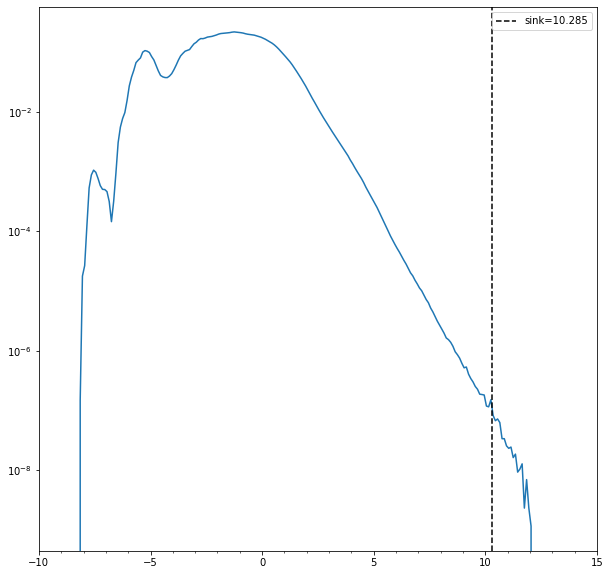

Fitting
1.7 1.6 0.8 7.1
1.7 1.6 0.8 7.1 3.0720344588027944
1.700000025331974 1.6 0.8 7.1
1.700000025331974 1.6 0.8 7.1 3.0720345557396804
1.7 1.600000023841858 0.8 7.1
1.7 1.600000023841858 0.8 7.1 3.07203453800852
1.7 1.6 0.8000000149011612 7.1
1.7 1.6 0.8000000149011612 7.1 3.072034460087001
1.7 1.6 0.8 7.1000001057982445
1.7 1.6 0.8 7.1000001057982445 3.0720344629391763
1.7190414747854112 1.6008067428326531 1.266312370922193 7.3064795335343025
1.7190414747854112 1.6008067428326531 1.266312370922193 7.3064795335343025 3.1761637842254276
1.7190415004011255 1.6008067428326531 1.266312370922193 7.3064795335343025
1.7190415004011255 1.6008067428326531 1.266312370922193 7.3064795335343025 3.1761638841303794
1.7190414747854112 1.6008067666865324 1.266312370922193 7.3064795335343025
1.7190414747854112 1.6008067666865324 1.266312370922193 7.3064795335343025 3.1761638626869235
1.7190414747854112 1.6008067428326531 1.266312389791718 7.3064795335343025
1.7190414747854112 1.6008067428326531 1.26

<ipython-input-2-b2b2cbc87afa>:539: RuntimeWarning: divide by zero encountered in log
  y[i] = np.log(cdf[i]/(1-cdf[i]))


 1.5496744588222757 0.9238758421222937 9.502499919667777 2.9840212618421704
1.7113344366214776 1.5496744588222757 0.9238758272211325 9.50250006126606
1.7113344366214776 1.5496744588222757 0.9238758272211325 9.50250006126606 2.984021262096829
1.7113352201343548 1.54967776579854 0.9238586145509634 9.502482780327211
1.7113352201343548 1.54967776579854 0.9238586145509634 9.502482780327211 2.9840351887239986
1.7113351282170264 1.5496770121885772 0.923871898805889 9.502493703301694
1.7113351282170264 1.5496770121885772 0.923871898805889 9.502493703301694 2.9840323637945287
1.711335153717907 1.5496770121885772 0.923871898805889 9.502493703301694
1.711335153717907 1.5496770121885772 0.923871898805889 9.502493703301694 2.9840324591470626
1.7113351282170264 1.5496770352805642 0.923871898805889 9.502493703301694
1.7113351282170264 1.5496770352805642 0.923871898805889 9.502493703301694 2.9840324409620713
1.7113351282170264 1.5496770121885772 0.9238719137070502 9.502493703301694
1.7113351282170264 

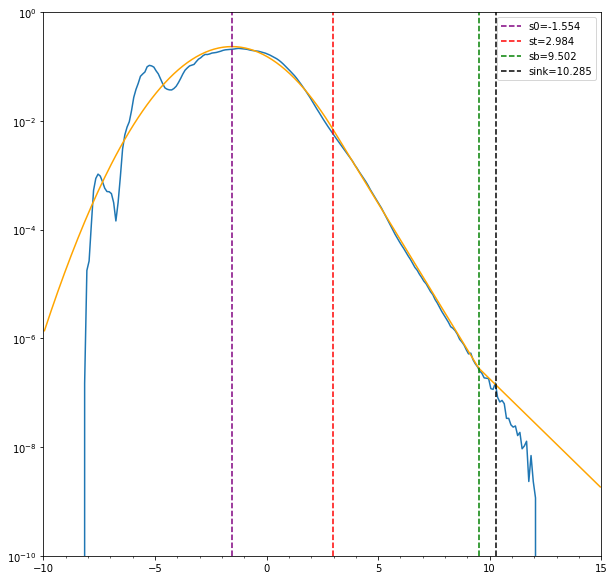

In [8]:
debug=True
debug_snap = 500

count = 0
for j in plot_nums:
        if debug==True:
                if j!=debug_snap:
                        count=count+1
                        continue
        if debug==False:
                if j<debug_snap:
                        #print ('Skipping first 40 files')
                        count=count+1
                        continue
        
        if j < 10:
                plot_filename = "%s_hdf5_plt_cnt_000%d" %(sim_name,j)
                part_filename = "%s_hdf5_part_000%d" %(sim_name,j)
        elif j >= 10 and j < 100:
                plot_filename = "%s_hdf5_plt_cnt_00%d" %(sim_name,j)
                part_filename = "%s_hdf5_part_00%d" %(sim_name,j)
        elif j >= 100 and j <1000:
                plot_filename = "%s_hdf5_plt_cnt_0%d" %(sim_name,j)
                part_filename = "%s_hdf5_part_0%d" %(sim_name,j)
        else:
                plot_filename = "%s_hdf5_plt_cnt_%d" %(sim_name,j)
                part_filename = "%s_hdf5_part_%d" %(sim_name,j)
                
        print ('--------x-------x----------\n')
        print ('--------x-------x----------\n')
        print (plot_filename, count)
        
        #ds = yt.load(plot_filename)
        current_time = plot_times[count]  #float(ds.current_time.in_units('Myr'))
        print (current_time)
        
        ind = np.where(times==current_time)[0]
        if len(ind)==0:
                print ('Not Found any times in .dat file..')
                continue
        time = np.take(times, ind)[-1]
        current_mass = np.take(masses, ind)[-1]
        
        print (time, current_mass)
        
        box_length = 6.172e18 #float(ds.domain_width.in_units('cm')[1])
        volume = box_length**3
        rho_0 = float(current_mass/volume)
        mean_rho = plot_rhos[count]
        print (rho_0, time, current_mass, mean_rho)
        
        outfile_vw = './PDFs_data/{}/'.format(real_sim_name)+plot_filename+'_pdf_vw.dat'
        outfile_mw = './PDFs_data/{}/'.format(real_sim_name)+plot_filename+'_pdf_mw.dat'
        
        print (outfile_vw)
        ##### Volume Weighted Part
        
        dat_filename = outfile_vw
        datContent = [i.strip().split() for i in open(dat_filename).readlines()]

        xdata=[]
        ydata=[]
        for i in range(11, len(datContent)):
            ydata.append(float(datContent[i][2]))
            xdata.append(float(datContent[i][0]))
        xdata = np.array(xdata)
        ydata = np.array(ydata)
        
        
        sinkthresh = np.log(SinkDens/rho_0)
        #sinkthresh = 10.88
        print ('Sink = ', sinkthresh)
        
        
        if debug==True:
            
            fig, ax = plt.subplots()
            fig.set_size_inches(10,10)
            ax.plot(xdata, ydata)
            ax.axvline(x=sinkthresh, c='k', linestyle='--', label='sink=%.3f'%(sinkthresh))
            ax.set_yscale('log')
            ax.minorticks_on()
            ax.set_xlim([-10, 15])
            ax.legend()
            #plt.savefig('./PDFs_data/{real_sim}/Debug_VW_{real_sim}_{file}.png'.format(real_sim = real_sim_name, file=plot_filename))
            plt.show()
            plt.close()
            
            try:
                p0 = [1.7, 1.6, 0.8, 7.1]
                print ('Fitting')
                poptPLPL, perrPLPL = PLPLFit(xdata, ydata, p0)
                print (poptPLPL)
                p0 = poptPLPL
                poptPLPL, perrPLPL = PLPLFit(xdata, ydata, p0)
                print (poptPLPL)
            except ValueError:
                print ('Tweaking initial guess for fitted parameters')
                p0 = [1.7, 1.6, 0.8, 6.1]
                print ('Fitting')
                poptPLPL, perrPLPL = PLPLFit(xdata, ydata, p0)
                print (poptPLPL)
                p0 = poptPLPL
                poptPLPL, perrPLPL = PLPLFit(xdata, ydata, p0)
                print (poptPLPL)
                

            sigma = poptPLPL[0]
            alpha = poptPLPL[1]
            sigma_err = perrPLPL[0]
            alpha_err = perrPLPL[1]
            alpha1 = poptPLPL[2]
            alpha1_err = perrPLPL[2]
            sb = poptPLPL[3]
            sb_err = perrPLPL[3]

            scut = sinkthresh
            s0 = optimize.bisect(lambda x: s0rootfuncnew(x, sigma, alpha, alpha1, sb, scut), -10, 1)
            

            st = s0+alpha*sigma**2
            
            s0bootmean, s0_err, stbootmean, st_err = BootStapper(poptPLPL, perrPLPL)
            #s0_err, st_err = Finds0stErrors(poptPLPL, perrPLPL)
            
            print ('s0, st = ',s0, st, s0bootmean, stbootmean)
            print ('s0_err, st_err = ',s0_err, st_err)
            
            fig, ax = plt.subplots()
            fig.set_size_inches(10,10)
            ax.plot(xdata, ydata)
            #s = np.linspace(-8, 15, 100)
            yfunc = LNPLPLfunction(xdata, sigma, alpha, alpha1, sb)
            ax.plot(xdata, yfunc, c='orange')

            ax.axvline(x=s0, c='purple', linestyle='--', label='s0=%.3f'%(s0))
            ax.axvline(x=st, c='r', linestyle='--', label='st=%.3f'%(st))
            ax.axvline(x=sb, c='g', linestyle='--', label='sb=%.3f'%(sb))
            ax.axvline(x=sinkthresh, c='k', linestyle='--', label='sink=%.3f'%(sinkthresh))

            ax.set_yscale('log')
        
            ax.minorticks_on()
            ax.set_xlim([-10, 15])
            ax.set_ylim([1e-10, 1])
            ax.legend()
            #plt.savefig('./PDFs_data/{real_sim}/WTFDebug_VW_{real_sim}_{file}.png'.format(real_sim = real_sim_name, file=plot_filename))
            plt.show()
            plt.close()
            
            count=count+1
            
            continue
        
        fig = plt.figure(figsize=(12,12))

        ax1 = fig.add_axes([0.1, 0.1, 0.4, 0.4])

        ax2 = fig.add_axes([0.1, 0.5, 0.4, 0.4])
        ax3 = fig.add_axes([0.5, 0.1, 0.4, 0.4])
        ax4 = fig.add_axes([0.5, 0.5, 0.4, 0.4])
        
        
        try:
                p0 = [1.7, 1.6, 0.8, 4.1]
                print ('Fitting')
                poptPLPL, perrPLPL = PLPLFit(xdata, ydata, p0)
                print (poptPLPL)
                p0 = poptPLPL
                poptPLPL, perrPLPL = PLPLFit(xdata, ydata, p0)
                print (poptPLPL)
        except ValueError:
                print ('Tweaking initial guess for fitted parameters')
                p0 = [1.7, 1.6, 0.8, 6.1]
                print ('Fitting')
                poptPLPL, perrPLPL = PLPLFit(xdata, ydata, p0)
                print (poptPLPL)
                p0 = poptPLPL
                poptPLPL, perrPLPL = PLPLFit(xdata, ydata, p0)
                print (poptPLPL)
        
        
        
        
        #p0 = [1.7, 1.6, 0.8, 7.1]
        #print ('Fitting')
        #poptPLPL, perrPLPL = PLPLFit(xdata, ydata, p0)
        #print (poptPLPL)
        #p0 = poptPLPL
        #poptPLPL, perrPLPL = PLPLFit(xdata, ydata, p0)
        #print (poptPLPL)

        sigma = poptPLPL[0]
        alpha = poptPLPL[1]
        sigma_err = perrPLPL[0]
        alpha_err = perrPLPL[1]
        alpha1 = poptPLPL[2]
        alpha1_err = perrPLPL[2]
        sb = poptPLPL[3]
        sb_err = perrPLPL[3]

        scut = sinkthresh
        s0 = optimize.bisect(lambda x: s0rootfuncnew(x, sigma, alpha, alpha1, sb, scut), -10, 1)

        st = s0+alpha*sigma**2
        print ('s0, st = ',s0, st)
        print ('Errors = ', sigma_err, alpha_err, alpha1_err, sb_err)
        
        WriteToFileDPLVW(real_sim_name, j, time, current_mass, sigma, sigma_err, alpha, alpha_err, alpha1, alpha1_err, sb,\
                     sb_err, st, s0)
        
        s0bootmean, s0_err, stbootmean, st_err = BootStapper(poptPLPL, perrPLPL)
        #s0_err, st_err = Finds0stErrors(poptPLPL, perrPLPL)

        print ('s0, st = ', s0, st, s0bootmean, stbootmean)
        print ('s0_err, st_err = ',s0_err, st_err)
        WriteToFileDPLVWBootStrap(real_sim_name, j, time, current_mass, sigma, sigma_err, alpha, alpha_err, alpha1, alpha1_err, sb, \
                     sb_err, st, s0, stbootmean, s0bootmean, st_err, s0_err)
            
            
        scut1dpl = st
        scut2dpl = sb
        
        ax3.plot(xdata, ydata)
        #s = np.linspace(-8, 15, 100)
        yfunc = LNPLPLfunction(xdata, sigma, alpha, alpha1, sb)
        ax3.plot(xdata, yfunc, c='orange')

        ax3.axvline(x=s0, c='purple', linestyle='--', label='s0=%.3f'%(s0))
        ax3.axvline(x=st, c='r', linestyle='--', label='st=%.3f'%(st))
        ax3.axvline(x=sb, c='g', linestyle='--', label='sb=%.3f'%(sb))
        ax3.axvline(x=sinkthresh, c='k', linestyle='--', label='sink=%.3f'%(sinkthresh))

        ax3.set_yscale('log')
        
        index = np.where(ydata>0)
        new_datapts = np.take(ydata, index[0])
        new_datapts_x = np.take(xdata, index[0])
        ydata = new_datapts
        xdata = new_datapts_x

        index = np.where(xdata<sinkthresh)
        new_datapts = np.take(ydata, index[0])
        new_datapts_x = np.take(xdata, index[0])
        ydata = new_datapts
        xdata = new_datapts_x

        cdf = np.zeros(len(xdata))
        y = np.zeros(len(xdata))
        
        s = xdata[4:-4]
        ys = LNPLPLfunctionCDFLog(s, sigma, alpha, alpha1, sb)
        ax4.plot(s, ys, label= "$\\alpha$ = %.3f $\pm$ %.3f" %(alpha, perrPLPL[1])+\
                 "\n $\\alpha_1$ = %.3f $\pm$ %.3f" %(alpha1, perrPLPL[2])+\
             ",\n $\\sigma$ = %.3f $\pm$ %.4f" %(sigma, perrPLPL[0])+\
                 ",\n s$_b$=%.3f $\pm$ %.4f" %(sb, perrPLPL[3])+\
             ",\n s$_0$ = %.3f$\pm$ %.3f, s$_t$ = %.3f$\pm$ %.3f"%(s0bootmean, s0_err, stbootmean, st_err))
        
        
        plt.savefig('./PDFs_data/{real_sim}/VW_{real_sim}_{file}.png'.format(real_sim = real_sim_name, file=plot_filename))
        
        #plt.close()
        
        print ('Single PL part now')
        
        dat_filename = outfile_vw
        datContent = [i.strip().split() for i in open(dat_filename).readlines()]

        xdata=[]
        ydata=[]
        for i in range(11, len(datContent)):
            ydata.append(float(datContent[i][2]))
            xdata.append(float(datContent[i][0]))
        xdata = np.array(xdata)
        ydata = np.array(ydata)
        
        try:
            poptPL, perrPL = PLFit(xdata, ydata)
            sigma_s = poptPL[0]
            alpha = poptPL[1]
            sigma_s_err = perrPL[0]
            alpha_err = perrPL[1]
            s0 = Finds0(sigma_s, alpha)
            st = s0 + alpha*sigma_s**2
        except RuntimeError:
            print ('Cannot fit the single PL properly, assigning double PL values..')
            sigma_s = sigma
            s0 = Finds0(sigma_s, alpha)
            st = s0 + alpha*sigma_s**2
            alpha_err = 100
            sigma_s_err = 100
            #pass
            
        
        scutspl = st
        #print (s0, st)
        s0_err = Finds0err(sigma_s, sigma_s_err, alpha, alpha_err)
        st_err = FindstError(s0, alpha, sigma, s0_err, alpha_err, sigma_err)
        #np.sqrt(s0_err**2 + (sigma_s**2*alpha_err)**2 + (2*alpha*sigma_s*sigma_s_err)**2)
        
        WriteToFileSPLVW(real_sim_name, j, time, current_mass, sigma, sigma_s_err, alpha, alpha_err, st, st_err, s0, s0_err)
        
        yout = LNPLfunction(xdata, sigma_s, alpha)
        

        ax1.plot(xdata, ydata)
        ax1.plot(xdata, yout, 'r')

        ax1.axvline(x=st, c='r', linestyle='--', label='st=%.3f'%(st))
        ax1.axvline(x=sinkthresh, c='k', linestyle='--', label='sink=%.3f'%(sinkthresh))
        ax1.legend()
        ax1.set_yscale('log')
        
        index = np.where(ydata>0)
        new_datapts = np.take(ydata, index[0])
        new_datapts_x = np.take(xdata, index[0])
        ydata = new_datapts
        xdata = new_datapts_x

        index = np.where(xdata<sinkthresh)
        new_datapts = np.take(ydata, index[0])
        new_datapts_x = np.take(xdata, index[0])
        ydata = new_datapts
        xdata = new_datapts_x

        cdf = np.zeros(len(xdata))
        y = np.zeros(len(xdata))

        total = np.sum(ydata)
        for i in range(0, len(ydata)):
            cdf[i] = np.sum(ydata[0:i])/total
            y[i] = np.log(cdf[i]/(1-cdf[i])) 
    
        ax2.plot(xdata[4:-4], y[4:-4])
        ax4.plot(xdata[4:-4], y[4:-4])
        
        
        s = xdata[4:-4]
        ys = LNPLfunctionCDFLog(s, sigma, alpha)
        #plt.plot(sd, yd)
        ax2.plot(s, ys, c = 'r', label = "$\\alpha$ = %.3f $\pm$ %.3f" %(alpha, perrPL[1])+\
             ",\n $\\sigma$ = %.3f $\pm$ %.4f" %(sigma_s, perrPL[0])+\
             ",\n s$_0$ = %.3f $\pm$ %.3f,\n s$_t$ = %.3f $\pm$ %.3f"%(s0, s0_err, st, st_err))
        
        
        
        ax2.minorticks_on()
        ax2.set_xlim([-10, 15])
        ax4.minorticks_on()
        ax4.set_xlim([-10, 15])

        ax1.minorticks_on()
        #ax1.set_xlabel('s', fontsize = 24)
        #ax1.set_ylabel('P(s)', fontsize = 24)
        ax1.set_yscale('log')
        ax1.set_ylim([10**(-10), 10**0])
        ax1.set_xlim([-10, 15])
        ax3.set_ylim([10**(-10), 10**0])
        ax3.set_xlim([-10, 15])

        #ax3.xaxis.set_tick_params(labelsize=0, length=0, width=0)
        #ax3.yaxis.set_tick_params(labelsize=0, length=0, width=0)
        font_size=22
        ax2.legend(loc=4, prop={'size': 14})
        ax2.set_xlabel('s', fontsize=font_size)
        ax2.set_ylabel('y = ln(CDF/(1-CDF))',fontsize=font_size)
        ax2.xaxis.set_label_position('top') 
        ax2.tick_params(which = 'both',right = False, top=True, bottom=False, left=True, labelsize=18)#labelright=True,
        ax2.tick_params(which='major', length=10, width=1.5)
        ax2.tick_params(which='minor', length=3, width=1.5)
        ax2.tick_params(labeltop=True, labelbottom=False, labelright=False, labelleft=True)
        
        #font_size=22
        ax4.legend(loc=4, prop={'size': 14})
        ax4.set_xlabel('s', fontsize=font_size)
        #ax4.set_ylabel('y = ln(CDF/(1-CDF))',fontsize=font_size)
        ax4.xaxis.set_label_position('top') 
        ax4.tick_params(which = 'both',right = True, top=True, bottom=False, left=False, labelsize=18)#labelright=True,
        ax4.tick_params(which='major', length=10, width=1.5)
        ax4.tick_params(which='minor', length=3, width=1.5)
        ax4.tick_params(labeltop=True, labelbottom=False, labelright=True, labelleft=False)

        
        ax1.legend(loc=3, prop={'size': 14})
        ax1.set_xlabel('s', fontsize=font_size)
        ax1.set_ylabel('P$_V$(s)',fontsize=font_size)
        ax1.xaxis.set_label_position('bottom') 
        ax1.tick_params(which = 'both',right = False, left=True, top=False, bottom=True, labelsize=18)#labelright=True,
        ax1.tick_params(which='major', length=10, width=1.5)
        ax1.tick_params(which='minor', length=3, width=1.5)
        ax1.tick_params(labeltop=False, labelbottom=True, labelright=False, labelleft=True)

        ax3.legend(loc=3, prop={'size': 14})
        ax3.set_xlabel('s', fontsize=font_size)
        #ax3.set_ylabel('P$_V$(s)',fontsize=font_size)
        ax3.xaxis.set_label_position('bottom') 
        ax3.tick_params(which = 'both',right = True, left=False, top=False, bottom=True, labelsize=18)#labelright=True,
        ax3.tick_params(which='major', length=10, width=1.5)
        ax3.tick_params(which='minor', length=3, width=1.5)
        ax3.tick_params(labeltop=False, labelbottom=True, labelright=True, labelleft=False)

        
        plt.savefig('./PDFs_data/{real_sim}/VW_{real_sim}_{file}.png'.format(real_sim = real_sim_name, file=plot_filename))
        
        plt.close()
        
        
        
        
        
       
        
        
        count = count+1
        ###

In [11]:
alpha1, alpha1_err

(0.9238718958298336, 2.095457462048875)